In [6]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.optimizers import Adam, Adamax, Nadam, Adadelta, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.io_utils import HDF5Matrix
import h5py

from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split

import cv2
import shapely.wkt
import shapely.affinity
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import smooth_tiled_predictions

In [47]:
Dir = '/home/yokoyang/Downloads/kaggle-data/EU2'

train_img = pd.read_csv(Dir + '/data_imageID.csv')

Image_ID = sorted(train_img.ImageId.unique())
print(Image_ID)


['Lyon_0_0', 'Lyon_0_1', 'Lyon_0_2', 'Lyon_0_3', 'Lyon_0_4', 'Lyon_0_5', 'Lyon_0_6', 'Lyon_1_0', 'Lyon_1_1', 'Lyon_1_2', 'Lyon_1_3', 'Lyon_1_4', 'Lyon_1_5', 'Lyon_1_6', 'Lyon_2_0', 'Lyon_2_1', 'Lyon_2_2', 'Lyon_2_3', 'Lyon_2_4', 'Lyon_2_5', 'Lyon_2_6', 'Lyon_3_0', 'Lyon_3_1', 'Lyon_3_2', 'Lyon_3_3', 'Lyon_3_4', 'Lyon_3_5', 'Lyon_3_6', 'Lyon_4_0', 'Lyon_4_1', 'Lyon_4_2', 'Lyon_4_3', 'Lyon_4_4', 'Lyon_4_5', 'Lyon_4_6', 'Lyon_5_0', 'Lyon_5_1', 'Lyon_5_2', 'Lyon_5_3', 'Lyon_5_4', 'Lyon_5_5', 'Lyon_5_6']


In [46]:
N_split = 4

Patch_size = 256
Class_Type = 1
size = 1024
Scale_Size = Patch_size * N_split

In [9]:
def get_mask(image_id):
    filename = os.path.join(
        Dir, 'land', '{}.tif'.format(image_id))
    msk = tiff.imread(filename)
    msk = msk.astype(np.float32) / 255
    msk_img = np.zeros([size, size], dtype=np.uint8)
    msk_img[:, :] = msk[:, :, 1]
    msk_img ^= 1
    return msk_img

In [10]:
def get_image(image_id):
    filename = os.path.join(
        Dir, 'satellite', '{}.tif'.format(image_id))
    img = tiff.imread(filename)
    img = img.astype(np.float32) / 255
    img_RGB = cv2.resize(img, (Scale_Size, Scale_Size))
    return img_RGB

In [11]:
def get_patch(img_id, pos=1):
    x_all = []
    img = get_image(img_id)
    mask = get_mask(img_id)
    for i in range(N_split):
        for j in range(N_split):
            y = mask[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0):
                x = img[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1), :]
                x_all.append(np.concatenate((x, y[:, :, None]), axis=2))
    x_all = np.asarray(x_all)
    return x_all


def get_all_patches(pos=1):
    x = []
    count = 0
    for img_id in Image_ID:
        x_all = get_patch(img_id, pos=pos)
        #         print ([img_id,len(x_all)])
        if len(x_all) > 0:
            count = count + 1
            if count == 1:
                x = x_all
            else:
                x = np.concatenate((x, x_all), axis=0)
    if pos == 1:
        np.save(Dir + '/output/data_pos_%d_%d_class%d' % (Patch_size, N_split, Class_Type), x)
    else:
        np.save(Dir + '/output/data_%d_%d_class%d' % (Patch_size, N_split, Class_Type), x)
    print(x.shape)
    return x


In [12]:
def get_normalized_patches():
    data = get_all_patches()
    #     data = np.load(Dir + '/output/data_pos_%d_%d_class%d.npy' % (Patch_size, N_split, Class_Type))
    img = data[:, :, :, :3]
    msk = data[:, :, :, 3]
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std
    print(mean, std)
    print(np.mean(img), np.std(img))
    return img, msk


In [64]:
img, msk = get_normalized_patches()

(1524, 256, 256, 4)


0.48894683 0.2100344


-1.2640327e-05 1.0000007


In [13]:
# In predicting testing dataset, need to use the same mean and std in preprocessing training data
def post_normalize_image(img, mean=0.48894683, std=0.2100344):
    img = (img - mean) / std
    return img


In [14]:
def get_unet_5():
    #     Patch_size = 224
    inputs = Input((Patch_size, Patch_size, 3))

    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [11]:
x_trn, x_val, y_trn, y_val = train_test_split(img, msk, test_size=0.2, random_state=42)
y_trn = y_trn[:, :, :, None]
y_val = y_val[:, :, :, None]
model = get_unet_5()
model_checkpoint = ModelCheckpoint('unet5_c1_{epoch:02d}.hdf5')
model.fit(x_trn, y_trn, batch_size=16, epochs=18, vedrbose=1, shuffle=True,
          callbacks=[model_checkpoint], validation_data=(x_val, y_val))


Train on 1219 samples, validate on 305 samples
Epoch 1/100


  16/1219 [..............................] - ETA: 6:12 - loss: 0.5762 - acc: 0.7801

  32/1219 [..............................] - ETA: 3:30 - loss: 0.5770 - acc: 0.8219

  48/1219 [>.............................] - ETA: 2:36 - loss: 0.5597 - acc: 0.8169

  64/1219 [>.............................] - ETA: 2:08 - loss: 0.5391 - acc: 0.8134

  80/1219 [>.............................] - ETA: 1:51 - loss: 0.5367 - acc: 0.8135

  96/1219 [=>............................] - ETA: 1:40 - loss: 0.5333 - acc: 0.8114

 112/1219 [=>............................] - ETA: 1:31 - loss: 0.5203 - acc: 0.8201

 128/1219 [==>...........................] - ETA: 1:25 - loss: 0.5201 - acc: 0.8141

 144/1219 [==>...........................] - ETA: 1:20 - loss: 0.5153 - acc: 0.8137

 160/1219 [==>...........................] - ETA: 1:15 - loss: 0.5095 - acc: 0.8152

 176/1219 [===>..........................] - ETA: 1:12 - loss: 0.4995 - acc: 0.8189

 192/1219 [===>..........................] - ETA: 1:09 - loss: 0.5023 - acc: 0.8152

 208/1219 [====>.........................] - ETA: 1:06 - loss: 0.5005 - acc: 0.8138

 224/1219 [====>.........................] - ETA: 1:03 - loss: 0.4935 - acc: 0.8175

 240/1219 [====>.........................] - ETA: 1:01 - loss: 0.4886 - acc: 0.8187

 256/1219 [=====>........................] - ETA: 59s - loss: 0.4884 - acc: 0.8178 

 272/1219 [=====>........................] - ETA: 57s - loss: 0.4846 - acc: 0.8187

 288/1219 [======>.......................] - ETA: 55s - loss: 0.4848 - acc: 0.8176

 304/1219 [======>.......................] - ETA: 54s - loss: 0.4837 - acc: 0.8166

 320/1219 [======>.......................] - ETA: 52s - loss: 0.4827 - acc: 0.8149

 336/1219 [=======>......................] - ETA: 51s - loss: 0.4779 - acc: 0.8161

 352/1219 [=======>......................] - ETA: 49s - loss: 0.4742 - acc: 0.8176

 368/1219 [========>.....................] - ETA: 48s - loss: 0.4726 - acc: 0.8162

 384/1219 [========>.....................] - ETA: 46s - loss: 0.4702 - acc: 0.8168

 400/1219 [========>.....................] - ETA: 45s - loss: 0.4674 - acc: 0.8164

 416/1219 [=========>....................] - ETA: 44s - loss: 0.4681 - acc: 0.8147

 432/1219 [=========>....................] - ETA: 43s - loss: 0.4645 - acc: 0.8158

 448/1219 [==========>...................] - ETA: 42s - loss: 0.4620 - acc: 0.8165

 464/1219 [==========>...................] - ETA: 41s - loss: 0.4609 - acc: 0.8161

 480/1219 [==========>...................] - ETA: 39s - loss: 0.4609 - acc: 0.8150

 496/1219 [===========>..................] - ETA: 38s - loss: 0.4571 - acc: 0.8168

 512/1219 [===========>..................] - ETA: 37s - loss: 0.4573 - acc: 0.8163

 528/1219 [===========>..................] - ETA: 36s - loss: 0.4561 - acc: 0.8165

 544/1219 [============>.................] - ETA: 35s - loss: 0.4562 - acc: 0.8166

 560/1219 [============>.................] - ETA: 34s - loss: 0.4537 - acc: 0.8174

 576/1219 [=============>................] - ETA: 33s - loss: 0.4537 - acc: 0.8164

 592/1219 [=============>................] - ETA: 32s - loss: 0.4510 - acc: 0.8180

 608/1219 [=============>................] - ETA: 32s - loss: 0.4497 - acc: 0.8184

 624/1219 [==============>...............] - ETA: 31s - loss: 0.4478 - acc: 0.8191

 640/1219 [==============>...............] - ETA: 30s - loss: 0.4468 - acc: 0.8196

 656/1219 [===============>..............] - ETA: 29s - loss: 0.4458 - acc: 0.8194

 672/1219 [===============>..............] - ETA: 28s - loss: 0.4440 - acc: 0.8201

 688/1219 [===============>..............] - ETA: 27s - loss: 0.4447 - acc: 0.8193

 704/1219 [================>.............] - ETA: 26s - loss: 0.4428 - acc: 0.8200

 720/1219 [================>.............] - ETA: 25s - loss: 0.4415 - acc: 0.8204

 736/1219 [=================>............] - ETA: 24s - loss: 0.4399 - acc: 0.8212

 752/1219 [=================>............] - ETA: 23s - loss: 0.4384 - acc: 0.8217

 768/1219 [=================>............] - ETA: 23s - loss: 0.4382 - acc: 0.8215

 784/1219 [==================>...........] - ETA: 22s - loss: 0.4378 - acc: 0.8214

 800/1219 [==================>...........] - ETA: 21s - loss: 0.4373 - acc: 0.8213

 816/1219 [===================>..........] - ETA: 20s - loss: 0.4366 - acc: 0.8216

 832/1219 [===================>..........] - ETA: 19s - loss: 0.4356 - acc: 0.8218

 848/1219 [===================>..........] - ETA: 18s - loss: 0.4344 - acc: 0.8221

 864/1219 [====================>.........] - ETA: 17s - loss: 0.4340 - acc: 0.8220

 880/1219 [====================>.........] - ETA: 17s - loss: 0.4326 - acc: 0.8227

 896/1219 [=====================>........] - ETA: 16s - loss: 0.4314 - acc: 0.8230

 912/1219 [=====================>........] - ETA: 15s - loss: 0.4314 - acc: 0.8228

 928/1219 [=====================>........] - ETA: 14s - loss: 0.4305 - acc: 0.8234

 944/1219 [======================>.......] - ETA: 13s - loss: 0.4298 - acc: 0.8240

 960/1219 [======================>.......] - ETA: 12s - loss: 0.4289 - acc: 0.8243

 976/1219 [=======================>......] - ETA: 12s - loss: 0.4288 - acc: 0.8243

 992/1219 [=======================>......] - ETA: 11s - loss: 0.4279 - acc: 0.8246

1008/1219 [=======================>......] - ETA: 10s - loss: 0.4281 - acc: 0.8246

1024/1219 [========================>.....] - ETA: 9s - loss: 0.4276 - acc: 0.8247 

1040/1219 [========================>.....] - ETA: 8s - loss: 0.4259 - acc: 0.8253

1056/1219 [========================>.....] - ETA: 8s - loss: 0.4258 - acc: 0.8251

1072/1219 [=========================>....] - ETA: 7s - loss: 0.4251 - acc: 0.8250

1088/1219 [=========================>....] - ETA: 6s - loss: 0.4255 - acc: 0.8252

1104/1219 [==========================>...] - ETA: 5s - loss: 0.4262 - acc: 0.8248

1120/1219 [==========================>...] - ETA: 4s - loss: 0.4265 - acc: 0.8244

1136/1219 [==========================>...] - ETA: 4s - loss: 0.4258 - acc: 0.8244

1152/1219 [===========================>..] - ETA: 3s - loss: 0.4253 - acc: 0.8246

1168/1219 [===========================>..] - ETA: 2s - loss: 0.4244 - acc: 0.8250

1184/1219 [============================>.] - ETA: 1s - loss: 0.4236 - acc: 0.8252

1200/1219 [============================>.] - ETA: 0s - loss: 0.4232 - acc: 0.8253

1216/1219 [============================>.] - ETA: 0s - loss: 0.4224 - acc: 0.8255

1219/1219 [==============================] - 66s 54ms/step - loss: 0.4224 - acc: 0.8253 - val_loss: 0.4242 - val_acc: 0.8484


Epoch 2/100


  16/1219 [..............................] - ETA: 54s - loss: 0.4360 - acc: 0.8336

  32/1219 [..............................] - ETA: 53s - loss: 0.4035 - acc: 0.8410

  48/1219 [>.............................] - ETA: 53s - loss: 0.4151 - acc: 0.8325

  64/1219 [>.............................] - ETA: 52s - loss: 0.4076 - acc: 0.8353

  80/1219 [>.............................] - ETA: 51s - loss: 0.4066 - acc: 0.8361

  96/1219 [=>............................] - ETA: 50s - loss: 0.4069 - acc: 0.8333

 112/1219 [=>............................] - ETA: 50s - loss: 0.4284 - acc: 0.8270

 128/1219 [==>...........................] - ETA: 49s - loss: 0.4193 - acc: 0.8300

 144/1219 [==>...........................] - ETA: 48s - loss: 0.4103 - acc: 0.8325

 160/1219 [==>...........................] - ETA: 47s - loss: 0.4091 - acc: 0.8309

 176/1219 [===>..........................] - ETA: 47s - loss: 0.4040 - acc: 0.8309

 192/1219 [===>..........................] - ETA: 46s - loss: 0.4054 - acc: 0.8280

 208/1219 [====>.........................] - ETA: 45s - loss: 0.4049 - acc: 0.8271

 224/1219 [====>.........................] - ETA: 45s - loss: 0.3992 - acc: 0.8295

 240/1219 [====>.........................] - ETA: 44s - loss: 0.4015 - acc: 0.8283

 256/1219 [=====>........................] - ETA: 43s - loss: 0.4007 - acc: 0.8291

 272/1219 [=====>........................] - ETA: 42s - loss: 0.3962 - acc: 0.8314

 288/1219 [======>.......................] - ETA: 42s - loss: 0.3959 - acc: 0.8317

 304/1219 [======>.......................] - ETA: 41s - loss: 0.3915 - acc: 0.8339

 320/1219 [======>.......................] - ETA: 40s - loss: 0.3896 - acc: 0.8358

 336/1219 [=======>......................] - ETA: 39s - loss: 0.3871 - acc: 0.8372

 352/1219 [=======>......................] - ETA: 39s - loss: 0.3844 - acc: 0.8387

 368/1219 [========>.....................] - ETA: 38s - loss: 0.3811 - acc: 0.8402

 384/1219 [========>.....................] - ETA: 37s - loss: 0.3792 - acc: 0.8412

 400/1219 [========>.....................] - ETA: 37s - loss: 0.3784 - acc: 0.8412

 416/1219 [=========>....................] - ETA: 36s - loss: 0.3758 - acc: 0.8424

 432/1219 [=========>....................] - ETA: 35s - loss: 0.3725 - acc: 0.8439

 448/1219 [==========>...................] - ETA: 34s - loss: 0.3673 - acc: 0.8464

 464/1219 [==========>...................] - ETA: 34s - loss: 0.3692 - acc: 0.8457

 480/1219 [==========>...................] - ETA: 33s - loss: 0.3684 - acc: 0.8462

 496/1219 [===========>..................] - ETA: 32s - loss: 0.3696 - acc: 0.8455

 512/1219 [===========>..................] - ETA: 32s - loss: 0.3701 - acc: 0.8450

 528/1219 [===========>..................] - ETA: 31s - loss: 0.3697 - acc: 0.8452

 544/1219 [============>.................] - ETA: 30s - loss: 0.3681 - acc: 0.8457

 560/1219 [============>.................] - ETA: 29s - loss: 0.3678 - acc: 0.8462

 576/1219 [=============>................] - ETA: 29s - loss: 0.3674 - acc: 0.8461

 592/1219 [=============>................] - ETA: 28s - loss: 0.3662 - acc: 0.8465

 608/1219 [=============>................] - ETA: 27s - loss: 0.3653 - acc: 0.8470

 624/1219 [==============>...............] - ETA: 26s - loss: 0.3631 - acc: 0.8480

 640/1219 [==============>...............] - ETA: 26s - loss: 0.3631 - acc: 0.8480

 656/1219 [===============>..............] - ETA: 25s - loss: 0.3627 - acc: 0.8484

 672/1219 [===============>..............] - ETA: 24s - loss: 0.3627 - acc: 0.8484

 688/1219 [===============>..............] - ETA: 24s - loss: 0.3627 - acc: 0.8484

 704/1219 [================>.............] - ETA: 23s - loss: 0.3635 - acc: 0.8479

 720/1219 [================>.............] - ETA: 22s - loss: 0.3629 - acc: 0.8481

 736/1219 [=================>............] - ETA: 21s - loss: 0.3632 - acc: 0.8480

 752/1219 [=================>............] - ETA: 21s - loss: 0.3628 - acc: 0.8482

 768/1219 [=================>............] - ETA: 20s - loss: 0.3614 - acc: 0.8488

 784/1219 [==================>...........] - ETA: 19s - loss: 0.3590 - acc: 0.8500

 800/1219 [==================>...........] - ETA: 18s - loss: 0.3568 - acc: 0.8511

 816/1219 [===================>..........] - ETA: 18s - loss: 0.3579 - acc: 0.8506

 832/1219 [===================>..........] - ETA: 17s - loss: 0.3580 - acc: 0.8506

 848/1219 [===================>..........] - ETA: 16s - loss: 0.3585 - acc: 0.8504

 864/1219 [====================>.........] - ETA: 16s - loss: 0.3577 - acc: 0.8509

 880/1219 [====================>.........] - ETA: 15s - loss: 0.3584 - acc: 0.8506

 896/1219 [=====================>........] - ETA: 14s - loss: 0.3568 - acc: 0.8513

 912/1219 [=====================>........] - ETA: 13s - loss: 0.3573 - acc: 0.8508

 928/1219 [=====================>........] - ETA: 13s - loss: 0.3567 - acc: 0.8511

 944/1219 [======================>.......] - ETA: 12s - loss: 0.3559 - acc: 0.8514

 960/1219 [======================>.......] - ETA: 11s - loss: 0.3561 - acc: 0.8512

 976/1219 [=======================>......] - ETA: 11s - loss: 0.3561 - acc: 0.8510

 992/1219 [=======================>......] - ETA: 10s - loss: 0.3560 - acc: 0.8508

1008/1219 [=======================>......] - ETA: 9s - loss: 0.3545 - acc: 0.8515 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.3545 - acc: 0.8514

1040/1219 [========================>.....] - ETA: 8s - loss: 0.3528 - acc: 0.8523

1056/1219 [========================>.....] - ETA: 7s - loss: 0.3527 - acc: 0.8522

1072/1219 [=========================>....] - ETA: 6s - loss: 0.3512 - acc: 0.8528

1088/1219 [=========================>....] - ETA: 5s - loss: 0.3513 - acc: 0.8529

1104/1219 [==========================>...] - ETA: 5s - loss: 0.3506 - acc: 0.8532

1120/1219 [==========================>...] - ETA: 4s - loss: 0.3516 - acc: 0.8529

1136/1219 [==========================>...] - ETA: 3s - loss: 0.3506 - acc: 0.8534

1152/1219 [===========================>..] - ETA: 3s - loss: 0.3507 - acc: 0.8533

1168/1219 [===========================>..] - ETA: 2s - loss: 0.3508 - acc: 0.8534

1184/1219 [============================>.] - ETA: 1s - loss: 0.3504 - acc: 0.8537

1200/1219 [============================>.] - ETA: 0s - loss: 0.3499 - acc: 0.8540

1216/1219 [============================>.] - ETA: 0s - loss: 0.3490 - acc: 0.8545

1219/1219 [==============================] - 59s 49ms/step - loss: 0.3490 - acc: 0.8545 - val_loss: 0.3076 - val_acc: 0.8757


Epoch 3/100


  16/1219 [..............................] - ETA: 55s - loss: 0.2771 - acc: 0.8837

  32/1219 [..............................] - ETA: 54s - loss: 0.2957 - acc: 0.8761

  48/1219 [>.............................] - ETA: 53s - loss: 0.2733 - acc: 0.8902

  64/1219 [>.............................] - ETA: 52s - loss: 0.2829 - acc: 0.8866

  80/1219 [>.............................] - ETA: 51s - loss: 0.2836 - acc: 0.8860

  96/1219 [=>............................] - ETA: 51s - loss: 0.2930 - acc: 0.8833

 112/1219 [=>............................] - ETA: 50s - loss: 0.2950 - acc: 0.8805

 128/1219 [==>...........................] - ETA: 49s - loss: 0.3241 - acc: 0.8703

 144/1219 [==>...........................] - ETA: 48s - loss: 0.3197 - acc: 0.8718

 160/1219 [==>...........................] - ETA: 48s - loss: 0.3225 - acc: 0.8698

 176/1219 [===>..........................] - ETA: 47s - loss: 0.3248 - acc: 0.8693

 192/1219 [===>..........................] - ETA: 46s - loss: 0.3271 - acc: 0.8684

 208/1219 [====>.........................] - ETA: 45s - loss: 0.3251 - acc: 0.8694

 224/1219 [====>.........................] - ETA: 45s - loss: 0.3283 - acc: 0.8672

 240/1219 [====>.........................] - ETA: 44s - loss: 0.3310 - acc: 0.8657

 256/1219 [=====>........................] - ETA: 43s - loss: 0.3275 - acc: 0.8672

 272/1219 [=====>........................] - ETA: 43s - loss: 0.3257 - acc: 0.8680

 288/1219 [======>.......................] - ETA: 42s - loss: 0.3264 - acc: 0.8673

 304/1219 [======>.......................] - ETA: 41s - loss: 0.3257 - acc: 0.8673

 320/1219 [======>.......................] - ETA: 40s - loss: 0.3243 - acc: 0.8676

 336/1219 [=======>......................] - ETA: 40s - loss: 0.3300 - acc: 0.8647

 352/1219 [=======>......................] - ETA: 39s - loss: 0.3302 - acc: 0.8647

 368/1219 [========>.....................] - ETA: 38s - loss: 0.3316 - acc: 0.8646

 384/1219 [========>.....................] - ETA: 37s - loss: 0.3324 - acc: 0.8644

 400/1219 [========>.....................] - ETA: 37s - loss: 0.3334 - acc: 0.8641

 416/1219 [=========>....................] - ETA: 36s - loss: 0.3329 - acc: 0.8646

 432/1219 [=========>....................] - ETA: 35s - loss: 0.3316 - acc: 0.8653

 448/1219 [==========>...................] - ETA: 35s - loss: 0.3332 - acc: 0.8642

 464/1219 [==========>...................] - ETA: 34s - loss: 0.3327 - acc: 0.8640

 480/1219 [==========>...................] - ETA: 33s - loss: 0.3312 - acc: 0.8647

 496/1219 [===========>..................] - ETA: 32s - loss: 0.3323 - acc: 0.8641

 512/1219 [===========>..................] - ETA: 32s - loss: 0.3333 - acc: 0.8636

 528/1219 [===========>..................] - ETA: 31s - loss: 0.3313 - acc: 0.8645

 544/1219 [============>.................] - ETA: 30s - loss: 0.3313 - acc: 0.8646

 560/1219 [============>.................] - ETA: 29s - loss: 0.3305 - acc: 0.8649

 576/1219 [=============>................] - ETA: 29s - loss: 0.3289 - acc: 0.8658

 592/1219 [=============>................] - ETA: 28s - loss: 0.3299 - acc: 0.8651

 608/1219 [=============>................] - ETA: 27s - loss: 0.3290 - acc: 0.8655

 624/1219 [==============>...............] - ETA: 27s - loss: 0.3285 - acc: 0.8656

 640/1219 [==============>...............] - ETA: 26s - loss: 0.3280 - acc: 0.8658

 656/1219 [===============>..............] - ETA: 25s - loss: 0.3288 - acc: 0.8651

 672/1219 [===============>..............] - ETA: 24s - loss: 0.3282 - acc: 0.8652

 688/1219 [===============>..............] - ETA: 24s - loss: 0.3273 - acc: 0.8657

 704/1219 [================>.............] - ETA: 23s - loss: 0.3267 - acc: 0.8660

 720/1219 [================>.............] - ETA: 22s - loss: 0.3283 - acc: 0.8649

 736/1219 [=================>............] - ETA: 21s - loss: 0.3275 - acc: 0.8651

 752/1219 [=================>............] - ETA: 21s - loss: 0.3266 - acc: 0.8654

 768/1219 [=================>............] - ETA: 20s - loss: 0.3258 - acc: 0.8657

 784/1219 [==================>...........] - ETA: 19s - loss: 0.3265 - acc: 0.8655

 800/1219 [==================>...........] - ETA: 19s - loss: 0.3263 - acc: 0.8654

 816/1219 [===================>..........] - ETA: 18s - loss: 0.3254 - acc: 0.8657

 832/1219 [===================>..........] - ETA: 17s - loss: 0.3254 - acc: 0.8656

 848/1219 [===================>..........] - ETA: 16s - loss: 0.3243 - acc: 0.8659

 864/1219 [====================>.........] - ETA: 16s - loss: 0.3244 - acc: 0.8659

 880/1219 [====================>.........] - ETA: 15s - loss: 0.3239 - acc: 0.8661

 896/1219 [=====================>........] - ETA: 14s - loss: 0.3241 - acc: 0.8660

 912/1219 [=====================>........] - ETA: 13s - loss: 0.3239 - acc: 0.8663

 928/1219 [=====================>........] - ETA: 13s - loss: 0.3228 - acc: 0.8668

 944/1219 [======================>.......] - ETA: 12s - loss: 0.3222 - acc: 0.8670

 960/1219 [======================>.......] - ETA: 11s - loss: 0.3214 - acc: 0.8674

 976/1219 [=======================>......] - ETA: 11s - loss: 0.3197 - acc: 0.8683

 992/1219 [=======================>......] - ETA: 10s - loss: 0.3193 - acc: 0.8685

1008/1219 [=======================>......] - ETA: 9s - loss: 0.3193 - acc: 0.8685 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.3187 - acc: 0.8688

1040/1219 [========================>.....] - ETA: 8s - loss: 0.3182 - acc: 0.8689

1056/1219 [========================>.....] - ETA: 7s - loss: 0.3174 - acc: 0.8692

1072/1219 [=========================>....] - ETA: 6s - loss: 0.3162 - acc: 0.8697

1088/1219 [=========================>....] - ETA: 5s - loss: 0.3162 - acc: 0.8698

1104/1219 [==========================>...] - ETA: 5s - loss: 0.3158 - acc: 0.8700

1120/1219 [==========================>...] - ETA: 4s - loss: 0.3152 - acc: 0.8703

1136/1219 [==========================>...] - ETA: 3s - loss: 0.3152 - acc: 0.8701

1152/1219 [===========================>..] - ETA: 3s - loss: 0.3152 - acc: 0.8702

1168/1219 [===========================>..] - ETA: 2s - loss: 0.3151 - acc: 0.8703

1184/1219 [============================>.] - ETA: 1s - loss: 0.3141 - acc: 0.8706

1200/1219 [============================>.] - ETA: 0s - loss: 0.3137 - acc: 0.8708

1216/1219 [============================>.] - ETA: 0s - loss: 0.3143 - acc: 0.8705

1219/1219 [==============================] - 60s 49ms/step - loss: 0.3142 - acc: 0.8706 - val_loss: 0.3578 - val_acc: 0.8447


Epoch 4/100


  16/1219 [..............................] - ETA: 55s - loss: 0.4373 - acc: 0.7912

  32/1219 [..............................] - ETA: 54s - loss: 0.3762 - acc: 0.8314

  48/1219 [>.............................] - ETA: 53s - loss: 0.3490 - acc: 0.8521

  64/1219 [>.............................] - ETA: 52s - loss: 0.3204 - acc: 0.8658

  80/1219 [>.............................] - ETA: 51s - loss: 0.3219 - acc: 0.8641

  96/1219 [=>............................] - ETA: 51s - loss: 0.3251 - acc: 0.8624

 112/1219 [=>............................] - ETA: 50s - loss: 0.3265 - acc: 0.8624

 128/1219 [==>...........................] - ETA: 49s - loss: 0.3255 - acc: 0.8632

 144/1219 [==>...........................] - ETA: 48s - loss: 0.3283 - acc: 0.8616

 160/1219 [==>...........................] - ETA: 48s - loss: 0.3291 - acc: 0.8613

 176/1219 [===>..........................] - ETA: 47s - loss: 0.3243 - acc: 0.8638

 192/1219 [===>..........................] - ETA: 46s - loss: 0.3199 - acc: 0.8660

 208/1219 [====>.........................] - ETA: 45s - loss: 0.3152 - acc: 0.8681

 224/1219 [====>.........................] - ETA: 45s - loss: 0.3163 - acc: 0.8681

 240/1219 [====>.........................] - ETA: 44s - loss: 0.3138 - acc: 0.8691

 256/1219 [=====>........................] - ETA: 43s - loss: 0.3165 - acc: 0.8686

 272/1219 [=====>........................] - ETA: 43s - loss: 0.3152 - acc: 0.8693

 288/1219 [======>.......................] - ETA: 42s - loss: 0.3177 - acc: 0.8673

 304/1219 [======>.......................] - ETA: 41s - loss: 0.3165 - acc: 0.8678

 320/1219 [======>.......................] - ETA: 40s - loss: 0.3170 - acc: 0.8678

 336/1219 [=======>......................] - ETA: 40s - loss: 0.3146 - acc: 0.8690

 352/1219 [=======>......................] - ETA: 39s - loss: 0.3137 - acc: 0.8694

 368/1219 [========>.....................] - ETA: 38s - loss: 0.3130 - acc: 0.8697

 384/1219 [========>.....................] - ETA: 37s - loss: 0.3129 - acc: 0.8701

 400/1219 [========>.....................] - ETA: 37s - loss: 0.3109 - acc: 0.8711

 416/1219 [=========>....................] - ETA: 36s - loss: 0.3131 - acc: 0.8709

 432/1219 [=========>....................] - ETA: 35s - loss: 0.3165 - acc: 0.8692

 448/1219 [==========>...................] - ETA: 35s - loss: 0.3146 - acc: 0.8699

 464/1219 [==========>...................] - ETA: 34s - loss: 0.3151 - acc: 0.8696

 480/1219 [==========>...................] - ETA: 33s - loss: 0.3148 - acc: 0.8698

 496/1219 [===========>..................] - ETA: 32s - loss: 0.3129 - acc: 0.8705

 512/1219 [===========>..................] - ETA: 32s - loss: 0.3119 - acc: 0.8709

 528/1219 [===========>..................] - ETA: 31s - loss: 0.3106 - acc: 0.8717

 544/1219 [============>.................] - ETA: 30s - loss: 0.3140 - acc: 0.8699

 560/1219 [============>.................] - ETA: 29s - loss: 0.3141 - acc: 0.8696

 576/1219 [=============>................] - ETA: 29s - loss: 0.3150 - acc: 0.8690

 592/1219 [=============>................] - ETA: 28s - loss: 0.3180 - acc: 0.8680

 608/1219 [=============>................] - ETA: 27s - loss: 0.3169 - acc: 0.8683

 624/1219 [==============>...............] - ETA: 27s - loss: 0.3176 - acc: 0.8683

 640/1219 [==============>...............] - ETA: 26s - loss: 0.3190 - acc: 0.8677

 656/1219 [===============>..............] - ETA: 25s - loss: 0.3194 - acc: 0.8677

 672/1219 [===============>..............] - ETA: 24s - loss: 0.3191 - acc: 0.8681

 688/1219 [===============>..............] - ETA: 24s - loss: 0.3191 - acc: 0.8683

 704/1219 [================>.............] - ETA: 23s - loss: 0.3188 - acc: 0.8684

 720/1219 [================>.............] - ETA: 22s - loss: 0.3171 - acc: 0.8692

 736/1219 [=================>............] - ETA: 21s - loss: 0.3160 - acc: 0.8698

 752/1219 [=================>............] - ETA: 21s - loss: 0.3137 - acc: 0.8709

 768/1219 [=================>............] - ETA: 20s - loss: 0.3136 - acc: 0.8709

 784/1219 [==================>...........] - ETA: 19s - loss: 0.3132 - acc: 0.8709

 800/1219 [==================>...........] - ETA: 19s - loss: 0.3131 - acc: 0.8708

 816/1219 [===================>..........] - ETA: 18s - loss: 0.3130 - acc: 0.8709

 832/1219 [===================>..........] - ETA: 17s - loss: 0.3145 - acc: 0.8705

 848/1219 [===================>..........] - ETA: 16s - loss: 0.3156 - acc: 0.8701

 864/1219 [====================>.........] - ETA: 16s - loss: 0.3148 - acc: 0.8706

 880/1219 [====================>.........] - ETA: 15s - loss: 0.3155 - acc: 0.8702

 896/1219 [=====================>........] - ETA: 14s - loss: 0.3147 - acc: 0.8707

 912/1219 [=====================>........] - ETA: 13s - loss: 0.3133 - acc: 0.8713

 928/1219 [=====================>........] - ETA: 13s - loss: 0.3142 - acc: 0.8710

 944/1219 [======================>.......] - ETA: 12s - loss: 0.3151 - acc: 0.8705

 960/1219 [======================>.......] - ETA: 11s - loss: 0.3142 - acc: 0.8710

 976/1219 [=======================>......] - ETA: 11s - loss: 0.3142 - acc: 0.8709

 992/1219 [=======================>......] - ETA: 10s - loss: 0.3133 - acc: 0.8713

1008/1219 [=======================>......] - ETA: 9s - loss: 0.3131 - acc: 0.8714 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.3120 - acc: 0.8718

1040/1219 [========================>.....] - ETA: 8s - loss: 0.3123 - acc: 0.8717

1056/1219 [========================>.....] - ETA: 7s - loss: 0.3118 - acc: 0.8721

1072/1219 [=========================>....] - ETA: 6s - loss: 0.3115 - acc: 0.8720

1088/1219 [=========================>....] - ETA: 5s - loss: 0.3114 - acc: 0.8719

1104/1219 [==========================>...] - ETA: 5s - loss: 0.3107 - acc: 0.8723

1120/1219 [==========================>...] - ETA: 4s - loss: 0.3104 - acc: 0.8725

1136/1219 [==========================>...] - ETA: 3s - loss: 0.3106 - acc: 0.8723

1152/1219 [===========================>..] - ETA: 3s - loss: 0.3098 - acc: 0.8727

1168/1219 [===========================>..] - ETA: 2s - loss: 0.3091 - acc: 0.8730

1184/1219 [============================>.] - ETA: 1s - loss: 0.3093 - acc: 0.8729

1200/1219 [============================>.] - ETA: 0s - loss: 0.3088 - acc: 0.8731

1216/1219 [============================>.] - ETA: 0s - loss: 0.3085 - acc: 0.8733

1219/1219 [==============================] - 60s 49ms/step - loss: 0.3085 - acc: 0.8733 - val_loss: 0.2804 - val_acc: 0.8903


Epoch 5/100


  16/1219 [..............................] - ETA: 54s - loss: 0.2665 - acc: 0.8990

  32/1219 [..............................] - ETA: 53s - loss: 0.2790 - acc: 0.8882

  48/1219 [>.............................] - ETA: 53s - loss: 0.2855 - acc: 0.8845

  64/1219 [>.............................] - ETA: 52s - loss: 0.2999 - acc: 0.8764

  80/1219 [>.............................] - ETA: 51s - loss: 0.2907 - acc: 0.8792

  96/1219 [=>............................] - ETA: 51s - loss: 0.2859 - acc: 0.8821

 112/1219 [=>............................] - ETA: 50s - loss: 0.2848 - acc: 0.8824

 128/1219 [==>...........................] - ETA: 49s - loss: 0.2864 - acc: 0.8830

 144/1219 [==>...........................] - ETA: 48s - loss: 0.2861 - acc: 0.8843

 160/1219 [==>...........................] - ETA: 48s - loss: 0.2862 - acc: 0.8836

 176/1219 [===>..........................] - ETA: 47s - loss: 0.2872 - acc: 0.8837

 192/1219 [===>..........................] - ETA: 46s - loss: 0.2849 - acc: 0.8854

 208/1219 [====>.........................] - ETA: 45s - loss: 0.2809 - acc: 0.8875

 224/1219 [====>.........................] - ETA: 45s - loss: 0.2764 - acc: 0.8898

 240/1219 [====>.........................] - ETA: 44s - loss: 0.2751 - acc: 0.8905

 256/1219 [=====>........................] - ETA: 43s - loss: 0.2752 - acc: 0.8904

 272/1219 [=====>........................] - ETA: 43s - loss: 0.2759 - acc: 0.8898

 288/1219 [======>.......................] - ETA: 42s - loss: 0.2777 - acc: 0.8893

 304/1219 [======>.......................] - ETA: 41s - loss: 0.2757 - acc: 0.8898

 320/1219 [======>.......................] - ETA: 40s - loss: 0.2759 - acc: 0.8895

 336/1219 [=======>......................] - ETA: 40s - loss: 0.2758 - acc: 0.8894

 352/1219 [=======>......................] - ETA: 39s - loss: 0.2773 - acc: 0.8886

 368/1219 [========>.....................] - ETA: 38s - loss: 0.2785 - acc: 0.8881

 384/1219 [========>.....................] - ETA: 37s - loss: 0.2766 - acc: 0.8887

 400/1219 [========>.....................] - ETA: 37s - loss: 0.2787 - acc: 0.8877

 416/1219 [=========>....................] - ETA: 36s - loss: 0.2776 - acc: 0.8884

 432/1219 [=========>....................] - ETA: 35s - loss: 0.2761 - acc: 0.8888

 448/1219 [==========>...................] - ETA: 35s - loss: 0.2759 - acc: 0.8888

 464/1219 [==========>...................] - ETA: 34s - loss: 0.2790 - acc: 0.8873

 480/1219 [==========>...................] - ETA: 33s - loss: 0.2787 - acc: 0.8873

 496/1219 [===========>..................] - ETA: 32s - loss: 0.2781 - acc: 0.8873

 512/1219 [===========>..................] - ETA: 32s - loss: 0.2801 - acc: 0.8862

 528/1219 [===========>..................] - ETA: 31s - loss: 0.2795 - acc: 0.8865

 544/1219 [============>.................] - ETA: 30s - loss: 0.2771 - acc: 0.8877

 560/1219 [============>.................] - ETA: 29s - loss: 0.2772 - acc: 0.8878

 576/1219 [=============>................] - ETA: 29s - loss: 0.2783 - acc: 0.8873

 592/1219 [=============>................] - ETA: 28s - loss: 0.2797 - acc: 0.8865

 608/1219 [=============>................] - ETA: 27s - loss: 0.2796 - acc: 0.8867

 624/1219 [==============>...............] - ETA: 27s - loss: 0.2798 - acc: 0.8866

 640/1219 [==============>...............] - ETA: 26s - loss: 0.2819 - acc: 0.8861

 656/1219 [===============>..............] - ETA: 25s - loss: 0.2829 - acc: 0.8859

 672/1219 [===============>..............] - ETA: 24s - loss: 0.2834 - acc: 0.8857

 688/1219 [===============>..............] - ETA: 24s - loss: 0.2833 - acc: 0.8859

 704/1219 [================>.............] - ETA: 23s - loss: 0.2835 - acc: 0.8857

 720/1219 [================>.............] - ETA: 22s - loss: 0.2836 - acc: 0.8858

 736/1219 [=================>............] - ETA: 21s - loss: 0.2838 - acc: 0.8857

 752/1219 [=================>............] - ETA: 21s - loss: 0.2837 - acc: 0.8856

 768/1219 [=================>............] - ETA: 20s - loss: 0.2825 - acc: 0.8861

 784/1219 [==================>...........] - ETA: 19s - loss: 0.2825 - acc: 0.8861

 800/1219 [==================>...........] - ETA: 19s - loss: 0.2820 - acc: 0.8863

 816/1219 [===================>..........] - ETA: 18s - loss: 0.2820 - acc: 0.8862

 832/1219 [===================>..........] - ETA: 17s - loss: 0.2824 - acc: 0.8860

 848/1219 [===================>..........] - ETA: 16s - loss: 0.2830 - acc: 0.8857

 864/1219 [====================>.........] - ETA: 16s - loss: 0.2823 - acc: 0.8860

 880/1219 [====================>.........] - ETA: 15s - loss: 0.2821 - acc: 0.8859

 896/1219 [=====================>........] - ETA: 14s - loss: 0.2829 - acc: 0.8855

 912/1219 [=====================>........] - ETA: 13s - loss: 0.2824 - acc: 0.8856

 928/1219 [=====================>........] - ETA: 13s - loss: 0.2821 - acc: 0.8857

 944/1219 [======================>.......] - ETA: 12s - loss: 0.2822 - acc: 0.8856

 960/1219 [======================>.......] - ETA: 11s - loss: 0.2816 - acc: 0.8859

 976/1219 [=======================>......] - ETA: 11s - loss: 0.2811 - acc: 0.8859

 992/1219 [=======================>......] - ETA: 10s - loss: 0.2803 - acc: 0.8862

1008/1219 [=======================>......] - ETA: 9s - loss: 0.2791 - acc: 0.8867 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.2797 - acc: 0.8865

1040/1219 [========================>.....] - ETA: 8s - loss: 0.2801 - acc: 0.8864

1056/1219 [========================>.....] - ETA: 7s - loss: 0.2791 - acc: 0.8869

1072/1219 [=========================>....] - ETA: 6s - loss: 0.2792 - acc: 0.8868

1088/1219 [=========================>....] - ETA: 5s - loss: 0.2789 - acc: 0.8870

1104/1219 [==========================>...] - ETA: 5s - loss: 0.2790 - acc: 0.8868

1120/1219 [==========================>...] - ETA: 4s - loss: 0.2787 - acc: 0.8870

1136/1219 [==========================>...] - ETA: 3s - loss: 0.2788 - acc: 0.8869

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2789 - acc: 0.8868

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2790 - acc: 0.8868

1184/1219 [============================>.] - ETA: 1s - loss: 0.2797 - acc: 0.8864

1200/1219 [============================>.] - ETA: 0s - loss: 0.2793 - acc: 0.8865

1216/1219 [============================>.] - ETA: 0s - loss: 0.2804 - acc: 0.8863

1219/1219 [==============================] - 60s 49ms/step - loss: 0.2804 - acc: 0.8863 - val_loss: 0.2710 - val_acc: 0.8916


Epoch 6/100


  16/1219 [..............................] - ETA: 56s - loss: 0.2699 - acc: 0.8887

  32/1219 [..............................] - ETA: 54s - loss: 0.2556 - acc: 0.8943

  48/1219 [>.............................] - ETA: 53s - loss: 0.2606 - acc: 0.8935

  64/1219 [>.............................] - ETA: 52s - loss: 0.2635 - acc: 0.8918

  80/1219 [>.............................] - ETA: 52s - loss: 0.2644 - acc: 0.8915

  96/1219 [=>............................] - ETA: 51s - loss: 0.2617 - acc: 0.8926

 112/1219 [=>............................] - ETA: 50s - loss: 0.2605 - acc: 0.8928

 128/1219 [==>...........................] - ETA: 49s - loss: 0.2627 - acc: 0.8920

 144/1219 [==>...........................] - ETA: 49s - loss: 0.2607 - acc: 0.8936

 160/1219 [==>...........................] - ETA: 48s - loss: 0.2602 - acc: 0.8934

 176/1219 [===>..........................] - ETA: 47s - loss: 0.2614 - acc: 0.8924

 192/1219 [===>..........................] - ETA: 46s - loss: 0.2589 - acc: 0.8935

 208/1219 [====>.........................] - ETA: 46s - loss: 0.2571 - acc: 0.8943

 224/1219 [====>.........................] - ETA: 45s - loss: 0.2591 - acc: 0.8931

 240/1219 [====>.........................] - ETA: 44s - loss: 0.2628 - acc: 0.8915

 256/1219 [=====>........................] - ETA: 43s - loss: 0.2605 - acc: 0.8926

 272/1219 [=====>........................] - ETA: 43s - loss: 0.2668 - acc: 0.8902

 288/1219 [======>.......................] - ETA: 42s - loss: 0.2689 - acc: 0.8892

 304/1219 [======>.......................] - ETA: 41s - loss: 0.2670 - acc: 0.8902

 320/1219 [======>.......................] - ETA: 40s - loss: 0.2652 - acc: 0.8912

 336/1219 [=======>......................] - ETA: 40s - loss: 0.2677 - acc: 0.8906

 352/1219 [=======>......................] - ETA: 39s - loss: 0.2648 - acc: 0.8919

 368/1219 [========>.....................] - ETA: 38s - loss: 0.2647 - acc: 0.8923

 384/1219 [========>.....................] - ETA: 38s - loss: 0.2652 - acc: 0.8924

 400/1219 [========>.....................] - ETA: 37s - loss: 0.2652 - acc: 0.8923

 416/1219 [=========>....................] - ETA: 36s - loss: 0.2646 - acc: 0.8926

 432/1219 [=========>....................] - ETA: 35s - loss: 0.2661 - acc: 0.8916

 448/1219 [==========>...................] - ETA: 35s - loss: 0.2661 - acc: 0.8920

 464/1219 [==========>...................] - ETA: 34s - loss: 0.2644 - acc: 0.8927

 480/1219 [==========>...................] - ETA: 33s - loss: 0.2638 - acc: 0.8929

 496/1219 [===========>..................] - ETA: 32s - loss: 0.2626 - acc: 0.8933

 512/1219 [===========>..................] - ETA: 32s - loss: 0.2631 - acc: 0.8935

 528/1219 [===========>..................] - ETA: 31s - loss: 0.2607 - acc: 0.8945

 544/1219 [============>.................] - ETA: 30s - loss: 0.2605 - acc: 0.8945

 560/1219 [============>.................] - ETA: 29s - loss: 0.2601 - acc: 0.8947

 576/1219 [=============>................] - ETA: 29s - loss: 0.2598 - acc: 0.8948

 592/1219 [=============>................] - ETA: 28s - loss: 0.2604 - acc: 0.8946

 608/1219 [=============>................] - ETA: 27s - loss: 0.2602 - acc: 0.8946

 624/1219 [==============>...............] - ETA: 27s - loss: 0.2612 - acc: 0.8939

 640/1219 [==============>...............] - ETA: 26s - loss: 0.2633 - acc: 0.8929

 656/1219 [===============>..............] - ETA: 25s - loss: 0.2650 - acc: 0.8924

 672/1219 [===============>..............] - ETA: 24s - loss: 0.2637 - acc: 0.8930

 688/1219 [===============>..............] - ETA: 24s - loss: 0.2638 - acc: 0.8929

 704/1219 [================>.............] - ETA: 23s - loss: 0.2644 - acc: 0.8924

 720/1219 [================>.............] - ETA: 22s - loss: 0.2648 - acc: 0.8922

 736/1219 [=================>............] - ETA: 21s - loss: 0.2649 - acc: 0.8922

 752/1219 [=================>............] - ETA: 21s - loss: 0.2652 - acc: 0.8921

 768/1219 [=================>............] - ETA: 20s - loss: 0.2647 - acc: 0.8923

 784/1219 [==================>...........] - ETA: 19s - loss: 0.2654 - acc: 0.8920

 800/1219 [==================>...........] - ETA: 19s - loss: 0.2658 - acc: 0.8919

 816/1219 [===================>..........] - ETA: 18s - loss: 0.2663 - acc: 0.8916

 832/1219 [===================>..........] - ETA: 17s - loss: 0.2667 - acc: 0.8914

 848/1219 [===================>..........] - ETA: 16s - loss: 0.2686 - acc: 0.8908

 864/1219 [====================>.........] - ETA: 16s - loss: 0.2692 - acc: 0.8905

 880/1219 [====================>.........] - ETA: 15s - loss: 0.2685 - acc: 0.8908

 896/1219 [=====================>........] - ETA: 14s - loss: 0.2681 - acc: 0.8910

 912/1219 [=====================>........] - ETA: 14s - loss: 0.2690 - acc: 0.8907

 928/1219 [=====================>........] - ETA: 13s - loss: 0.2694 - acc: 0.8906

 944/1219 [======================>.......] - ETA: 12s - loss: 0.2690 - acc: 0.8907

 960/1219 [======================>.......] - ETA: 11s - loss: 0.2694 - acc: 0.8904

 976/1219 [=======================>......] - ETA: 11s - loss: 0.2695 - acc: 0.8905

 992/1219 [=======================>......] - ETA: 10s - loss: 0.2694 - acc: 0.8904

1008/1219 [=======================>......] - ETA: 9s - loss: 0.2693 - acc: 0.8906 

1024/1219 [========================>.....] - ETA: 9s - loss: 0.2691 - acc: 0.8907

1040/1219 [========================>.....] - ETA: 8s - loss: 0.2699 - acc: 0.8908

1056/1219 [========================>.....] - ETA: 7s - loss: 0.2708 - acc: 0.8905

1072/1219 [=========================>....] - ETA: 6s - loss: 0.2706 - acc: 0.8906

1088/1219 [=========================>....] - ETA: 6s - loss: 0.2708 - acc: 0.8906

1104/1219 [==========================>...] - ETA: 5s - loss: 0.2707 - acc: 0.8906

1120/1219 [==========================>...] - ETA: 4s - loss: 0.2708 - acc: 0.8906

1136/1219 [==========================>...] - ETA: 3s - loss: 0.2701 - acc: 0.8910

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2704 - acc: 0.8909

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2702 - acc: 0.8910

1184/1219 [============================>.] - ETA: 1s - loss: 0.2711 - acc: 0.8907

1200/1219 [============================>.] - ETA: 0s - loss: 0.2707 - acc: 0.8910

1216/1219 [============================>.] - ETA: 0s - loss: 0.2701 - acc: 0.8912

1219/1219 [==============================] - 60s 49ms/step - loss: 0.2701 - acc: 0.8912 - val_loss: 0.2610 - val_acc: 0.8960


Epoch 7/100


  16/1219 [..............................] - ETA: 54s - loss: 0.2291 - acc: 0.9099

  32/1219 [..............................] - ETA: 54s - loss: 0.2486 - acc: 0.9009

  48/1219 [>.............................] - ETA: 53s - loss: 0.2484 - acc: 0.9008

  64/1219 [>.............................] - ETA: 52s - loss: 0.2455 - acc: 0.9004

  80/1219 [>.............................] - ETA: 51s - loss: 0.2414 - acc: 0.9021

  96/1219 [=>............................] - ETA: 51s - loss: 0.2399 - acc: 0.9024

 112/1219 [=>............................] - ETA: 50s - loss: 0.2402 - acc: 0.9023

 128/1219 [==>...........................] - ETA: 49s - loss: 0.2404 - acc: 0.9022

 144/1219 [==>...........................] - ETA: 48s - loss: 0.2481 - acc: 0.9011

 160/1219 [==>...........................] - ETA: 48s - loss: 0.2474 - acc: 0.9008

 176/1219 [===>..........................] - ETA: 47s - loss: 0.2484 - acc: 0.9001

 192/1219 [===>..........................] - ETA: 46s - loss: 0.2578 - acc: 0.8959

 208/1219 [====>.........................] - ETA: 46s - loss: 0.2562 - acc: 0.8969

 224/1219 [====>.........................] - ETA: 45s - loss: 0.2536 - acc: 0.8980

 240/1219 [====>.........................] - ETA: 44s - loss: 0.2567 - acc: 0.8966

 256/1219 [=====>........................] - ETA: 43s - loss: 0.2543 - acc: 0.8979

 272/1219 [=====>........................] - ETA: 43s - loss: 0.2503 - acc: 0.8997

 288/1219 [======>.......................] - ETA: 42s - loss: 0.2520 - acc: 0.8992

 304/1219 [======>.......................] - ETA: 41s - loss: 0.2496 - acc: 0.9002

 320/1219 [======>.......................] - ETA: 40s - loss: 0.2506 - acc: 0.8996

 336/1219 [=======>......................] - ETA: 40s - loss: 0.2488 - acc: 0.9004

 352/1219 [=======>......................] - ETA: 39s - loss: 0.2491 - acc: 0.9002

 368/1219 [========>.....................] - ETA: 38s - loss: 0.2512 - acc: 0.8992

 384/1219 [========>.....................] - ETA: 37s - loss: 0.2526 - acc: 0.8990

 400/1219 [========>.....................] - ETA: 37s - loss: 0.2494 - acc: 0.9006

 416/1219 [=========>....................] - ETA: 36s - loss: 0.2494 - acc: 0.9004

 432/1219 [=========>....................] - ETA: 35s - loss: 0.2506 - acc: 0.8995

 448/1219 [==========>...................] - ETA: 35s - loss: 0.2497 - acc: 0.8998

 464/1219 [==========>...................] - ETA: 34s - loss: 0.2531 - acc: 0.8980

 480/1219 [==========>...................] - ETA: 33s - loss: 0.2527 - acc: 0.8982

 496/1219 [===========>..................] - ETA: 32s - loss: 0.2520 - acc: 0.8984

 512/1219 [===========>..................] - ETA: 32s - loss: 0.2522 - acc: 0.8984

 528/1219 [===========>..................] - ETA: 31s - loss: 0.2515 - acc: 0.8984

 544/1219 [============>.................] - ETA: 30s - loss: 0.2509 - acc: 0.8986

 560/1219 [============>.................] - ETA: 29s - loss: 0.2504 - acc: 0.8989

 576/1219 [=============>................] - ETA: 29s - loss: 0.2505 - acc: 0.8993

 592/1219 [=============>................] - ETA: 28s - loss: 0.2509 - acc: 0.8990

 608/1219 [=============>................] - ETA: 27s - loss: 0.2510 - acc: 0.8992

 624/1219 [==============>...............] - ETA: 27s - loss: 0.2522 - acc: 0.8987

 640/1219 [==============>...............] - ETA: 26s - loss: 0.2526 - acc: 0.8985

 656/1219 [===============>..............] - ETA: 25s - loss: 0.2540 - acc: 0.8981

 672/1219 [===============>..............] - ETA: 24s - loss: 0.2549 - acc: 0.8976

 688/1219 [===============>..............] - ETA: 24s - loss: 0.2547 - acc: 0.8977

 704/1219 [================>.............] - ETA: 23s - loss: 0.2552 - acc: 0.8975

 720/1219 [================>.............] - ETA: 22s - loss: 0.2558 - acc: 0.8972

 736/1219 [=================>............] - ETA: 21s - loss: 0.2568 - acc: 0.8966

 752/1219 [=================>............] - ETA: 21s - loss: 0.2599 - acc: 0.8955

 768/1219 [=================>............] - ETA: 20s - loss: 0.2599 - acc: 0.8955

 784/1219 [==================>...........] - ETA: 19s - loss: 0.2589 - acc: 0.8959

 800/1219 [==================>...........] - ETA: 19s - loss: 0.2586 - acc: 0.8959

 816/1219 [===================>..........] - ETA: 18s - loss: 0.2597 - acc: 0.8956

 832/1219 [===================>..........] - ETA: 17s - loss: 0.2592 - acc: 0.8959

 848/1219 [===================>..........] - ETA: 16s - loss: 0.2604 - acc: 0.8954

 864/1219 [====================>.........] - ETA: 16s - loss: 0.2596 - acc: 0.8958

 880/1219 [====================>.........] - ETA: 15s - loss: 0.2586 - acc: 0.8963

 896/1219 [=====================>........] - ETA: 14s - loss: 0.2580 - acc: 0.8966

 912/1219 [=====================>........] - ETA: 13s - loss: 0.2573 - acc: 0.8969

 928/1219 [=====================>........] - ETA: 13s - loss: 0.2576 - acc: 0.8969

 944/1219 [======================>.......] - ETA: 12s - loss: 0.2562 - acc: 0.8974

 960/1219 [======================>.......] - ETA: 11s - loss: 0.2574 - acc: 0.8970

 976/1219 [=======================>......] - ETA: 11s - loss: 0.2579 - acc: 0.8969

 992/1219 [=======================>......] - ETA: 10s - loss: 0.2582 - acc: 0.8968

1008/1219 [=======================>......] - ETA: 9s - loss: 0.2584 - acc: 0.8967 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.2580 - acc: 0.8969

1040/1219 [========================>.....] - ETA: 8s - loss: 0.2586 - acc: 0.8967

1056/1219 [========================>.....] - ETA: 7s - loss: 0.2583 - acc: 0.8968

1072/1219 [=========================>....] - ETA: 6s - loss: 0.2587 - acc: 0.8966

1088/1219 [=========================>....] - ETA: 5s - loss: 0.2582 - acc: 0.8968

1104/1219 [==========================>...] - ETA: 5s - loss: 0.2582 - acc: 0.8968

1120/1219 [==========================>...] - ETA: 4s - loss: 0.2584 - acc: 0.8966

1136/1219 [==========================>...] - ETA: 3s - loss: 0.2582 - acc: 0.8967

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2581 - acc: 0.8968

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2591 - acc: 0.8964

1184/1219 [============================>.] - ETA: 1s - loss: 0.2586 - acc: 0.8966

1200/1219 [============================>.] - ETA: 0s - loss: 0.2584 - acc: 0.8967

1216/1219 [============================>.] - ETA: 0s - loss: 0.2587 - acc: 0.8965

1219/1219 [==============================] - 60s 49ms/step - loss: 0.2589 - acc: 0.8965 - val_loss: 0.2559 - val_acc: 0.8949


Epoch 8/100


  16/1219 [..............................] - ETA: 55s - loss: 0.2358 - acc: 0.9030

  32/1219 [..............................] - ETA: 54s - loss: 0.2444 - acc: 0.9029

  48/1219 [>.............................] - ETA: 53s - loss: 0.2673 - acc: 0.8896

  64/1219 [>.............................] - ETA: 52s - loss: 0.2669 - acc: 0.8877

  80/1219 [>.............................] - ETA: 51s - loss: 0.2681 - acc: 0.8876

  96/1219 [=>............................] - ETA: 51s - loss: 0.2639 - acc: 0.8908

 112/1219 [=>............................] - ETA: 50s - loss: 0.2589 - acc: 0.8925

 128/1219 [==>...........................] - ETA: 49s - loss: 0.2610 - acc: 0.8918

 144/1219 [==>...........................] - ETA: 48s - loss: 0.2594 - acc: 0.8923

 160/1219 [==>...........................] - ETA: 48s - loss: 0.2557 - acc: 0.8941

 176/1219 [===>..........................] - ETA: 47s - loss: 0.2599 - acc: 0.8932

 192/1219 [===>..........................] - ETA: 46s - loss: 0.2583 - acc: 0.8943

 208/1219 [====>.........................] - ETA: 45s - loss: 0.2565 - acc: 0.8948

 224/1219 [====>.........................] - ETA: 45s - loss: 0.2592 - acc: 0.8934

 240/1219 [====>.........................] - ETA: 44s - loss: 0.2539 - acc: 0.8959

 256/1219 [=====>........................] - ETA: 43s - loss: 0.2556 - acc: 0.8954

 272/1219 [=====>........................] - ETA: 43s - loss: 0.2579 - acc: 0.8952

 288/1219 [======>.......................] - ETA: 42s - loss: 0.2584 - acc: 0.8949

 304/1219 [======>.......................] - ETA: 41s - loss: 0.2599 - acc: 0.8940

 320/1219 [======>.......................] - ETA: 40s - loss: 0.2606 - acc: 0.8938

 336/1219 [=======>......................] - ETA: 40s - loss: 0.2585 - acc: 0.8949

 352/1219 [=======>......................] - ETA: 39s - loss: 0.2597 - acc: 0.8945

 368/1219 [========>.....................] - ETA: 38s - loss: 0.2566 - acc: 0.8959

 384/1219 [========>.....................] - ETA: 37s - loss: 0.2567 - acc: 0.8960

 400/1219 [========>.....................] - ETA: 37s - loss: 0.2570 - acc: 0.8960

 416/1219 [=========>....................] - ETA: 36s - loss: 0.2555 - acc: 0.8966

 432/1219 [=========>....................] - ETA: 35s - loss: 0.2571 - acc: 0.8960

 448/1219 [==========>...................] - ETA: 35s - loss: 0.2579 - acc: 0.8958

 464/1219 [==========>...................] - ETA: 34s - loss: 0.2559 - acc: 0.8968

 480/1219 [==========>...................] - ETA: 33s - loss: 0.2536 - acc: 0.8978

 496/1219 [===========>..................] - ETA: 32s - loss: 0.2524 - acc: 0.8983

 512/1219 [===========>..................] - ETA: 32s - loss: 0.2519 - acc: 0.8985

 528/1219 [===========>..................] - ETA: 31s - loss: 0.2504 - acc: 0.8991

 544/1219 [============>.................] - ETA: 30s - loss: 0.2499 - acc: 0.8992

 560/1219 [============>.................] - ETA: 29s - loss: 0.2476 - acc: 0.9003

 576/1219 [=============>................] - ETA: 29s - loss: 0.2489 - acc: 0.8998

 592/1219 [=============>................] - ETA: 28s - loss: 0.2511 - acc: 0.8994

 608/1219 [=============>................] - ETA: 27s - loss: 0.2524 - acc: 0.8989

 624/1219 [==============>...............] - ETA: 27s - loss: 0.2517 - acc: 0.8991

 640/1219 [==============>...............] - ETA: 26s - loss: 0.2527 - acc: 0.8986

 656/1219 [===============>..............] - ETA: 25s - loss: 0.2535 - acc: 0.8983

 672/1219 [===============>..............] - ETA: 24s - loss: 0.2528 - acc: 0.8987

 688/1219 [===============>..............] - ETA: 24s - loss: 0.2528 - acc: 0.8987

 704/1219 [================>.............] - ETA: 23s - loss: 0.2520 - acc: 0.8990

 720/1219 [================>.............] - ETA: 22s - loss: 0.2523 - acc: 0.8990

 736/1219 [=================>............] - ETA: 21s - loss: 0.2528 - acc: 0.8989

 752/1219 [=================>............] - ETA: 21s - loss: 0.2534 - acc: 0.8987

 768/1219 [=================>............] - ETA: 20s - loss: 0.2532 - acc: 0.8989

 784/1219 [==================>...........] - ETA: 19s - loss: 0.2528 - acc: 0.8991

 800/1219 [==================>...........] - ETA: 19s - loss: 0.2549 - acc: 0.8983

 816/1219 [===================>..........] - ETA: 18s - loss: 0.2555 - acc: 0.8980

 832/1219 [===================>..........] - ETA: 17s - loss: 0.2552 - acc: 0.8982

 848/1219 [===================>..........] - ETA: 16s - loss: 0.2547 - acc: 0.8984

 864/1219 [====================>.........] - ETA: 16s - loss: 0.2544 - acc: 0.8986

 880/1219 [====================>.........] - ETA: 15s - loss: 0.2539 - acc: 0.8988

 896/1219 [=====================>........] - ETA: 14s - loss: 0.2538 - acc: 0.8988

 912/1219 [=====================>........] - ETA: 13s - loss: 0.2532 - acc: 0.8991

 928/1219 [=====================>........] - ETA: 13s - loss: 0.2523 - acc: 0.8994

 944/1219 [======================>.......] - ETA: 12s - loss: 0.2525 - acc: 0.8994

 960/1219 [======================>.......] - ETA: 11s - loss: 0.2518 - acc: 0.8996

 976/1219 [=======================>......] - ETA: 11s - loss: 0.2521 - acc: 0.8994

 992/1219 [=======================>......] - ETA: 10s - loss: 0.2519 - acc: 0.8996

1008/1219 [=======================>......] - ETA: 9s - loss: 0.2520 - acc: 0.8996 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.2513 - acc: 0.9000

1040/1219 [========================>.....] - ETA: 8s - loss: 0.2514 - acc: 0.9000

1056/1219 [========================>.....] - ETA: 7s - loss: 0.2520 - acc: 0.8998

1072/1219 [=========================>....] - ETA: 6s - loss: 0.2524 - acc: 0.8996

1088/1219 [=========================>....] - ETA: 5s - loss: 0.2527 - acc: 0.8993

1104/1219 [==========================>...] - ETA: 5s - loss: 0.2533 - acc: 0.8991

1120/1219 [==========================>...] - ETA: 4s - loss: 0.2529 - acc: 0.8992

1136/1219 [==========================>...] - ETA: 3s - loss: 0.2521 - acc: 0.8994

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2515 - acc: 0.8997

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2514 - acc: 0.8998

1184/1219 [============================>.] - ETA: 1s - loss: 0.2511 - acc: 0.8999

1200/1219 [============================>.] - ETA: 0s - loss: 0.2516 - acc: 0.8996

1216/1219 [============================>.] - ETA: 0s - loss: 0.2513 - acc: 0.8997

1219/1219 [==============================] - 60s 49ms/step - loss: 0.2513 - acc: 0.8997 - val_loss: 0.2415 - val_acc: 0.9059


Epoch 9/100


  16/1219 [..............................] - ETA: 55s - loss: 0.2277 - acc: 0.9116

  32/1219 [..............................] - ETA: 54s - loss: 0.2341 - acc: 0.9069

  48/1219 [>.............................] - ETA: 53s - loss: 0.2239 - acc: 0.9097

  64/1219 [>.............................] - ETA: 52s - loss: 0.2391 - acc: 0.9062

  80/1219 [>.............................] - ETA: 51s - loss: 0.2596 - acc: 0.9002

  96/1219 [=>............................] - ETA: 51s - loss: 0.2605 - acc: 0.8995

 112/1219 [=>............................] - ETA: 50s - loss: 0.2644 - acc: 0.8978

 128/1219 [==>...........................] - ETA: 49s - loss: 0.2652 - acc: 0.8975

 144/1219 [==>...........................] - ETA: 48s - loss: 0.2650 - acc: 0.8977

 160/1219 [==>...........................] - ETA: 48s - loss: 0.2641 - acc: 0.8981

 176/1219 [===>..........................] - ETA: 47s - loss: 0.2614 - acc: 0.8991

 192/1219 [===>..........................] - ETA: 46s - loss: 0.2621 - acc: 0.8989

 208/1219 [====>.........................] - ETA: 46s - loss: 0.2589 - acc: 0.9001

 224/1219 [====>.........................] - ETA: 45s - loss: 0.2549 - acc: 0.9020

 240/1219 [====>.........................] - ETA: 44s - loss: 0.2524 - acc: 0.9024

 256/1219 [=====>........................] - ETA: 43s - loss: 0.2487 - acc: 0.9036

 272/1219 [=====>........................] - ETA: 43s - loss: 0.2459 - acc: 0.9048

 288/1219 [======>.......................] - ETA: 42s - loss: 0.2477 - acc: 0.9033

 304/1219 [======>.......................] - ETA: 41s - loss: 0.2528 - acc: 0.9020

 320/1219 [======>.......................] - ETA: 40s - loss: 0.2537 - acc: 0.9012

 336/1219 [=======>......................] - ETA: 40s - loss: 0.2543 - acc: 0.9006

 352/1219 [=======>......................] - ETA: 39s - loss: 0.2546 - acc: 0.9000

 368/1219 [========>.....................] - ETA: 38s - loss: 0.2547 - acc: 0.8998

 384/1219 [========>.....................] - ETA: 38s - loss: 0.2536 - acc: 0.9000

 400/1219 [========>.....................] - ETA: 37s - loss: 0.2529 - acc: 0.9002

 416/1219 [=========>....................] - ETA: 36s - loss: 0.2521 - acc: 0.9006

 432/1219 [=========>....................] - ETA: 35s - loss: 0.2511 - acc: 0.9011

 448/1219 [==========>...................] - ETA: 35s - loss: 0.2521 - acc: 0.9006

 464/1219 [==========>...................] - ETA: 34s - loss: 0.2514 - acc: 0.9008

 480/1219 [==========>...................] - ETA: 33s - loss: 0.2511 - acc: 0.9008

 496/1219 [===========>..................] - ETA: 32s - loss: 0.2499 - acc: 0.9016

 512/1219 [===========>..................] - ETA: 32s - loss: 0.2489 - acc: 0.9020

 528/1219 [===========>..................] - ETA: 31s - loss: 0.2481 - acc: 0.9021

 544/1219 [============>.................] - ETA: 30s - loss: 0.2469 - acc: 0.9024

 560/1219 [============>.................] - ETA: 29s - loss: 0.2470 - acc: 0.9022

 576/1219 [=============>................] - ETA: 29s - loss: 0.2474 - acc: 0.9020

 592/1219 [=============>................] - ETA: 28s - loss: 0.2469 - acc: 0.9021

 608/1219 [=============>................] - ETA: 27s - loss: 0.2465 - acc: 0.9023

 624/1219 [==============>...............] - ETA: 27s - loss: 0.2492 - acc: 0.9005

 640/1219 [==============>...............] - ETA: 26s - loss: 0.2498 - acc: 0.9002

 656/1219 [===============>..............] - ETA: 25s - loss: 0.2500 - acc: 0.9001

 672/1219 [===============>..............] - ETA: 24s - loss: 0.2493 - acc: 0.9004

 688/1219 [===============>..............] - ETA: 24s - loss: 0.2485 - acc: 0.9007

 704/1219 [================>.............] - ETA: 23s - loss: 0.2490 - acc: 0.9007

 720/1219 [================>.............] - ETA: 22s - loss: 0.2487 - acc: 0.9009

 736/1219 [=================>............] - ETA: 21s - loss: 0.2486 - acc: 0.9010

 752/1219 [=================>............] - ETA: 21s - loss: 0.2492 - acc: 0.9005

 768/1219 [=================>............] - ETA: 20s - loss: 0.2495 - acc: 0.9004

 784/1219 [==================>...........] - ETA: 19s - loss: 0.2491 - acc: 0.9007

 800/1219 [==================>...........] - ETA: 19s - loss: 0.2492 - acc: 0.9007

 816/1219 [===================>..........] - ETA: 18s - loss: 0.2489 - acc: 0.9009

 832/1219 [===================>..........] - ETA: 17s - loss: 0.2490 - acc: 0.9009

 848/1219 [===================>..........] - ETA: 16s - loss: 0.2487 - acc: 0.9010

 864/1219 [====================>.........] - ETA: 16s - loss: 0.2481 - acc: 0.9013

 880/1219 [====================>.........] - ETA: 15s - loss: 0.2480 - acc: 0.9014

 896/1219 [=====================>........] - ETA: 14s - loss: 0.2488 - acc: 0.9013

 912/1219 [=====================>........] - ETA: 13s - loss: 0.2486 - acc: 0.9014

 928/1219 [=====================>........] - ETA: 13s - loss: 0.2483 - acc: 0.9015

 944/1219 [======================>.......] - ETA: 12s - loss: 0.2489 - acc: 0.9014

 960/1219 [======================>.......] - ETA: 11s - loss: 0.2487 - acc: 0.9015

 976/1219 [=======================>......] - ETA: 11s - loss: 0.2486 - acc: 0.9015

 992/1219 [=======================>......] - ETA: 10s - loss: 0.2493 - acc: 0.9012

1008/1219 [=======================>......] - ETA: 9s - loss: 0.2501 - acc: 0.9008 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.2498 - acc: 0.9009

1040/1219 [========================>.....] - ETA: 8s - loss: 0.2495 - acc: 0.9010

1056/1219 [========================>.....] - ETA: 7s - loss: 0.2497 - acc: 0.9011

1072/1219 [=========================>....] - ETA: 6s - loss: 0.2490 - acc: 0.9014

1088/1219 [=========================>....] - ETA: 5s - loss: 0.2487 - acc: 0.9015

1104/1219 [==========================>...] - ETA: 5s - loss: 0.2482 - acc: 0.9016

1120/1219 [==========================>...] - ETA: 4s - loss: 0.2477 - acc: 0.9018

1136/1219 [==========================>...] - ETA: 3s - loss: 0.2472 - acc: 0.9020

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2463 - acc: 0.9024

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2452 - acc: 0.9028

1184/1219 [============================>.] - ETA: 1s - loss: 0.2450 - acc: 0.9029

1200/1219 [============================>.] - ETA: 0s - loss: 0.2448 - acc: 0.9030

1216/1219 [============================>.] - ETA: 0s - loss: 0.2443 - acc: 0.9032

1219/1219 [==============================] - 60s 49ms/step - loss: 0.2441 - acc: 0.9033 - val_loss: 0.2698 - val_acc: 0.8929


Epoch 10/100


  16/1219 [..............................] - ETA: 55s - loss: 0.2203 - acc: 0.9121

  32/1219 [..............................] - ETA: 54s - loss: 0.2738 - acc: 0.8898

  48/1219 [>.............................] - ETA: 53s - loss: 0.2640 - acc: 0.8908

  64/1219 [>.............................] - ETA: 52s - loss: 0.2640 - acc: 0.8923

  80/1219 [>.............................] - ETA: 51s - loss: 0.2649 - acc: 0.8934

  96/1219 [=>............................] - ETA: 51s - loss: 0.2678 - acc: 0.8914

 112/1219 [=>............................] - ETA: 50s - loss: 0.2792 - acc: 0.8879

 128/1219 [==>...........................] - ETA: 49s - loss: 0.2681 - acc: 0.8932

 144/1219 [==>...........................] - ETA: 48s - loss: 0.2634 - acc: 0.8952

 160/1219 [==>...........................] - ETA: 48s - loss: 0.2624 - acc: 0.8947

 176/1219 [===>..........................] - ETA: 47s - loss: 0.2617 - acc: 0.8953

 192/1219 [===>..........................] - ETA: 46s - loss: 0.2618 - acc: 0.8949

 208/1219 [====>.........................] - ETA: 46s - loss: 0.2559 - acc: 0.8974

 224/1219 [====>.........................] - ETA: 45s - loss: 0.2574 - acc: 0.8961

 240/1219 [====>.........................] - ETA: 44s - loss: 0.2559 - acc: 0.8966

 256/1219 [=====>........................] - ETA: 43s - loss: 0.2546 - acc: 0.8973

 272/1219 [=====>........................] - ETA: 43s - loss: 0.2503 - acc: 0.8991

 288/1219 [======>.......................] - ETA: 42s - loss: 0.2518 - acc: 0.8988

 304/1219 [======>.......................] - ETA: 41s - loss: 0.2521 - acc: 0.8988

 320/1219 [======>.......................] - ETA: 40s - loss: 0.2520 - acc: 0.8989

 336/1219 [=======>......................] - ETA: 40s - loss: 0.2496 - acc: 0.8997

 352/1219 [=======>......................] - ETA: 39s - loss: 0.2502 - acc: 0.8993

 368/1219 [========>.....................] - ETA: 38s - loss: 0.2481 - acc: 0.9001

 384/1219 [========>.....................] - ETA: 37s - loss: 0.2467 - acc: 0.9003

 400/1219 [========>.....................] - ETA: 37s - loss: 0.2458 - acc: 0.9009

 416/1219 [=========>....................] - ETA: 36s - loss: 0.2464 - acc: 0.9010

 432/1219 [=========>....................] - ETA: 35s - loss: 0.2457 - acc: 0.9013

 448/1219 [==========>...................] - ETA: 35s - loss: 0.2464 - acc: 0.9011

 464/1219 [==========>...................] - ETA: 34s - loss: 0.2463 - acc: 0.9012

 480/1219 [==========>...................] - ETA: 33s - loss: 0.2448 - acc: 0.9018

 496/1219 [===========>..................] - ETA: 32s - loss: 0.2457 - acc: 0.9016

 512/1219 [===========>..................] - ETA: 32s - loss: 0.2467 - acc: 0.9012

 528/1219 [===========>..................] - ETA: 31s - loss: 0.2452 - acc: 0.9019

 544/1219 [============>.................] - ETA: 30s - loss: 0.2438 - acc: 0.9025

 560/1219 [============>.................] - ETA: 29s - loss: 0.2435 - acc: 0.9026

 576/1219 [=============>................] - ETA: 29s - loss: 0.2422 - acc: 0.9032

 592/1219 [=============>................] - ETA: 28s - loss: 0.2423 - acc: 0.9032

 608/1219 [=============>................] - ETA: 27s - loss: 0.2427 - acc: 0.9030

 624/1219 [==============>...............] - ETA: 27s - loss: 0.2421 - acc: 0.9033

 640/1219 [==============>...............] - ETA: 26s - loss: 0.2427 - acc: 0.9031

 656/1219 [===============>..............] - ETA: 25s - loss: 0.2419 - acc: 0.9035

 672/1219 [===============>..............] - ETA: 24s - loss: 0.2416 - acc: 0.9036

 688/1219 [===============>..............] - ETA: 24s - loss: 0.2404 - acc: 0.9042

 704/1219 [================>.............] - ETA: 23s - loss: 0.2402 - acc: 0.9043

 720/1219 [================>.............] - ETA: 22s - loss: 0.2418 - acc: 0.9035

 736/1219 [=================>............] - ETA: 21s - loss: 0.2429 - acc: 0.9030

 752/1219 [=================>............] - ETA: 21s - loss: 0.2429 - acc: 0.9031

 768/1219 [=================>............] - ETA: 20s - loss: 0.2427 - acc: 0.9031

 784/1219 [==================>...........] - ETA: 19s - loss: 0.2422 - acc: 0.9033

 800/1219 [==================>...........] - ETA: 19s - loss: 0.2421 - acc: 0.9033

 816/1219 [===================>..........] - ETA: 18s - loss: 0.2415 - acc: 0.9036

 832/1219 [===================>..........] - ETA: 17s - loss: 0.2402 - acc: 0.9042

 848/1219 [===================>..........] - ETA: 16s - loss: 0.2384 - acc: 0.9050

 864/1219 [====================>.........] - ETA: 16s - loss: 0.2386 - acc: 0.9050

 880/1219 [====================>.........] - ETA: 15s - loss: 0.2392 - acc: 0.9046

 896/1219 [=====================>........] - ETA: 14s - loss: 0.2387 - acc: 0.9049

 912/1219 [=====================>........] - ETA: 13s - loss: 0.2390 - acc: 0.9046

 928/1219 [=====================>........] - ETA: 13s - loss: 0.2382 - acc: 0.9050

 944/1219 [======================>.......] - ETA: 12s - loss: 0.2377 - acc: 0.9052

 960/1219 [======================>.......] - ETA: 11s - loss: 0.2363 - acc: 0.9058

 976/1219 [=======================>......] - ETA: 11s - loss: 0.2361 - acc: 0.9058

 992/1219 [=======================>......] - ETA: 10s - loss: 0.2363 - acc: 0.9058

1008/1219 [=======================>......] - ETA: 9s - loss: 0.2359 - acc: 0.9059 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.2352 - acc: 0.9063

1040/1219 [========================>.....] - ETA: 8s - loss: 0.2361 - acc: 0.9060

1056/1219 [========================>.....] - ETA: 7s - loss: 0.2357 - acc: 0.9062

1072/1219 [=========================>....] - ETA: 6s - loss: 0.2366 - acc: 0.9059

1088/1219 [=========================>....] - ETA: 5s - loss: 0.2372 - acc: 0.9056

1104/1219 [==========================>...] - ETA: 5s - loss: 0.2372 - acc: 0.9057

1120/1219 [==========================>...] - ETA: 4s - loss: 0.2367 - acc: 0.9059

1136/1219 [==========================>...] - ETA: 3s - loss: 0.2365 - acc: 0.9059

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2364 - acc: 0.9060

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2360 - acc: 0.9061

1184/1219 [============================>.] - ETA: 1s - loss: 0.2366 - acc: 0.9058

1200/1219 [============================>.] - ETA: 0s - loss: 0.2369 - acc: 0.9057

1216/1219 [============================>.] - ETA: 0s - loss: 0.2368 - acc: 0.9058

1219/1219 [==============================] - 60s 49ms/step - loss: 0.2365 - acc: 0.9059 - val_loss: 0.2364 - val_acc: 0.9076


Epoch 11/100


  16/1219 [..............................] - ETA: 55s - loss: 0.1764 - acc: 0.9329

  32/1219 [..............................] - ETA: 53s - loss: 0.1864 - acc: 0.9266

  48/1219 [>.............................] - ETA: 53s - loss: 0.1937 - acc: 0.9252

  64/1219 [>.............................] - ETA: 52s - loss: 0.2037 - acc: 0.9213

  80/1219 [>.............................] - ETA: 51s - loss: 0.2123 - acc: 0.9182

  96/1219 [=>............................] - ETA: 50s - loss: 0.2310 - acc: 0.9120

 112/1219 [=>............................] - ETA: 50s - loss: 0.2211 - acc: 0.9157

 128/1219 [==>...........................] - ETA: 49s - loss: 0.2226 - acc: 0.9149

 144/1219 [==>...........................] - ETA: 48s - loss: 0.2294 - acc: 0.9113

 160/1219 [==>...........................] - ETA: 48s - loss: 0.2273 - acc: 0.9121

 176/1219 [===>..........................] - ETA: 47s - loss: 0.2250 - acc: 0.9130

 192/1219 [===>..........................] - ETA: 46s - loss: 0.2292 - acc: 0.9101

 208/1219 [====>.........................] - ETA: 45s - loss: 0.2272 - acc: 0.9107

 224/1219 [====>.........................] - ETA: 45s - loss: 0.2306 - acc: 0.9082

 240/1219 [====>.........................] - ETA: 44s - loss: 0.2315 - acc: 0.9075

 256/1219 [=====>........................] - ETA: 43s - loss: 0.2293 - acc: 0.9085

 272/1219 [=====>........................] - ETA: 43s - loss: 0.2328 - acc: 0.9077

 288/1219 [======>.......................] - ETA: 42s - loss: 0.2371 - acc: 0.9061

 304/1219 [======>.......................] - ETA: 41s - loss: 0.2367 - acc: 0.9066

 320/1219 [======>.......................] - ETA: 40s - loss: 0.2396 - acc: 0.9051

 336/1219 [=======>......................] - ETA: 40s - loss: 0.2412 - acc: 0.9045

 352/1219 [=======>......................] - ETA: 39s - loss: 0.2462 - acc: 0.9020

 368/1219 [========>.....................] - ETA: 38s - loss: 0.2486 - acc: 0.9014

 384/1219 [========>.....................] - ETA: 37s - loss: 0.2472 - acc: 0.9020

 400/1219 [========>.....................] - ETA: 37s - loss: 0.2476 - acc: 0.9019

 416/1219 [=========>....................] - ETA: 36s - loss: 0.2499 - acc: 0.9011

 432/1219 [=========>....................] - ETA: 35s - loss: 0.2484 - acc: 0.9019

 448/1219 [==========>...................] - ETA: 35s - loss: 0.2484 - acc: 0.9018

 464/1219 [==========>...................] - ETA: 34s - loss: 0.2490 - acc: 0.9016

 480/1219 [==========>...................] - ETA: 33s - loss: 0.2462 - acc: 0.9030

 496/1219 [===========>..................] - ETA: 32s - loss: 0.2439 - acc: 0.9039

 512/1219 [===========>..................] - ETA: 32s - loss: 0.2454 - acc: 0.9033

 528/1219 [===========>..................] - ETA: 31s - loss: 0.2454 - acc: 0.9032

 544/1219 [============>.................] - ETA: 30s - loss: 0.2455 - acc: 0.9033

 560/1219 [============>.................] - ETA: 29s - loss: 0.2445 - acc: 0.9037

 576/1219 [=============>................] - ETA: 29s - loss: 0.2444 - acc: 0.9038

 592/1219 [=============>................] - ETA: 28s - loss: 0.2451 - acc: 0.9036

 608/1219 [=============>................] - ETA: 27s - loss: 0.2449 - acc: 0.9035

 624/1219 [==============>...............] - ETA: 27s - loss: 0.2443 - acc: 0.9036

 640/1219 [==============>...............] - ETA: 26s - loss: 0.2444 - acc: 0.9037

 656/1219 [===============>..............] - ETA: 25s - loss: 0.2435 - acc: 0.9039

 672/1219 [===============>..............] - ETA: 24s - loss: 0.2439 - acc: 0.9037

 688/1219 [===============>..............] - ETA: 24s - loss: 0.2441 - acc: 0.9036

 704/1219 [================>.............] - ETA: 23s - loss: 0.2424 - acc: 0.9044

 720/1219 [================>.............] - ETA: 22s - loss: 0.2414 - acc: 0.9049

 736/1219 [=================>............] - ETA: 21s - loss: 0.2400 - acc: 0.9054

 752/1219 [=================>............] - ETA: 21s - loss: 0.2412 - acc: 0.9052

 768/1219 [=================>............] - ETA: 20s - loss: 0.2404 - acc: 0.9054

 784/1219 [==================>...........] - ETA: 19s - loss: 0.2391 - acc: 0.9059

 800/1219 [==================>...........] - ETA: 19s - loss: 0.2381 - acc: 0.9062

 816/1219 [===================>..........] - ETA: 18s - loss: 0.2380 - acc: 0.9062

 832/1219 [===================>..........] - ETA: 17s - loss: 0.2374 - acc: 0.9064

 848/1219 [===================>..........] - ETA: 16s - loss: 0.2358 - acc: 0.9070

 864/1219 [====================>.........] - ETA: 16s - loss: 0.2360 - acc: 0.9069

 880/1219 [====================>.........] - ETA: 15s - loss: 0.2355 - acc: 0.9071

 896/1219 [=====================>........] - ETA: 14s - loss: 0.2365 - acc: 0.9067

 912/1219 [=====================>........] - ETA: 13s - loss: 0.2366 - acc: 0.9065

 928/1219 [=====================>........] - ETA: 13s - loss: 0.2365 - acc: 0.9066

 944/1219 [======================>.......] - ETA: 12s - loss: 0.2359 - acc: 0.9068

 960/1219 [======================>.......] - ETA: 11s - loss: 0.2374 - acc: 0.9066

 976/1219 [=======================>......] - ETA: 11s - loss: 0.2374 - acc: 0.9067

 992/1219 [=======================>......] - ETA: 10s - loss: 0.2365 - acc: 0.9071

1008/1219 [=======================>......] - ETA: 9s - loss: 0.2367 - acc: 0.9071 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.2374 - acc: 0.9069

1040/1219 [========================>.....] - ETA: 8s - loss: 0.2373 - acc: 0.9070

1056/1219 [========================>.....] - ETA: 7s - loss: 0.2366 - acc: 0.9074

1072/1219 [=========================>....] - ETA: 6s - loss: 0.2368 - acc: 0.9073

1088/1219 [=========================>....] - ETA: 5s - loss: 0.2361 - acc: 0.9076

1104/1219 [==========================>...] - ETA: 5s - loss: 0.2357 - acc: 0.9077

1120/1219 [==========================>...] - ETA: 4s - loss: 0.2372 - acc: 0.9072

1136/1219 [==========================>...] - ETA: 3s - loss: 0.2371 - acc: 0.9071

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2364 - acc: 0.9073

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2363 - acc: 0.9073

1184/1219 [============================>.] - ETA: 1s - loss: 0.2364 - acc: 0.9072

1200/1219 [============================>.] - ETA: 0s - loss: 0.2369 - acc: 0.9070

1216/1219 [============================>.] - ETA: 0s - loss: 0.2361 - acc: 0.9074

1219/1219 [==============================] - 60s 49ms/step - loss: 0.2363 - acc: 0.9073 - val_loss: 0.2332 - val_acc: 0.9090


Epoch 12/100


  16/1219 [..............................] - ETA: 55s - loss: 0.2516 - acc: 0.8981

  32/1219 [..............................] - ETA: 53s - loss: 0.2458 - acc: 0.9038

  48/1219 [>.............................] - ETA: 53s - loss: 0.2422 - acc: 0.9050

  64/1219 [>.............................] - ETA: 52s - loss: 0.2288 - acc: 0.9121

  80/1219 [>.............................] - ETA: 51s - loss: 0.2208 - acc: 0.9144

  96/1219 [=>............................] - ETA: 51s - loss: 0.2249 - acc: 0.9130

 112/1219 [=>............................] - ETA: 50s - loss: 0.2219 - acc: 0.9141

 128/1219 [==>...........................] - ETA: 49s - loss: 0.2208 - acc: 0.9144

 144/1219 [==>...........................] - ETA: 48s - loss: 0.2246 - acc: 0.9139

 160/1219 [==>...........................] - ETA: 48s - loss: 0.2300 - acc: 0.9126

 176/1219 [===>..........................] - ETA: 47s - loss: 0.2291 - acc: 0.9125

 192/1219 [===>..........................] - ETA: 46s - loss: 0.2315 - acc: 0.9110

 208/1219 [====>.........................] - ETA: 46s - loss: 0.2315 - acc: 0.9110

 224/1219 [====>.........................] - ETA: 45s - loss: 0.2342 - acc: 0.9095

 240/1219 [====>.........................] - ETA: 44s - loss: 0.2345 - acc: 0.9095

 256/1219 [=====>........................] - ETA: 43s - loss: 0.2336 - acc: 0.9095

 272/1219 [=====>........................] - ETA: 43s - loss: 0.2297 - acc: 0.9112

 288/1219 [======>.......................] - ETA: 42s - loss: 0.2266 - acc: 0.9122

 304/1219 [======>.......................] - ETA: 41s - loss: 0.2263 - acc: 0.9124

 320/1219 [======>.......................] - ETA: 40s - loss: 0.2264 - acc: 0.9122

 336/1219 [=======>......................] - ETA: 40s - loss: 0.2242 - acc: 0.9130

 352/1219 [=======>......................] - ETA: 39s - loss: 0.2229 - acc: 0.9133

 368/1219 [========>.....................] - ETA: 38s - loss: 0.2209 - acc: 0.9138

 384/1219 [========>.....................] - ETA: 38s - loss: 0.2206 - acc: 0.9139

 400/1219 [========>.....................] - ETA: 37s - loss: 0.2233 - acc: 0.9132

 416/1219 [=========>....................] - ETA: 36s - loss: 0.2237 - acc: 0.9129

 432/1219 [=========>....................] - ETA: 35s - loss: 0.2229 - acc: 0.9132

 448/1219 [==========>...................] - ETA: 35s - loss: 0.2225 - acc: 0.9132

 464/1219 [==========>...................] - ETA: 34s - loss: 0.2227 - acc: 0.9131

 480/1219 [==========>...................] - ETA: 33s - loss: 0.2230 - acc: 0.9128

 496/1219 [===========>..................] - ETA: 32s - loss: 0.2227 - acc: 0.9129

 512/1219 [===========>..................] - ETA: 32s - loss: 0.2237 - acc: 0.9125

 528/1219 [===========>..................] - ETA: 31s - loss: 0.2251 - acc: 0.9118

 544/1219 [============>.................] - ETA: 30s - loss: 0.2257 - acc: 0.9115

 560/1219 [============>.................] - ETA: 30s - loss: 0.2267 - acc: 0.9111

 576/1219 [=============>................] - ETA: 29s - loss: 0.2260 - acc: 0.9115

 592/1219 [=============>................] - ETA: 28s - loss: 0.2256 - acc: 0.9116

 608/1219 [=============>................] - ETA: 27s - loss: 0.2266 - acc: 0.9112

 624/1219 [==============>...............] - ETA: 27s - loss: 0.2271 - acc: 0.9111

 640/1219 [==============>...............] - ETA: 26s - loss: 0.2259 - acc: 0.9116

 656/1219 [===============>..............] - ETA: 25s - loss: 0.2251 - acc: 0.9120

 672/1219 [===============>..............] - ETA: 24s - loss: 0.2231 - acc: 0.9128

 688/1219 [===============>..............] - ETA: 24s - loss: 0.2216 - acc: 0.9134

 704/1219 [================>.............] - ETA: 23s - loss: 0.2228 - acc: 0.9131

 720/1219 [================>.............] - ETA: 22s - loss: 0.2226 - acc: 0.9131

 736/1219 [=================>............] - ETA: 21s - loss: 0.2225 - acc: 0.9131

 752/1219 [=================>............] - ETA: 21s - loss: 0.2220 - acc: 0.9133

 768/1219 [=================>............] - ETA: 20s - loss: 0.2228 - acc: 0.9130

 784/1219 [==================>...........] - ETA: 19s - loss: 0.2228 - acc: 0.9130

 800/1219 [==================>...........] - ETA: 19s - loss: 0.2221 - acc: 0.9133

 816/1219 [===================>..........] - ETA: 18s - loss: 0.2220 - acc: 0.9134

 832/1219 [===================>..........] - ETA: 17s - loss: 0.2227 - acc: 0.9132

 848/1219 [===================>..........] - ETA: 16s - loss: 0.2231 - acc: 0.9129

 864/1219 [====================>.........] - ETA: 16s - loss: 0.2228 - acc: 0.9130

 880/1219 [====================>.........] - ETA: 15s - loss: 0.2219 - acc: 0.9133

 896/1219 [=====================>........] - ETA: 14s - loss: 0.2224 - acc: 0.9130

 912/1219 [=====================>........] - ETA: 13s - loss: 0.2231 - acc: 0.9129

 928/1219 [=====================>........] - ETA: 13s - loss: 0.2227 - acc: 0.9131

 944/1219 [======================>.......] - ETA: 12s - loss: 0.2235 - acc: 0.9126

 960/1219 [======================>.......] - ETA: 11s - loss: 0.2234 - acc: 0.9126

 976/1219 [=======================>......] - ETA: 11s - loss: 0.2241 - acc: 0.9124

 992/1219 [=======================>......] - ETA: 10s - loss: 0.2235 - acc: 0.9126

1008/1219 [=======================>......] - ETA: 9s - loss: 0.2237 - acc: 0.9125 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.2236 - acc: 0.9125

1040/1219 [========================>.....] - ETA: 8s - loss: 0.2238 - acc: 0.9124

1056/1219 [========================>.....] - ETA: 7s - loss: 0.2232 - acc: 0.9127

1072/1219 [=========================>....] - ETA: 6s - loss: 0.2232 - acc: 0.9126

1088/1219 [=========================>....] - ETA: 5s - loss: 0.2229 - acc: 0.9127

1104/1219 [==========================>...] - ETA: 5s - loss: 0.2227 - acc: 0.9128

1120/1219 [==========================>...] - ETA: 4s - loss: 0.2227 - acc: 0.9128

1136/1219 [==========================>...] - ETA: 3s - loss: 0.2229 - acc: 0.9128

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2235 - acc: 0.9125

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2233 - acc: 0.9125

1184/1219 [============================>.] - ETA: 1s - loss: 0.2242 - acc: 0.9121

1200/1219 [============================>.] - ETA: 0s - loss: 0.2241 - acc: 0.9122

1216/1219 [============================>.] - ETA: 0s - loss: 0.2248 - acc: 0.9118

1219/1219 [==============================] - 60s 49ms/step - loss: 0.2247 - acc: 0.9119 - val_loss: 0.2318 - val_acc: 0.9087


Epoch 13/100


  16/1219 [..............................] - ETA: 54s - loss: 0.2231 - acc: 0.9124

  32/1219 [..............................] - ETA: 53s - loss: 0.1992 - acc: 0.9260

  48/1219 [>.............................] - ETA: 53s - loss: 0.2061 - acc: 0.9230

  64/1219 [>.............................] - ETA: 52s - loss: 0.2038 - acc: 0.9232

  80/1219 [>.............................] - ETA: 51s - loss: 0.2001 - acc: 0.9237

  96/1219 [=>............................] - ETA: 51s - loss: 0.2033 - acc: 0.9226

 112/1219 [=>............................] - ETA: 50s - loss: 0.2117 - acc: 0.9178

 128/1219 [==>...........................] - ETA: 49s - loss: 0.2095 - acc: 0.9184

 144/1219 [==>...........................] - ETA: 48s - loss: 0.2154 - acc: 0.9157

 160/1219 [==>...........................] - ETA: 48s - loss: 0.2115 - acc: 0.9177

 176/1219 [===>..........................] - ETA: 47s - loss: 0.2147 - acc: 0.9165

 192/1219 [===>..........................] - ETA: 46s - loss: 0.2128 - acc: 0.9170

 208/1219 [====>.........................] - ETA: 46s - loss: 0.2150 - acc: 0.9165

 224/1219 [====>.........................] - ETA: 45s - loss: 0.2164 - acc: 0.9164

 240/1219 [====>.........................] - ETA: 44s - loss: 0.2170 - acc: 0.9159

 256/1219 [=====>........................] - ETA: 43s - loss: 0.2108 - acc: 0.9186

 272/1219 [=====>........................] - ETA: 43s - loss: 0.2101 - acc: 0.9188

 288/1219 [======>.......................] - ETA: 42s - loss: 0.2106 - acc: 0.9191

 304/1219 [======>.......................] - ETA: 41s - loss: 0.2083 - acc: 0.9198

 320/1219 [======>.......................] - ETA: 40s - loss: 0.2088 - acc: 0.9194

 336/1219 [=======>......................] - ETA: 40s - loss: 0.2109 - acc: 0.9186

 352/1219 [=======>......................] - ETA: 39s - loss: 0.2114 - acc: 0.9183

 368/1219 [========>.....................] - ETA: 38s - loss: 0.2135 - acc: 0.9177

 384/1219 [========>.....................] - ETA: 38s - loss: 0.2140 - acc: 0.9173

 400/1219 [========>.....................] - ETA: 37s - loss: 0.2154 - acc: 0.9165

 416/1219 [=========>....................] - ETA: 36s - loss: 0.2169 - acc: 0.9158

 432/1219 [=========>....................] - ETA: 35s - loss: 0.2166 - acc: 0.9159

 448/1219 [==========>...................] - ETA: 35s - loss: 0.2161 - acc: 0.9160

 464/1219 [==========>...................] - ETA: 34s - loss: 0.2183 - acc: 0.9150

 480/1219 [==========>...................] - ETA: 33s - loss: 0.2178 - acc: 0.9152

 496/1219 [===========>..................] - ETA: 32s - loss: 0.2175 - acc: 0.9151

 512/1219 [===========>..................] - ETA: 32s - loss: 0.2179 - acc: 0.9149

 528/1219 [===========>..................] - ETA: 31s - loss: 0.2183 - acc: 0.9146

 544/1219 [============>.................] - ETA: 30s - loss: 0.2179 - acc: 0.9148

 560/1219 [============>.................] - ETA: 29s - loss: 0.2177 - acc: 0.9147

 576/1219 [=============>................] - ETA: 29s - loss: 0.2175 - acc: 0.9147

 592/1219 [=============>................] - ETA: 28s - loss: 0.2180 - acc: 0.9147

 608/1219 [=============>................] - ETA: 27s - loss: 0.2175 - acc: 0.9149

 624/1219 [==============>...............] - ETA: 27s - loss: 0.2168 - acc: 0.9152

 640/1219 [==============>...............] - ETA: 26s - loss: 0.2184 - acc: 0.9147

 656/1219 [===============>..............] - ETA: 25s - loss: 0.2186 - acc: 0.9144

 672/1219 [===============>..............] - ETA: 24s - loss: 0.2189 - acc: 0.9142

 688/1219 [===============>..............] - ETA: 24s - loss: 0.2195 - acc: 0.9141

 704/1219 [================>.............] - ETA: 23s - loss: 0.2194 - acc: 0.9141

 720/1219 [================>.............] - ETA: 22s - loss: 0.2192 - acc: 0.9142

 736/1219 [=================>............] - ETA: 21s - loss: 0.2183 - acc: 0.9146

 752/1219 [=================>............] - ETA: 21s - loss: 0.2180 - acc: 0.9146

 768/1219 [=================>............] - ETA: 20s - loss: 0.2187 - acc: 0.9145

 784/1219 [==================>...........] - ETA: 19s - loss: 0.2190 - acc: 0.9142

 800/1219 [==================>...........] - ETA: 19s - loss: 0.2192 - acc: 0.9140

 816/1219 [===================>..........] - ETA: 18s - loss: 0.2194 - acc: 0.9138

 832/1219 [===================>..........] - ETA: 17s - loss: 0.2189 - acc: 0.9139

 848/1219 [===================>..........] - ETA: 16s - loss: 0.2196 - acc: 0.9138

 864/1219 [====================>.........] - ETA: 16s - loss: 0.2192 - acc: 0.9139

 880/1219 [====================>.........] - ETA: 15s - loss: 0.2188 - acc: 0.9140

 896/1219 [=====================>........] - ETA: 14s - loss: 0.2197 - acc: 0.9135

 912/1219 [=====================>........] - ETA: 13s - loss: 0.2209 - acc: 0.9131

 928/1219 [=====================>........] - ETA: 13s - loss: 0.2210 - acc: 0.9130

 944/1219 [======================>.......] - ETA: 12s - loss: 0.2224 - acc: 0.9125

 960/1219 [======================>.......] - ETA: 11s - loss: 0.2222 - acc: 0.9127

 976/1219 [=======================>......] - ETA: 11s - loss: 0.2218 - acc: 0.9128

 992/1219 [=======================>......] - ETA: 10s - loss: 0.2212 - acc: 0.9131

1008/1219 [=======================>......] - ETA: 9s - loss: 0.2206 - acc: 0.9134 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.2214 - acc: 0.9132

1040/1219 [========================>.....] - ETA: 8s - loss: 0.2217 - acc: 0.9130

1056/1219 [========================>.....] - ETA: 7s - loss: 0.2217 - acc: 0.9130

1072/1219 [=========================>....] - ETA: 6s - loss: 0.2212 - acc: 0.9131

1088/1219 [=========================>....] - ETA: 5s - loss: 0.2207 - acc: 0.9134

1104/1219 [==========================>...] - ETA: 5s - loss: 0.2209 - acc: 0.9132

1120/1219 [==========================>...] - ETA: 4s - loss: 0.2205 - acc: 0.9133

1136/1219 [==========================>...] - ETA: 3s - loss: 0.2205 - acc: 0.9134

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2201 - acc: 0.9136

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2198 - acc: 0.9137

1184/1219 [============================>.] - ETA: 1s - loss: 0.2204 - acc: 0.9134

1200/1219 [============================>.] - ETA: 0s - loss: 0.2199 - acc: 0.9136

1216/1219 [============================>.] - ETA: 0s - loss: 0.2201 - acc: 0.9135

1219/1219 [==============================] - 60s 49ms/step - loss: 0.2204 - acc: 0.9133 - val_loss: 0.2370 - val_acc: 0.9064


Epoch 14/100


  16/1219 [..............................] - ETA: 54s - loss: 0.2711 - acc: 0.8915

  32/1219 [..............................] - ETA: 53s - loss: 0.2705 - acc: 0.8934

  48/1219 [>.............................] - ETA: 53s - loss: 0.2524 - acc: 0.8999

  64/1219 [>.............................] - ETA: 52s - loss: 0.2445 - acc: 0.9025

  80/1219 [>.............................] - ETA: 51s - loss: 0.2271 - acc: 0.9094

  96/1219 [=>............................] - ETA: 51s - loss: 0.2262 - acc: 0.9106

 112/1219 [=>............................] - ETA: 50s - loss: 0.2227 - acc: 0.9114

 128/1219 [==>...........................] - ETA: 49s - loss: 0.2188 - acc: 0.9134

 144/1219 [==>...........................] - ETA: 48s - loss: 0.2186 - acc: 0.9137

 160/1219 [==>...........................] - ETA: 48s - loss: 0.2192 - acc: 0.9134

 176/1219 [===>..........................] - ETA: 47s - loss: 0.2225 - acc: 0.9125

 192/1219 [===>..........................] - ETA: 46s - loss: 0.2216 - acc: 0.9127

 208/1219 [====>.........................] - ETA: 45s - loss: 0.2186 - acc: 0.9141

 224/1219 [====>.........................] - ETA: 45s - loss: 0.2177 - acc: 0.9143

 240/1219 [====>.........................] - ETA: 44s - loss: 0.2174 - acc: 0.9147

 256/1219 [=====>........................] - ETA: 43s - loss: 0.2196 - acc: 0.9132

 272/1219 [=====>........................] - ETA: 43s - loss: 0.2205 - acc: 0.9126

 288/1219 [======>.......................] - ETA: 42s - loss: 0.2236 - acc: 0.9110

 304/1219 [======>.......................] - ETA: 41s - loss: 0.2207 - acc: 0.9124

 320/1219 [======>.......................] - ETA: 40s - loss: 0.2200 - acc: 0.9125

 336/1219 [=======>......................] - ETA: 40s - loss: 0.2188 - acc: 0.9131

 352/1219 [=======>......................] - ETA: 39s - loss: 0.2176 - acc: 0.9135

 368/1219 [========>.....................] - ETA: 38s - loss: 0.2181 - acc: 0.9134

 384/1219 [========>.....................] - ETA: 37s - loss: 0.2181 - acc: 0.9133

 400/1219 [========>.....................] - ETA: 37s - loss: 0.2170 - acc: 0.9137

 416/1219 [=========>....................] - ETA: 36s - loss: 0.2145 - acc: 0.9146

 432/1219 [=========>....................] - ETA: 35s - loss: 0.2140 - acc: 0.9149

 448/1219 [==========>...................] - ETA: 35s - loss: 0.2157 - acc: 0.9147

 464/1219 [==========>...................] - ETA: 34s - loss: 0.2139 - acc: 0.9154

 480/1219 [==========>...................] - ETA: 33s - loss: 0.2152 - acc: 0.9147

 496/1219 [===========>..................] - ETA: 32s - loss: 0.2155 - acc: 0.9145

 512/1219 [===========>..................] - ETA: 32s - loss: 0.2128 - acc: 0.9158

 528/1219 [===========>..................] - ETA: 31s - loss: 0.2143 - acc: 0.9152

 544/1219 [============>.................] - ETA: 30s - loss: 0.2134 - acc: 0.9156

 560/1219 [============>.................] - ETA: 29s - loss: 0.2136 - acc: 0.9156

 576/1219 [=============>................] - ETA: 29s - loss: 0.2123 - acc: 0.9161

 592/1219 [=============>................] - ETA: 28s - loss: 0.2124 - acc: 0.9160

 608/1219 [=============>................] - ETA: 27s - loss: 0.2109 - acc: 0.9166

 624/1219 [==============>...............] - ETA: 27s - loss: 0.2107 - acc: 0.9168

 640/1219 [==============>...............] - ETA: 26s - loss: 0.2128 - acc: 0.9163

 656/1219 [===============>..............] - ETA: 25s - loss: 0.2115 - acc: 0.9168

 672/1219 [===============>..............] - ETA: 24s - loss: 0.2112 - acc: 0.9169

 688/1219 [===============>..............] - ETA: 24s - loss: 0.2118 - acc: 0.9167

 704/1219 [================>.............] - ETA: 23s - loss: 0.2117 - acc: 0.9168

 720/1219 [================>.............] - ETA: 22s - loss: 0.2117 - acc: 0.9168

 736/1219 [=================>............] - ETA: 21s - loss: 0.2125 - acc: 0.9165

 752/1219 [=================>............] - ETA: 21s - loss: 0.2125 - acc: 0.9165

 768/1219 [=================>............] - ETA: 20s - loss: 0.2121 - acc: 0.9168

 784/1219 [==================>...........] - ETA: 19s - loss: 0.2121 - acc: 0.9167

 800/1219 [==================>...........] - ETA: 19s - loss: 0.2118 - acc: 0.9168

 816/1219 [===================>..........] - ETA: 18s - loss: 0.2125 - acc: 0.9166

 832/1219 [===================>..........] - ETA: 17s - loss: 0.2114 - acc: 0.9170

 848/1219 [===================>..........] - ETA: 16s - loss: 0.2105 - acc: 0.9174

 864/1219 [====================>.........] - ETA: 16s - loss: 0.2115 - acc: 0.9171

 880/1219 [====================>.........] - ETA: 15s - loss: 0.2121 - acc: 0.9170

 896/1219 [=====================>........] - ETA: 14s - loss: 0.2124 - acc: 0.9169

 912/1219 [=====================>........] - ETA: 13s - loss: 0.2119 - acc: 0.9170

 928/1219 [=====================>........] - ETA: 13s - loss: 0.2123 - acc: 0.9168

 944/1219 [======================>.......] - ETA: 12s - loss: 0.2118 - acc: 0.9170

 960/1219 [======================>.......] - ETA: 11s - loss: 0.2114 - acc: 0.9171

 976/1219 [=======================>......] - ETA: 11s - loss: 0.2111 - acc: 0.9174

 992/1219 [=======================>......] - ETA: 10s - loss: 0.2114 - acc: 0.9172

1008/1219 [=======================>......] - ETA: 9s - loss: 0.2121 - acc: 0.9169 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.2138 - acc: 0.9165

1040/1219 [========================>.....] - ETA: 8s - loss: 0.2140 - acc: 0.9163

1056/1219 [========================>.....] - ETA: 7s - loss: 0.2136 - acc: 0.9164

1072/1219 [=========================>....] - ETA: 6s - loss: 0.2138 - acc: 0.9164

1088/1219 [=========================>....] - ETA: 5s - loss: 0.2135 - acc: 0.9166

1104/1219 [==========================>...] - ETA: 5s - loss: 0.2136 - acc: 0.9165

1120/1219 [==========================>...] - ETA: 4s - loss: 0.2133 - acc: 0.9167

1136/1219 [==========================>...] - ETA: 3s - loss: 0.2135 - acc: 0.9167

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2127 - acc: 0.9170

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2126 - acc: 0.9170

1184/1219 [============================>.] - ETA: 1s - loss: 0.2123 - acc: 0.9171

1200/1219 [============================>.] - ETA: 0s - loss: 0.2118 - acc: 0.9173

1216/1219 [============================>.] - ETA: 0s - loss: 0.2115 - acc: 0.9174

1219/1219 [==============================] - 60s 49ms/step - loss: 0.2114 - acc: 0.9174 - val_loss: 0.2538 - val_acc: 0.9090


Epoch 15/100


  16/1219 [..............................] - ETA: 55s - loss: 0.1825 - acc: 0.9317

  32/1219 [..............................] - ETA: 54s - loss: 0.1944 - acc: 0.9237

  48/1219 [>.............................] - ETA: 53s - loss: 0.1944 - acc: 0.9239

  64/1219 [>.............................] - ETA: 52s - loss: 0.2037 - acc: 0.9254

  80/1219 [>.............................] - ETA: 51s - loss: 0.2089 - acc: 0.9217

  96/1219 [=>............................] - ETA: 51s - loss: 0.2109 - acc: 0.9199

 112/1219 [=>............................] - ETA: 50s - loss: 0.2039 - acc: 0.9227

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1999 - acc: 0.9245

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1983 - acc: 0.9246

 160/1219 [==>...........................] - ETA: 48s - loss: 0.1996 - acc: 0.9235

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1966 - acc: 0.9246

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1969 - acc: 0.9245

 208/1219 [====>.........................] - ETA: 46s - loss: 0.1950 - acc: 0.9251

 224/1219 [====>.........................] - ETA: 45s - loss: 0.1986 - acc: 0.9245

 240/1219 [====>.........................] - ETA: 44s - loss: 0.2001 - acc: 0.9240

 256/1219 [=====>........................] - ETA: 43s - loss: 0.2035 - acc: 0.9226

 272/1219 [=====>........................] - ETA: 43s - loss: 0.2078 - acc: 0.9209

 288/1219 [======>.......................] - ETA: 42s - loss: 0.2061 - acc: 0.9215

 304/1219 [======>.......................] - ETA: 41s - loss: 0.2061 - acc: 0.9218

 320/1219 [======>.......................] - ETA: 40s - loss: 0.2086 - acc: 0.9206

 336/1219 [=======>......................] - ETA: 40s - loss: 0.2090 - acc: 0.9206

 352/1219 [=======>......................] - ETA: 39s - loss: 0.2081 - acc: 0.9208

 368/1219 [========>.....................] - ETA: 38s - loss: 0.2060 - acc: 0.9216

 384/1219 [========>.....................] - ETA: 38s - loss: 0.2065 - acc: 0.9217

 400/1219 [========>.....................] - ETA: 37s - loss: 0.2073 - acc: 0.9211

 416/1219 [=========>....................] - ETA: 36s - loss: 0.2083 - acc: 0.9208

 432/1219 [=========>....................] - ETA: 35s - loss: 0.2090 - acc: 0.9204

 448/1219 [==========>...................] - ETA: 35s - loss: 0.2080 - acc: 0.9208

 464/1219 [==========>...................] - ETA: 34s - loss: 0.2070 - acc: 0.9212

 480/1219 [==========>...................] - ETA: 33s - loss: 0.2062 - acc: 0.9215

 496/1219 [===========>..................] - ETA: 32s - loss: 0.2050 - acc: 0.9219

 512/1219 [===========>..................] - ETA: 32s - loss: 0.2057 - acc: 0.9216

 528/1219 [===========>..................] - ETA: 31s - loss: 0.2068 - acc: 0.9210

 544/1219 [============>.................] - ETA: 30s - loss: 0.2066 - acc: 0.9210

 560/1219 [============>.................] - ETA: 30s - loss: 0.2072 - acc: 0.9210

 576/1219 [=============>................] - ETA: 29s - loss: 0.2065 - acc: 0.9212

 592/1219 [=============>................] - ETA: 28s - loss: 0.2057 - acc: 0.9214

 608/1219 [=============>................] - ETA: 27s - loss: 0.2068 - acc: 0.9208

 624/1219 [==============>...............] - ETA: 27s - loss: 0.2055 - acc: 0.9212

 640/1219 [==============>...............] - ETA: 26s - loss: 0.2050 - acc: 0.9215

 656/1219 [===============>..............] - ETA: 25s - loss: 0.2054 - acc: 0.9213

 672/1219 [===============>..............] - ETA: 24s - loss: 0.2058 - acc: 0.9211

 688/1219 [===============>..............] - ETA: 24s - loss: 0.2067 - acc: 0.9207

 704/1219 [================>.............] - ETA: 23s - loss: 0.2048 - acc: 0.9215

 720/1219 [================>.............] - ETA: 22s - loss: 0.2043 - acc: 0.9218

 736/1219 [=================>............] - ETA: 21s - loss: 0.2033 - acc: 0.9221

 752/1219 [=================>............] - ETA: 21s - loss: 0.2028 - acc: 0.9223

 768/1219 [=================>............] - ETA: 20s - loss: 0.2026 - acc: 0.9222

 784/1219 [==================>...........] - ETA: 19s - loss: 0.2031 - acc: 0.9220

 800/1219 [==================>...........] - ETA: 19s - loss: 0.2035 - acc: 0.9217

 816/1219 [===================>..........] - ETA: 18s - loss: 0.2037 - acc: 0.9215

 832/1219 [===================>..........] - ETA: 17s - loss: 0.2043 - acc: 0.9213

 848/1219 [===================>..........] - ETA: 16s - loss: 0.2040 - acc: 0.9214

 864/1219 [====================>.........] - ETA: 16s - loss: 0.2040 - acc: 0.9212

 880/1219 [====================>.........] - ETA: 15s - loss: 0.2057 - acc: 0.9205

 896/1219 [=====================>........] - ETA: 14s - loss: 0.2056 - acc: 0.9205

 912/1219 [=====================>........] - ETA: 13s - loss: 0.2050 - acc: 0.9207

 928/1219 [=====================>........] - ETA: 13s - loss: 0.2055 - acc: 0.9204

 944/1219 [======================>.......] - ETA: 12s - loss: 0.2049 - acc: 0.9206

 960/1219 [======================>.......] - ETA: 11s - loss: 0.2062 - acc: 0.9200

 976/1219 [=======================>......] - ETA: 11s - loss: 0.2060 - acc: 0.9201

 992/1219 [=======================>......] - ETA: 10s - loss: 0.2063 - acc: 0.9200

1008/1219 [=======================>......] - ETA: 9s - loss: 0.2060 - acc: 0.9201 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.2053 - acc: 0.9204

1040/1219 [========================>.....] - ETA: 8s - loss: 0.2053 - acc: 0.9204

1056/1219 [========================>.....] - ETA: 7s - loss: 0.2055 - acc: 0.9204

1072/1219 [=========================>....] - ETA: 6s - loss: 0.2057 - acc: 0.9202

1088/1219 [=========================>....] - ETA: 5s - loss: 0.2053 - acc: 0.9203

1104/1219 [==========================>...] - ETA: 5s - loss: 0.2049 - acc: 0.9204

1120/1219 [==========================>...] - ETA: 4s - loss: 0.2054 - acc: 0.9201

1136/1219 [==========================>...] - ETA: 3s - loss: 0.2050 - acc: 0.9203

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2052 - acc: 0.9202

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2053 - acc: 0.9201

1184/1219 [============================>.] - ETA: 1s - loss: 0.2051 - acc: 0.9202

1200/1219 [============================>.] - ETA: 0s - loss: 0.2050 - acc: 0.9202

1216/1219 [============================>.] - ETA: 0s - loss: 0.2048 - acc: 0.9202

1219/1219 [==============================] - 60s 49ms/step - loss: 0.2048 - acc: 0.9202 - val_loss: 0.2269 - val_acc: 0.9149


Epoch 16/100


  16/1219 [..............................] - ETA: 55s - loss: 0.1742 - acc: 0.9291

  32/1219 [..............................] - ETA: 54s - loss: 0.2214 - acc: 0.9207

  48/1219 [>.............................] - ETA: 53s - loss: 0.2325 - acc: 0.9163

  64/1219 [>.............................] - ETA: 52s - loss: 0.2074 - acc: 0.9249

  80/1219 [>.............................] - ETA: 52s - loss: 0.2012 - acc: 0.9257

  96/1219 [=>............................] - ETA: 51s - loss: 0.2029 - acc: 0.9237

 112/1219 [=>............................] - ETA: 50s - loss: 0.1998 - acc: 0.9243

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1988 - acc: 0.9241

 144/1219 [==>...........................] - ETA: 49s - loss: 0.1955 - acc: 0.9251

 160/1219 [==>...........................] - ETA: 48s - loss: 0.1971 - acc: 0.9242

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1950 - acc: 0.9253

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1929 - acc: 0.9260

 208/1219 [====>.........................] - ETA: 46s - loss: 0.1927 - acc: 0.9264

 224/1219 [====>.........................] - ETA: 45s - loss: 0.1960 - acc: 0.9247

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1957 - acc: 0.9245

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1974 - acc: 0.9236

 272/1219 [=====>........................] - ETA: 43s - loss: 0.1983 - acc: 0.9235

 288/1219 [======>.......................] - ETA: 42s - loss: 0.1999 - acc: 0.9225

 304/1219 [======>.......................] - ETA: 41s - loss: 0.2008 - acc: 0.9218

 320/1219 [======>.......................] - ETA: 40s - loss: 0.2019 - acc: 0.9211

 336/1219 [=======>......................] - ETA: 40s - loss: 0.2017 - acc: 0.9211

 352/1219 [=======>......................] - ETA: 39s - loss: 0.2023 - acc: 0.9211

 368/1219 [========>.....................] - ETA: 38s - loss: 0.2006 - acc: 0.9218

 384/1219 [========>.....................] - ETA: 38s - loss: 0.1994 - acc: 0.9223

 400/1219 [========>.....................] - ETA: 37s - loss: 0.1992 - acc: 0.9224

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1986 - acc: 0.9226

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1992 - acc: 0.9224

 448/1219 [==========>...................] - ETA: 35s - loss: 0.2000 - acc: 0.9221

 464/1219 [==========>...................] - ETA: 34s - loss: 0.2002 - acc: 0.9220

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1996 - acc: 0.9222

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1984 - acc: 0.9227

 512/1219 [===========>..................] - ETA: 32s - loss: 0.1981 - acc: 0.9229

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1994 - acc: 0.9222

 544/1219 [============>.................] - ETA: 30s - loss: 0.1982 - acc: 0.9228

 560/1219 [============>.................] - ETA: 30s - loss: 0.1987 - acc: 0.9225

 576/1219 [=============>................] - ETA: 29s - loss: 0.1972 - acc: 0.9232

 592/1219 [=============>................] - ETA: 28s - loss: 0.1966 - acc: 0.9233

 608/1219 [=============>................] - ETA: 27s - loss: 0.1965 - acc: 0.9233

 624/1219 [==============>...............] - ETA: 27s - loss: 0.1968 - acc: 0.9231

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1967 - acc: 0.9232

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1993 - acc: 0.9227

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1985 - acc: 0.9231

 688/1219 [===============>..............] - ETA: 24s - loss: 0.1982 - acc: 0.9232

 704/1219 [================>.............] - ETA: 23s - loss: 0.1983 - acc: 0.9232

 720/1219 [================>.............] - ETA: 22s - loss: 0.1993 - acc: 0.9227

 736/1219 [=================>............] - ETA: 21s - loss: 0.1995 - acc: 0.9227

 752/1219 [=================>............] - ETA: 21s - loss: 0.1989 - acc: 0.9230

 768/1219 [=================>............] - ETA: 20s - loss: 0.2000 - acc: 0.9223

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1998 - acc: 0.9224

 800/1219 [==================>...........] - ETA: 19s - loss: 0.1999 - acc: 0.9223

 816/1219 [===================>..........] - ETA: 18s - loss: 0.2003 - acc: 0.9221

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1995 - acc: 0.9225

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1982 - acc: 0.9230

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1980 - acc: 0.9230

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1989 - acc: 0.9226

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1991 - acc: 0.9224

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1997 - acc: 0.9222

 928/1219 [=====================>........] - ETA: 13s - loss: 0.2000 - acc: 0.9220

 944/1219 [======================>.......] - ETA: 12s - loss: 0.2001 - acc: 0.9221

 960/1219 [======================>.......] - ETA: 11s - loss: 0.2000 - acc: 0.9221

 976/1219 [=======================>......] - ETA: 11s - loss: 0.2000 - acc: 0.9221

 992/1219 [=======================>......] - ETA: 10s - loss: 0.2001 - acc: 0.9221

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1999 - acc: 0.9221 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.2005 - acc: 0.9218

1040/1219 [========================>.....] - ETA: 8s - loss: 0.2006 - acc: 0.9219

1056/1219 [========================>.....] - ETA: 7s - loss: 0.2005 - acc: 0.9219

1072/1219 [=========================>....] - ETA: 6s - loss: 0.2008 - acc: 0.9218

1088/1219 [=========================>....] - ETA: 5s - loss: 0.2006 - acc: 0.9218

1104/1219 [==========================>...] - ETA: 5s - loss: 0.2014 - acc: 0.9215

1120/1219 [==========================>...] - ETA: 4s - loss: 0.2021 - acc: 0.9212

1136/1219 [==========================>...] - ETA: 3s - loss: 0.2021 - acc: 0.9212

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2018 - acc: 0.9213

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2017 - acc: 0.9213

1184/1219 [============================>.] - ETA: 1s - loss: 0.2010 - acc: 0.9215

1200/1219 [============================>.] - ETA: 0s - loss: 0.2010 - acc: 0.9215

1216/1219 [============================>.] - ETA: 0s - loss: 0.2011 - acc: 0.9215

1219/1219 [==============================] - 60s 49ms/step - loss: 0.2011 - acc: 0.9215 - val_loss: 0.2274 - val_acc: 0.9141


Epoch 17/100


  16/1219 [..............................] - ETA: 55s - loss: 0.1960 - acc: 0.9223

  32/1219 [..............................] - ETA: 53s - loss: 0.1833 - acc: 0.9257

  48/1219 [>.............................] - ETA: 53s - loss: 0.1865 - acc: 0.9241

  64/1219 [>.............................] - ETA: 52s - loss: 0.1901 - acc: 0.9233

  80/1219 [>.............................] - ETA: 51s - loss: 0.1895 - acc: 0.9230

  96/1219 [=>............................] - ETA: 51s - loss: 0.1874 - acc: 0.9243

 112/1219 [=>............................] - ETA: 50s - loss: 0.2031 - acc: 0.9189

 128/1219 [==>...........................] - ETA: 49s - loss: 0.2083 - acc: 0.9168

 144/1219 [==>...........................] - ETA: 48s - loss: 0.2022 - acc: 0.9195

 160/1219 [==>...........................] - ETA: 48s - loss: 0.2043 - acc: 0.9184

 176/1219 [===>..........................] - ETA: 47s - loss: 0.2071 - acc: 0.9175

 192/1219 [===>..........................] - ETA: 46s - loss: 0.2039 - acc: 0.9190

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1994 - acc: 0.9210

 224/1219 [====>.........................] - ETA: 45s - loss: 0.1940 - acc: 0.9234

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1951 - acc: 0.9234

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1921 - acc: 0.9245

 272/1219 [=====>........................] - ETA: 43s - loss: 0.1944 - acc: 0.9237

 288/1219 [======>.......................] - ETA: 42s - loss: 0.1940 - acc: 0.9237

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1925 - acc: 0.9242

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1936 - acc: 0.9238

 336/1219 [=======>......................] - ETA: 40s - loss: 0.1937 - acc: 0.9235

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1954 - acc: 0.9226

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1949 - acc: 0.9226

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1964 - acc: 0.9217

 400/1219 [========>.....................] - ETA: 37s - loss: 0.1967 - acc: 0.9215

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1970 - acc: 0.9212

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1978 - acc: 0.9210

 448/1219 [==========>...................] - ETA: 35s - loss: 0.1965 - acc: 0.9216

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1951 - acc: 0.9222

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1956 - acc: 0.9219

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1956 - acc: 0.9219

 512/1219 [===========>..................] - ETA: 32s - loss: 0.1945 - acc: 0.9223

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1950 - acc: 0.9222

 544/1219 [============>.................] - ETA: 30s - loss: 0.1952 - acc: 0.9222

 560/1219 [============>.................] - ETA: 29s - loss: 0.1946 - acc: 0.9225

 576/1219 [=============>................] - ETA: 29s - loss: 0.1943 - acc: 0.9228

 592/1219 [=============>................] - ETA: 28s - loss: 0.1938 - acc: 0.9232

 608/1219 [=============>................] - ETA: 27s - loss: 0.1939 - acc: 0.9234

 624/1219 [==============>...............] - ETA: 27s - loss: 0.1938 - acc: 0.9235

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1939 - acc: 0.9234

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1926 - acc: 0.9239

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1923 - acc: 0.9241

 688/1219 [===============>..............] - ETA: 24s - loss: 0.1939 - acc: 0.9234

 704/1219 [================>.............] - ETA: 23s - loss: 0.1931 - acc: 0.9237

 720/1219 [================>.............] - ETA: 22s - loss: 0.1937 - acc: 0.9234

 736/1219 [=================>............] - ETA: 21s - loss: 0.1941 - acc: 0.9233

 752/1219 [=================>............] - ETA: 21s - loss: 0.1948 - acc: 0.9231

 768/1219 [=================>............] - ETA: 20s - loss: 0.1945 - acc: 0.9232

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1939 - acc: 0.9234

 800/1219 [==================>...........] - ETA: 19s - loss: 0.1939 - acc: 0.9234

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1937 - acc: 0.9235

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1945 - acc: 0.9232

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1939 - acc: 0.9235

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1935 - acc: 0.9236

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1932 - acc: 0.9237

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1930 - acc: 0.9237

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1927 - acc: 0.9240

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1929 - acc: 0.9239

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1935 - acc: 0.9236

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1928 - acc: 0.9240

 976/1219 [=======================>......] - ETA: 11s - loss: 0.1926 - acc: 0.9241

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1929 - acc: 0.9241

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1930 - acc: 0.9240 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1922 - acc: 0.9243

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1927 - acc: 0.9241

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1924 - acc: 0.9242

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1921 - acc: 0.9244

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1922 - acc: 0.9243

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1917 - acc: 0.9245

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1918 - acc: 0.9244

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1920 - acc: 0.9243

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1925 - acc: 0.9241

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1926 - acc: 0.9241

1184/1219 [============================>.] - ETA: 1s - loss: 0.1927 - acc: 0.9240

1200/1219 [============================>.] - ETA: 0s - loss: 0.1921 - acc: 0.9243

1216/1219 [============================>.] - ETA: 0s - loss: 0.1918 - acc: 0.9244

1219/1219 [==============================] - 60s 49ms/step - loss: 0.1917 - acc: 0.9244 - val_loss: 0.2348 - val_acc: 0.9118


Epoch 18/100


  16/1219 [..............................] - ETA: 55s - loss: 0.2114 - acc: 0.9136

  32/1219 [..............................] - ETA: 54s - loss: 0.1956 - acc: 0.9206

  48/1219 [>.............................] - ETA: 53s - loss: 0.1864 - acc: 0.9257

  64/1219 [>.............................] - ETA: 52s - loss: 0.1828 - acc: 0.9277

  80/1219 [>.............................] - ETA: 51s - loss: 0.1815 - acc: 0.9275

  96/1219 [=>............................] - ETA: 51s - loss: 0.1906 - acc: 0.9242

 112/1219 [=>............................] - ETA: 50s - loss: 0.1986 - acc: 0.9212

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1985 - acc: 0.9213

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1975 - acc: 0.9214

 160/1219 [==>...........................] - ETA: 48s - loss: 0.1945 - acc: 0.9234

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1907 - acc: 0.9246

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1866 - acc: 0.9259

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1847 - acc: 0.9265

 224/1219 [====>.........................] - ETA: 45s - loss: 0.1857 - acc: 0.9259

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1880 - acc: 0.9254

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1864 - acc: 0.9262

 272/1219 [=====>........................] - ETA: 43s - loss: 0.1908 - acc: 0.9242

 288/1219 [======>.......................] - ETA: 42s - loss: 0.1902 - acc: 0.9245

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1875 - acc: 0.9255

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1865 - acc: 0.9259

 336/1219 [=======>......................] - ETA: 40s - loss: 0.1871 - acc: 0.9257

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1867 - acc: 0.9258

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1864 - acc: 0.9258

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1855 - acc: 0.9262

 400/1219 [========>.....................] - ETA: 37s - loss: 0.1866 - acc: 0.9257

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1878 - acc: 0.9252

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1878 - acc: 0.9251

 448/1219 [==========>...................] - ETA: 35s - loss: 0.1858 - acc: 0.9259

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1852 - acc: 0.9261

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1843 - acc: 0.9267

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1837 - acc: 0.9268

 512/1219 [===========>..................] - ETA: 32s - loss: 0.1842 - acc: 0.9265

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1841 - acc: 0.9264

 544/1219 [============>.................] - ETA: 30s - loss: 0.1842 - acc: 0.9263

 560/1219 [============>.................] - ETA: 29s - loss: 0.1840 - acc: 0.9264

 576/1219 [=============>................] - ETA: 29s - loss: 0.1843 - acc: 0.9262

 592/1219 [=============>................] - ETA: 28s - loss: 0.1853 - acc: 0.9258

 608/1219 [=============>................] - ETA: 27s - loss: 0.1858 - acc: 0.9255

 624/1219 [==============>...............] - ETA: 27s - loss: 0.1863 - acc: 0.9252

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1863 - acc: 0.9253

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1866 - acc: 0.9252

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1869 - acc: 0.9252

 688/1219 [===============>..............] - ETA: 24s - loss: 0.1875 - acc: 0.9249

 704/1219 [================>.............] - ETA: 23s - loss: 0.1868 - acc: 0.9252

 720/1219 [================>.............] - ETA: 22s - loss: 0.1881 - acc: 0.9249

 736/1219 [=================>............] - ETA: 21s - loss: 0.1872 - acc: 0.9253

 752/1219 [=================>............] - ETA: 21s - loss: 0.1877 - acc: 0.9251

 768/1219 [=================>............] - ETA: 20s - loss: 0.1891 - acc: 0.9244

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1923 - acc: 0.9237

 800/1219 [==================>...........] - ETA: 19s - loss: 0.1919 - acc: 0.9238

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1922 - acc: 0.9238

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1922 - acc: 0.9240

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1921 - acc: 0.9241

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1923 - acc: 0.9239

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1933 - acc: 0.9237

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1921 - acc: 0.9242

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1922 - acc: 0.9241

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1914 - acc: 0.9244

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1914 - acc: 0.9244

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1910 - acc: 0.9246

 976/1219 [=======================>......] - ETA: 11s - loss: 0.1906 - acc: 0.9247

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1905 - acc: 0.9249

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1892 - acc: 0.9254 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1897 - acc: 0.9253

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1900 - acc: 0.9252

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1897 - acc: 0.9254

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1892 - acc: 0.9256

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1888 - acc: 0.9258

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1887 - acc: 0.9258

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1886 - acc: 0.9258

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1883 - acc: 0.9259

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1881 - acc: 0.9259

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1885 - acc: 0.9258

1184/1219 [============================>.] - ETA: 1s - loss: 0.1882 - acc: 0.9260

1200/1219 [============================>.] - ETA: 0s - loss: 0.1878 - acc: 0.9261

1216/1219 [============================>.] - ETA: 0s - loss: 0.1880 - acc: 0.9261

1219/1219 [==============================] - 60s 49ms/step - loss: 0.1880 - acc: 0.9261 - val_loss: 0.2280 - val_acc: 0.9138


Epoch 19/100


  16/1219 [..............................] - ETA: 55s - loss: 0.1389 - acc: 0.9448

  32/1219 [..............................] - ETA: 54s - loss: 0.1574 - acc: 0.9398

  48/1219 [>.............................] - ETA: 53s - loss: 0.1732 - acc: 0.9327

  64/1219 [>.............................] - ETA: 52s - loss: 0.1857 - acc: 0.9298

  80/1219 [>.............................] - ETA: 51s - loss: 0.1922 - acc: 0.9281

  96/1219 [=>............................] - ETA: 51s - loss: 0.1942 - acc: 0.9265

 112/1219 [=>............................] - ETA: 50s - loss: 0.1914 - acc: 0.9268

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1911 - acc: 0.9266

 144/1219 [==>...........................] - ETA: 49s - loss: 0.1905 - acc: 0.9263

 160/1219 [==>...........................] - ETA: 48s - loss: 0.1902 - acc: 0.9256

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1906 - acc: 0.9251

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1879 - acc: 0.9262

 208/1219 [====>.........................] - ETA: 46s - loss: 0.1899 - acc: 0.9258

 224/1219 [====>.........................] - ETA: 45s - loss: 0.1939 - acc: 0.9237

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1937 - acc: 0.9235

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1922 - acc: 0.9239

 272/1219 [=====>........................] - ETA: 43s - loss: 0.1929 - acc: 0.9237

 288/1219 [======>.......................] - ETA: 42s - loss: 0.1934 - acc: 0.9235

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1929 - acc: 0.9236

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1927 - acc: 0.9237

 336/1219 [=======>......................] - ETA: 40s - loss: 0.1945 - acc: 0.9228

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1956 - acc: 0.9223

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1944 - acc: 0.9227

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1940 - acc: 0.9229

 400/1219 [========>.....................] - ETA: 37s - loss: 0.1949 - acc: 0.9226

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1949 - acc: 0.9226

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1941 - acc: 0.9229

 448/1219 [==========>...................] - ETA: 35s - loss: 0.1950 - acc: 0.9224

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1951 - acc: 0.9223

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1931 - acc: 0.9231

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1918 - acc: 0.9236

 512/1219 [===========>..................] - ETA: 32s - loss: 0.1917 - acc: 0.9235

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1915 - acc: 0.9236

 544/1219 [============>.................] - ETA: 30s - loss: 0.1900 - acc: 0.9242

 560/1219 [============>.................] - ETA: 29s - loss: 0.1898 - acc: 0.9244

 576/1219 [=============>................] - ETA: 29s - loss: 0.1902 - acc: 0.9243

 592/1219 [=============>................] - ETA: 28s - loss: 0.1886 - acc: 0.9249

 608/1219 [=============>................] - ETA: 27s - loss: 0.1891 - acc: 0.9247

 624/1219 [==============>...............] - ETA: 27s - loss: 0.1883 - acc: 0.9251

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1877 - acc: 0.9253

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1884 - acc: 0.9249

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1868 - acc: 0.9256

 688/1219 [===============>..............] - ETA: 24s - loss: 0.1870 - acc: 0.9255

 704/1219 [================>.............] - ETA: 23s - loss: 0.1884 - acc: 0.9252

 720/1219 [================>.............] - ETA: 22s - loss: 0.1885 - acc: 0.9251

 736/1219 [=================>............] - ETA: 21s - loss: 0.1890 - acc: 0.9249

 752/1219 [=================>............] - ETA: 21s - loss: 0.1884 - acc: 0.9250

 768/1219 [=================>............] - ETA: 20s - loss: 0.1887 - acc: 0.9249

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1886 - acc: 0.9249

 800/1219 [==================>...........] - ETA: 19s - loss: 0.1889 - acc: 0.9247

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1875 - acc: 0.9253

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1862 - acc: 0.9258

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1864 - acc: 0.9258

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1857 - acc: 0.9261

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1857 - acc: 0.9261

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1858 - acc: 0.9262

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1858 - acc: 0.9263

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1854 - acc: 0.9264

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1856 - acc: 0.9263

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1852 - acc: 0.9264

 976/1219 [=======================>......] - ETA: 11s - loss: 0.1853 - acc: 0.9263

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1848 - acc: 0.9265

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1845 - acc: 0.9266 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1845 - acc: 0.9266

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1840 - acc: 0.9268

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1834 - acc: 0.9271

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1829 - acc: 0.9273

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1833 - acc: 0.9272

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1838 - acc: 0.9270

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1835 - acc: 0.9272

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1837 - acc: 0.9272

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1837 - acc: 0.9272

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1841 - acc: 0.9270

1184/1219 [============================>.] - ETA: 1s - loss: 0.1840 - acc: 0.9271

1200/1219 [============================>.] - ETA: 0s - loss: 0.1841 - acc: 0.9271

1216/1219 [============================>.] - ETA: 0s - loss: 0.1840 - acc: 0.9271

1219/1219 [==============================] - 60s 49ms/step - loss: 0.1839 - acc: 0.9271 - val_loss: 0.2290 - val_acc: 0.9133


Epoch 20/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1624 - acc: 0.9331

  32/1219 [..............................] - ETA: 53s - loss: 0.1661 - acc: 0.9322

  48/1219 [>.............................] - ETA: 53s - loss: 0.1654 - acc: 0.9322

  64/1219 [>.............................] - ETA: 52s - loss: 0.1677 - acc: 0.9316

  80/1219 [>.............................] - ETA: 52s - loss: 0.1686 - acc: 0.9322

  96/1219 [=>............................] - ETA: 51s - loss: 0.1888 - acc: 0.9257

 112/1219 [=>............................] - ETA: 50s - loss: 0.1858 - acc: 0.9267

 128/1219 [==>...........................] - ETA: 50s - loss: 0.1829 - acc: 0.9279

 144/1219 [==>...........................] - ETA: 49s - loss: 0.1794 - acc: 0.9299

 160/1219 [==>...........................] - ETA: 49s - loss: 0.1840 - acc: 0.9279

 176/1219 [===>..........................] - ETA: 48s - loss: 0.1862 - acc: 0.9271

 192/1219 [===>..........................] - ETA: 48s - loss: 0.1892 - acc: 0.9257

 208/1219 [====>.........................] - ETA: 47s - loss: 0.1909 - acc: 0.9247

 224/1219 [====>.........................] - ETA: 47s - loss: 0.1859 - acc: 0.9267

 240/1219 [====>.........................] - ETA: 46s - loss: 0.1862 - acc: 0.9265

 256/1219 [=====>........................] - ETA: 45s - loss: 0.1848 - acc: 0.9270

 272/1219 [=====>........................] - ETA: 45s - loss: 0.1853 - acc: 0.9265

 288/1219 [======>.......................] - ETA: 44s - loss: 0.1848 - acc: 0.9265

 304/1219 [======>.......................] - ETA: 43s - loss: 0.1849 - acc: 0.9267

 320/1219 [======>.......................] - ETA: 42s - loss: 0.1839 - acc: 0.9273

 336/1219 [=======>......................] - ETA: 42s - loss: 0.1844 - acc: 0.9272

 352/1219 [=======>......................] - ETA: 41s - loss: 0.1851 - acc: 0.9270

 368/1219 [========>.....................] - ETA: 40s - loss: 0.1848 - acc: 0.9272

 384/1219 [========>.....................] - ETA: 39s - loss: 0.1850 - acc: 0.9270

 400/1219 [========>.....................] - ETA: 38s - loss: 0.1844 - acc: 0.9273

 416/1219 [=========>....................] - ETA: 37s - loss: 0.1853 - acc: 0.9268

 432/1219 [=========>....................] - ETA: 37s - loss: 0.1858 - acc: 0.9266

 448/1219 [==========>...................] - ETA: 36s - loss: 0.1840 - acc: 0.9274

 464/1219 [==========>...................] - ETA: 35s - loss: 0.1832 - acc: 0.9277

 480/1219 [==========>...................] - ETA: 34s - loss: 0.1824 - acc: 0.9280

 496/1219 [===========>..................] - ETA: 33s - loss: 0.1825 - acc: 0.9279

 512/1219 [===========>..................] - ETA: 33s - loss: 0.1823 - acc: 0.9280

 528/1219 [===========>..................] - ETA: 32s - loss: 0.1824 - acc: 0.9279

 544/1219 [============>.................] - ETA: 31s - loss: 0.1821 - acc: 0.9280

 560/1219 [============>.................] - ETA: 30s - loss: 0.1809 - acc: 0.9284

 576/1219 [=============>................] - ETA: 30s - loss: 0.1821 - acc: 0.9280

 592/1219 [=============>................] - ETA: 29s - loss: 0.1814 - acc: 0.9283

 608/1219 [=============>................] - ETA: 28s - loss: 0.1814 - acc: 0.9283

 624/1219 [==============>...............] - ETA: 27s - loss: 0.1814 - acc: 0.9282

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1804 - acc: 0.9286

 656/1219 [===============>..............] - ETA: 26s - loss: 0.1817 - acc: 0.9280

 672/1219 [===============>..............] - ETA: 25s - loss: 0.1812 - acc: 0.9282

 688/1219 [===============>..............] - ETA: 24s - loss: 0.1813 - acc: 0.9282

 704/1219 [================>.............] - ETA: 23s - loss: 0.1807 - acc: 0.9284

 720/1219 [================>.............] - ETA: 23s - loss: 0.1818 - acc: 0.9281

 736/1219 [=================>............] - ETA: 22s - loss: 0.1826 - acc: 0.9276

 752/1219 [=================>............] - ETA: 21s - loss: 0.1830 - acc: 0.9274

 768/1219 [=================>............] - ETA: 20s - loss: 0.1828 - acc: 0.9274

 784/1219 [==================>...........] - ETA: 20s - loss: 0.1832 - acc: 0.9274

 800/1219 [==================>...........] - ETA: 19s - loss: 0.1831 - acc: 0.9274

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1832 - acc: 0.9274

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1845 - acc: 0.9268

 848/1219 [===================>..........] - ETA: 17s - loss: 0.1852 - acc: 0.9265

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1864 - acc: 0.9259

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1858 - acc: 0.9262

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1861 - acc: 0.9260

 912/1219 [=====================>........] - ETA: 14s - loss: 0.1869 - acc: 0.9256

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1869 - acc: 0.9255

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1868 - acc: 0.9256

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1875 - acc: 0.9253

 976/1219 [=======================>......] - ETA: 11s - loss: 0.1876 - acc: 0.9253

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1874 - acc: 0.9254

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1873 - acc: 0.9254 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1869 - acc: 0.9255

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1874 - acc: 0.9254

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1874 - acc: 0.9253

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1873 - acc: 0.9254

1088/1219 [=========================>....] - ETA: 6s - loss: 0.1876 - acc: 0.9253

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1874 - acc: 0.9254

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1874 - acc: 0.9255

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1871 - acc: 0.9256

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1867 - acc: 0.9257

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1868 - acc: 0.9256

1184/1219 [============================>.] - ETA: 1s - loss: 0.1867 - acc: 0.9256

1200/1219 [============================>.] - ETA: 0s - loss: 0.1863 - acc: 0.9258

1216/1219 [============================>.] - ETA: 0s - loss: 0.1858 - acc: 0.9261

1219/1219 [==============================] - 60s 49ms/step - loss: 0.1858 - acc: 0.9261 - val_loss: 0.2375 - val_acc: 0.9095


Epoch 21/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1858 - acc: 0.9208

  32/1219 [..............................] - ETA: 53s - loss: 0.1992 - acc: 0.9177

  48/1219 [>.............................] - ETA: 52s - loss: 0.1956 - acc: 0.9189

  64/1219 [>.............................] - ETA: 52s - loss: 0.1938 - acc: 0.9197

  80/1219 [>.............................] - ETA: 51s - loss: 0.1972 - acc: 0.9201

  96/1219 [=>............................] - ETA: 50s - loss: 0.1878 - acc: 0.9239

 112/1219 [=>............................] - ETA: 50s - loss: 0.1914 - acc: 0.9225

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1955 - acc: 0.9216

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1915 - acc: 0.9226

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1960 - acc: 0.9211

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1933 - acc: 0.9222

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1919 - acc: 0.9226

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1870 - acc: 0.9248

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1882 - acc: 0.9249

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1875 - acc: 0.9250

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1865 - acc: 0.9253

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1851 - acc: 0.9259

 288/1219 [======>.......................] - ETA: 42s - loss: 0.1865 - acc: 0.9252

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1850 - acc: 0.9260

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1825 - acc: 0.9273

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1794 - acc: 0.9285

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1817 - acc: 0.9276

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1834 - acc: 0.9269

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1851 - acc: 0.9260

 400/1219 [========>.....................] - ETA: 37s - loss: 0.1856 - acc: 0.9260

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1863 - acc: 0.9258

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1868 - acc: 0.9255

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1861 - acc: 0.9257

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1852 - acc: 0.9262

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1845 - acc: 0.9267

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1848 - acc: 0.9266

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1857 - acc: 0.9262

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1845 - acc: 0.9266

 544/1219 [============>.................] - ETA: 30s - loss: 0.1848 - acc: 0.9265

 560/1219 [============>.................] - ETA: 29s - loss: 0.1841 - acc: 0.9268

 576/1219 [=============>................] - ETA: 29s - loss: 0.1842 - acc: 0.9268

 592/1219 [=============>................] - ETA: 28s - loss: 0.1839 - acc: 0.9269

 608/1219 [=============>................] - ETA: 27s - loss: 0.1833 - acc: 0.9271

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1835 - acc: 0.9270

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1831 - acc: 0.9271

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1826 - acc: 0.9272

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1834 - acc: 0.9269

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1832 - acc: 0.9270

 704/1219 [================>.............] - ETA: 23s - loss: 0.1838 - acc: 0.9267

 720/1219 [================>.............] - ETA: 22s - loss: 0.1844 - acc: 0.9264

 736/1219 [=================>............] - ETA: 21s - loss: 0.1841 - acc: 0.9264

 752/1219 [=================>............] - ETA: 21s - loss: 0.1835 - acc: 0.9265

 768/1219 [=================>............] - ETA: 20s - loss: 0.1829 - acc: 0.9268

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1827 - acc: 0.9268

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1828 - acc: 0.9268

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1837 - acc: 0.9264

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1827 - acc: 0.9268

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1826 - acc: 0.9269

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1828 - acc: 0.9269

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1825 - acc: 0.9272

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1823 - acc: 0.9273

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1828 - acc: 0.9270

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1824 - acc: 0.9272

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1813 - acc: 0.9277

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1813 - acc: 0.9277

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1808 - acc: 0.9279

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1808 - acc: 0.9279

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1806 - acc: 0.9279 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1806 - acc: 0.9279

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1814 - acc: 0.9278

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1810 - acc: 0.9279

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1813 - acc: 0.9278

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1821 - acc: 0.9275

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1828 - acc: 0.9273

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1830 - acc: 0.9272

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1825 - acc: 0.9275

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1823 - acc: 0.9276

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1822 - acc: 0.9276

1184/1219 [============================>.] - ETA: 1s - loss: 0.1814 - acc: 0.9280

1200/1219 [============================>.] - ETA: 0s - loss: 0.1814 - acc: 0.9280

1216/1219 [============================>.] - ETA: 0s - loss: 0.1820 - acc: 0.9278

1219/1219 [==============================] - 59s 49ms/step - loss: 0.1818 - acc: 0.9279 - val_loss: 0.2509 - val_acc: 0.9132


Epoch 22/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1743 - acc: 0.9312

  32/1219 [..............................] - ETA: 53s - loss: 0.1638 - acc: 0.9343

  48/1219 [>.............................] - ETA: 52s - loss: 0.1687 - acc: 0.9324

  64/1219 [>.............................] - ETA: 52s - loss: 0.1722 - acc: 0.9302

  80/1219 [>.............................] - ETA: 51s - loss: 0.1602 - acc: 0.9358

  96/1219 [=>............................] - ETA: 50s - loss: 0.1668 - acc: 0.9328

 112/1219 [=>............................] - ETA: 50s - loss: 0.1617 - acc: 0.9350

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1712 - acc: 0.9322

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1685 - acc: 0.9333

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1640 - acc: 0.9349

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1643 - acc: 0.9345

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1625 - acc: 0.9352

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1602 - acc: 0.9361

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1622 - acc: 0.9350

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1639 - acc: 0.9344

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1620 - acc: 0.9350

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1620 - acc: 0.9351

 288/1219 [======>.......................] - ETA: 42s - loss: 0.1629 - acc: 0.9349

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1633 - acc: 0.9344

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1613 - acc: 0.9353

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1606 - acc: 0.9356

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1622 - acc: 0.9349

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1616 - acc: 0.9351

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1614 - acc: 0.9351

 400/1219 [========>.....................] - ETA: 36s - loss: 0.1609 - acc: 0.9353

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1616 - acc: 0.9350

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1615 - acc: 0.9351

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1611 - acc: 0.9352

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1628 - acc: 0.9345

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1631 - acc: 0.9342

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1631 - acc: 0.9343

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1644 - acc: 0.9337

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1636 - acc: 0.9340

 544/1219 [============>.................] - ETA: 30s - loss: 0.1630 - acc: 0.9344

 560/1219 [============>.................] - ETA: 29s - loss: 0.1619 - acc: 0.9348

 576/1219 [=============>................] - ETA: 29s - loss: 0.1616 - acc: 0.9350

 592/1219 [=============>................] - ETA: 28s - loss: 0.1624 - acc: 0.9349

 608/1219 [=============>................] - ETA: 27s - loss: 0.1624 - acc: 0.9350

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1624 - acc: 0.9349

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1619 - acc: 0.9351

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1614 - acc: 0.9353

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1604 - acc: 0.9357

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1608 - acc: 0.9355

 704/1219 [================>.............] - ETA: 23s - loss: 0.1612 - acc: 0.9354

 720/1219 [================>.............] - ETA: 22s - loss: 0.1623 - acc: 0.9350

 736/1219 [=================>............] - ETA: 21s - loss: 0.1623 - acc: 0.9350

 752/1219 [=================>............] - ETA: 21s - loss: 0.1626 - acc: 0.9349

 768/1219 [=================>............] - ETA: 20s - loss: 0.1628 - acc: 0.9348

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1628 - acc: 0.9347

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1626 - acc: 0.9348

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1628 - acc: 0.9347

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1623 - acc: 0.9350

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1630 - acc: 0.9346

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1624 - acc: 0.9350

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1627 - acc: 0.9350

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1642 - acc: 0.9344

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1639 - acc: 0.9344

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1638 - acc: 0.9344

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1637 - acc: 0.9345

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1631 - acc: 0.9348

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1639 - acc: 0.9345

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1642 - acc: 0.9343

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1637 - acc: 0.9345 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1635 - acc: 0.9346

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1633 - acc: 0.9347

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1636 - acc: 0.9346

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1650 - acc: 0.9341

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1653 - acc: 0.9340

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1659 - acc: 0.9337

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1659 - acc: 0.9337

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1660 - acc: 0.9337

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1665 - acc: 0.9336

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1664 - acc: 0.9336

1184/1219 [============================>.] - ETA: 1s - loss: 0.1669 - acc: 0.9334

1200/1219 [============================>.] - ETA: 0s - loss: 0.1672 - acc: 0.9333

1216/1219 [============================>.] - ETA: 0s - loss: 0.1670 - acc: 0.9334

1219/1219 [==============================] - 59s 49ms/step - loss: 0.1669 - acc: 0.9334 - val_loss: 0.2518 - val_acc: 0.9156


Epoch 23/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1385 - acc: 0.9423

  32/1219 [..............................] - ETA: 53s - loss: 0.1532 - acc: 0.9371

  48/1219 [>.............................] - ETA: 52s - loss: 0.1621 - acc: 0.9338

  64/1219 [>.............................] - ETA: 51s - loss: 0.1594 - acc: 0.9347

  80/1219 [>.............................] - ETA: 51s - loss: 0.1601 - acc: 0.9338

  96/1219 [=>............................] - ETA: 50s - loss: 0.1589 - acc: 0.9343

 112/1219 [=>............................] - ETA: 49s - loss: 0.1579 - acc: 0.9347

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1571 - acc: 0.9346

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1532 - acc: 0.9365

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1521 - acc: 0.9370

 176/1219 [===>..........................] - ETA: 46s - loss: 0.1553 - acc: 0.9364

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1564 - acc: 0.9358

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1618 - acc: 0.9336

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1585 - acc: 0.9351

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1568 - acc: 0.9359

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1548 - acc: 0.9367

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1548 - acc: 0.9369

 288/1219 [======>.......................] - ETA: 41s - loss: 0.1563 - acc: 0.9361

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1549 - acc: 0.9369

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1552 - acc: 0.9371

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1564 - acc: 0.9365

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1567 - acc: 0.9364

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1561 - acc: 0.9368

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1553 - acc: 0.9373

 400/1219 [========>.....................] - ETA: 36s - loss: 0.1560 - acc: 0.9370

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1567 - acc: 0.9367

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1573 - acc: 0.9365

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1564 - acc: 0.9369

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1566 - acc: 0.9367

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1559 - acc: 0.9371

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1558 - acc: 0.9371

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1566 - acc: 0.9367

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1559 - acc: 0.9369

 544/1219 [============>.................] - ETA: 30s - loss: 0.1573 - acc: 0.9364

 560/1219 [============>.................] - ETA: 29s - loss: 0.1570 - acc: 0.9365

 576/1219 [=============>................] - ETA: 28s - loss: 0.1579 - acc: 0.9360

 592/1219 [=============>................] - ETA: 28s - loss: 0.1568 - acc: 0.9365

 608/1219 [=============>................] - ETA: 27s - loss: 0.1562 - acc: 0.9367

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1564 - acc: 0.9366

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1561 - acc: 0.9368

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1566 - acc: 0.9366

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1564 - acc: 0.9367

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1563 - acc: 0.9368

 704/1219 [================>.............] - ETA: 23s - loss: 0.1568 - acc: 0.9366

 720/1219 [================>.............] - ETA: 22s - loss: 0.1571 - acc: 0.9365

 736/1219 [=================>............] - ETA: 21s - loss: 0.1573 - acc: 0.9364

 752/1219 [=================>............] - ETA: 21s - loss: 0.1579 - acc: 0.9361

 768/1219 [=================>............] - ETA: 20s - loss: 0.1575 - acc: 0.9362

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1579 - acc: 0.9361

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1567 - acc: 0.9366

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1570 - acc: 0.9365

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1573 - acc: 0.9365

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1578 - acc: 0.9362

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1580 - acc: 0.9362

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1586 - acc: 0.9360

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1582 - acc: 0.9361

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1579 - acc: 0.9362

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1580 - acc: 0.9362

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1575 - acc: 0.9364

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1573 - acc: 0.9364

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1567 - acc: 0.9367

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1564 - acc: 0.9368

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1568 - acc: 0.9366 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1577 - acc: 0.9363

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1591 - acc: 0.9357

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1591 - acc: 0.9358

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1593 - acc: 0.9358

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1590 - acc: 0.9358

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1591 - acc: 0.9358

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1592 - acc: 0.9358

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1589 - acc: 0.9359

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1592 - acc: 0.9358

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1586 - acc: 0.9360

1184/1219 [============================>.] - ETA: 1s - loss: 0.1591 - acc: 0.9358

1200/1219 [============================>.] - ETA: 0s - loss: 0.1589 - acc: 0.9359

1216/1219 [============================>.] - ETA: 0s - loss: 0.1589 - acc: 0.9358

1219/1219 [==============================] - 59s 49ms/step - loss: 0.1589 - acc: 0.9359 - val_loss: 0.2360 - val_acc: 0.9138


Epoch 24/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1413 - acc: 0.9450

  32/1219 [..............................] - ETA: 53s - loss: 0.1354 - acc: 0.9463

  48/1219 [>.............................] - ETA: 52s - loss: 0.1401 - acc: 0.9449

  64/1219 [>.............................] - ETA: 52s - loss: 0.1327 - acc: 0.9469

  80/1219 [>.............................] - ETA: 51s - loss: 0.1325 - acc: 0.9470

  96/1219 [=>............................] - ETA: 50s - loss: 0.1415 - acc: 0.9430

 112/1219 [=>............................] - ETA: 50s - loss: 0.1414 - acc: 0.9427

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1423 - acc: 0.9425

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1412 - acc: 0.9428

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1395 - acc: 0.9433

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1398 - acc: 0.9429

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1385 - acc: 0.9434

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1441 - acc: 0.9410

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1490 - acc: 0.9388

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1490 - acc: 0.9387

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1502 - acc: 0.9381

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1481 - acc: 0.9390

 288/1219 [======>.......................] - ETA: 42s - loss: 0.1484 - acc: 0.9388

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1499 - acc: 0.9383

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1494 - acc: 0.9385

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1481 - acc: 0.9390

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1490 - acc: 0.9388

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1507 - acc: 0.9388

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1507 - acc: 0.9387

 400/1219 [========>.....................] - ETA: 36s - loss: 0.1538 - acc: 0.9372

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1533 - acc: 0.9375

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1529 - acc: 0.9379

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1548 - acc: 0.9371

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1551 - acc: 0.9369

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1554 - acc: 0.9369

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1544 - acc: 0.9373

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1535 - acc: 0.9377

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1534 - acc: 0.9378

 544/1219 [============>.................] - ETA: 30s - loss: 0.1534 - acc: 0.9377

 560/1219 [============>.................] - ETA: 29s - loss: 0.1535 - acc: 0.9377

 576/1219 [=============>................] - ETA: 29s - loss: 0.1542 - acc: 0.9374

 592/1219 [=============>................] - ETA: 28s - loss: 0.1538 - acc: 0.9376

 608/1219 [=============>................] - ETA: 27s - loss: 0.1531 - acc: 0.9378

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1521 - acc: 0.9382

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1512 - acc: 0.9386

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1506 - acc: 0.9388

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1516 - acc: 0.9384

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1525 - acc: 0.9379

 704/1219 [================>.............] - ETA: 23s - loss: 0.1525 - acc: 0.9379

 720/1219 [================>.............] - ETA: 22s - loss: 0.1534 - acc: 0.9378

 736/1219 [=================>............] - ETA: 21s - loss: 0.1537 - acc: 0.9377

 752/1219 [=================>............] - ETA: 21s - loss: 0.1542 - acc: 0.9374

 768/1219 [=================>............] - ETA: 20s - loss: 0.1543 - acc: 0.9374

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1543 - acc: 0.9375

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1551 - acc: 0.9372

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1555 - acc: 0.9370

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1553 - acc: 0.9371

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1556 - acc: 0.9370

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1554 - acc: 0.9371

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1558 - acc: 0.9369

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1556 - acc: 0.9370

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1555 - acc: 0.9370

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1555 - acc: 0.9369

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1558 - acc: 0.9368

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1560 - acc: 0.9368

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1563 - acc: 0.9366

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1559 - acc: 0.9368

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1558 - acc: 0.9369 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1563 - acc: 0.9367

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1565 - acc: 0.9366

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1563 - acc: 0.9368

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1561 - acc: 0.9368

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1555 - acc: 0.9371

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1556 - acc: 0.9370

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1553 - acc: 0.9371

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1555 - acc: 0.9370

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1555 - acc: 0.9371

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1553 - acc: 0.9372

1184/1219 [============================>.] - ETA: 1s - loss: 0.1552 - acc: 0.9372

1200/1219 [============================>.] - ETA: 0s - loss: 0.1547 - acc: 0.9375

1216/1219 [============================>.] - ETA: 0s - loss: 0.1546 - acc: 0.9375

1219/1219 [==============================] - 59s 49ms/step - loss: 0.1546 - acc: 0.9375 - val_loss: 0.2437 - val_acc: 0.9146


Epoch 25/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1626 - acc: 0.9336

  32/1219 [..............................] - ETA: 53s - loss: 0.1434 - acc: 0.9448

  48/1219 [>.............................] - ETA: 53s - loss: 0.1437 - acc: 0.9430

  64/1219 [>.............................] - ETA: 52s - loss: 0.1415 - acc: 0.9435

  80/1219 [>.............................] - ETA: 51s - loss: 0.1421 - acc: 0.9427

  96/1219 [=>............................] - ETA: 50s - loss: 0.1457 - acc: 0.9416

 112/1219 [=>............................] - ETA: 50s - loss: 0.1448 - acc: 0.9420

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1407 - acc: 0.9435

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1376 - acc: 0.9450

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1393 - acc: 0.9440

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1391 - acc: 0.9441

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1394 - acc: 0.9440

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1414 - acc: 0.9429

 224/1219 [====>.........................] - ETA: 45s - loss: 0.1421 - acc: 0.9426

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1416 - acc: 0.9427

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1426 - acc: 0.9422

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1437 - acc: 0.9415

 288/1219 [======>.......................] - ETA: 42s - loss: 0.1427 - acc: 0.9418

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1418 - acc: 0.9422

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1409 - acc: 0.9425

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1425 - acc: 0.9418

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1420 - acc: 0.9419

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1419 - acc: 0.9419

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1422 - acc: 0.9418

 400/1219 [========>.....................] - ETA: 37s - loss: 0.1460 - acc: 0.9405

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1451 - acc: 0.9410

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1447 - acc: 0.9414

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1443 - acc: 0.9416

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1443 - acc: 0.9415

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1451 - acc: 0.9413

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1459 - acc: 0.9408

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1466 - acc: 0.9405

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1468 - acc: 0.9405

 544/1219 [============>.................] - ETA: 30s - loss: 0.1473 - acc: 0.9403

 560/1219 [============>.................] - ETA: 29s - loss: 0.1475 - acc: 0.9402

 576/1219 [=============>................] - ETA: 29s - loss: 0.1480 - acc: 0.9400

 592/1219 [=============>................] - ETA: 28s - loss: 0.1482 - acc: 0.9400

 608/1219 [=============>................] - ETA: 27s - loss: 0.1486 - acc: 0.9398

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1492 - acc: 0.9395

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1494 - acc: 0.9393

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1494 - acc: 0.9392

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1497 - acc: 0.9390

 688/1219 [===============>..............] - ETA: 24s - loss: 0.1489 - acc: 0.9393

 704/1219 [================>.............] - ETA: 23s - loss: 0.1485 - acc: 0.9395

 720/1219 [================>.............] - ETA: 22s - loss: 0.1492 - acc: 0.9392

 736/1219 [=================>............] - ETA: 21s - loss: 0.1493 - acc: 0.9392

 752/1219 [=================>............] - ETA: 21s - loss: 0.1500 - acc: 0.9388

 768/1219 [=================>............] - ETA: 20s - loss: 0.1497 - acc: 0.9389

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1501 - acc: 0.9387

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1501 - acc: 0.9387

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1498 - acc: 0.9389

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1495 - acc: 0.9390

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1499 - acc: 0.9389

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1499 - acc: 0.9389

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1490 - acc: 0.9393

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1484 - acc: 0.9395

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1488 - acc: 0.9393

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1487 - acc: 0.9393

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1486 - acc: 0.9394

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1489 - acc: 0.9392

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1488 - acc: 0.9393

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1488 - acc: 0.9393

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1491 - acc: 0.9392 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1492 - acc: 0.9391

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1494 - acc: 0.9390

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1496 - acc: 0.9390

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1499 - acc: 0.9388

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1502 - acc: 0.9386

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1500 - acc: 0.9388

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1497 - acc: 0.9389

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1498 - acc: 0.9389

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1500 - acc: 0.9388

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1497 - acc: 0.9389

1184/1219 [============================>.] - ETA: 1s - loss: 0.1499 - acc: 0.9389

1200/1219 [============================>.] - ETA: 0s - loss: 0.1501 - acc: 0.9388

1216/1219 [============================>.] - ETA: 0s - loss: 0.1505 - acc: 0.9387

1219/1219 [==============================] - 59s 49ms/step - loss: 0.1509 - acc: 0.9386 - val_loss: 0.2374 - val_acc: 0.9152


Epoch 26/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1182 - acc: 0.9579

  32/1219 [..............................] - ETA: 53s - loss: 0.1357 - acc: 0.9521

  48/1219 [>.............................] - ETA: 53s - loss: 0.1473 - acc: 0.9461

  64/1219 [>.............................] - ETA: 52s - loss: 0.1589 - acc: 0.9406

  80/1219 [>.............................] - ETA: 51s - loss: 0.1606 - acc: 0.9394

  96/1219 [=>............................] - ETA: 50s - loss: 0.1601 - acc: 0.9392

 112/1219 [=>............................] - ETA: 50s - loss: 0.1586 - acc: 0.9399

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1561 - acc: 0.9408

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1606 - acc: 0.9388

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1590 - acc: 0.9391

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1570 - acc: 0.9396

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1545 - acc: 0.9403

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1537 - acc: 0.9402

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1530 - acc: 0.9404

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1510 - acc: 0.9410

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1489 - acc: 0.9419

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1523 - acc: 0.9409

 288/1219 [======>.......................] - ETA: 42s - loss: 0.1522 - acc: 0.9407

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1534 - acc: 0.9400

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1535 - acc: 0.9398

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1590 - acc: 0.9387

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1590 - acc: 0.9385

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1591 - acc: 0.9383

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1577 - acc: 0.9388

 400/1219 [========>.....................] - ETA: 36s - loss: 0.1572 - acc: 0.9391

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1583 - acc: 0.9385

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1595 - acc: 0.9379

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1584 - acc: 0.9382

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1577 - acc: 0.9384

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1574 - acc: 0.9385

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1580 - acc: 0.9382

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1576 - acc: 0.9385

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1586 - acc: 0.9379

 544/1219 [============>.................] - ETA: 30s - loss: 0.1587 - acc: 0.9379

 560/1219 [============>.................] - ETA: 29s - loss: 0.1604 - acc: 0.9371

 576/1219 [=============>................] - ETA: 29s - loss: 0.1612 - acc: 0.9366

 592/1219 [=============>................] - ETA: 28s - loss: 0.1611 - acc: 0.9365

 608/1219 [=============>................] - ETA: 27s - loss: 0.1615 - acc: 0.9364

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1620 - acc: 0.9361

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1614 - acc: 0.9363

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1615 - acc: 0.9362

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1600 - acc: 0.9368

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1597 - acc: 0.9370

 704/1219 [================>.............] - ETA: 23s - loss: 0.1592 - acc: 0.9372

 720/1219 [================>.............] - ETA: 22s - loss: 0.1589 - acc: 0.9373

 736/1219 [=================>............] - ETA: 21s - loss: 0.1590 - acc: 0.9372

 752/1219 [=================>............] - ETA: 21s - loss: 0.1592 - acc: 0.9371

 768/1219 [=================>............] - ETA: 20s - loss: 0.1590 - acc: 0.9371

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1592 - acc: 0.9370

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1597 - acc: 0.9367

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1602 - acc: 0.9365

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1605 - acc: 0.9363

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1604 - acc: 0.9364

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1603 - acc: 0.9364

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1604 - acc: 0.9364

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1607 - acc: 0.9362

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1608 - acc: 0.9362

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1611 - acc: 0.9360

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1607 - acc: 0.9361

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1601 - acc: 0.9363

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1603 - acc: 0.9362

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1605 - acc: 0.9361

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1608 - acc: 0.9359 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1606 - acc: 0.9359

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1608 - acc: 0.9358

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1607 - acc: 0.9358

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1604 - acc: 0.9359

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1601 - acc: 0.9360

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1615 - acc: 0.9356

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1607 - acc: 0.9359

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1612 - acc: 0.9357

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1613 - acc: 0.9356

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1606 - acc: 0.9359

1184/1219 [============================>.] - ETA: 1s - loss: 0.1606 - acc: 0.9358

1200/1219 [============================>.] - ETA: 0s - loss: 0.1604 - acc: 0.9359

1216/1219 [============================>.] - ETA: 0s - loss: 0.1608 - acc: 0.9357

1219/1219 [==============================] - 59s 49ms/step - loss: 0.1609 - acc: 0.9357 - val_loss: 0.2645 - val_acc: 0.9094


Epoch 27/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1531 - acc: 0.9377

  32/1219 [..............................] - ETA: 53s - loss: 0.1876 - acc: 0.9316

  48/1219 [>.............................] - ETA: 52s - loss: 0.1747 - acc: 0.9343

  64/1219 [>.............................] - ETA: 52s - loss: 0.1816 - acc: 0.9307

  80/1219 [>.............................] - ETA: 51s - loss: 0.1782 - acc: 0.9312

  96/1219 [=>............................] - ETA: 50s - loss: 0.1723 - acc: 0.9331

 112/1219 [=>............................] - ETA: 50s - loss: 0.1753 - acc: 0.9312

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1744 - acc: 0.9312

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1714 - acc: 0.9322

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1698 - acc: 0.9327

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1707 - acc: 0.9319

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1710 - acc: 0.9315

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1690 - acc: 0.9322

 224/1219 [====>.........................] - ETA: 45s - loss: 0.1682 - acc: 0.9323

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1660 - acc: 0.9333

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1655 - acc: 0.9335

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1657 - acc: 0.9332

 288/1219 [======>.......................] - ETA: 42s - loss: 0.1672 - acc: 0.9325

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1656 - acc: 0.9329

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1642 - acc: 0.9335

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1630 - acc: 0.9338

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1616 - acc: 0.9343

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1626 - acc: 0.9338

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1618 - acc: 0.9342

 400/1219 [========>.....................] - ETA: 37s - loss: 0.1622 - acc: 0.9341

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1617 - acc: 0.9344

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1598 - acc: 0.9352

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1592 - acc: 0.9355

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1582 - acc: 0.9358

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1575 - acc: 0.9361

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1559 - acc: 0.9368

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1548 - acc: 0.9372

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1557 - acc: 0.9369

 544/1219 [============>.................] - ETA: 30s - loss: 0.1561 - acc: 0.9367

 560/1219 [============>.................] - ETA: 29s - loss: 0.1557 - acc: 0.9369

 576/1219 [=============>................] - ETA: 29s - loss: 0.1559 - acc: 0.9368

 592/1219 [=============>................] - ETA: 28s - loss: 0.1551 - acc: 0.9372

 608/1219 [=============>................] - ETA: 27s - loss: 0.1548 - acc: 0.9372

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1545 - acc: 0.9373

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1548 - acc: 0.9371

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1540 - acc: 0.9374

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1537 - acc: 0.9375

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1535 - acc: 0.9376

 704/1219 [================>.............] - ETA: 23s - loss: 0.1535 - acc: 0.9376

 720/1219 [================>.............] - ETA: 22s - loss: 0.1529 - acc: 0.9379

 736/1219 [=================>............] - ETA: 21s - loss: 0.1531 - acc: 0.9378

 752/1219 [=================>............] - ETA: 21s - loss: 0.1540 - acc: 0.9374

 768/1219 [=================>............] - ETA: 20s - loss: 0.1536 - acc: 0.9376

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1541 - acc: 0.9375

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1545 - acc: 0.9373

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1541 - acc: 0.9374

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1538 - acc: 0.9376

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1539 - acc: 0.9375

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1545 - acc: 0.9372

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1548 - acc: 0.9372

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1559 - acc: 0.9367

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1560 - acc: 0.9367

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1567 - acc: 0.9363

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1561 - acc: 0.9366

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1562 - acc: 0.9365

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1560 - acc: 0.9365

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1560 - acc: 0.9366

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1554 - acc: 0.9368 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1552 - acc: 0.9369

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1549 - acc: 0.9370

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1551 - acc: 0.9369

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1548 - acc: 0.9370

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1542 - acc: 0.9373

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1539 - acc: 0.9374

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1539 - acc: 0.9374

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1537 - acc: 0.9375

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1537 - acc: 0.9375

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1535 - acc: 0.9375

1184/1219 [============================>.] - ETA: 1s - loss: 0.1532 - acc: 0.9377

1200/1219 [============================>.] - ETA: 0s - loss: 0.1528 - acc: 0.9379

1216/1219 [============================>.] - ETA: 0s - loss: 0.1525 - acc: 0.9380

1219/1219 [==============================] - 59s 49ms/step - loss: 0.1525 - acc: 0.9380 - val_loss: 0.2579 - val_acc: 0.9131


Epoch 28/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1019 - acc: 0.9590

  32/1219 [..............................] - ETA: 53s - loss: 0.1074 - acc: 0.9566

  48/1219 [>.............................] - ETA: 52s - loss: 0.1262 - acc: 0.9492

  64/1219 [>.............................] - ETA: 52s - loss: 0.1267 - acc: 0.9481

  80/1219 [>.............................] - ETA: 51s - loss: 0.1245 - acc: 0.9490

  96/1219 [=>............................] - ETA: 50s - loss: 0.1268 - acc: 0.9481

 112/1219 [=>............................] - ETA: 49s - loss: 0.1270 - acc: 0.9480

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1288 - acc: 0.9472

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1282 - acc: 0.9474

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1365 - acc: 0.9436

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1371 - acc: 0.9440

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1365 - acc: 0.9441

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1390 - acc: 0.9430

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1392 - acc: 0.9430

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1386 - acc: 0.9431

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1386 - acc: 0.9430

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1387 - acc: 0.9430

 288/1219 [======>.......................] - ETA: 42s - loss: 0.1368 - acc: 0.9439

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1356 - acc: 0.9446

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1353 - acc: 0.9447

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1376 - acc: 0.9437

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1364 - acc: 0.9443

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1364 - acc: 0.9443

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1366 - acc: 0.9443

 400/1219 [========>.....................] - ETA: 36s - loss: 0.1361 - acc: 0.9445

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1365 - acc: 0.9442

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1376 - acc: 0.9438

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1369 - acc: 0.9440

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1379 - acc: 0.9438

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1406 - acc: 0.9432

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1408 - acc: 0.9431

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1402 - acc: 0.9433

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1402 - acc: 0.9434

 544/1219 [============>.................] - ETA: 30s - loss: 0.1404 - acc: 0.9433

 560/1219 [============>.................] - ETA: 29s - loss: 0.1412 - acc: 0.9429

 576/1219 [=============>................] - ETA: 29s - loss: 0.1408 - acc: 0.9431

 592/1219 [=============>................] - ETA: 28s - loss: 0.1406 - acc: 0.9432

 608/1219 [=============>................] - ETA: 27s - loss: 0.1409 - acc: 0.9430

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1406 - acc: 0.9432

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1414 - acc: 0.9428

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1419 - acc: 0.9425

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1422 - acc: 0.9424

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1420 - acc: 0.9426

 704/1219 [================>.............] - ETA: 23s - loss: 0.1421 - acc: 0.9425

 720/1219 [================>.............] - ETA: 22s - loss: 0.1418 - acc: 0.9426

 736/1219 [=================>............] - ETA: 21s - loss: 0.1413 - acc: 0.9428

 752/1219 [=================>............] - ETA: 21s - loss: 0.1416 - acc: 0.9426

 768/1219 [=================>............] - ETA: 20s - loss: 0.1424 - acc: 0.9422

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1428 - acc: 0.9420

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1428 - acc: 0.9420

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1428 - acc: 0.9420

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1425 - acc: 0.9421

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1424 - acc: 0.9421

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1424 - acc: 0.9421

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1427 - acc: 0.9420

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1421 - acc: 0.9422

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1424 - acc: 0.9421

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1418 - acc: 0.9424

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1419 - acc: 0.9423

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1417 - acc: 0.9424

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1419 - acc: 0.9424

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1415 - acc: 0.9425

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1416 - acc: 0.9425 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1415 - acc: 0.9425

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1410 - acc: 0.9428

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1411 - acc: 0.9428

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1411 - acc: 0.9428

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1408 - acc: 0.9428

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1407 - acc: 0.9428

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1406 - acc: 0.9428

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1403 - acc: 0.9429

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1404 - acc: 0.9429

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1401 - acc: 0.9430

1184/1219 [============================>.] - ETA: 1s - loss: 0.1398 - acc: 0.9431

1200/1219 [============================>.] - ETA: 0s - loss: 0.1401 - acc: 0.9429

1216/1219 [============================>.] - ETA: 0s - loss: 0.1400 - acc: 0.9430

1219/1219 [==============================] - 59s 49ms/step - loss: 0.1399 - acc: 0.9430 - val_loss: 0.2532 - val_acc: 0.9158


Epoch 29/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1168 - acc: 0.9489

  32/1219 [..............................] - ETA: 53s - loss: 0.1272 - acc: 0.9462

  48/1219 [>.............................] - ETA: 52s - loss: 0.1338 - acc: 0.9454

  64/1219 [>.............................] - ETA: 52s - loss: 0.1225 - acc: 0.9498

  80/1219 [>.............................] - ETA: 51s - loss: 0.1260 - acc: 0.9480

  96/1219 [=>............................] - ETA: 50s - loss: 0.1230 - acc: 0.9490

 112/1219 [=>............................] - ETA: 49s - loss: 0.1200 - acc: 0.9505

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1192 - acc: 0.9508

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1187 - acc: 0.9508

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1199 - acc: 0.9503

 176/1219 [===>..........................] - ETA: 46s - loss: 0.1188 - acc: 0.9509

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1194 - acc: 0.9506

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1181 - acc: 0.9511

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1168 - acc: 0.9516

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1171 - acc: 0.9515

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1181 - acc: 0.9511

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1183 - acc: 0.9512

 288/1219 [======>.......................] - ETA: 41s - loss: 0.1206 - acc: 0.9502

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1196 - acc: 0.9506

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1204 - acc: 0.9502

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1216 - acc: 0.9496

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1237 - acc: 0.9486

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1240 - acc: 0.9485

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1239 - acc: 0.9486

 400/1219 [========>.....................] - ETA: 36s - loss: 0.1257 - acc: 0.9481

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1253 - acc: 0.9484

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1247 - acc: 0.9486

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1231 - acc: 0.9494

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1232 - acc: 0.9493

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1239 - acc: 0.9491

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1249 - acc: 0.9486

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1250 - acc: 0.9486

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1246 - acc: 0.9487

 544/1219 [============>.................] - ETA: 30s - loss: 0.1243 - acc: 0.9488

 560/1219 [============>.................] - ETA: 29s - loss: 0.1238 - acc: 0.9491

 576/1219 [=============>................] - ETA: 29s - loss: 0.1238 - acc: 0.9491

 592/1219 [=============>................] - ETA: 28s - loss: 0.1243 - acc: 0.9489

 608/1219 [=============>................] - ETA: 27s - loss: 0.1247 - acc: 0.9487

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1252 - acc: 0.9484

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1256 - acc: 0.9483

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1256 - acc: 0.9482

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1263 - acc: 0.9480

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1265 - acc: 0.9478

 704/1219 [================>.............] - ETA: 23s - loss: 0.1260 - acc: 0.9480

 720/1219 [================>.............] - ETA: 22s - loss: 0.1266 - acc: 0.9478

 736/1219 [=================>............] - ETA: 21s - loss: 0.1268 - acc: 0.9477

 752/1219 [=================>............] - ETA: 21s - loss: 0.1263 - acc: 0.9479

 768/1219 [=================>............] - ETA: 20s - loss: 0.1259 - acc: 0.9481

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1259 - acc: 0.9481

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1261 - acc: 0.9480

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1261 - acc: 0.9480

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1257 - acc: 0.9481

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1253 - acc: 0.9483

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1262 - acc: 0.9479

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1258 - acc: 0.9481

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1255 - acc: 0.9482

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1255 - acc: 0.9482

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1252 - acc: 0.9483

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1252 - acc: 0.9483

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1251 - acc: 0.9484

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1263 - acc: 0.9480

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1264 - acc: 0.9479

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1265 - acc: 0.9479 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1269 - acc: 0.9477

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1268 - acc: 0.9477

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1272 - acc: 0.9475

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1268 - acc: 0.9477

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1271 - acc: 0.9476

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1270 - acc: 0.9476

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1272 - acc: 0.9476

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1273 - acc: 0.9475

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1272 - acc: 0.9476

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1279 - acc: 0.9473

1184/1219 [============================>.] - ETA: 1s - loss: 0.1278 - acc: 0.9473

1200/1219 [============================>.] - ETA: 0s - loss: 0.1280 - acc: 0.9473

1216/1219 [============================>.] - ETA: 0s - loss: 0.1279 - acc: 0.9472

1219/1219 [==============================] - 59s 49ms/step - loss: 0.1279 - acc: 0.9472 - val_loss: 0.2465 - val_acc: 0.9159


Epoch 30/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1104 - acc: 0.9563

  32/1219 [..............................] - ETA: 53s - loss: 0.1161 - acc: 0.9530

  48/1219 [>.............................] - ETA: 52s - loss: 0.1224 - acc: 0.9500

  64/1219 [>.............................] - ETA: 52s - loss: 0.1166 - acc: 0.9520

  80/1219 [>.............................] - ETA: 51s - loss: 0.1201 - acc: 0.9503

  96/1219 [=>............................] - ETA: 50s - loss: 0.1244 - acc: 0.9483

 112/1219 [=>............................] - ETA: 49s - loss: 0.1246 - acc: 0.9486

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1217 - acc: 0.9498

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1212 - acc: 0.9500

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1189 - acc: 0.9510

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1179 - acc: 0.9518

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1184 - acc: 0.9514

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1213 - acc: 0.9502

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1215 - acc: 0.9501

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1216 - acc: 0.9501

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1215 - acc: 0.9503

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1223 - acc: 0.9500

 288/1219 [======>.......................] - ETA: 42s - loss: 0.1198 - acc: 0.9510

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1198 - acc: 0.9509

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1191 - acc: 0.9514

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1194 - acc: 0.9512

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1204 - acc: 0.9507

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1203 - acc: 0.9506

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1209 - acc: 0.9503

 400/1219 [========>.....................] - ETA: 37s - loss: 0.1228 - acc: 0.9493

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1215 - acc: 0.9498

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1218 - acc: 0.9497

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1215 - acc: 0.9498

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1220 - acc: 0.9496

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1223 - acc: 0.9494

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1222 - acc: 0.9494

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1223 - acc: 0.9495

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1219 - acc: 0.9496

 544/1219 [============>.................] - ETA: 30s - loss: 0.1215 - acc: 0.9498

 560/1219 [============>.................] - ETA: 29s - loss: 0.1216 - acc: 0.9497

 576/1219 [=============>................] - ETA: 29s - loss: 0.1222 - acc: 0.9494

 592/1219 [=============>................] - ETA: 28s - loss: 0.1221 - acc: 0.9495

 608/1219 [=============>................] - ETA: 27s - loss: 0.1218 - acc: 0.9496

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1213 - acc: 0.9498

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1212 - acc: 0.9499

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1207 - acc: 0.9501

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1204 - acc: 0.9502

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1201 - acc: 0.9502

 704/1219 [================>.............] - ETA: 23s - loss: 0.1203 - acc: 0.9501

 720/1219 [================>.............] - ETA: 22s - loss: 0.1193 - acc: 0.9506

 736/1219 [=================>............] - ETA: 21s - loss: 0.1190 - acc: 0.9506

 752/1219 [=================>............] - ETA: 21s - loss: 0.1192 - acc: 0.9507

 768/1219 [=================>............] - ETA: 20s - loss: 0.1202 - acc: 0.9504

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1209 - acc: 0.9501

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1205 - acc: 0.9502

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1198 - acc: 0.9506

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1197 - acc: 0.9506

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1193 - acc: 0.9508

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1198 - acc: 0.9505

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1199 - acc: 0.9505

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1194 - acc: 0.9507

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1193 - acc: 0.9508

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1195 - acc: 0.9507

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1197 - acc: 0.9505

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1197 - acc: 0.9505

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1193 - acc: 0.9507

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1195 - acc: 0.9505

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1195 - acc: 0.9505 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1193 - acc: 0.9506

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1192 - acc: 0.9506

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1192 - acc: 0.9506

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1193 - acc: 0.9505

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1195 - acc: 0.9504

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1195 - acc: 0.9504

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1198 - acc: 0.9503

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1201 - acc: 0.9502

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1201 - acc: 0.9502

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1200 - acc: 0.9502

1184/1219 [============================>.] - ETA: 1s - loss: 0.1196 - acc: 0.9504

1200/1219 [============================>.] - ETA: 0s - loss: 0.1198 - acc: 0.9503

1216/1219 [============================>.] - ETA: 0s - loss: 0.1196 - acc: 0.9504

1219/1219 [==============================] - 59s 49ms/step - loss: 0.1196 - acc: 0.9503 - val_loss: 0.2719 - val_acc: 0.9148


Epoch 31/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1277 - acc: 0.9495

  32/1219 [..............................] - ETA: 53s - loss: 0.1199 - acc: 0.9525

  48/1219 [>.............................] - ETA: 52s - loss: 0.1095 - acc: 0.9559

  64/1219 [>.............................] - ETA: 51s - loss: 0.1131 - acc: 0.9537

  80/1219 [>.............................] - ETA: 51s - loss: 0.1164 - acc: 0.9519

  96/1219 [=>............................] - ETA: 50s - loss: 0.1172 - acc: 0.9512

 112/1219 [=>............................] - ETA: 49s - loss: 0.1187 - acc: 0.9506

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1178 - acc: 0.9509

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1158 - acc: 0.9516

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1164 - acc: 0.9513

 176/1219 [===>..........................] - ETA: 46s - loss: 0.1158 - acc: 0.9514

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1155 - acc: 0.9515

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1156 - acc: 0.9513

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1126 - acc: 0.9526

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1126 - acc: 0.9526

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1116 - acc: 0.9529

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1118 - acc: 0.9529

 288/1219 [======>.......................] - ETA: 41s - loss: 0.1114 - acc: 0.9530

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1098 - acc: 0.9538

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1096 - acc: 0.9539

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1108 - acc: 0.9535

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1123 - acc: 0.9530

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1131 - acc: 0.9528

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1133 - acc: 0.9528

 400/1219 [========>.....................] - ETA: 36s - loss: 0.1140 - acc: 0.9525

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1134 - acc: 0.9529

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1133 - acc: 0.9530

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1123 - acc: 0.9533

 464/1219 [==========>...................] - ETA: 33s - loss: 0.1127 - acc: 0.9532

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1125 - acc: 0.9533

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1128 - acc: 0.9531

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1129 - acc: 0.9531

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1131 - acc: 0.9530

 544/1219 [============>.................] - ETA: 30s - loss: 0.1138 - acc: 0.9527

 560/1219 [============>.................] - ETA: 29s - loss: 0.1149 - acc: 0.9521

 576/1219 [=============>................] - ETA: 28s - loss: 0.1149 - acc: 0.9521

 592/1219 [=============>................] - ETA: 28s - loss: 0.1145 - acc: 0.9523

 608/1219 [=============>................] - ETA: 27s - loss: 0.1144 - acc: 0.9523

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1143 - acc: 0.9523

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1141 - acc: 0.9525

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1141 - acc: 0.9524

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1151 - acc: 0.9520

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1155 - acc: 0.9520

 704/1219 [================>.............] - ETA: 23s - loss: 0.1158 - acc: 0.9518

 720/1219 [================>.............] - ETA: 22s - loss: 0.1154 - acc: 0.9520

 736/1219 [=================>............] - ETA: 21s - loss: 0.1154 - acc: 0.9520

 752/1219 [=================>............] - ETA: 21s - loss: 0.1152 - acc: 0.9521

 768/1219 [=================>............] - ETA: 20s - loss: 0.1149 - acc: 0.9522

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1144 - acc: 0.9524

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1147 - acc: 0.9523

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1150 - acc: 0.9521

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1149 - acc: 0.9522

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1149 - acc: 0.9522

 864/1219 [====================>.........] - ETA: 15s - loss: 0.1152 - acc: 0.9521

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1149 - acc: 0.9522

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1151 - acc: 0.9521

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1149 - acc: 0.9523

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1155 - acc: 0.9520

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1159 - acc: 0.9518

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1156 - acc: 0.9520

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1156 - acc: 0.9519

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1157 - acc: 0.9519

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1159 - acc: 0.9518 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1163 - acc: 0.9516

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1167 - acc: 0.9515

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1167 - acc: 0.9515

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1165 - acc: 0.9515

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1165 - acc: 0.9515

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1163 - acc: 0.9516

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1163 - acc: 0.9516

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1159 - acc: 0.9518

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1153 - acc: 0.9520

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1152 - acc: 0.9521

1184/1219 [============================>.] - ETA: 1s - loss: 0.1156 - acc: 0.9519

1200/1219 [============================>.] - ETA: 0s - loss: 0.1153 - acc: 0.9521

1216/1219 [============================>.] - ETA: 0s - loss: 0.1152 - acc: 0.9521

1219/1219 [==============================] - 59s 48ms/step - loss: 0.1151 - acc: 0.9521 - val_loss: 0.2815 - val_acc: 0.9142


Epoch 32/100


  16/1219 [..............................] - ETA: 54s - loss: 0.0981 - acc: 0.9595

  32/1219 [..............................] - ETA: 53s - loss: 0.1138 - acc: 0.9539

  48/1219 [>.............................] - ETA: 52s - loss: 0.1144 - acc: 0.9530

  64/1219 [>.............................] - ETA: 51s - loss: 0.1114 - acc: 0.9539

  80/1219 [>.............................] - ETA: 51s - loss: 0.1086 - acc: 0.9549

  96/1219 [=>............................] - ETA: 50s - loss: 0.1099 - acc: 0.9540

 112/1219 [=>............................] - ETA: 49s - loss: 0.1120 - acc: 0.9532

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1113 - acc: 0.9535

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1112 - acc: 0.9535

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1097 - acc: 0.9539

 176/1219 [===>..........................] - ETA: 46s - loss: 0.1094 - acc: 0.9540

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1082 - acc: 0.9545

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1164 - acc: 0.9527

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1157 - acc: 0.9528

 240/1219 [====>.........................] - ETA: 43s - loss: 0.1165 - acc: 0.9522

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1158 - acc: 0.9525

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1158 - acc: 0.9525

 288/1219 [======>.......................] - ETA: 41s - loss: 0.1151 - acc: 0.9528

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1159 - acc: 0.9524

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1168 - acc: 0.9520

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1178 - acc: 0.9515

 352/1219 [=======>......................] - ETA: 38s - loss: 0.1176 - acc: 0.9517

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1172 - acc: 0.9518

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1172 - acc: 0.9518

 400/1219 [========>.....................] - ETA: 36s - loss: 0.1174 - acc: 0.9517

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1176 - acc: 0.9516

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1185 - acc: 0.9512

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1195 - acc: 0.9509

 464/1219 [==========>...................] - ETA: 33s - loss: 0.1204 - acc: 0.9504

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1198 - acc: 0.9507

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1212 - acc: 0.9501

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1213 - acc: 0.9500

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1217 - acc: 0.9499

 544/1219 [============>.................] - ETA: 30s - loss: 0.1214 - acc: 0.9499

 560/1219 [============>.................] - ETA: 29s - loss: 0.1211 - acc: 0.9500

 576/1219 [=============>................] - ETA: 28s - loss: 0.1215 - acc: 0.9498

 592/1219 [=============>................] - ETA: 28s - loss: 0.1215 - acc: 0.9498

 608/1219 [=============>................] - ETA: 27s - loss: 0.1219 - acc: 0.9496

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1220 - acc: 0.9496

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1211 - acc: 0.9500

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1207 - acc: 0.9501

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1202 - acc: 0.9503

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1201 - acc: 0.9504

 704/1219 [================>.............] - ETA: 23s - loss: 0.1200 - acc: 0.9504

 720/1219 [================>.............] - ETA: 22s - loss: 0.1197 - acc: 0.9505

 736/1219 [=================>............] - ETA: 21s - loss: 0.1196 - acc: 0.9505

 752/1219 [=================>............] - ETA: 21s - loss: 0.1204 - acc: 0.9502

 768/1219 [=================>............] - ETA: 20s - loss: 0.1202 - acc: 0.9503

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1202 - acc: 0.9502

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1200 - acc: 0.9503

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1199 - acc: 0.9504

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1197 - acc: 0.9504

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1198 - acc: 0.9503

 864/1219 [====================>.........] - ETA: 15s - loss: 0.1196 - acc: 0.9504

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1193 - acc: 0.9505

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1192 - acc: 0.9506

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1192 - acc: 0.9505

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1188 - acc: 0.9507

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1190 - acc: 0.9506

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1192 - acc: 0.9505

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1186 - acc: 0.9508

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1188 - acc: 0.9507

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1185 - acc: 0.9509 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1185 - acc: 0.9509

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1183 - acc: 0.9510

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1181 - acc: 0.9511

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1184 - acc: 0.9509

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1183 - acc: 0.9509

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1184 - acc: 0.9509

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1180 - acc: 0.9511

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1178 - acc: 0.9511

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1175 - acc: 0.9513

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1175 - acc: 0.9513

1184/1219 [============================>.] - ETA: 1s - loss: 0.1174 - acc: 0.9513

1200/1219 [============================>.] - ETA: 0s - loss: 0.1172 - acc: 0.9514

1216/1219 [============================>.] - ETA: 0s - loss: 0.1169 - acc: 0.9515

1219/1219 [==============================] - 59s 48ms/step - loss: 0.1167 - acc: 0.9516 - val_loss: 0.2769 - val_acc: 0.9144


Epoch 33/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1151 - acc: 0.9545

  32/1219 [..............................] - ETA: 53s - loss: 0.1119 - acc: 0.9549

  48/1219 [>.............................] - ETA: 52s - loss: 0.1084 - acc: 0.9558

  64/1219 [>.............................] - ETA: 52s - loss: 0.1136 - acc: 0.9529

  80/1219 [>.............................] - ETA: 51s - loss: 0.1114 - acc: 0.9537

  96/1219 [=>............................] - ETA: 50s - loss: 0.1125 - acc: 0.9528

 112/1219 [=>............................] - ETA: 49s - loss: 0.1113 - acc: 0.9532

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1107 - acc: 0.9535

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1080 - acc: 0.9547

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1101 - acc: 0.9535

 176/1219 [===>..........................] - ETA: 46s - loss: 0.1094 - acc: 0.9540

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1097 - acc: 0.9538

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1078 - acc: 0.9546

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1089 - acc: 0.9543

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1082 - acc: 0.9546

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1079 - acc: 0.9548

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1066 - acc: 0.9553

 288/1219 [======>.......................] - ETA: 41s - loss: 0.1063 - acc: 0.9555

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1062 - acc: 0.9556

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1056 - acc: 0.9558

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1055 - acc: 0.9558

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1048 - acc: 0.9561

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1043 - acc: 0.9563

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1035 - acc: 0.9566

 400/1219 [========>.....................] - ETA: 36s - loss: 0.1049 - acc: 0.9561

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1062 - acc: 0.9555

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1062 - acc: 0.9555

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1062 - acc: 0.9556

 464/1219 [==========>...................] - ETA: 33s - loss: 0.1068 - acc: 0.9553

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1064 - acc: 0.9555

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1065 - acc: 0.9555

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1063 - acc: 0.9555

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1069 - acc: 0.9552

 544/1219 [============>.................] - ETA: 30s - loss: 0.1065 - acc: 0.9554

 560/1219 [============>.................] - ETA: 29s - loss: 0.1069 - acc: 0.9553

 576/1219 [=============>................] - ETA: 28s - loss: 0.1071 - acc: 0.9552

 592/1219 [=============>................] - ETA: 28s - loss: 0.1068 - acc: 0.9554

 608/1219 [=============>................] - ETA: 27s - loss: 0.1070 - acc: 0.9554

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1074 - acc: 0.9552

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1071 - acc: 0.9553

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1077 - acc: 0.9550

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1073 - acc: 0.9552

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1068 - acc: 0.9555

 704/1219 [================>.............] - ETA: 23s - loss: 0.1065 - acc: 0.9556

 720/1219 [================>.............] - ETA: 22s - loss: 0.1068 - acc: 0.9554

 736/1219 [=================>............] - ETA: 21s - loss: 0.1069 - acc: 0.9554

 752/1219 [=================>............] - ETA: 21s - loss: 0.1064 - acc: 0.9557

 768/1219 [=================>............] - ETA: 20s - loss: 0.1065 - acc: 0.9556

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1066 - acc: 0.9555

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1068 - acc: 0.9554

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1069 - acc: 0.9554

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1070 - acc: 0.9554

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1066 - acc: 0.9555

 864/1219 [====================>.........] - ETA: 15s - loss: 0.1061 - acc: 0.9557

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1066 - acc: 0.9555

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1066 - acc: 0.9555

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1067 - acc: 0.9555

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1066 - acc: 0.9555

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1064 - acc: 0.9556

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1063 - acc: 0.9556

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1058 - acc: 0.9558

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1059 - acc: 0.9558

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1060 - acc: 0.9557 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1060 - acc: 0.9557

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1059 - acc: 0.9557

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1062 - acc: 0.9556

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1060 - acc: 0.9557

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1057 - acc: 0.9558

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1060 - acc: 0.9557

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1057 - acc: 0.9558

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1059 - acc: 0.9557

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1063 - acc: 0.9555

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1061 - acc: 0.9556

1184/1219 [============================>.] - ETA: 1s - loss: 0.1061 - acc: 0.9556

1200/1219 [============================>.] - ETA: 0s - loss: 0.1059 - acc: 0.9557

1216/1219 [============================>.] - ETA: 0s - loss: 0.1058 - acc: 0.9558

1219/1219 [==============================] - 59s 48ms/step - loss: 0.1058 - acc: 0.9557 - val_loss: 0.2929 - val_acc: 0.9147


Epoch 34/100


  16/1219 [..............................] - ETA: 55s - loss: 0.0932 - acc: 0.9603

  32/1219 [..............................] - ETA: 53s - loss: 0.0957 - acc: 0.9596

  48/1219 [>.............................] - ETA: 53s - loss: 0.0924 - acc: 0.9610

  64/1219 [>.............................] - ETA: 52s - loss: 0.0963 - acc: 0.9597

  80/1219 [>.............................] - ETA: 51s - loss: 0.0981 - acc: 0.9588

  96/1219 [=>............................] - ETA: 50s - loss: 0.1001 - acc: 0.9579

 112/1219 [=>............................] - ETA: 50s - loss: 0.0975 - acc: 0.9591

 128/1219 [==>...........................] - ETA: 49s - loss: 0.0995 - acc: 0.9582

 144/1219 [==>...........................] - ETA: 48s - loss: 0.0993 - acc: 0.9583

 160/1219 [==>...........................] - ETA: 47s - loss: 0.0984 - acc: 0.9588

 176/1219 [===>..........................] - ETA: 47s - loss: 0.0966 - acc: 0.9598

 192/1219 [===>..........................] - ETA: 46s - loss: 0.0951 - acc: 0.9604

 208/1219 [====>.........................] - ETA: 45s - loss: 0.0933 - acc: 0.9611

 224/1219 [====>.........................] - ETA: 44s - loss: 0.0925 - acc: 0.9615

 240/1219 [====>.........................] - ETA: 44s - loss: 0.0928 - acc: 0.9614

 256/1219 [=====>........................] - ETA: 43s - loss: 0.0956 - acc: 0.9601

 272/1219 [=====>........................] - ETA: 42s - loss: 0.0945 - acc: 0.9605

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0956 - acc: 0.9600

 304/1219 [======>.......................] - ETA: 41s - loss: 0.0958 - acc: 0.9599

 320/1219 [======>.......................] - ETA: 40s - loss: 0.0949 - acc: 0.9604

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0942 - acc: 0.9607

 352/1219 [=======>......................] - ETA: 39s - loss: 0.0953 - acc: 0.9601

 368/1219 [========>.....................] - ETA: 38s - loss: 0.0956 - acc: 0.9600

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0964 - acc: 0.9596

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0961 - acc: 0.9597

 416/1219 [=========>....................] - ETA: 36s - loss: 0.0970 - acc: 0.9594

 432/1219 [=========>....................] - ETA: 35s - loss: 0.0973 - acc: 0.9592

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0978 - acc: 0.9591

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0979 - acc: 0.9591

 480/1219 [==========>...................] - ETA: 33s - loss: 0.0980 - acc: 0.9590

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0980 - acc: 0.9590

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0984 - acc: 0.9588

 528/1219 [===========>..................] - ETA: 31s - loss: 0.0980 - acc: 0.9590

 544/1219 [============>.................] - ETA: 30s - loss: 0.0980 - acc: 0.9590

 560/1219 [============>.................] - ETA: 29s - loss: 0.0994 - acc: 0.9583

 576/1219 [=============>................] - ETA: 28s - loss: 0.0994 - acc: 0.9583

 592/1219 [=============>................] - ETA: 28s - loss: 0.0996 - acc: 0.9582

 608/1219 [=============>................] - ETA: 27s - loss: 0.0992 - acc: 0.9584

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0987 - acc: 0.9586

 640/1219 [==============>...............] - ETA: 26s - loss: 0.0984 - acc: 0.9587

 656/1219 [===============>..............] - ETA: 25s - loss: 0.0983 - acc: 0.9587

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0982 - acc: 0.9587

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0982 - acc: 0.9587

 704/1219 [================>.............] - ETA: 23s - loss: 0.0980 - acc: 0.9588

 720/1219 [================>.............] - ETA: 22s - loss: 0.0981 - acc: 0.9588

 736/1219 [=================>............] - ETA: 21s - loss: 0.0981 - acc: 0.9588

 752/1219 [=================>............] - ETA: 21s - loss: 0.0988 - acc: 0.9585

 768/1219 [=================>............] - ETA: 20s - loss: 0.0992 - acc: 0.9583

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0993 - acc: 0.9583

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0990 - acc: 0.9584

 816/1219 [===================>..........] - ETA: 18s - loss: 0.0986 - acc: 0.9586

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0991 - acc: 0.9584

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0986 - acc: 0.9586

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0987 - acc: 0.9586

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0986 - acc: 0.9586

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0990 - acc: 0.9584

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0989 - acc: 0.9585

 928/1219 [=====================>........] - ETA: 13s - loss: 0.0986 - acc: 0.9586

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0984 - acc: 0.9587

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0980 - acc: 0.9589

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0976 - acc: 0.9590

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0974 - acc: 0.9591

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0974 - acc: 0.9591 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0973 - acc: 0.9592

1040/1219 [========================>.....] - ETA: 8s - loss: 0.0973 - acc: 0.9592

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0972 - acc: 0.9592

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0972 - acc: 0.9592

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0975 - acc: 0.9590

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0974 - acc: 0.9591

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0976 - acc: 0.9590

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0976 - acc: 0.9590

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0978 - acc: 0.9589

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0978 - acc: 0.9589

1184/1219 [============================>.] - ETA: 1s - loss: 0.0981 - acc: 0.9588

1200/1219 [============================>.] - ETA: 0s - loss: 0.0977 - acc: 0.9590

1216/1219 [============================>.] - ETA: 0s - loss: 0.0979 - acc: 0.9589

1219/1219 [==============================] - 59s 48ms/step - loss: 0.0979 - acc: 0.9589 - val_loss: 0.2911 - val_acc: 0.9160


Epoch 35/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1039 - acc: 0.9549

  32/1219 [..............................] - ETA: 53s - loss: 0.1100 - acc: 0.9531

  48/1219 [>.............................] - ETA: 52s - loss: 0.1105 - acc: 0.9531

  64/1219 [>.............................] - ETA: 51s - loss: 0.1097 - acc: 0.9536

  80/1219 [>.............................] - ETA: 51s - loss: 0.1062 - acc: 0.9550

  96/1219 [=>............................] - ETA: 50s - loss: 0.1013 - acc: 0.9569

 112/1219 [=>............................] - ETA: 49s - loss: 0.0986 - acc: 0.9582

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0981 - acc: 0.9584

 144/1219 [==>...........................] - ETA: 48s - loss: 0.0995 - acc: 0.9579

 160/1219 [==>...........................] - ETA: 47s - loss: 0.0988 - acc: 0.9581

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0998 - acc: 0.9578

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1013 - acc: 0.9572

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1021 - acc: 0.9568

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1014 - acc: 0.9571

 240/1219 [====>.........................] - ETA: 43s - loss: 0.1000 - acc: 0.9578

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1005 - acc: 0.9575

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1011 - acc: 0.9572

 288/1219 [======>.......................] - ETA: 41s - loss: 0.1011 - acc: 0.9572

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1006 - acc: 0.9574

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1001 - acc: 0.9576

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0997 - acc: 0.9578

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0994 - acc: 0.9579

 368/1219 [========>.....................] - ETA: 38s - loss: 0.0981 - acc: 0.9585

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0979 - acc: 0.9586

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0972 - acc: 0.9589

 416/1219 [=========>....................] - ETA: 36s - loss: 0.0974 - acc: 0.9588

 432/1219 [=========>....................] - ETA: 35s - loss: 0.0974 - acc: 0.9588

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0971 - acc: 0.9589

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0973 - acc: 0.9589

 480/1219 [==========>...................] - ETA: 33s - loss: 0.0965 - acc: 0.9592

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0961 - acc: 0.9594

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0957 - acc: 0.9596

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0954 - acc: 0.9597

 544/1219 [============>.................] - ETA: 30s - loss: 0.0949 - acc: 0.9599

 560/1219 [============>.................] - ETA: 29s - loss: 0.0951 - acc: 0.9598

 576/1219 [=============>................] - ETA: 28s - loss: 0.0953 - acc: 0.9598

 592/1219 [=============>................] - ETA: 28s - loss: 0.0958 - acc: 0.9595

 608/1219 [=============>................] - ETA: 27s - loss: 0.0952 - acc: 0.9598

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0952 - acc: 0.9598

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0953 - acc: 0.9598

 656/1219 [===============>..............] - ETA: 25s - loss: 0.0946 - acc: 0.9600

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0947 - acc: 0.9600

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0951 - acc: 0.9598

 704/1219 [================>.............] - ETA: 23s - loss: 0.0944 - acc: 0.9601

 720/1219 [================>.............] - ETA: 22s - loss: 0.0940 - acc: 0.9603

 736/1219 [=================>............] - ETA: 21s - loss: 0.0935 - acc: 0.9605

 752/1219 [=================>............] - ETA: 20s - loss: 0.0935 - acc: 0.9605

 768/1219 [=================>............] - ETA: 20s - loss: 0.0934 - acc: 0.9605

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0931 - acc: 0.9606

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0934 - acc: 0.9605

 816/1219 [===================>..........] - ETA: 18s - loss: 0.0935 - acc: 0.9605

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0934 - acc: 0.9606

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0932 - acc: 0.9606

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0930 - acc: 0.9608

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0930 - acc: 0.9608

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0926 - acc: 0.9609

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0923 - acc: 0.9611

 928/1219 [=====================>........] - ETA: 13s - loss: 0.0922 - acc: 0.9611

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0923 - acc: 0.9611

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0922 - acc: 0.9611

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0921 - acc: 0.9612

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0921 - acc: 0.9612

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0921 - acc: 0.9612 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0920 - acc: 0.9612

1040/1219 [========================>.....] - ETA: 8s - loss: 0.0924 - acc: 0.9610

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0925 - acc: 0.9610

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0929 - acc: 0.9608

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0929 - acc: 0.9609

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0925 - acc: 0.9610

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0924 - acc: 0.9611

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0922 - acc: 0.9612

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0923 - acc: 0.9611

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0928 - acc: 0.9609

1184/1219 [============================>.] - ETA: 1s - loss: 0.0926 - acc: 0.9609

1200/1219 [============================>.] - ETA: 0s - loss: 0.0930 - acc: 0.9608

1216/1219 [============================>.] - ETA: 0s - loss: 0.0930 - acc: 0.9608

1219/1219 [==============================] - 59s 48ms/step - loss: 0.0931 - acc: 0.9608 - val_loss: 0.2855 - val_acc: 0.9146


Epoch 36/100


  16/1219 [..............................] - ETA: 54s - loss: 0.0758 - acc: 0.9712

  32/1219 [..............................] - ETA: 53s - loss: 0.0721 - acc: 0.9720

  48/1219 [>.............................] - ETA: 52s - loss: 0.0874 - acc: 0.9649

  64/1219 [>.............................] - ETA: 51s - loss: 0.0939 - acc: 0.9617

  80/1219 [>.............................] - ETA: 50s - loss: 0.0944 - acc: 0.9612

  96/1219 [=>............................] - ETA: 50s - loss: 0.0941 - acc: 0.9612

 112/1219 [=>............................] - ETA: 49s - loss: 0.0958 - acc: 0.9604

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0955 - acc: 0.9604

 144/1219 [==>...........................] - ETA: 48s - loss: 0.0921 - acc: 0.9618

 160/1219 [==>...........................] - ETA: 47s - loss: 0.0921 - acc: 0.9618

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0913 - acc: 0.9621

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0920 - acc: 0.9618

 208/1219 [====>.........................] - ETA: 45s - loss: 0.0907 - acc: 0.9623

 224/1219 [====>.........................] - ETA: 44s - loss: 0.0914 - acc: 0.9618

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0914 - acc: 0.9618

 256/1219 [=====>........................] - ETA: 43s - loss: 0.0918 - acc: 0.9616

 272/1219 [=====>........................] - ETA: 42s - loss: 0.0926 - acc: 0.9613

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0932 - acc: 0.9610

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0919 - acc: 0.9616

 320/1219 [======>.......................] - ETA: 40s - loss: 0.0919 - acc: 0.9615

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0914 - acc: 0.9618

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0911 - acc: 0.9618

 368/1219 [========>.....................] - ETA: 38s - loss: 0.0907 - acc: 0.9620

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0897 - acc: 0.9625

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0902 - acc: 0.9622

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0906 - acc: 0.9621

 432/1219 [=========>....................] - ETA: 35s - loss: 0.0902 - acc: 0.9622

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0902 - acc: 0.9622

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0904 - acc: 0.9621

 480/1219 [==========>...................] - ETA: 33s - loss: 0.0902 - acc: 0.9622

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0895 - acc: 0.9625

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0900 - acc: 0.9624

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0891 - acc: 0.9627

 544/1219 [============>.................] - ETA: 30s - loss: 0.0895 - acc: 0.9626

 560/1219 [============>.................] - ETA: 29s - loss: 0.0890 - acc: 0.9628

 576/1219 [=============>................] - ETA: 28s - loss: 0.0890 - acc: 0.9628

 592/1219 [=============>................] - ETA: 28s - loss: 0.0883 - acc: 0.9630

 608/1219 [=============>................] - ETA: 27s - loss: 0.0883 - acc: 0.9630

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0884 - acc: 0.9630

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0879 - acc: 0.9632

 656/1219 [===============>..............] - ETA: 25s - loss: 0.0875 - acc: 0.9633

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0872 - acc: 0.9634

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0874 - acc: 0.9634

 704/1219 [================>.............] - ETA: 23s - loss: 0.0875 - acc: 0.9634

 720/1219 [================>.............] - ETA: 22s - loss: 0.0877 - acc: 0.9633

 736/1219 [=================>............] - ETA: 21s - loss: 0.0876 - acc: 0.9633

 752/1219 [=================>............] - ETA: 20s - loss: 0.0878 - acc: 0.9632

 768/1219 [=================>............] - ETA: 20s - loss: 0.0878 - acc: 0.9632

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0879 - acc: 0.9631

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0883 - acc: 0.9630

 816/1219 [===================>..........] - ETA: 18s - loss: 0.0878 - acc: 0.9632

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0877 - acc: 0.9632

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0872 - acc: 0.9634

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0877 - acc: 0.9632

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0874 - acc: 0.9633

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0875 - acc: 0.9633

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0875 - acc: 0.9632

 928/1219 [=====================>........] - ETA: 13s - loss: 0.0877 - acc: 0.9632

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0875 - acc: 0.9633

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0878 - acc: 0.9631

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0877 - acc: 0.9631

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0879 - acc: 0.9630

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0883 - acc: 0.9629 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0883 - acc: 0.9629

1040/1219 [========================>.....] - ETA: 8s - loss: 0.0882 - acc: 0.9629

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0883 - acc: 0.9628

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0883 - acc: 0.9628

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0878 - acc: 0.9631

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0881 - acc: 0.9629

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0882 - acc: 0.9629

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0883 - acc: 0.9628

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0880 - acc: 0.9630

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0880 - acc: 0.9630

1184/1219 [============================>.] - ETA: 1s - loss: 0.0879 - acc: 0.9630

1200/1219 [============================>.] - ETA: 0s - loss: 0.0881 - acc: 0.9629

1216/1219 [============================>.] - ETA: 0s - loss: 0.0880 - acc: 0.9629

1219/1219 [==============================] - 59s 48ms/step - loss: 0.0879 - acc: 0.9630 - val_loss: 0.3196 - val_acc: 0.9151


Epoch 37/100


  16/1219 [..............................] - ETA: 54s - loss: 0.0786 - acc: 0.9673

  32/1219 [..............................] - ETA: 53s - loss: 0.0679 - acc: 0.9717

  48/1219 [>.............................] - ETA: 52s - loss: 0.0706 - acc: 0.9704

  64/1219 [>.............................] - ETA: 51s - loss: 0.0721 - acc: 0.9697

  80/1219 [>.............................] - ETA: 51s - loss: 0.0772 - acc: 0.9673

  96/1219 [=>............................] - ETA: 50s - loss: 0.0769 - acc: 0.9674

 112/1219 [=>............................] - ETA: 49s - loss: 0.0803 - acc: 0.9659

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0794 - acc: 0.9663

 144/1219 [==>...........................] - ETA: 48s - loss: 0.0788 - acc: 0.9668

 160/1219 [==>...........................] - ETA: 47s - loss: 0.0791 - acc: 0.9667

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0814 - acc: 0.9657

 192/1219 [===>..........................] - ETA: 46s - loss: 0.0818 - acc: 0.9654

 208/1219 [====>.........................] - ETA: 45s - loss: 0.0827 - acc: 0.9650

 224/1219 [====>.........................] - ETA: 44s - loss: 0.0819 - acc: 0.9654

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0815 - acc: 0.9655

 256/1219 [=====>........................] - ETA: 43s - loss: 0.0815 - acc: 0.9655

 272/1219 [=====>........................] - ETA: 42s - loss: 0.0822 - acc: 0.9652

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0807 - acc: 0.9659

 304/1219 [======>.......................] - ETA: 41s - loss: 0.0806 - acc: 0.9660

 320/1219 [======>.......................] - ETA: 40s - loss: 0.0803 - acc: 0.9661

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0807 - acc: 0.9660

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0810 - acc: 0.9658

 368/1219 [========>.....................] - ETA: 38s - loss: 0.0805 - acc: 0.9661

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0809 - acc: 0.9659

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0809 - acc: 0.9658

 416/1219 [=========>....................] - ETA: 36s - loss: 0.0815 - acc: 0.9656

 432/1219 [=========>....................] - ETA: 35s - loss: 0.0825 - acc: 0.9651

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0834 - acc: 0.9648

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0839 - acc: 0.9645

 480/1219 [==========>...................] - ETA: 33s - loss: 0.0833 - acc: 0.9648

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0831 - acc: 0.9649

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0830 - acc: 0.9650

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0830 - acc: 0.9650

 544/1219 [============>.................] - ETA: 30s - loss: 0.0823 - acc: 0.9653

 560/1219 [============>.................] - ETA: 29s - loss: 0.0822 - acc: 0.9653

 576/1219 [=============>................] - ETA: 28s - loss: 0.0824 - acc: 0.9652

 592/1219 [=============>................] - ETA: 28s - loss: 0.0824 - acc: 0.9652

 608/1219 [=============>................] - ETA: 27s - loss: 0.0825 - acc: 0.9651

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0827 - acc: 0.9650

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0826 - acc: 0.9651

 656/1219 [===============>..............] - ETA: 25s - loss: 0.0833 - acc: 0.9647

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0831 - acc: 0.9648

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0830 - acc: 0.9649

 704/1219 [================>.............] - ETA: 23s - loss: 0.0828 - acc: 0.9650

 720/1219 [================>.............] - ETA: 22s - loss: 0.0824 - acc: 0.9651

 736/1219 [=================>............] - ETA: 21s - loss: 0.0826 - acc: 0.9650

 752/1219 [=================>............] - ETA: 20s - loss: 0.0824 - acc: 0.9651

 768/1219 [=================>............] - ETA: 20s - loss: 0.0825 - acc: 0.9651

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0825 - acc: 0.9650

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0822 - acc: 0.9652

 816/1219 [===================>..........] - ETA: 18s - loss: 0.0821 - acc: 0.9652

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0821 - acc: 0.9652

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0822 - acc: 0.9652

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0825 - acc: 0.9651

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0825 - acc: 0.9651

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0821 - acc: 0.9652

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0824 - acc: 0.9651

 928/1219 [=====================>........] - ETA: 13s - loss: 0.0825 - acc: 0.9651

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0824 - acc: 0.9651

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0823 - acc: 0.9651

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0824 - acc: 0.9651

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0824 - acc: 0.9651

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0823 - acc: 0.9651 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0823 - acc: 0.9652

1040/1219 [========================>.....] - ETA: 8s - loss: 0.0821 - acc: 0.9653

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0820 - acc: 0.9653

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0820 - acc: 0.9653

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0819 - acc: 0.9654

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0822 - acc: 0.9652

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0822 - acc: 0.9652

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0825 - acc: 0.9651

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0824 - acc: 0.9651

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0824 - acc: 0.9651

1184/1219 [============================>.] - ETA: 1s - loss: 0.0825 - acc: 0.9651

1200/1219 [============================>.] - ETA: 0s - loss: 0.0827 - acc: 0.9650

1216/1219 [============================>.] - ETA: 0s - loss: 0.0829 - acc: 0.9649

1219/1219 [==============================] - 59s 48ms/step - loss: 0.0828 - acc: 0.9650 - val_loss: 0.3251 - val_acc: 0.9142


Epoch 38/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0753 - acc: 0.9682

  32/1219 [..............................] - ETA: 53s - loss: 0.0679 - acc: 0.9714

  48/1219 [>.............................] - ETA: 52s - loss: 0.0655 - acc: 0.9726

  64/1219 [>.............................] - ETA: 51s - loss: 0.0731 - acc: 0.9689

  80/1219 [>.............................] - ETA: 50s - loss: 0.0708 - acc: 0.9701

  96/1219 [=>............................] - ETA: 50s - loss: 0.0707 - acc: 0.9701

 112/1219 [=>............................] - ETA: 49s - loss: 0.0744 - acc: 0.9685

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0761 - acc: 0.9676

 144/1219 [==>...........................] - ETA: 48s - loss: 0.0767 - acc: 0.9674

 160/1219 [==>...........................] - ETA: 47s - loss: 0.0749 - acc: 0.9682

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0747 - acc: 0.9683

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0756 - acc: 0.9678

 208/1219 [====>.........................] - ETA: 45s - loss: 0.0761 - acc: 0.9676

 224/1219 [====>.........................] - ETA: 44s - loss: 0.0765 - acc: 0.9675

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0761 - acc: 0.9676

 256/1219 [=====>........................] - ETA: 43s - loss: 0.0764 - acc: 0.9675

 272/1219 [=====>........................] - ETA: 42s - loss: 0.0768 - acc: 0.9673

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0760 - acc: 0.9677

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0750 - acc: 0.9682

 320/1219 [======>.......................] - ETA: 40s - loss: 0.0745 - acc: 0.9684

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0742 - acc: 0.9685

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0746 - acc: 0.9684

 368/1219 [========>.....................] - ETA: 38s - loss: 0.0749 - acc: 0.9682

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0761 - acc: 0.9678

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0766 - acc: 0.9676

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0769 - acc: 0.9674

 432/1219 [=========>....................] - ETA: 35s - loss: 0.0771 - acc: 0.9673

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0773 - acc: 0.9672

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0774 - acc: 0.9672

 480/1219 [==========>...................] - ETA: 33s - loss: 0.0767 - acc: 0.9675

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0767 - acc: 0.9675

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0771 - acc: 0.9673

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0771 - acc: 0.9673

 544/1219 [============>.................] - ETA: 30s - loss: 0.0778 - acc: 0.9670

 560/1219 [============>.................] - ETA: 29s - loss: 0.0776 - acc: 0.9671

 576/1219 [=============>................] - ETA: 28s - loss: 0.0779 - acc: 0.9669

 592/1219 [=============>................] - ETA: 28s - loss: 0.0782 - acc: 0.9668

 608/1219 [=============>................] - ETA: 27s - loss: 0.0781 - acc: 0.9668

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0779 - acc: 0.9669

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0781 - acc: 0.9669

 656/1219 [===============>..............] - ETA: 25s - loss: 0.0780 - acc: 0.9669

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0774 - acc: 0.9671

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0773 - acc: 0.9672

 704/1219 [================>.............] - ETA: 22s - loss: 0.0767 - acc: 0.9674

 720/1219 [================>.............] - ETA: 22s - loss: 0.0768 - acc: 0.9674

 736/1219 [=================>............] - ETA: 21s - loss: 0.0771 - acc: 0.9673

 752/1219 [=================>............] - ETA: 20s - loss: 0.0774 - acc: 0.9671

 768/1219 [=================>............] - ETA: 20s - loss: 0.0772 - acc: 0.9672

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0770 - acc: 0.9673

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0771 - acc: 0.9673

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0769 - acc: 0.9673

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0772 - acc: 0.9672

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0774 - acc: 0.9671

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0776 - acc: 0.9670

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0774 - acc: 0.9671

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0771 - acc: 0.9672

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0769 - acc: 0.9673

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0768 - acc: 0.9674

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0769 - acc: 0.9674

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0772 - acc: 0.9673

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0773 - acc: 0.9672

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0774 - acc: 0.9672

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0774 - acc: 0.9672 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0773 - acc: 0.9672

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0771 - acc: 0.9673

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0773 - acc: 0.9672

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0776 - acc: 0.9671

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0775 - acc: 0.9671

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0776 - acc: 0.9671

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0775 - acc: 0.9671

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0776 - acc: 0.9671

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0775 - acc: 0.9671

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0775 - acc: 0.9671

1184/1219 [============================>.] - ETA: 1s - loss: 0.0780 - acc: 0.9669

1200/1219 [============================>.] - ETA: 0s - loss: 0.0778 - acc: 0.9670

1216/1219 [============================>.] - ETA: 0s - loss: 0.0781 - acc: 0.9669

1219/1219 [==============================] - 59s 48ms/step - loss: 0.0780 - acc: 0.9669 - val_loss: 0.3410 - val_acc: 0.9153


Epoch 39/100


  16/1219 [..............................] - ETA: 54s - loss: 0.0792 - acc: 0.9662

  32/1219 [..............................] - ETA: 53s - loss: 0.0858 - acc: 0.9635

  48/1219 [>.............................] - ETA: 52s - loss: 0.0839 - acc: 0.9643

  64/1219 [>.............................] - ETA: 51s - loss: 0.0804 - acc: 0.9657

  80/1219 [>.............................] - ETA: 50s - loss: 0.0804 - acc: 0.9658

  96/1219 [=>............................] - ETA: 50s - loss: 0.0801 - acc: 0.9658

 112/1219 [=>............................] - ETA: 49s - loss: 0.0817 - acc: 0.9651

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0805 - acc: 0.9657

 144/1219 [==>...........................] - ETA: 48s - loss: 0.0799 - acc: 0.9660

 160/1219 [==>...........................] - ETA: 47s - loss: 0.0786 - acc: 0.9666

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0769 - acc: 0.9674

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0769 - acc: 0.9673

 208/1219 [====>.........................] - ETA: 45s - loss: 0.0754 - acc: 0.9679

 224/1219 [====>.........................] - ETA: 44s - loss: 0.0749 - acc: 0.9682

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0749 - acc: 0.9681

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0743 - acc: 0.9683

 272/1219 [=====>........................] - ETA: 42s - loss: 0.0734 - acc: 0.9687

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0748 - acc: 0.9681

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0742 - acc: 0.9684

 320/1219 [======>.......................] - ETA: 40s - loss: 0.0740 - acc: 0.9685

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0744 - acc: 0.9683

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0755 - acc: 0.9678

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0746 - acc: 0.9682

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0750 - acc: 0.9681

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0749 - acc: 0.9681

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0748 - acc: 0.9681

 432/1219 [=========>....................] - ETA: 35s - loss: 0.0748 - acc: 0.9682

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0750 - acc: 0.9681

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0743 - acc: 0.9684

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0738 - acc: 0.9686

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0734 - acc: 0.9687

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0734 - acc: 0.9688

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0729 - acc: 0.9690

 544/1219 [============>.................] - ETA: 30s - loss: 0.0721 - acc: 0.9694

 560/1219 [============>.................] - ETA: 29s - loss: 0.0719 - acc: 0.9694

 576/1219 [=============>................] - ETA: 28s - loss: 0.0719 - acc: 0.9694

 592/1219 [=============>................] - ETA: 27s - loss: 0.0716 - acc: 0.9696

 608/1219 [=============>................] - ETA: 27s - loss: 0.0721 - acc: 0.9694

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0720 - acc: 0.9694

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0720 - acc: 0.9694

 656/1219 [===============>..............] - ETA: 25s - loss: 0.0720 - acc: 0.9694

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0720 - acc: 0.9694

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0721 - acc: 0.9694

 704/1219 [================>.............] - ETA: 22s - loss: 0.0726 - acc: 0.9692

 720/1219 [================>.............] - ETA: 22s - loss: 0.0732 - acc: 0.9689

 736/1219 [=================>............] - ETA: 21s - loss: 0.0731 - acc: 0.9689

 752/1219 [=================>............] - ETA: 20s - loss: 0.0729 - acc: 0.9690

 768/1219 [=================>............] - ETA: 20s - loss: 0.0732 - acc: 0.9689

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0733 - acc: 0.9689

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0730 - acc: 0.9690

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0731 - acc: 0.9690

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0729 - acc: 0.9690

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0733 - acc: 0.9688

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0731 - acc: 0.9690

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0732 - acc: 0.9689

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0732 - acc: 0.9689

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0731 - acc: 0.9690

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0731 - acc: 0.9690

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0730 - acc: 0.9690

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0732 - acc: 0.9689

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0732 - acc: 0.9689

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0732 - acc: 0.9689

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0731 - acc: 0.9689 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0733 - acc: 0.9688

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0736 - acc: 0.9687

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0737 - acc: 0.9686

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0739 - acc: 0.9685

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0738 - acc: 0.9686

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0739 - acc: 0.9686

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0738 - acc: 0.9686

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0735 - acc: 0.9687

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0736 - acc: 0.9687

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0737 - acc: 0.9686

1184/1219 [============================>.] - ETA: 1s - loss: 0.0736 - acc: 0.9687

1200/1219 [============================>.] - ETA: 0s - loss: 0.0736 - acc: 0.9687

1216/1219 [============================>.] - ETA: 0s - loss: 0.0735 - acc: 0.9687

1219/1219 [==============================] - 59s 48ms/step - loss: 0.0735 - acc: 0.9687 - val_loss: 0.3625 - val_acc: 0.9152


Epoch 40/100


  16/1219 [..............................] - ETA: 54s - loss: 0.0544 - acc: 0.9766

  32/1219 [..............................] - ETA: 53s - loss: 0.0730 - acc: 0.9686

  48/1219 [>.............................] - ETA: 52s - loss: 0.0695 - acc: 0.9703

  64/1219 [>.............................] - ETA: 51s - loss: 0.0707 - acc: 0.9698

  80/1219 [>.............................] - ETA: 50s - loss: 0.0673 - acc: 0.9714

  96/1219 [=>............................] - ETA: 50s - loss: 0.0717 - acc: 0.9695

 112/1219 [=>............................] - ETA: 49s - loss: 0.0747 - acc: 0.9682

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0743 - acc: 0.9683

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0735 - acc: 0.9686

 160/1219 [==>...........................] - ETA: 47s - loss: 0.0735 - acc: 0.9687

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0724 - acc: 0.9692

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0733 - acc: 0.9688

 208/1219 [====>.........................] - ETA: 45s - loss: 0.0734 - acc: 0.9687

 224/1219 [====>.........................] - ETA: 44s - loss: 0.0709 - acc: 0.9698

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0706 - acc: 0.9699

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0697 - acc: 0.9704

 272/1219 [=====>........................] - ETA: 42s - loss: 0.0704 - acc: 0.9701

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0708 - acc: 0.9699

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0703 - acc: 0.9701

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0693 - acc: 0.9705

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0689 - acc: 0.9707

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0698 - acc: 0.9703

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0702 - acc: 0.9701

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0693 - acc: 0.9705

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0696 - acc: 0.9704

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0702 - acc: 0.9702

 432/1219 [=========>....................] - ETA: 35s - loss: 0.0701 - acc: 0.9702

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0699 - acc: 0.9703

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0701 - acc: 0.9702

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0699 - acc: 0.9702

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0701 - acc: 0.9701

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0698 - acc: 0.9703

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0698 - acc: 0.9703

 544/1219 [============>.................] - ETA: 30s - loss: 0.0701 - acc: 0.9701

 560/1219 [============>.................] - ETA: 29s - loss: 0.0702 - acc: 0.9701

 576/1219 [=============>................] - ETA: 28s - loss: 0.0702 - acc: 0.9701

 592/1219 [=============>................] - ETA: 27s - loss: 0.0706 - acc: 0.9699

 608/1219 [=============>................] - ETA: 27s - loss: 0.0710 - acc: 0.9697

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0713 - acc: 0.9696

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0720 - acc: 0.9693

 656/1219 [===============>..............] - ETA: 25s - loss: 0.0719 - acc: 0.9693

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0718 - acc: 0.9694

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0720 - acc: 0.9693

 704/1219 [================>.............] - ETA: 22s - loss: 0.0718 - acc: 0.9694

 720/1219 [================>.............] - ETA: 22s - loss: 0.0718 - acc: 0.9694

 736/1219 [=================>............] - ETA: 21s - loss: 0.0718 - acc: 0.9694

 752/1219 [=================>............] - ETA: 20s - loss: 0.0720 - acc: 0.9693

 768/1219 [=================>............] - ETA: 20s - loss: 0.0718 - acc: 0.9694

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0718 - acc: 0.9694

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0723 - acc: 0.9692

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0724 - acc: 0.9692

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0725 - acc: 0.9692

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0725 - acc: 0.9691

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0730 - acc: 0.9689

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0731 - acc: 0.9689

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0730 - acc: 0.9689

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0731 - acc: 0.9689

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0728 - acc: 0.9690

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0727 - acc: 0.9691

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0725 - acc: 0.9692

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0723 - acc: 0.9692

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0721 - acc: 0.9693

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0718 - acc: 0.9695 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0716 - acc: 0.9695

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0715 - acc: 0.9696

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0715 - acc: 0.9696

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0712 - acc: 0.9697

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0710 - acc: 0.9698

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0709 - acc: 0.9698

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0709 - acc: 0.9699

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0711 - acc: 0.9698

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0711 - acc: 0.9698

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0710 - acc: 0.9698

1184/1219 [============================>.] - ETA: 1s - loss: 0.0709 - acc: 0.9698

1200/1219 [============================>.] - ETA: 0s - loss: 0.0708 - acc: 0.9699

1216/1219 [============================>.] - ETA: 0s - loss: 0.0710 - acc: 0.9698

1219/1219 [==============================] - 58s 48ms/step - loss: 0.0709 - acc: 0.9698 - val_loss: 0.3620 - val_acc: 0.9149


Epoch 41/100


  16/1219 [..............................] - ETA: 54s - loss: 0.0807 - acc: 0.9656

  32/1219 [..............................] - ETA: 52s - loss: 0.0674 - acc: 0.9714

  48/1219 [>.............................] - ETA: 52s - loss: 0.0727 - acc: 0.9689

  64/1219 [>.............................] - ETA: 51s - loss: 0.0696 - acc: 0.9703

  80/1219 [>.............................] - ETA: 50s - loss: 0.0726 - acc: 0.9688

  96/1219 [=>............................] - ETA: 49s - loss: 0.0688 - acc: 0.9705

 112/1219 [=>............................] - ETA: 49s - loss: 0.0670 - acc: 0.9713

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0664 - acc: 0.9715

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0658 - acc: 0.9718

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0683 - acc: 0.9708

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0675 - acc: 0.9711

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0667 - acc: 0.9715

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0666 - acc: 0.9715

 224/1219 [====>.........................] - ETA: 44s - loss: 0.0665 - acc: 0.9716

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0664 - acc: 0.9716

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0659 - acc: 0.9719

 272/1219 [=====>........................] - ETA: 42s - loss: 0.0665 - acc: 0.9717

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0660 - acc: 0.9719

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0656 - acc: 0.9720

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0659 - acc: 0.9719

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0668 - acc: 0.9715

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0668 - acc: 0.9715

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0665 - acc: 0.9716

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0660 - acc: 0.9718

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0664 - acc: 0.9717

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0657 - acc: 0.9720

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0646 - acc: 0.9725

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0653 - acc: 0.9721

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0657 - acc: 0.9720

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0661 - acc: 0.9718

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0661 - acc: 0.9718

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0662 - acc: 0.9718

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0661 - acc: 0.9718

 544/1219 [============>.................] - ETA: 29s - loss: 0.0657 - acc: 0.9720

 560/1219 [============>.................] - ETA: 29s - loss: 0.0662 - acc: 0.9718

 576/1219 [=============>................] - ETA: 28s - loss: 0.0661 - acc: 0.9718

 592/1219 [=============>................] - ETA: 27s - loss: 0.0667 - acc: 0.9716

 608/1219 [=============>................] - ETA: 27s - loss: 0.0666 - acc: 0.9716

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0666 - acc: 0.9716

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0666 - acc: 0.9716

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0668 - acc: 0.9715

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0670 - acc: 0.9715

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0670 - acc: 0.9715

 704/1219 [================>.............] - ETA: 22s - loss: 0.0670 - acc: 0.9715

 720/1219 [================>.............] - ETA: 22s - loss: 0.0674 - acc: 0.9713

 736/1219 [=================>............] - ETA: 21s - loss: 0.0673 - acc: 0.9713

 752/1219 [=================>............] - ETA: 20s - loss: 0.0670 - acc: 0.9715

 768/1219 [=================>............] - ETA: 19s - loss: 0.0674 - acc: 0.9713

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0676 - acc: 0.9712

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0672 - acc: 0.9714

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0674 - acc: 0.9713

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0673 - acc: 0.9714

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0673 - acc: 0.9714

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0677 - acc: 0.9712

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0677 - acc: 0.9712

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0678 - acc: 0.9712

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0676 - acc: 0.9712

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0680 - acc: 0.9710

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0682 - acc: 0.9710

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0681 - acc: 0.9710

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0679 - acc: 0.9711

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0678 - acc: 0.9712

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0677 - acc: 0.9712 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0679 - acc: 0.9711

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0675 - acc: 0.9713

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0677 - acc: 0.9712

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0675 - acc: 0.9712

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0679 - acc: 0.9711

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0679 - acc: 0.9711

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0678 - acc: 0.9711

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0677 - acc: 0.9711

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0677 - acc: 0.9712

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0678 - acc: 0.9711

1184/1219 [============================>.] - ETA: 1s - loss: 0.0677 - acc: 0.9712

1200/1219 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.9710

1216/1219 [============================>.] - ETA: 0s - loss: 0.0684 - acc: 0.9709

1219/1219 [==============================] - 58s 48ms/step - loss: 0.0684 - acc: 0.9709 - val_loss: 0.3586 - val_acc: 0.9139


Epoch 42/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0725 - acc: 0.9688

  32/1219 [..............................] - ETA: 52s - loss: 0.0702 - acc: 0.9697

  48/1219 [>.............................] - ETA: 52s - loss: 0.0714 - acc: 0.9694

  64/1219 [>.............................] - ETA: 51s - loss: 0.0715 - acc: 0.9694

  80/1219 [>.............................] - ETA: 50s - loss: 0.0717 - acc: 0.9693

  96/1219 [=>............................] - ETA: 49s - loss: 0.0694 - acc: 0.9703

 112/1219 [=>............................] - ETA: 49s - loss: 0.0679 - acc: 0.9709

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0660 - acc: 0.9718

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0652 - acc: 0.9722

 160/1219 [==>...........................] - ETA: 47s - loss: 0.0649 - acc: 0.9724

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0672 - acc: 0.9714

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0668 - acc: 0.9716

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0676 - acc: 0.9713

 224/1219 [====>.........................] - ETA: 44s - loss: 0.0670 - acc: 0.9716

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0671 - acc: 0.9715

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0656 - acc: 0.9722

 272/1219 [=====>........................] - ETA: 42s - loss: 0.0656 - acc: 0.9722

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0659 - acc: 0.9720

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0653 - acc: 0.9723

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0657 - acc: 0.9721

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0645 - acc: 0.9725

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0641 - acc: 0.9728

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0644 - acc: 0.9726

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0643 - acc: 0.9727

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0639 - acc: 0.9728

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0642 - acc: 0.9727

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0635 - acc: 0.9730

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0633 - acc: 0.9731

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0635 - acc: 0.9730

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0633 - acc: 0.9730

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0639 - acc: 0.9728

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0637 - acc: 0.9729

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0634 - acc: 0.9730

 544/1219 [============>.................] - ETA: 29s - loss: 0.0636 - acc: 0.9729

 560/1219 [============>.................] - ETA: 29s - loss: 0.0642 - acc: 0.9727

 576/1219 [=============>................] - ETA: 28s - loss: 0.0637 - acc: 0.9729

 592/1219 [=============>................] - ETA: 27s - loss: 0.0634 - acc: 0.9730

 608/1219 [=============>................] - ETA: 27s - loss: 0.0626 - acc: 0.9733

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0629 - acc: 0.9732

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0635 - acc: 0.9730

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0636 - acc: 0.9729

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0633 - acc: 0.9730

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0633 - acc: 0.9731

 704/1219 [================>.............] - ETA: 22s - loss: 0.0639 - acc: 0.9728

 720/1219 [================>.............] - ETA: 22s - loss: 0.0635 - acc: 0.9730

 736/1219 [=================>............] - ETA: 21s - loss: 0.0634 - acc: 0.9730

 752/1219 [=================>............] - ETA: 20s - loss: 0.0632 - acc: 0.9731

 768/1219 [=================>............] - ETA: 20s - loss: 0.0632 - acc: 0.9731

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0631 - acc: 0.9731

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0630 - acc: 0.9732

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0629 - acc: 0.9732

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0628 - acc: 0.9733

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0628 - acc: 0.9733

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0630 - acc: 0.9732

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0630 - acc: 0.9732

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0632 - acc: 0.9731

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0634 - acc: 0.9731

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0631 - acc: 0.9732

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0631 - acc: 0.9732

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0634 - acc: 0.9730

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0636 - acc: 0.9730

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0636 - acc: 0.9730

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0638 - acc: 0.9729 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0641 - acc: 0.9728

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0641 - acc: 0.9727

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0643 - acc: 0.9726

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0645 - acc: 0.9726

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0648 - acc: 0.9724

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0645 - acc: 0.9725

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0646 - acc: 0.9725

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0644 - acc: 0.9726

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0644 - acc: 0.9726

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0645 - acc: 0.9726

1184/1219 [============================>.] - ETA: 1s - loss: 0.0645 - acc: 0.9726

1200/1219 [============================>.] - ETA: 0s - loss: 0.0645 - acc: 0.9725

1216/1219 [============================>.] - ETA: 0s - loss: 0.0645 - acc: 0.9725

1219/1219 [==============================] - 58s 48ms/step - loss: 0.0645 - acc: 0.9725 - val_loss: 0.3807 - val_acc: 0.9129


Epoch 43/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0544 - acc: 0.9769

  32/1219 [..............................] - ETA: 52s - loss: 0.0590 - acc: 0.9748

  48/1219 [>.............................] - ETA: 51s - loss: 0.0580 - acc: 0.9754

  64/1219 [>.............................] - ETA: 50s - loss: 0.0573 - acc: 0.9757

  80/1219 [>.............................] - ETA: 50s - loss: 0.0551 - acc: 0.9767

  96/1219 [=>............................] - ETA: 49s - loss: 0.0567 - acc: 0.9759

 112/1219 [=>............................] - ETA: 48s - loss: 0.0576 - acc: 0.9756

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0578 - acc: 0.9755

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0586 - acc: 0.9750

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0586 - acc: 0.9750

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0602 - acc: 0.9743

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0617 - acc: 0.9736

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0613 - acc: 0.9738

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0607 - acc: 0.9740

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0603 - acc: 0.9742

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0606 - acc: 0.9742

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0600 - acc: 0.9744

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0605 - acc: 0.9743

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0602 - acc: 0.9744

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0602 - acc: 0.9743

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0599 - acc: 0.9745

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0601 - acc: 0.9744

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0607 - acc: 0.9741

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0611 - acc: 0.9739

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0609 - acc: 0.9740

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0609 - acc: 0.9741

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0611 - acc: 0.9740

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0613 - acc: 0.9739

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0612 - acc: 0.9739

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0608 - acc: 0.9741

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0603 - acc: 0.9743

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0602 - acc: 0.9744

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0603 - acc: 0.9744

 544/1219 [============>.................] - ETA: 29s - loss: 0.0601 - acc: 0.9744

 560/1219 [============>.................] - ETA: 29s - loss: 0.0608 - acc: 0.9742

 576/1219 [=============>................] - ETA: 28s - loss: 0.0606 - acc: 0.9742

 592/1219 [=============>................] - ETA: 27s - loss: 0.0610 - acc: 0.9740

 608/1219 [=============>................] - ETA: 27s - loss: 0.0611 - acc: 0.9740

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0612 - acc: 0.9739

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0617 - acc: 0.9738

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0618 - acc: 0.9737

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0614 - acc: 0.9739

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0613 - acc: 0.9739

 704/1219 [================>.............] - ETA: 22s - loss: 0.0609 - acc: 0.9741

 720/1219 [================>.............] - ETA: 22s - loss: 0.0611 - acc: 0.9740

 736/1219 [=================>............] - ETA: 21s - loss: 0.0611 - acc: 0.9740

 752/1219 [=================>............] - ETA: 20s - loss: 0.0611 - acc: 0.9740

 768/1219 [=================>............] - ETA: 19s - loss: 0.0616 - acc: 0.9738

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0612 - acc: 0.9739

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0611 - acc: 0.9740

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0609 - acc: 0.9740

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0608 - acc: 0.9741

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0608 - acc: 0.9741

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0610 - acc: 0.9740

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0608 - acc: 0.9741

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0609 - acc: 0.9741

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0607 - acc: 0.9742

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0612 - acc: 0.9739

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0612 - acc: 0.9739

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0610 - acc: 0.9740

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0610 - acc: 0.9740

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0611 - acc: 0.9740

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0615 - acc: 0.9738 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0617 - acc: 0.9737

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0616 - acc: 0.9737

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0618 - acc: 0.9736

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0618 - acc: 0.9737

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0617 - acc: 0.9737

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0617 - acc: 0.9737

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0617 - acc: 0.9737

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0616 - acc: 0.9738

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0617 - acc: 0.9737

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0617 - acc: 0.9737

1184/1219 [============================>.] - ETA: 1s - loss: 0.0618 - acc: 0.9737

1200/1219 [============================>.] - ETA: 0s - loss: 0.0617 - acc: 0.9737

1216/1219 [============================>.] - ETA: 0s - loss: 0.0616 - acc: 0.9737

1219/1219 [==============================] - 58s 48ms/step - loss: 0.0616 - acc: 0.9738 - val_loss: 0.3987 - val_acc: 0.9141


Epoch 44/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0621 - acc: 0.9736

  32/1219 [..............................] - ETA: 52s - loss: 0.0595 - acc: 0.9746

  48/1219 [>.............................] - ETA: 51s - loss: 0.0595 - acc: 0.9747

  64/1219 [>.............................] - ETA: 51s - loss: 0.0594 - acc: 0.9747

  80/1219 [>.............................] - ETA: 50s - loss: 0.0574 - acc: 0.9757

  96/1219 [=>............................] - ETA: 49s - loss: 0.0584 - acc: 0.9752

 112/1219 [=>............................] - ETA: 48s - loss: 0.0593 - acc: 0.9748

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0607 - acc: 0.9742

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0603 - acc: 0.9744

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0594 - acc: 0.9748

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0595 - acc: 0.9748

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0589 - acc: 0.9750

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0593 - acc: 0.9748

 224/1219 [====>.........................] - ETA: 44s - loss: 0.0591 - acc: 0.9749

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0586 - acc: 0.9751

 256/1219 [=====>........................] - ETA: 43s - loss: 0.0582 - acc: 0.9753

 272/1219 [=====>........................] - ETA: 42s - loss: 0.0571 - acc: 0.9757

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0564 - acc: 0.9760

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0571 - acc: 0.9758

 320/1219 [======>.......................] - ETA: 40s - loss: 0.0573 - acc: 0.9756

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0570 - acc: 0.9757

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0575 - acc: 0.9756

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0573 - acc: 0.9756

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0578 - acc: 0.9754

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0576 - acc: 0.9755

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0573 - acc: 0.9756

 432/1219 [=========>....................] - ETA: 35s - loss: 0.0568 - acc: 0.9759

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0571 - acc: 0.9757

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0579 - acc: 0.9754

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0575 - acc: 0.9756

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0576 - acc: 0.9755

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0575 - acc: 0.9756

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0581 - acc: 0.9753

 544/1219 [============>.................] - ETA: 29s - loss: 0.0581 - acc: 0.9753

 560/1219 [============>.................] - ETA: 29s - loss: 0.0584 - acc: 0.9752

 576/1219 [=============>................] - ETA: 28s - loss: 0.0584 - acc: 0.9752

 592/1219 [=============>................] - ETA: 27s - loss: 0.0585 - acc: 0.9751

 608/1219 [=============>................] - ETA: 27s - loss: 0.0587 - acc: 0.9750

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0585 - acc: 0.9751

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0586 - acc: 0.9751

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0584 - acc: 0.9751

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0589 - acc: 0.9749

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0587 - acc: 0.9750

 704/1219 [================>.............] - ETA: 22s - loss: 0.0590 - acc: 0.9749

 720/1219 [================>.............] - ETA: 22s - loss: 0.0587 - acc: 0.9750

 736/1219 [=================>............] - ETA: 21s - loss: 0.0589 - acc: 0.9749

 752/1219 [=================>............] - ETA: 20s - loss: 0.0589 - acc: 0.9749

 768/1219 [=================>............] - ETA: 19s - loss: 0.0588 - acc: 0.9750

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0587 - acc: 0.9750

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0584 - acc: 0.9752

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0585 - acc: 0.9751

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0589 - acc: 0.9749

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0587 - acc: 0.9750

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0585 - acc: 0.9751

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0587 - acc: 0.9750

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0588 - acc: 0.9749

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0588 - acc: 0.9750

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0588 - acc: 0.9750

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0587 - acc: 0.9750

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0589 - acc: 0.9749

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0590 - acc: 0.9749

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0588 - acc: 0.9750

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0587 - acc: 0.9750 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0583 - acc: 0.9752

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0583 - acc: 0.9752

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0584 - acc: 0.9751

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0583 - acc: 0.9752

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0586 - acc: 0.9750

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0585 - acc: 0.9751

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0586 - acc: 0.9750

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0585 - acc: 0.9751

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0584 - acc: 0.9751

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0585 - acc: 0.9751

1184/1219 [============================>.] - ETA: 1s - loss: 0.0585 - acc: 0.9751

1200/1219 [============================>.] - ETA: 0s - loss: 0.0585 - acc: 0.9751

1216/1219 [============================>.] - ETA: 0s - loss: 0.0583 - acc: 0.9752

1219/1219 [==============================] - 58s 48ms/step - loss: 0.0583 - acc: 0.9752 - val_loss: 0.4286 - val_acc: 0.9141


Epoch 45/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0493 - acc: 0.9788

  32/1219 [..............................] - ETA: 52s - loss: 0.0559 - acc: 0.9762

  48/1219 [>.............................] - ETA: 51s - loss: 0.0577 - acc: 0.9755

  64/1219 [>.............................] - ETA: 50s - loss: 0.0562 - acc: 0.9760

  80/1219 [>.............................] - ETA: 49s - loss: 0.0571 - acc: 0.9755

  96/1219 [=>............................] - ETA: 49s - loss: 0.0543 - acc: 0.9767

 112/1219 [=>............................] - ETA: 48s - loss: 0.0540 - acc: 0.9769

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0553 - acc: 0.9763

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0555 - acc: 0.9763

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0563 - acc: 0.9759

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0561 - acc: 0.9761

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0567 - acc: 0.9758

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0581 - acc: 0.9753

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0577 - acc: 0.9754

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0563 - acc: 0.9760

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0561 - acc: 0.9761

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0564 - acc: 0.9760

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0560 - acc: 0.9761

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0560 - acc: 0.9761

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0557 - acc: 0.9763

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0553 - acc: 0.9764

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0548 - acc: 0.9767

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0550 - acc: 0.9766

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0543 - acc: 0.9769

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0547 - acc: 0.9767

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0541 - acc: 0.9770

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0543 - acc: 0.9769

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0554 - acc: 0.9764

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0555 - acc: 0.9764

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0557 - acc: 0.9763

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0554 - acc: 0.9765

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0554 - acc: 0.9765

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0557 - acc: 0.9763

 544/1219 [============>.................] - ETA: 29s - loss: 0.0560 - acc: 0.9762

 560/1219 [============>.................] - ETA: 28s - loss: 0.0559 - acc: 0.9763

 576/1219 [=============>................] - ETA: 28s - loss: 0.0563 - acc: 0.9761

 592/1219 [=============>................] - ETA: 27s - loss: 0.0559 - acc: 0.9763

 608/1219 [=============>................] - ETA: 26s - loss: 0.0558 - acc: 0.9763

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0558 - acc: 0.9763

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0559 - acc: 0.9763

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0561 - acc: 0.9762

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0556 - acc: 0.9764

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0559 - acc: 0.9762

 704/1219 [================>.............] - ETA: 22s - loss: 0.0557 - acc: 0.9763

 720/1219 [================>.............] - ETA: 21s - loss: 0.0556 - acc: 0.9764

 736/1219 [=================>............] - ETA: 21s - loss: 0.0555 - acc: 0.9764

 752/1219 [=================>............] - ETA: 20s - loss: 0.0556 - acc: 0.9764

 768/1219 [=================>............] - ETA: 19s - loss: 0.0555 - acc: 0.9764

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0559 - acc: 0.9763

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0561 - acc: 0.9761

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0564 - acc: 0.9760

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0568 - acc: 0.9758

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0569 - acc: 0.9758

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0565 - acc: 0.9760

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0568 - acc: 0.9759

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0568 - acc: 0.9759

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0568 - acc: 0.9758

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0567 - acc: 0.9759

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0569 - acc: 0.9758

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0569 - acc: 0.9758

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0568 - acc: 0.9759

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0572 - acc: 0.9757 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0570 - acc: 0.9758

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0571 - acc: 0.9757

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0571 - acc: 0.9757

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0569 - acc: 0.9758

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0568 - acc: 0.9758

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0567 - acc: 0.9759

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0569 - acc: 0.9758

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0570 - acc: 0.9757

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0571 - acc: 0.9757

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0569 - acc: 0.9757

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0568 - acc: 0.9758

1184/1219 [============================>.] - ETA: 1s - loss: 0.0570 - acc: 0.9757

1200/1219 [============================>.] - ETA: 0s - loss: 0.0571 - acc: 0.9757

1216/1219 [============================>.] - ETA: 0s - loss: 0.0572 - acc: 0.9756

1219/1219 [==============================] - 58s 47ms/step - loss: 0.0572 - acc: 0.9756 - val_loss: 0.4197 - val_acc: 0.9134


Epoch 46/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0400 - acc: 0.9832

  32/1219 [..............................] - ETA: 52s - loss: 0.0475 - acc: 0.9800

  48/1219 [>.............................] - ETA: 51s - loss: 0.0541 - acc: 0.9773

  64/1219 [>.............................] - ETA: 50s - loss: 0.0539 - acc: 0.9773

  80/1219 [>.............................] - ETA: 49s - loss: 0.0530 - acc: 0.9776

  96/1219 [=>............................] - ETA: 49s - loss: 0.0523 - acc: 0.9780

 112/1219 [=>............................] - ETA: 48s - loss: 0.0526 - acc: 0.9778

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0514 - acc: 0.9783

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0520 - acc: 0.9781

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0527 - acc: 0.9778

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0543 - acc: 0.9771

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0551 - acc: 0.9767

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0541 - acc: 0.9771

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0538 - acc: 0.9772

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0535 - acc: 0.9774

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0536 - acc: 0.9773

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0540 - acc: 0.9771

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0543 - acc: 0.9770

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0552 - acc: 0.9766

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0555 - acc: 0.9765

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0556 - acc: 0.9764

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0554 - acc: 0.9765

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0564 - acc: 0.9760

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0561 - acc: 0.9762

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0553 - acc: 0.9765

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0548 - acc: 0.9767

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0552 - acc: 0.9766

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0560 - acc: 0.9762

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0561 - acc: 0.9762

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0558 - acc: 0.9763

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0556 - acc: 0.9764

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0551 - acc: 0.9766

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0550 - acc: 0.9766

 544/1219 [============>.................] - ETA: 29s - loss: 0.0551 - acc: 0.9766

 560/1219 [============>.................] - ETA: 28s - loss: 0.0550 - acc: 0.9766

 576/1219 [=============>................] - ETA: 28s - loss: 0.0549 - acc: 0.9767

 592/1219 [=============>................] - ETA: 27s - loss: 0.0547 - acc: 0.9767

 608/1219 [=============>................] - ETA: 26s - loss: 0.0546 - acc: 0.9768

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0549 - acc: 0.9766

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0553 - acc: 0.9765

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0550 - acc: 0.9766

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0548 - acc: 0.9767

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0550 - acc: 0.9766

 704/1219 [================>.............] - ETA: 22s - loss: 0.0551 - acc: 0.9766

 720/1219 [================>.............] - ETA: 21s - loss: 0.0551 - acc: 0.9766

 736/1219 [=================>............] - ETA: 21s - loss: 0.0552 - acc: 0.9765

 752/1219 [=================>............] - ETA: 20s - loss: 0.0558 - acc: 0.9763

 768/1219 [=================>............] - ETA: 19s - loss: 0.0561 - acc: 0.9761

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0558 - acc: 0.9763

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0558 - acc: 0.9763

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0559 - acc: 0.9762

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0562 - acc: 0.9761

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0563 - acc: 0.9760

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0563 - acc: 0.9760

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0564 - acc: 0.9760

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0566 - acc: 0.9759

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0564 - acc: 0.9760

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0563 - acc: 0.9760

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0563 - acc: 0.9760

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0562 - acc: 0.9761

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0562 - acc: 0.9761

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0563 - acc: 0.9760 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0565 - acc: 0.9759

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0565 - acc: 0.9760

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0565 - acc: 0.9760

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0564 - acc: 0.9760

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0563 - acc: 0.9760

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0564 - acc: 0.9760

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0567 - acc: 0.9759

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0570 - acc: 0.9757

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0569 - acc: 0.9758

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0569 - acc: 0.9758

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0568 - acc: 0.9758

1184/1219 [============================>.] - ETA: 1s - loss: 0.0567 - acc: 0.9759

1200/1219 [============================>.] - ETA: 0s - loss: 0.0566 - acc: 0.9759

1216/1219 [============================>.] - ETA: 0s - loss: 0.0565 - acc: 0.9759

1219/1219 [==============================] - 58s 47ms/step - loss: 0.0565 - acc: 0.9759 - val_loss: 0.4271 - val_acc: 0.9138


Epoch 47/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0471 - acc: 0.9800

  32/1219 [..............................] - ETA: 52s - loss: 0.0420 - acc: 0.9823

  48/1219 [>.............................] - ETA: 51s - loss: 0.0429 - acc: 0.9819

  64/1219 [>.............................] - ETA: 50s - loss: 0.0447 - acc: 0.9812

  80/1219 [>.............................] - ETA: 49s - loss: 0.0499 - acc: 0.9789

  96/1219 [=>............................] - ETA: 49s - loss: 0.0515 - acc: 0.9782

 112/1219 [=>............................] - ETA: 48s - loss: 0.0518 - acc: 0.9780

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0519 - acc: 0.9780

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0531 - acc: 0.9774

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0540 - acc: 0.9770

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0545 - acc: 0.9768

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0559 - acc: 0.9762

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0566 - acc: 0.9759

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0559 - acc: 0.9762

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0560 - acc: 0.9761

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0564 - acc: 0.9760

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0549 - acc: 0.9766

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0557 - acc: 0.9763

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0553 - acc: 0.9765

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0549 - acc: 0.9767

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0551 - acc: 0.9766

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0557 - acc: 0.9763

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0551 - acc: 0.9765

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0555 - acc: 0.9764

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0557 - acc: 0.9763

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0557 - acc: 0.9763

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0557 - acc: 0.9763

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0556 - acc: 0.9764

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0551 - acc: 0.9766

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0547 - acc: 0.9767

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0544 - acc: 0.9769

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0546 - acc: 0.9768

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0546 - acc: 0.9768

 544/1219 [============>.................] - ETA: 29s - loss: 0.0550 - acc: 0.9767

 560/1219 [============>.................] - ETA: 28s - loss: 0.0548 - acc: 0.9767

 576/1219 [=============>................] - ETA: 28s - loss: 0.0544 - acc: 0.9769

 592/1219 [=============>................] - ETA: 27s - loss: 0.0541 - acc: 0.9770

 608/1219 [=============>................] - ETA: 26s - loss: 0.0547 - acc: 0.9768

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0544 - acc: 0.9769

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0547 - acc: 0.9767

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0547 - acc: 0.9767

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0548 - acc: 0.9767

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0546 - acc: 0.9768

 704/1219 [================>.............] - ETA: 22s - loss: 0.0543 - acc: 0.9769

 720/1219 [================>.............] - ETA: 21s - loss: 0.0544 - acc: 0.9769

 736/1219 [=================>............] - ETA: 21s - loss: 0.0539 - acc: 0.9771

 752/1219 [=================>............] - ETA: 20s - loss: 0.0534 - acc: 0.9773

 768/1219 [=================>............] - ETA: 19s - loss: 0.0533 - acc: 0.9773

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0535 - acc: 0.9773

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0538 - acc: 0.9771

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0540 - acc: 0.9770

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0543 - acc: 0.9769

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0541 - acc: 0.9770

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0539 - acc: 0.9770

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0540 - acc: 0.9770

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0544 - acc: 0.9768

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0544 - acc: 0.9768

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0544 - acc: 0.9769

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0542 - acc: 0.9769

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0543 - acc: 0.9769

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0540 - acc: 0.9770

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0539 - acc: 0.9770 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0541 - acc: 0.9770

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0538 - acc: 0.9771

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0539 - acc: 0.9771

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0538 - acc: 0.9771

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0538 - acc: 0.9771

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0538 - acc: 0.9771

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0538 - acc: 0.9771

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0537 - acc: 0.9771

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0538 - acc: 0.9771

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0540 - acc: 0.9770

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0539 - acc: 0.9770

1184/1219 [============================>.] - ETA: 1s - loss: 0.0538 - acc: 0.9770

1200/1219 [============================>.] - ETA: 0s - loss: 0.0537 - acc: 0.9771

1216/1219 [============================>.] - ETA: 0s - loss: 0.0535 - acc: 0.9772

1219/1219 [==============================] - 58s 47ms/step - loss: 0.0535 - acc: 0.9772 - val_loss: 0.4335 - val_acc: 0.9137


Epoch 48/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0414 - acc: 0.9825

  32/1219 [..............................] - ETA: 51s - loss: 0.0475 - acc: 0.9800

  48/1219 [>.............................] - ETA: 51s - loss: 0.0490 - acc: 0.9793

  64/1219 [>.............................] - ETA: 50s - loss: 0.0534 - acc: 0.9773

  80/1219 [>.............................] - ETA: 49s - loss: 0.0562 - acc: 0.9761

  96/1219 [=>............................] - ETA: 49s - loss: 0.0561 - acc: 0.9761

 112/1219 [=>............................] - ETA: 48s - loss: 0.0548 - acc: 0.9766

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0543 - acc: 0.9769

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0529 - acc: 0.9775

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0527 - acc: 0.9776

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0518 - acc: 0.9780

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0520 - acc: 0.9779

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0517 - acc: 0.9780

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0527 - acc: 0.9775

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0520 - acc: 0.9778

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0520 - acc: 0.9779

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0524 - acc: 0.9777

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0527 - acc: 0.9775

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0526 - acc: 0.9776

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0528 - acc: 0.9775

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0520 - acc: 0.9778

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0518 - acc: 0.9780

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0513 - acc: 0.9782

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0508 - acc: 0.9784

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0507 - acc: 0.9784

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0508 - acc: 0.9784

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0501 - acc: 0.9787

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0504 - acc: 0.9786

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0501 - acc: 0.9787

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0504 - acc: 0.9786

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0502 - acc: 0.9786

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0501 - acc: 0.9787

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0504 - acc: 0.9786

 544/1219 [============>.................] - ETA: 29s - loss: 0.0508 - acc: 0.9784

 560/1219 [============>.................] - ETA: 28s - loss: 0.0512 - acc: 0.9782

 576/1219 [=============>................] - ETA: 28s - loss: 0.0507 - acc: 0.9784

 592/1219 [=============>................] - ETA: 27s - loss: 0.0507 - acc: 0.9784

 608/1219 [=============>................] - ETA: 26s - loss: 0.0505 - acc: 0.9785

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0505 - acc: 0.9785

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0509 - acc: 0.9783

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0508 - acc: 0.9784

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0506 - acc: 0.9785

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0506 - acc: 0.9785

 704/1219 [================>.............] - ETA: 22s - loss: 0.0507 - acc: 0.9784

 720/1219 [================>.............] - ETA: 21s - loss: 0.0504 - acc: 0.9786

 736/1219 [=================>............] - ETA: 21s - loss: 0.0502 - acc: 0.9786

 752/1219 [=================>............] - ETA: 20s - loss: 0.0500 - acc: 0.9787

 768/1219 [=================>............] - ETA: 19s - loss: 0.0499 - acc: 0.9788

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0500 - acc: 0.9787

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0501 - acc: 0.9787

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0503 - acc: 0.9786

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0504 - acc: 0.9785

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0505 - acc: 0.9785

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0506 - acc: 0.9784

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0507 - acc: 0.9784

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0506 - acc: 0.9784

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0504 - acc: 0.9785

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0505 - acc: 0.9785

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0504 - acc: 0.9785

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0505 - acc: 0.9785

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0506 - acc: 0.9784

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0508 - acc: 0.9784 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0507 - acc: 0.9784

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0507 - acc: 0.9784

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0505 - acc: 0.9785

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0507 - acc: 0.9784

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0507 - acc: 0.9784

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0510 - acc: 0.9783

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0513 - acc: 0.9782

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0514 - acc: 0.9781

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0516 - acc: 0.9780

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0514 - acc: 0.9781

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0515 - acc: 0.9781

1184/1219 [============================>.] - ETA: 1s - loss: 0.0516 - acc: 0.9780

1200/1219 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9780

1216/1219 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.9780

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0517 - acc: 0.9780 - val_loss: 0.4572 - val_acc: 0.9144


Epoch 49/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0505 - acc: 0.9785

  32/1219 [..............................] - ETA: 51s - loss: 0.0437 - acc: 0.9815

  48/1219 [>.............................] - ETA: 51s - loss: 0.0422 - acc: 0.9822

  64/1219 [>.............................] - ETA: 50s - loss: 0.0400 - acc: 0.9830

  80/1219 [>.............................] - ETA: 49s - loss: 0.0383 - acc: 0.9838

  96/1219 [=>............................] - ETA: 49s - loss: 0.0396 - acc: 0.9832

 112/1219 [=>............................] - ETA: 48s - loss: 0.0437 - acc: 0.9815

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0423 - acc: 0.9821

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0433 - acc: 0.9817

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0444 - acc: 0.9812

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0448 - acc: 0.9810

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0449 - acc: 0.9810

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0449 - acc: 0.9810

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0446 - acc: 0.9811

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0456 - acc: 0.9807

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0461 - acc: 0.9804

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0464 - acc: 0.9803

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0467 - acc: 0.9802

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0466 - acc: 0.9802

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0472 - acc: 0.9799

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0473 - acc: 0.9799

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0469 - acc: 0.9801

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0467 - acc: 0.9802

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0469 - acc: 0.9801

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0471 - acc: 0.9800

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0471 - acc: 0.9800

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0472 - acc: 0.9799

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0471 - acc: 0.9800

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0474 - acc: 0.9799

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0478 - acc: 0.9797

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0486 - acc: 0.9794

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0489 - acc: 0.9792

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0491 - acc: 0.9791

 544/1219 [============>.................] - ETA: 29s - loss: 0.0494 - acc: 0.9790

 560/1219 [============>.................] - ETA: 28s - loss: 0.0495 - acc: 0.9790

 576/1219 [=============>................] - ETA: 28s - loss: 0.0495 - acc: 0.9790

 592/1219 [=============>................] - ETA: 27s - loss: 0.0493 - acc: 0.9790

 608/1219 [=============>................] - ETA: 26s - loss: 0.0503 - acc: 0.9786

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0503 - acc: 0.9786

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0505 - acc: 0.9785

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0503 - acc: 0.9786

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0504 - acc: 0.9785

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0505 - acc: 0.9785

 704/1219 [================>.............] - ETA: 22s - loss: 0.0503 - acc: 0.9786

 720/1219 [================>.............] - ETA: 21s - loss: 0.0507 - acc: 0.9784

 736/1219 [=================>............] - ETA: 21s - loss: 0.0513 - acc: 0.9781

 752/1219 [=================>............] - ETA: 20s - loss: 0.0513 - acc: 0.9781

 768/1219 [=================>............] - ETA: 19s - loss: 0.0512 - acc: 0.9782

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0512 - acc: 0.9782

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0510 - acc: 0.9782

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0509 - acc: 0.9783

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0509 - acc: 0.9783

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0511 - acc: 0.9783

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0509 - acc: 0.9783

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0510 - acc: 0.9783

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0512 - acc: 0.9782

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0511 - acc: 0.9782

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0511 - acc: 0.9782

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0512 - acc: 0.9782

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0512 - acc: 0.9782

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0512 - acc: 0.9782

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0514 - acc: 0.9781 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0514 - acc: 0.9781

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0513 - acc: 0.9782

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0510 - acc: 0.9783

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0510 - acc: 0.9783

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0509 - acc: 0.9783

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0509 - acc: 0.9783

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0509 - acc: 0.9783

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0507 - acc: 0.9784

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0505 - acc: 0.9785

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0507 - acc: 0.9784

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0507 - acc: 0.9784

1184/1219 [============================>.] - ETA: 1s - loss: 0.0507 - acc: 0.9784

1200/1219 [============================>.] - ETA: 0s - loss: 0.0507 - acc: 0.9784

1216/1219 [============================>.] - ETA: 0s - loss: 0.0506 - acc: 0.9785

1219/1219 [==============================] - 58s 47ms/step - loss: 0.0506 - acc: 0.9785 - val_loss: 0.4652 - val_acc: 0.9145


Epoch 50/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0296 - acc: 0.9874

  32/1219 [..............................] - ETA: 52s - loss: 0.0432 - acc: 0.9813

  48/1219 [>.............................] - ETA: 51s - loss: 0.0434 - acc: 0.9812

  64/1219 [>.............................] - ETA: 50s - loss: 0.0439 - acc: 0.9810

  80/1219 [>.............................] - ETA: 49s - loss: 0.0448 - acc: 0.9806

  96/1219 [=>............................] - ETA: 49s - loss: 0.0452 - acc: 0.9805

 112/1219 [=>............................] - ETA: 48s - loss: 0.0457 - acc: 0.9803

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0483 - acc: 0.9792

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0476 - acc: 0.9795

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0484 - acc: 0.9792

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0482 - acc: 0.9793

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0475 - acc: 0.9796

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0475 - acc: 0.9797

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0475 - acc: 0.9797

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0479 - acc: 0.9795

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0484 - acc: 0.9793

 272/1219 [=====>........................] - ETA: 42s - loss: 0.0496 - acc: 0.9789

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0495 - acc: 0.9789

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0497 - acc: 0.9788

 320/1219 [======>.......................] - ETA: 40s - loss: 0.0499 - acc: 0.9788

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0496 - acc: 0.9789

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0498 - acc: 0.9788

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0492 - acc: 0.9791

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0493 - acc: 0.9790

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0494 - acc: 0.9790

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0493 - acc: 0.9791

 432/1219 [=========>....................] - ETA: 35s - loss: 0.0495 - acc: 0.9789

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0501 - acc: 0.9787

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0510 - acc: 0.9783

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0506 - acc: 0.9785

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0508 - acc: 0.9784

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0504 - acc: 0.9785

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0505 - acc: 0.9785

 544/1219 [============>.................] - ETA: 30s - loss: 0.0507 - acc: 0.9784

 560/1219 [============>.................] - ETA: 29s - loss: 0.0509 - acc: 0.9783

 576/1219 [=============>................] - ETA: 28s - loss: 0.0512 - acc: 0.9782

 592/1219 [=============>................] - ETA: 27s - loss: 0.0515 - acc: 0.9781

 608/1219 [=============>................] - ETA: 27s - loss: 0.0516 - acc: 0.9780

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0517 - acc: 0.9780

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0516 - acc: 0.9780

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0516 - acc: 0.9780

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0514 - acc: 0.9781

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0516 - acc: 0.9780

 704/1219 [================>.............] - ETA: 22s - loss: 0.0510 - acc: 0.9783

 720/1219 [================>.............] - ETA: 22s - loss: 0.0512 - acc: 0.9782

 736/1219 [=================>............] - ETA: 21s - loss: 0.0508 - acc: 0.9784

 752/1219 [=================>............] - ETA: 20s - loss: 0.0504 - acc: 0.9786

 768/1219 [=================>............] - ETA: 19s - loss: 0.0502 - acc: 0.9787

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0500 - acc: 0.9787

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0498 - acc: 0.9788

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0499 - acc: 0.9788

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0497 - acc: 0.9789

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0497 - acc: 0.9789

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0495 - acc: 0.9790

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0495 - acc: 0.9790

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0495 - acc: 0.9789

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0496 - acc: 0.9789

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0497 - acc: 0.9789

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0495 - acc: 0.9789

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0494 - acc: 0.9790

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0496 - acc: 0.9789

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0496 - acc: 0.9789

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0494 - acc: 0.9790 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0497 - acc: 0.9789

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0497 - acc: 0.9788

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0496 - acc: 0.9789

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0496 - acc: 0.9789

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0493 - acc: 0.9790

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0493 - acc: 0.9790

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0494 - acc: 0.9790

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0494 - acc: 0.9790

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0493 - acc: 0.9790

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0493 - acc: 0.9790

1184/1219 [============================>.] - ETA: 1s - loss: 0.0495 - acc: 0.9789

1200/1219 [============================>.] - ETA: 0s - loss: 0.0496 - acc: 0.9789

1216/1219 [============================>.] - ETA: 0s - loss: 0.0495 - acc: 0.9789

1219/1219 [==============================] - 58s 48ms/step - loss: 0.0496 - acc: 0.9789 - val_loss: 0.4655 - val_acc: 0.9137


Epoch 51/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0383 - acc: 0.9836

  32/1219 [..............................] - ETA: 51s - loss: 0.0443 - acc: 0.9811

  48/1219 [>.............................] - ETA: 51s - loss: 0.0510 - acc: 0.9783

  64/1219 [>.............................] - ETA: 50s - loss: 0.0484 - acc: 0.9794

  80/1219 [>.............................] - ETA: 49s - loss: 0.0453 - acc: 0.9807

  96/1219 [=>............................] - ETA: 49s - loss: 0.0466 - acc: 0.9803

 112/1219 [=>............................] - ETA: 48s - loss: 0.0465 - acc: 0.9803

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0472 - acc: 0.9800

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0474 - acc: 0.9799

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0480 - acc: 0.9796

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0492 - acc: 0.9791

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0488 - acc: 0.9793

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0496 - acc: 0.9789

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0504 - acc: 0.9786

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0492 - acc: 0.9791

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0486 - acc: 0.9794

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0486 - acc: 0.9793

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0491 - acc: 0.9791

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0486 - acc: 0.9793

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0486 - acc: 0.9793

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0495 - acc: 0.9789

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0493 - acc: 0.9790

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0490 - acc: 0.9791

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0485 - acc: 0.9793

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0484 - acc: 0.9794

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0481 - acc: 0.9795

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0482 - acc: 0.9795

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0486 - acc: 0.9793

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0492 - acc: 0.9791

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0492 - acc: 0.9790

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0491 - acc: 0.9791

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0495 - acc: 0.9789

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0495 - acc: 0.9789

 544/1219 [============>.................] - ETA: 29s - loss: 0.0497 - acc: 0.9788

 560/1219 [============>.................] - ETA: 28s - loss: 0.0494 - acc: 0.9789

 576/1219 [=============>................] - ETA: 28s - loss: 0.0496 - acc: 0.9789

 592/1219 [=============>................] - ETA: 27s - loss: 0.0495 - acc: 0.9789

 608/1219 [=============>................] - ETA: 26s - loss: 0.0493 - acc: 0.9790

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0494 - acc: 0.9790

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0497 - acc: 0.9788

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0496 - acc: 0.9789

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0493 - acc: 0.9790

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0497 - acc: 0.9789

 704/1219 [================>.............] - ETA: 22s - loss: 0.0494 - acc: 0.9790

 720/1219 [================>.............] - ETA: 21s - loss: 0.0493 - acc: 0.9790

 736/1219 [=================>............] - ETA: 21s - loss: 0.0493 - acc: 0.9791

 752/1219 [=================>............] - ETA: 20s - loss: 0.0492 - acc: 0.9791

 768/1219 [=================>............] - ETA: 19s - loss: 0.0492 - acc: 0.9791

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0492 - acc: 0.9791

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0492 - acc: 0.9791

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0492 - acc: 0.9790

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0488 - acc: 0.9792

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0489 - acc: 0.9792

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0490 - acc: 0.9791

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0490 - acc: 0.9791

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0490 - acc: 0.9792

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0488 - acc: 0.9792

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0489 - acc: 0.9792

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0488 - acc: 0.9792

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0489 - acc: 0.9792

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0487 - acc: 0.9792

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0487 - acc: 0.9792 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0485 - acc: 0.9793

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0484 - acc: 0.9794

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0485 - acc: 0.9793

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0486 - acc: 0.9793

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0489 - acc: 0.9792

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0487 - acc: 0.9793

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0487 - acc: 0.9793

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0485 - acc: 0.9793

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0484 - acc: 0.9794

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0482 - acc: 0.9795

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0482 - acc: 0.9795

1184/1219 [============================>.] - ETA: 1s - loss: 0.0481 - acc: 0.9795

1200/1219 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9795

1216/1219 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9796

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0481 - acc: 0.9795 - val_loss: 0.4822 - val_acc: 0.9149


Epoch 52/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0490 - acc: 0.9792

  32/1219 [..............................] - ETA: 51s - loss: 0.0460 - acc: 0.9805

  48/1219 [>.............................] - ETA: 50s - loss: 0.0466 - acc: 0.9803

  64/1219 [>.............................] - ETA: 50s - loss: 0.0505 - acc: 0.9785

  80/1219 [>.............................] - ETA: 49s - loss: 0.0478 - acc: 0.9797

  96/1219 [=>............................] - ETA: 48s - loss: 0.0461 - acc: 0.9805

 112/1219 [=>............................] - ETA: 48s - loss: 0.0471 - acc: 0.9800

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0465 - acc: 0.9803

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0466 - acc: 0.9803

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0459 - acc: 0.9806

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0458 - acc: 0.9806

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0467 - acc: 0.9802

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0476 - acc: 0.9798

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0469 - acc: 0.9801

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0464 - acc: 0.9803

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0470 - acc: 0.9800

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0468 - acc: 0.9801

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0474 - acc: 0.9799

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0480 - acc: 0.9796

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0475 - acc: 0.9798

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0483 - acc: 0.9795

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0487 - acc: 0.9793

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0488 - acc: 0.9792

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0486 - acc: 0.9793

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0482 - acc: 0.9795

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0480 - acc: 0.9796

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0477 - acc: 0.9797

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0476 - acc: 0.9798

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0471 - acc: 0.9800

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0478 - acc: 0.9797

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0474 - acc: 0.9799

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0472 - acc: 0.9799

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0478 - acc: 0.9797

 544/1219 [============>.................] - ETA: 29s - loss: 0.0478 - acc: 0.9797

 560/1219 [============>.................] - ETA: 28s - loss: 0.0476 - acc: 0.9797

 576/1219 [=============>................] - ETA: 28s - loss: 0.0476 - acc: 0.9797

 592/1219 [=============>................] - ETA: 27s - loss: 0.0482 - acc: 0.9795

 608/1219 [=============>................] - ETA: 26s - loss: 0.0479 - acc: 0.9796

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0476 - acc: 0.9797

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0479 - acc: 0.9796

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0475 - acc: 0.9798

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0478 - acc: 0.9797

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0481 - acc: 0.9795

 704/1219 [================>.............] - ETA: 22s - loss: 0.0482 - acc: 0.9795

 720/1219 [================>.............] - ETA: 21s - loss: 0.0478 - acc: 0.9797

 736/1219 [=================>............] - ETA: 21s - loss: 0.0478 - acc: 0.9796

 752/1219 [=================>............] - ETA: 20s - loss: 0.0478 - acc: 0.9797

 768/1219 [=================>............] - ETA: 19s - loss: 0.0478 - acc: 0.9797

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0480 - acc: 0.9796

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0483 - acc: 0.9794

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0484 - acc: 0.9794

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0486 - acc: 0.9793

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0486 - acc: 0.9793

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0486 - acc: 0.9793

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0486 - acc: 0.9793

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0484 - acc: 0.9794

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0486 - acc: 0.9793

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0484 - acc: 0.9794

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0486 - acc: 0.9793

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0487 - acc: 0.9792

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0484 - acc: 0.9794

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0481 - acc: 0.9795 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0481 - acc: 0.9795

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0482 - acc: 0.9795

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0482 - acc: 0.9795

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0481 - acc: 0.9795

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0480 - acc: 0.9796

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0480 - acc: 0.9796

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0479 - acc: 0.9796

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0479 - acc: 0.9796

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0479 - acc: 0.9796

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0482 - acc: 0.9795

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0481 - acc: 0.9795

1184/1219 [============================>.] - ETA: 1s - loss: 0.0480 - acc: 0.9796

1200/1219 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9796

1216/1219 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9796

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0480 - acc: 0.9796 - val_loss: 0.4697 - val_acc: 0.9145


Epoch 53/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0352 - acc: 0.9851

  32/1219 [..............................] - ETA: 51s - loss: 0.0433 - acc: 0.9816

  48/1219 [>.............................] - ETA: 51s - loss: 0.0459 - acc: 0.9805

  64/1219 [>.............................] - ETA: 50s - loss: 0.0424 - acc: 0.9820

  80/1219 [>.............................] - ETA: 49s - loss: 0.0460 - acc: 0.9805

  96/1219 [=>............................] - ETA: 49s - loss: 0.0445 - acc: 0.9812

 112/1219 [=>............................] - ETA: 48s - loss: 0.0458 - acc: 0.9807

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0465 - acc: 0.9804

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0459 - acc: 0.9806

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0463 - acc: 0.9804

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0476 - acc: 0.9798

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0472 - acc: 0.9800

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0478 - acc: 0.9798

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0487 - acc: 0.9793

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0477 - acc: 0.9798

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0472 - acc: 0.9800

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0474 - acc: 0.9799

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0484 - acc: 0.9794

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0488 - acc: 0.9793

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0491 - acc: 0.9792

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0490 - acc: 0.9792

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0493 - acc: 0.9791

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0492 - acc: 0.9791

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0487 - acc: 0.9793

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0486 - acc: 0.9794

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0483 - acc: 0.9795

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0481 - acc: 0.9796

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0481 - acc: 0.9795

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0479 - acc: 0.9797

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0477 - acc: 0.9797

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0477 - acc: 0.9797

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0474 - acc: 0.9799

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0470 - acc: 0.9800

 544/1219 [============>.................] - ETA: 29s - loss: 0.0469 - acc: 0.9801

 560/1219 [============>.................] - ETA: 28s - loss: 0.0470 - acc: 0.9800

 576/1219 [=============>................] - ETA: 28s - loss: 0.0468 - acc: 0.9801

 592/1219 [=============>................] - ETA: 27s - loss: 0.0467 - acc: 0.9802

 608/1219 [=============>................] - ETA: 26s - loss: 0.0464 - acc: 0.9803

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0465 - acc: 0.9802

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0465 - acc: 0.9802

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0469 - acc: 0.9801

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0468 - acc: 0.9801

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0472 - acc: 0.9799

 704/1219 [================>.............] - ETA: 22s - loss: 0.0473 - acc: 0.9799

 720/1219 [================>.............] - ETA: 21s - loss: 0.0471 - acc: 0.9800

 736/1219 [=================>............] - ETA: 21s - loss: 0.0470 - acc: 0.9800

 752/1219 [=================>............] - ETA: 20s - loss: 0.0469 - acc: 0.9801

 768/1219 [=================>............] - ETA: 19s - loss: 0.0469 - acc: 0.9801

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0470 - acc: 0.9800

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0472 - acc: 0.9800

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0472 - acc: 0.9799

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0470 - acc: 0.9800

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0471 - acc: 0.9800

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0472 - acc: 0.9799

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0474 - acc: 0.9798

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0473 - acc: 0.9799

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0473 - acc: 0.9799

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0473 - acc: 0.9799

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0477 - acc: 0.9797

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0478 - acc: 0.9797

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0479 - acc: 0.9797

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0481 - acc: 0.9796 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0480 - acc: 0.9796

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0479 - acc: 0.9796

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0481 - acc: 0.9796

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0482 - acc: 0.9795

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0485 - acc: 0.9794

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0484 - acc: 0.9794

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0483 - acc: 0.9795

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0480 - acc: 0.9796

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0482 - acc: 0.9795

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0481 - acc: 0.9795

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0481 - acc: 0.9795

1184/1219 [============================>.] - ETA: 1s - loss: 0.0483 - acc: 0.9795

1200/1219 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9795

1216/1219 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9795

1219/1219 [==============================] - 58s 47ms/step - loss: 0.0481 - acc: 0.9795 - val_loss: 0.4409 - val_acc: 0.9128


Epoch 54/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0522 - acc: 0.9778

  32/1219 [..............................] - ETA: 52s - loss: 0.0456 - acc: 0.9807

  48/1219 [>.............................] - ETA: 51s - loss: 0.0554 - acc: 0.9763

  64/1219 [>.............................] - ETA: 50s - loss: 0.0490 - acc: 0.9790

  80/1219 [>.............................] - ETA: 49s - loss: 0.0460 - acc: 0.9804

  96/1219 [=>............................] - ETA: 49s - loss: 0.0493 - acc: 0.9790

 112/1219 [=>............................] - ETA: 48s - loss: 0.0493 - acc: 0.9790

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0500 - acc: 0.9787

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0496 - acc: 0.9789

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0494 - acc: 0.9790

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0496 - acc: 0.9788

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0501 - acc: 0.9787

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0499 - acc: 0.9787

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0496 - acc: 0.9789

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0492 - acc: 0.9790

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0493 - acc: 0.9789

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0497 - acc: 0.9788

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0492 - acc: 0.9790

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0485 - acc: 0.9793

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0481 - acc: 0.9795

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0479 - acc: 0.9796

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0477 - acc: 0.9797

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0476 - acc: 0.9798

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0483 - acc: 0.9794

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0489 - acc: 0.9792

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0488 - acc: 0.9792

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0487 - acc: 0.9793

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0487 - acc: 0.9793

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0480 - acc: 0.9795

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0482 - acc: 0.9795

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0483 - acc: 0.9794

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0485 - acc: 0.9793

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0484 - acc: 0.9794

 544/1219 [============>.................] - ETA: 29s - loss: 0.0486 - acc: 0.9793

 560/1219 [============>.................] - ETA: 28s - loss: 0.0489 - acc: 0.9792

 576/1219 [=============>................] - ETA: 28s - loss: 0.0489 - acc: 0.9791

 592/1219 [=============>................] - ETA: 27s - loss: 0.0489 - acc: 0.9792

 608/1219 [=============>................] - ETA: 26s - loss: 0.0486 - acc: 0.9793

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0488 - acc: 0.9792

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0488 - acc: 0.9792

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0486 - acc: 0.9792

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0488 - acc: 0.9792

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0488 - acc: 0.9792

 704/1219 [================>.............] - ETA: 22s - loss: 0.0485 - acc: 0.9793

 720/1219 [================>.............] - ETA: 21s - loss: 0.0482 - acc: 0.9795

 736/1219 [=================>............] - ETA: 21s - loss: 0.0483 - acc: 0.9794

 752/1219 [=================>............] - ETA: 20s - loss: 0.0485 - acc: 0.9793

 768/1219 [=================>............] - ETA: 19s - loss: 0.0486 - acc: 0.9793

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0486 - acc: 0.9793

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0486 - acc: 0.9792

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0487 - acc: 0.9792

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0488 - acc: 0.9792

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0487 - acc: 0.9792

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0487 - acc: 0.9792

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0485 - acc: 0.9793

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0488 - acc: 0.9792

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0486 - acc: 0.9792

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0487 - acc: 0.9792

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0485 - acc: 0.9793

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0486 - acc: 0.9792

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0486 - acc: 0.9792

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0485 - acc: 0.9793 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0486 - acc: 0.9793

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0485 - acc: 0.9793

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0484 - acc: 0.9793

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0483 - acc: 0.9794

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0485 - acc: 0.9793

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0485 - acc: 0.9793

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0486 - acc: 0.9792

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0488 - acc: 0.9792

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0487 - acc: 0.9792

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0485 - acc: 0.9793

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0486 - acc: 0.9792

1184/1219 [============================>.] - ETA: 1s - loss: 0.0486 - acc: 0.9792

1200/1219 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9793

1216/1219 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9793

1219/1219 [==============================] - 58s 48ms/step - loss: 0.0486 - acc: 0.9793 - val_loss: 0.4948 - val_acc: 0.9144


Epoch 55/100


  16/1219 [..............................] - ETA: 57s - loss: 0.0679 - acc: 0.9706

  32/1219 [..............................] - ETA: 55s - loss: 0.0585 - acc: 0.9746

  48/1219 [>.............................] - ETA: 54s - loss: 0.0593 - acc: 0.9742

  64/1219 [>.............................] - ETA: 54s - loss: 0.0572 - acc: 0.9752

  80/1219 [>.............................] - ETA: 53s - loss: 0.0532 - acc: 0.9770

  96/1219 [=>............................] - ETA: 52s - loss: 0.0519 - acc: 0.9776

 112/1219 [=>............................] - ETA: 51s - loss: 0.0501 - acc: 0.9784

 128/1219 [==>...........................] - ETA: 51s - loss: 0.0489 - acc: 0.9789

 144/1219 [==>...........................] - ETA: 50s - loss: 0.0464 - acc: 0.9800

 160/1219 [==>...........................] - ETA: 49s - loss: 0.0465 - acc: 0.9800

 176/1219 [===>..........................] - ETA: 49s - loss: 0.0467 - acc: 0.9799

 192/1219 [===>..........................] - ETA: 48s - loss: 0.0469 - acc: 0.9799

 208/1219 [====>.........................] - ETA: 47s - loss: 0.0479 - acc: 0.9794

 224/1219 [====>.........................] - ETA: 46s - loss: 0.0474 - acc: 0.9797

 240/1219 [====>.........................] - ETA: 45s - loss: 0.0471 - acc: 0.9798

 256/1219 [=====>........................] - ETA: 44s - loss: 0.0469 - acc: 0.9799

 272/1219 [=====>........................] - ETA: 43s - loss: 0.0459 - acc: 0.9803

 288/1219 [======>.......................] - ETA: 42s - loss: 0.0462 - acc: 0.9802

 304/1219 [======>.......................] - ETA: 42s - loss: 0.0468 - acc: 0.9800

 320/1219 [======>.......................] - ETA: 41s - loss: 0.0468 - acc: 0.9800

 336/1219 [=======>......................] - ETA: 40s - loss: 0.0468 - acc: 0.9800

 352/1219 [=======>......................] - ETA: 39s - loss: 0.0463 - acc: 0.9802

 368/1219 [========>.....................] - ETA: 38s - loss: 0.0464 - acc: 0.9802

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0464 - acc: 0.9802

 400/1219 [========>.....................] - ETA: 37s - loss: 0.0459 - acc: 0.9804

 416/1219 [=========>....................] - ETA: 36s - loss: 0.0462 - acc: 0.9803

 432/1219 [=========>....................] - ETA: 35s - loss: 0.0466 - acc: 0.9801

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0465 - acc: 0.9802

 464/1219 [==========>...................] - ETA: 34s - loss: 0.0466 - acc: 0.9801

 480/1219 [==========>...................] - ETA: 33s - loss: 0.0462 - acc: 0.9803

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0465 - acc: 0.9801

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0465 - acc: 0.9802

 528/1219 [===========>..................] - ETA: 31s - loss: 0.0460 - acc: 0.9804

 544/1219 [============>.................] - ETA: 30s - loss: 0.0462 - acc: 0.9803

 560/1219 [============>.................] - ETA: 29s - loss: 0.0459 - acc: 0.9804

 576/1219 [=============>................] - ETA: 28s - loss: 0.0459 - acc: 0.9804

 592/1219 [=============>................] - ETA: 28s - loss: 0.0460 - acc: 0.9804

 608/1219 [=============>................] - ETA: 27s - loss: 0.0460 - acc: 0.9804

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0462 - acc: 0.9803

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0464 - acc: 0.9802

 656/1219 [===============>..............] - ETA: 25s - loss: 0.0468 - acc: 0.9800

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0471 - acc: 0.9799

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0469 - acc: 0.9800

 704/1219 [================>.............] - ETA: 22s - loss: 0.0465 - acc: 0.9802

 720/1219 [================>.............] - ETA: 22s - loss: 0.0469 - acc: 0.9800

 736/1219 [=================>............] - ETA: 21s - loss: 0.0468 - acc: 0.9800

 752/1219 [=================>............] - ETA: 20s - loss: 0.0470 - acc: 0.9800

 768/1219 [=================>............] - ETA: 20s - loss: 0.0470 - acc: 0.9800

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0473 - acc: 0.9798

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0472 - acc: 0.9799

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0473 - acc: 0.9799

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0471 - acc: 0.9799

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0471 - acc: 0.9799

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0470 - acc: 0.9800

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0472 - acc: 0.9799

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0472 - acc: 0.9799

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0474 - acc: 0.9798

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0471 - acc: 0.9799

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0470 - acc: 0.9800

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0469 - acc: 0.9800

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0469 - acc: 0.9800

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0468 - acc: 0.9800

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0466 - acc: 0.9801 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0466 - acc: 0.9801

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0467 - acc: 0.9801

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0469 - acc: 0.9800

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0467 - acc: 0.9801

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0470 - acc: 0.9800

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0469 - acc: 0.9800

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0470 - acc: 0.9800

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0468 - acc: 0.9801

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0466 - acc: 0.9801

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0466 - acc: 0.9801

1184/1219 [============================>.] - ETA: 1s - loss: 0.0465 - acc: 0.9802

1200/1219 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9801

1216/1219 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9801

1219/1219 [==============================] - 58s 48ms/step - loss: 0.0467 - acc: 0.9801 - val_loss: 0.4970 - val_acc: 0.9148


Epoch 56/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0360 - acc: 0.9847

  32/1219 [..............................] - ETA: 51s - loss: 0.0452 - acc: 0.9807

  48/1219 [>.............................] - ETA: 50s - loss: 0.0449 - acc: 0.9809

  64/1219 [>.............................] - ETA: 50s - loss: 0.0447 - acc: 0.9810

  80/1219 [>.............................] - ETA: 49s - loss: 0.0425 - acc: 0.9820

  96/1219 [=>............................] - ETA: 48s - loss: 0.0443 - acc: 0.9811

 112/1219 [=>............................] - ETA: 48s - loss: 0.0464 - acc: 0.9802

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0460 - acc: 0.9803

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0468 - acc: 0.9800

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0455 - acc: 0.9805

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0451 - acc: 0.9807

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0440 - acc: 0.9812

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0440 - acc: 0.9813

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0446 - acc: 0.9810

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0444 - acc: 0.9811

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0443 - acc: 0.9811

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0446 - acc: 0.9810

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0452 - acc: 0.9807

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0456 - acc: 0.9805

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0466 - acc: 0.9801

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0464 - acc: 0.9802

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0467 - acc: 0.9801

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0460 - acc: 0.9804

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0461 - acc: 0.9803

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0465 - acc: 0.9802

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0470 - acc: 0.9799

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0468 - acc: 0.9800

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0468 - acc: 0.9800

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0469 - acc: 0.9800

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0470 - acc: 0.9799

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0470 - acc: 0.9799

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0472 - acc: 0.9799

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0469 - acc: 0.9800

 544/1219 [============>.................] - ETA: 29s - loss: 0.0468 - acc: 0.9800

 560/1219 [============>.................] - ETA: 28s - loss: 0.0466 - acc: 0.9802

 576/1219 [=============>................] - ETA: 27s - loss: 0.0468 - acc: 0.9800

 592/1219 [=============>................] - ETA: 27s - loss: 0.0463 - acc: 0.9803

 608/1219 [=============>................] - ETA: 26s - loss: 0.0462 - acc: 0.9803

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0458 - acc: 0.9805

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0455 - acc: 0.9806

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0457 - acc: 0.9806

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0457 - acc: 0.9805

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0456 - acc: 0.9806

 704/1219 [================>.............] - ETA: 22s - loss: 0.0454 - acc: 0.9807

 720/1219 [================>.............] - ETA: 21s - loss: 0.0457 - acc: 0.9805

 736/1219 [=================>............] - ETA: 21s - loss: 0.0456 - acc: 0.9806

 752/1219 [=================>............] - ETA: 20s - loss: 0.0457 - acc: 0.9805

 768/1219 [=================>............] - ETA: 19s - loss: 0.0457 - acc: 0.9805

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0459 - acc: 0.9805

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0457 - acc: 0.9805

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0458 - acc: 0.9805

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0457 - acc: 0.9806

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0456 - acc: 0.9806

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0456 - acc: 0.9806

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0458 - acc: 0.9805

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0456 - acc: 0.9806

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0455 - acc: 0.9806

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0456 - acc: 0.9806

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0455 - acc: 0.9806

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0456 - acc: 0.9806

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0455 - acc: 0.9806

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0457 - acc: 0.9805 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0460 - acc: 0.9804

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0458 - acc: 0.9805

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0457 - acc: 0.9806

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0460 - acc: 0.9804

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0461 - acc: 0.9804

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0461 - acc: 0.9804

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0461 - acc: 0.9804

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0461 - acc: 0.9804

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0461 - acc: 0.9804

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0465 - acc: 0.9802

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0466 - acc: 0.9802

1184/1219 [============================>.] - ETA: 1s - loss: 0.0465 - acc: 0.9802

1200/1219 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9802

1216/1219 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9801

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0467 - acc: 0.9801 - val_loss: 0.4834 - val_acc: 0.9139


Epoch 57/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0581 - acc: 0.9754

  32/1219 [..............................] - ETA: 51s - loss: 0.0543 - acc: 0.9770

  48/1219 [>.............................] - ETA: 51s - loss: 0.0561 - acc: 0.9761

  64/1219 [>.............................] - ETA: 50s - loss: 0.0536 - acc: 0.9772

  80/1219 [>.............................] - ETA: 49s - loss: 0.0537 - acc: 0.9772

  96/1219 [=>............................] - ETA: 48s - loss: 0.0515 - acc: 0.9781

 112/1219 [=>............................] - ETA: 48s - loss: 0.0503 - acc: 0.9786

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0505 - acc: 0.9784

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0510 - acc: 0.9781

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0501 - acc: 0.9786

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0489 - acc: 0.9791

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0486 - acc: 0.9792

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0482 - acc: 0.9794

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0475 - acc: 0.9797

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0472 - acc: 0.9799

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0474 - acc: 0.9798

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0476 - acc: 0.9797

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0470 - acc: 0.9800

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0458 - acc: 0.9805

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0458 - acc: 0.9805

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0456 - acc: 0.9806

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0456 - acc: 0.9806

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0455 - acc: 0.9806

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0457 - acc: 0.9805

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0459 - acc: 0.9805

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0460 - acc: 0.9804

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0461 - acc: 0.9804

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0458 - acc: 0.9805

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0459 - acc: 0.9805

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0459 - acc: 0.9805

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0457 - acc: 0.9805

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0456 - acc: 0.9806

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0459 - acc: 0.9805

 544/1219 [============>.................] - ETA: 29s - loss: 0.0457 - acc: 0.9805

 560/1219 [============>.................] - ETA: 28s - loss: 0.0459 - acc: 0.9805

 576/1219 [=============>................] - ETA: 28s - loss: 0.0461 - acc: 0.9804

 592/1219 [=============>................] - ETA: 27s - loss: 0.0458 - acc: 0.9805

 608/1219 [=============>................] - ETA: 26s - loss: 0.0456 - acc: 0.9806

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0455 - acc: 0.9806

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0459 - acc: 0.9805

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0456 - acc: 0.9806

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0456 - acc: 0.9806

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0455 - acc: 0.9806

 704/1219 [================>.............] - ETA: 22s - loss: 0.0453 - acc: 0.9807

 720/1219 [================>.............] - ETA: 21s - loss: 0.0453 - acc: 0.9807

 736/1219 [=================>............] - ETA: 21s - loss: 0.0453 - acc: 0.9807

 752/1219 [=================>............] - ETA: 20s - loss: 0.0454 - acc: 0.9807

 768/1219 [=================>............] - ETA: 19s - loss: 0.0453 - acc: 0.9807

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0456 - acc: 0.9806

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0454 - acc: 0.9807

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0453 - acc: 0.9807

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0453 - acc: 0.9807

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0453 - acc: 0.9807

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0455 - acc: 0.9806

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0455 - acc: 0.9806

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0456 - acc: 0.9806

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0454 - acc: 0.9807

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0454 - acc: 0.9807

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0456 - acc: 0.9806

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0455 - acc: 0.9806

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0455 - acc: 0.9806

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0455 - acc: 0.9806 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0455 - acc: 0.9806

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0454 - acc: 0.9807

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0452 - acc: 0.9807

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0454 - acc: 0.9807

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0455 - acc: 0.9806

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0456 - acc: 0.9806

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0455 - acc: 0.9806

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0455 - acc: 0.9806

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0456 - acc: 0.9806

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0456 - acc: 0.9806

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0457 - acc: 0.9805

1184/1219 [============================>.] - ETA: 1s - loss: 0.0458 - acc: 0.9805

1200/1219 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9804

1216/1219 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9805

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0457 - acc: 0.9805 - val_loss: 0.4753 - val_acc: 0.9130


Epoch 58/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0407 - acc: 0.9825

  32/1219 [..............................] - ETA: 51s - loss: 0.0485 - acc: 0.9792

  48/1219 [>.............................] - ETA: 50s - loss: 0.0473 - acc: 0.9796

  64/1219 [>.............................] - ETA: 50s - loss: 0.0470 - acc: 0.9798

  80/1219 [>.............................] - ETA: 49s - loss: 0.0456 - acc: 0.9804

  96/1219 [=>............................] - ETA: 48s - loss: 0.0486 - acc: 0.9791

 112/1219 [=>............................] - ETA: 47s - loss: 0.0463 - acc: 0.9801

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0458 - acc: 0.9804

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0439 - acc: 0.9812

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0447 - acc: 0.9808

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0447 - acc: 0.9809

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0441 - acc: 0.9811

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0447 - acc: 0.9809

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0453 - acc: 0.9806

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0449 - acc: 0.9808

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0456 - acc: 0.9805

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0450 - acc: 0.9808

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0449 - acc: 0.9808

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0451 - acc: 0.9807

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0449 - acc: 0.9808

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0453 - acc: 0.9806

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0448 - acc: 0.9809

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0448 - acc: 0.9809

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0448 - acc: 0.9809

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0450 - acc: 0.9808

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0455 - acc: 0.9806

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0453 - acc: 0.9806

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0449 - acc: 0.9808

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0446 - acc: 0.9809

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0439 - acc: 0.9812

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0439 - acc: 0.9813

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0441 - acc: 0.9812

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0443 - acc: 0.9811

 544/1219 [============>.................] - ETA: 29s - loss: 0.0443 - acc: 0.9811

 560/1219 [============>.................] - ETA: 28s - loss: 0.0442 - acc: 0.9812

 576/1219 [=============>................] - ETA: 27s - loss: 0.0442 - acc: 0.9812

 592/1219 [=============>................] - ETA: 27s - loss: 0.0443 - acc: 0.9811

 608/1219 [=============>................] - ETA: 26s - loss: 0.0441 - acc: 0.9812

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0443 - acc: 0.9811

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0441 - acc: 0.9812

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0439 - acc: 0.9813

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0438 - acc: 0.9813

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0435 - acc: 0.9815

 704/1219 [================>.............] - ETA: 22s - loss: 0.0435 - acc: 0.9815

 720/1219 [================>.............] - ETA: 21s - loss: 0.0433 - acc: 0.9815

 736/1219 [=================>............] - ETA: 20s - loss: 0.0435 - acc: 0.9814

 752/1219 [=================>............] - ETA: 20s - loss: 0.0432 - acc: 0.9816

 768/1219 [=================>............] - ETA: 19s - loss: 0.0432 - acc: 0.9816

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0433 - acc: 0.9815

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0433 - acc: 0.9815

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0432 - acc: 0.9816

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0431 - acc: 0.9816

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0431 - acc: 0.9816

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0431 - acc: 0.9816

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0432 - acc: 0.9816

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0431 - acc: 0.9816

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0431 - acc: 0.9816

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0431 - acc: 0.9816

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0430 - acc: 0.9816

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0430 - acc: 0.9816

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0429 - acc: 0.9817

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0433 - acc: 0.9815 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0433 - acc: 0.9815

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0433 - acc: 0.9815

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0430 - acc: 0.9817

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0431 - acc: 0.9816

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0430 - acc: 0.9817

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0431 - acc: 0.9816

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0431 - acc: 0.9816

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0430 - acc: 0.9817

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0429 - acc: 0.9817

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0430 - acc: 0.9817

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0431 - acc: 0.9816

1184/1219 [============================>.] - ETA: 1s - loss: 0.0430 - acc: 0.9817

1200/1219 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9816

1216/1219 [============================>.] - ETA: 0s - loss: 0.0432 - acc: 0.9816

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0431 - acc: 0.9816 - val_loss: 0.5026 - val_acc: 0.9134


Epoch 59/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0344 - acc: 0.9854

  32/1219 [..............................] - ETA: 51s - loss: 0.0409 - acc: 0.9826

  48/1219 [>.............................] - ETA: 50s - loss: 0.0401 - acc: 0.9830

  64/1219 [>.............................] - ETA: 50s - loss: 0.0428 - acc: 0.9818

  80/1219 [>.............................] - ETA: 49s - loss: 0.0429 - acc: 0.9817

  96/1219 [=>............................] - ETA: 48s - loss: 0.0444 - acc: 0.9811

 112/1219 [=>............................] - ETA: 48s - loss: 0.0436 - acc: 0.9815

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0431 - acc: 0.9817

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0434 - acc: 0.9815

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0433 - acc: 0.9816

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0427 - acc: 0.9818

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0442 - acc: 0.9812

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0448 - acc: 0.9809

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0440 - acc: 0.9813

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0434 - acc: 0.9815

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0429 - acc: 0.9817

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0436 - acc: 0.9815

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0431 - acc: 0.9817

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0431 - acc: 0.9817

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0430 - acc: 0.9817

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0423 - acc: 0.9820

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0418 - acc: 0.9822

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0415 - acc: 0.9824

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0411 - acc: 0.9825

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0417 - acc: 0.9823

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0415 - acc: 0.9823

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0415 - acc: 0.9823

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0413 - acc: 0.9824

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0414 - acc: 0.9824

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0416 - acc: 0.9823

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0420 - acc: 0.9821

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0419 - acc: 0.9822

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0418 - acc: 0.9822

 544/1219 [============>.................] - ETA: 29s - loss: 0.0415 - acc: 0.9823

 560/1219 [============>.................] - ETA: 28s - loss: 0.0418 - acc: 0.9822

 576/1219 [=============>................] - ETA: 27s - loss: 0.0419 - acc: 0.9821

 592/1219 [=============>................] - ETA: 27s - loss: 0.0420 - acc: 0.9821

 608/1219 [=============>................] - ETA: 26s - loss: 0.0417 - acc: 0.9823

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0416 - acc: 0.9823

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0416 - acc: 0.9823

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0418 - acc: 0.9822

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0417 - acc: 0.9823

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0415 - acc: 0.9823

 704/1219 [================>.............] - ETA: 22s - loss: 0.0415 - acc: 0.9823

 720/1219 [================>.............] - ETA: 21s - loss: 0.0416 - acc: 0.9823

 736/1219 [=================>............] - ETA: 20s - loss: 0.0418 - acc: 0.9822

 752/1219 [=================>............] - ETA: 20s - loss: 0.0418 - acc: 0.9822

 768/1219 [=================>............] - ETA: 19s - loss: 0.0419 - acc: 0.9822

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0421 - acc: 0.9821

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0420 - acc: 0.9821

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0422 - acc: 0.9821

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0420 - acc: 0.9821

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0419 - acc: 0.9822

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0420 - acc: 0.9822

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0422 - acc: 0.9821

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0421 - acc: 0.9821

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0421 - acc: 0.9821

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0420 - acc: 0.9821

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0420 - acc: 0.9821

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0420 - acc: 0.9822

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0421 - acc: 0.9821

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0424 - acc: 0.9820 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0422 - acc: 0.9821

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0421 - acc: 0.9821

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0419 - acc: 0.9822

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0418 - acc: 0.9822

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0419 - acc: 0.9822

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0418 - acc: 0.9822

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0419 - acc: 0.9822

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0418 - acc: 0.9822

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0419 - acc: 0.9822

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0420 - acc: 0.9821

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0420 - acc: 0.9821

1184/1219 [============================>.] - ETA: 1s - loss: 0.0420 - acc: 0.9821

1200/1219 [============================>.] - ETA: 0s - loss: 0.0422 - acc: 0.9821

1216/1219 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9821

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0420 - acc: 0.9821 - val_loss: 0.5192 - val_acc: 0.9130


Epoch 60/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0427 - acc: 0.9819

  32/1219 [..............................] - ETA: 51s - loss: 0.0497 - acc: 0.9788

  48/1219 [>.............................] - ETA: 50s - loss: 0.0483 - acc: 0.9800

  64/1219 [>.............................] - ETA: 49s - loss: 0.0462 - acc: 0.9807

  80/1219 [>.............................] - ETA: 49s - loss: 0.0470 - acc: 0.9803

  96/1219 [=>............................] - ETA: 48s - loss: 0.0472 - acc: 0.9802

 112/1219 [=>............................] - ETA: 47s - loss: 0.0468 - acc: 0.9804

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0476 - acc: 0.9800

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0482 - acc: 0.9797

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0479 - acc: 0.9800

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0478 - acc: 0.9800

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0481 - acc: 0.9799

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0478 - acc: 0.9800

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0474 - acc: 0.9801

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0470 - acc: 0.9802

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0466 - acc: 0.9803

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0463 - acc: 0.9805

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0457 - acc: 0.9807

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0452 - acc: 0.9810

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0454 - acc: 0.9808

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0452 - acc: 0.9809

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0455 - acc: 0.9808

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0449 - acc: 0.9810

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0448 - acc: 0.9811

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0446 - acc: 0.9812

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0448 - acc: 0.9811

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0450 - acc: 0.9810

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0449 - acc: 0.9810

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0449 - acc: 0.9810

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0447 - acc: 0.9811

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0443 - acc: 0.9813

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0441 - acc: 0.9814

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0439 - acc: 0.9814

 544/1219 [============>.................] - ETA: 29s - loss: 0.0438 - acc: 0.9815

 560/1219 [============>.................] - ETA: 28s - loss: 0.0440 - acc: 0.9814

 576/1219 [=============>................] - ETA: 27s - loss: 0.0438 - acc: 0.9815

 592/1219 [=============>................] - ETA: 27s - loss: 0.0436 - acc: 0.9815

 608/1219 [=============>................] - ETA: 26s - loss: 0.0437 - acc: 0.9815

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0440 - acc: 0.9813

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0438 - acc: 0.9814

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0437 - acc: 0.9815

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0435 - acc: 0.9816

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0437 - acc: 0.9815

 704/1219 [================>.............] - ETA: 22s - loss: 0.0439 - acc: 0.9814

 720/1219 [================>.............] - ETA: 21s - loss: 0.0440 - acc: 0.9814

 736/1219 [=================>............] - ETA: 20s - loss: 0.0437 - acc: 0.9815

 752/1219 [=================>............] - ETA: 20s - loss: 0.0436 - acc: 0.9815

 768/1219 [=================>............] - ETA: 19s - loss: 0.0436 - acc: 0.9815

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0437 - acc: 0.9815

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0438 - acc: 0.9814

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0437 - acc: 0.9815

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0433 - acc: 0.9816

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0432 - acc: 0.9817

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0430 - acc: 0.9817

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0429 - acc: 0.9818

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0427 - acc: 0.9819

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0425 - acc: 0.9820

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0426 - acc: 0.9819

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0427 - acc: 0.9819

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0427 - acc: 0.9819

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0426 - acc: 0.9819

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0427 - acc: 0.9819 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0430 - acc: 0.9819

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0430 - acc: 0.9818

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0432 - acc: 0.9818

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0439 - acc: 0.9815

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0438 - acc: 0.9815

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0441 - acc: 0.9814

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0443 - acc: 0.9813

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0446 - acc: 0.9812

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0444 - acc: 0.9813

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0445 - acc: 0.9813

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0446 - acc: 0.9812

1184/1219 [============================>.] - ETA: 1s - loss: 0.0447 - acc: 0.9812

1200/1219 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9811

1216/1219 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9811

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0451 - acc: 0.9810 - val_loss: 0.3837 - val_acc: 0.9098


Epoch 61/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0568 - acc: 0.9763

  32/1219 [..............................] - ETA: 53s - loss: 0.0542 - acc: 0.9771

  48/1219 [>.............................] - ETA: 52s - loss: 0.0638 - acc: 0.9735

  64/1219 [>.............................] - ETA: 51s - loss: 0.0741 - acc: 0.9690

  80/1219 [>.............................] - ETA: 51s - loss: 0.0760 - acc: 0.9686

  96/1219 [=>............................] - ETA: 50s - loss: 0.0793 - acc: 0.9672

 112/1219 [=>............................] - ETA: 49s - loss: 0.0816 - acc: 0.9664

 128/1219 [==>...........................] - ETA: 49s - loss: 0.0809 - acc: 0.9666

 144/1219 [==>...........................] - ETA: 48s - loss: 0.0808 - acc: 0.9668

 160/1219 [==>...........................] - ETA: 47s - loss: 0.0820 - acc: 0.9663

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0836 - acc: 0.9657

 192/1219 [===>..........................] - ETA: 46s - loss: 0.0835 - acc: 0.9658

 208/1219 [====>.........................] - ETA: 45s - loss: 0.0853 - acc: 0.9655

 224/1219 [====>.........................] - ETA: 44s - loss: 0.0860 - acc: 0.9652

 240/1219 [====>.........................] - ETA: 44s - loss: 0.0902 - acc: 0.9636

 256/1219 [=====>........................] - ETA: 43s - loss: 0.0905 - acc: 0.9636

 272/1219 [=====>........................] - ETA: 42s - loss: 0.0983 - acc: 0.9613

 288/1219 [======>.......................] - ETA: 41s - loss: 0.1022 - acc: 0.9600

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1045 - acc: 0.9594

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1072 - acc: 0.9583

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1116 - acc: 0.9567

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1145 - acc: 0.9556

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1168 - acc: 0.9545

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1209 - acc: 0.9526

 400/1219 [========>.....................] - ETA: 36s - loss: 0.1236 - acc: 0.9520

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1263 - acc: 0.9509

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1277 - acc: 0.9505

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1342 - acc: 0.9477

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1370 - acc: 0.9466

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1382 - acc: 0.9461

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1400 - acc: 0.9454

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1411 - acc: 0.9449

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1420 - acc: 0.9443

 544/1219 [============>.................] - ETA: 30s - loss: 0.1419 - acc: 0.9445

 560/1219 [============>.................] - ETA: 29s - loss: 0.1446 - acc: 0.9436

 576/1219 [=============>................] - ETA: 29s - loss: 0.1480 - acc: 0.9421

 592/1219 [=============>................] - ETA: 28s - loss: 0.1498 - acc: 0.9415

 608/1219 [=============>................] - ETA: 27s - loss: 0.1517 - acc: 0.9408

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1525 - acc: 0.9405

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1542 - acc: 0.9400

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1573 - acc: 0.9389

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1578 - acc: 0.9387

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1596 - acc: 0.9379

 704/1219 [================>.............] - ETA: 23s - loss: 0.1607 - acc: 0.9375

 720/1219 [================>.............] - ETA: 22s - loss: 0.1613 - acc: 0.9374

 736/1219 [=================>............] - ETA: 21s - loss: 0.1634 - acc: 0.9364

 752/1219 [=================>............] - ETA: 21s - loss: 0.1633 - acc: 0.9364

 768/1219 [=================>............] - ETA: 20s - loss: 0.1639 - acc: 0.9361

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1643 - acc: 0.9358

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1644 - acc: 0.9357

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1657 - acc: 0.9352

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1655 - acc: 0.9353

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1665 - acc: 0.9349

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1664 - acc: 0.9349

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1665 - acc: 0.9348

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1664 - acc: 0.9349

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1671 - acc: 0.9346

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1671 - acc: 0.9345

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1674 - acc: 0.9344

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1678 - acc: 0.9343

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1676 - acc: 0.9344

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1676 - acc: 0.9344

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1678 - acc: 0.9344 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1680 - acc: 0.9342

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1686 - acc: 0.9339

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1683 - acc: 0.9340

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1693 - acc: 0.9337

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1693 - acc: 0.9337

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1701 - acc: 0.9335

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1689 - acc: 0.9340

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1689 - acc: 0.9340

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1685 - acc: 0.9342

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1683 - acc: 0.9342

1184/1219 [============================>.] - ETA: 1s - loss: 0.1685 - acc: 0.9341

1200/1219 [============================>.] - ETA: 0s - loss: 0.1686 - acc: 0.9340

1216/1219 [============================>.] - ETA: 0s - loss: 0.1680 - acc: 0.9342

1219/1219 [==============================] - 59s 49ms/step - loss: 0.1680 - acc: 0.9342 - val_loss: 0.2702 - val_acc: 0.9048


Epoch 62/100


  16/1219 [..............................] - ETA: 54s - loss: 0.1133 - acc: 0.9554

  32/1219 [..............................] - ETA: 53s - loss: 0.1240 - acc: 0.9516

  48/1219 [>.............................] - ETA: 52s - loss: 0.1373 - acc: 0.9455

  64/1219 [>.............................] - ETA: 52s - loss: 0.1472 - acc: 0.9402

  80/1219 [>.............................] - ETA: 51s - loss: 0.1519 - acc: 0.9379

  96/1219 [=>............................] - ETA: 50s - loss: 0.1573 - acc: 0.9356

 112/1219 [=>............................] - ETA: 49s - loss: 0.1615 - acc: 0.9337

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1621 - acc: 0.9337

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1630 - acc: 0.9338

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1621 - acc: 0.9343

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1640 - acc: 0.9337

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1626 - acc: 0.9345

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1639 - acc: 0.9339

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1648 - acc: 0.9336

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1675 - acc: 0.9325

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1701 - acc: 0.9320

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1731 - acc: 0.9312

 288/1219 [======>.......................] - ETA: 42s - loss: 0.1716 - acc: 0.9320

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1723 - acc: 0.9320

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1701 - acc: 0.9330

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1709 - acc: 0.9327

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1721 - acc: 0.9322

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1714 - acc: 0.9324

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1698 - acc: 0.9329

 400/1219 [========>.....................] - ETA: 36s - loss: 0.1687 - acc: 0.9333

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1678 - acc: 0.9334

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1655 - acc: 0.9343

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1657 - acc: 0.9344

 464/1219 [==========>...................] - ETA: 34s - loss: 0.1656 - acc: 0.9343

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1661 - acc: 0.9340

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1650 - acc: 0.9344

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1671 - acc: 0.9334

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1663 - acc: 0.9337

 544/1219 [============>.................] - ETA: 30s - loss: 0.1655 - acc: 0.9340

 560/1219 [============>.................] - ETA: 29s - loss: 0.1655 - acc: 0.9341

 576/1219 [=============>................] - ETA: 29s - loss: 0.1652 - acc: 0.9341

 592/1219 [=============>................] - ETA: 28s - loss: 0.1649 - acc: 0.9341

 608/1219 [=============>................] - ETA: 27s - loss: 0.1643 - acc: 0.9343

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1633 - acc: 0.9347

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1635 - acc: 0.9348

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1631 - acc: 0.9349

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1616 - acc: 0.9355

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1621 - acc: 0.9352

 704/1219 [================>.............] - ETA: 23s - loss: 0.1613 - acc: 0.9355

 720/1219 [================>.............] - ETA: 22s - loss: 0.1614 - acc: 0.9354

 736/1219 [=================>............] - ETA: 21s - loss: 0.1617 - acc: 0.9351

 752/1219 [=================>............] - ETA: 21s - loss: 0.1610 - acc: 0.9354

 768/1219 [=================>............] - ETA: 20s - loss: 0.1610 - acc: 0.9353

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1605 - acc: 0.9354

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1603 - acc: 0.9355

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1599 - acc: 0.9357

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1601 - acc: 0.9357

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1604 - acc: 0.9356

 864/1219 [====================>.........] - ETA: 16s - loss: 0.1597 - acc: 0.9359

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1596 - acc: 0.9359

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1590 - acc: 0.9362

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1589 - acc: 0.9362

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1588 - acc: 0.9362

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1587 - acc: 0.9363

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1591 - acc: 0.9361

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1586 - acc: 0.9363

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1584 - acc: 0.9364

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1582 - acc: 0.9365 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1579 - acc: 0.9366

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1577 - acc: 0.9367

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1580 - acc: 0.9366

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1584 - acc: 0.9365

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1581 - acc: 0.9366

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1581 - acc: 0.9366

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1576 - acc: 0.9367

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1575 - acc: 0.9367

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1577 - acc: 0.9366

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1572 - acc: 0.9368

1184/1219 [============================>.] - ETA: 1s - loss: 0.1567 - acc: 0.9370

1200/1219 [============================>.] - ETA: 0s - loss: 0.1561 - acc: 0.9372

1216/1219 [============================>.] - ETA: 0s - loss: 0.1555 - acc: 0.9375

1219/1219 [==============================] - 59s 49ms/step - loss: 0.1556 - acc: 0.9374 - val_loss: 0.2836 - val_acc: 0.9086


Epoch 63/100


  16/1219 [..............................] - ETA: 54s - loss: 0.0999 - acc: 0.9594

  32/1219 [..............................] - ETA: 53s - loss: 0.1007 - acc: 0.9587

  48/1219 [>.............................] - ETA: 52s - loss: 0.1040 - acc: 0.9578

  64/1219 [>.............................] - ETA: 51s - loss: 0.1064 - acc: 0.9574

  80/1219 [>.............................] - ETA: 51s - loss: 0.1092 - acc: 0.9565

  96/1219 [=>............................] - ETA: 50s - loss: 0.1156 - acc: 0.9546

 112/1219 [=>............................] - ETA: 49s - loss: 0.1167 - acc: 0.9538

 128/1219 [==>...........................] - ETA: 49s - loss: 0.1156 - acc: 0.9539

 144/1219 [==>...........................] - ETA: 48s - loss: 0.1131 - acc: 0.9549

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1118 - acc: 0.9553

 176/1219 [===>..........................] - ETA: 47s - loss: 0.1115 - acc: 0.9554

 192/1219 [===>..........................] - ETA: 46s - loss: 0.1149 - acc: 0.9538

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1152 - acc: 0.9536

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1171 - acc: 0.9528

 240/1219 [====>.........................] - ETA: 44s - loss: 0.1184 - acc: 0.9520

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1191 - acc: 0.9516

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1185 - acc: 0.9518

 288/1219 [======>.......................] - ETA: 41s - loss: 0.1191 - acc: 0.9515

 304/1219 [======>.......................] - ETA: 41s - loss: 0.1175 - acc: 0.9521

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1176 - acc: 0.9520

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1175 - acc: 0.9523

 352/1219 [=======>......................] - ETA: 39s - loss: 0.1163 - acc: 0.9526

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1170 - acc: 0.9524

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1163 - acc: 0.9527

 400/1219 [========>.....................] - ETA: 36s - loss: 0.1152 - acc: 0.9531

 416/1219 [=========>....................] - ETA: 36s - loss: 0.1142 - acc: 0.9535

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1127 - acc: 0.9541

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1126 - acc: 0.9541

 464/1219 [==========>...................] - ETA: 33s - loss: 0.1121 - acc: 0.9543

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1121 - acc: 0.9543

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1126 - acc: 0.9541

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1121 - acc: 0.9543

 528/1219 [===========>..................] - ETA: 31s - loss: 0.1119 - acc: 0.9544

 544/1219 [============>.................] - ETA: 30s - loss: 0.1117 - acc: 0.9544

 560/1219 [============>.................] - ETA: 29s - loss: 0.1124 - acc: 0.9540

 576/1219 [=============>................] - ETA: 28s - loss: 0.1122 - acc: 0.9541

 592/1219 [=============>................] - ETA: 28s - loss: 0.1123 - acc: 0.9540

 608/1219 [=============>................] - ETA: 27s - loss: 0.1121 - acc: 0.9541

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1110 - acc: 0.9545

 640/1219 [==============>...............] - ETA: 26s - loss: 0.1105 - acc: 0.9547

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1103 - acc: 0.9547

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1098 - acc: 0.9549

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1097 - acc: 0.9550

 704/1219 [================>.............] - ETA: 23s - loss: 0.1093 - acc: 0.9553

 720/1219 [================>.............] - ETA: 22s - loss: 0.1089 - acc: 0.9554

 736/1219 [=================>............] - ETA: 21s - loss: 0.1080 - acc: 0.9558

 752/1219 [=================>............] - ETA: 20s - loss: 0.1075 - acc: 0.9560

 768/1219 [=================>............] - ETA: 20s - loss: 0.1072 - acc: 0.9561

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1071 - acc: 0.9561

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1072 - acc: 0.9560

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1070 - acc: 0.9561

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1064 - acc: 0.9564

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1059 - acc: 0.9566

 864/1219 [====================>.........] - ETA: 15s - loss: 0.1065 - acc: 0.9563

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1065 - acc: 0.9563

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1063 - acc: 0.9564

 912/1219 [=====================>........] - ETA: 13s - loss: 0.1059 - acc: 0.9565

 928/1219 [=====================>........] - ETA: 13s - loss: 0.1059 - acc: 0.9565

 944/1219 [======================>.......] - ETA: 12s - loss: 0.1057 - acc: 0.9566

 960/1219 [======================>.......] - ETA: 11s - loss: 0.1054 - acc: 0.9568

 976/1219 [=======================>......] - ETA: 10s - loss: 0.1060 - acc: 0.9565

 992/1219 [=======================>......] - ETA: 10s - loss: 0.1056 - acc: 0.9566

1008/1219 [=======================>......] - ETA: 9s - loss: 0.1056 - acc: 0.9567 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.1053 - acc: 0.9567

1040/1219 [========================>.....] - ETA: 8s - loss: 0.1049 - acc: 0.9570

1056/1219 [========================>.....] - ETA: 7s - loss: 0.1049 - acc: 0.9569

1072/1219 [=========================>....] - ETA: 6s - loss: 0.1048 - acc: 0.9570

1088/1219 [=========================>....] - ETA: 5s - loss: 0.1047 - acc: 0.9570

1104/1219 [==========================>...] - ETA: 5s - loss: 0.1045 - acc: 0.9571

1120/1219 [==========================>...] - ETA: 4s - loss: 0.1044 - acc: 0.9571

1136/1219 [==========================>...] - ETA: 3s - loss: 0.1046 - acc: 0.9570

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1047 - acc: 0.9570

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1044 - acc: 0.9571

1184/1219 [============================>.] - ETA: 1s - loss: 0.1045 - acc: 0.9570

1200/1219 [============================>.] - ETA: 0s - loss: 0.1043 - acc: 0.9571

1216/1219 [============================>.] - ETA: 0s - loss: 0.1046 - acc: 0.9570

1219/1219 [==============================] - 59s 48ms/step - loss: 0.1046 - acc: 0.9570 - val_loss: 0.3107 - val_acc: 0.9106


Epoch 64/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0890 - acc: 0.9619

  32/1219 [..............................] - ETA: 52s - loss: 0.0855 - acc: 0.9639

  48/1219 [>.............................] - ETA: 52s - loss: 0.0944 - acc: 0.9597

  64/1219 [>.............................] - ETA: 51s - loss: 0.1002 - acc: 0.9586

  80/1219 [>.............................] - ETA: 50s - loss: 0.0934 - acc: 0.9613

  96/1219 [=>............................] - ETA: 49s - loss: 0.0995 - acc: 0.9594

 112/1219 [=>............................] - ETA: 49s - loss: 0.1012 - acc: 0.9587

 128/1219 [==>...........................] - ETA: 48s - loss: 0.1035 - acc: 0.9574

 144/1219 [==>...........................] - ETA: 47s - loss: 0.1054 - acc: 0.9565

 160/1219 [==>...........................] - ETA: 47s - loss: 0.1040 - acc: 0.9571

 176/1219 [===>..........................] - ETA: 46s - loss: 0.1045 - acc: 0.9570

 192/1219 [===>..........................] - ETA: 45s - loss: 0.1035 - acc: 0.9573

 208/1219 [====>.........................] - ETA: 45s - loss: 0.1030 - acc: 0.9577

 224/1219 [====>.........................] - ETA: 44s - loss: 0.1029 - acc: 0.9578

 240/1219 [====>.........................] - ETA: 43s - loss: 0.1039 - acc: 0.9573

 256/1219 [=====>........................] - ETA: 43s - loss: 0.1025 - acc: 0.9578

 272/1219 [=====>........................] - ETA: 42s - loss: 0.1025 - acc: 0.9578

 288/1219 [======>.......................] - ETA: 41s - loss: 0.1019 - acc: 0.9580

 304/1219 [======>.......................] - ETA: 40s - loss: 0.1013 - acc: 0.9582

 320/1219 [======>.......................] - ETA: 40s - loss: 0.1020 - acc: 0.9579

 336/1219 [=======>......................] - ETA: 39s - loss: 0.1036 - acc: 0.9572

 352/1219 [=======>......................] - ETA: 38s - loss: 0.1037 - acc: 0.9572

 368/1219 [========>.....................] - ETA: 38s - loss: 0.1028 - acc: 0.9576

 384/1219 [========>.....................] - ETA: 37s - loss: 0.1029 - acc: 0.9575

 400/1219 [========>.....................] - ETA: 36s - loss: 0.1033 - acc: 0.9576

 416/1219 [=========>....................] - ETA: 35s - loss: 0.1027 - acc: 0.9579

 432/1219 [=========>....................] - ETA: 35s - loss: 0.1029 - acc: 0.9577

 448/1219 [==========>...................] - ETA: 34s - loss: 0.1028 - acc: 0.9579

 464/1219 [==========>...................] - ETA: 33s - loss: 0.1028 - acc: 0.9578

 480/1219 [==========>...................] - ETA: 33s - loss: 0.1027 - acc: 0.9578

 496/1219 [===========>..................] - ETA: 32s - loss: 0.1038 - acc: 0.9573

 512/1219 [===========>..................] - ETA: 31s - loss: 0.1052 - acc: 0.9569

 528/1219 [===========>..................] - ETA: 30s - loss: 0.1049 - acc: 0.9570

 544/1219 [============>.................] - ETA: 30s - loss: 0.1053 - acc: 0.9568

 560/1219 [============>.................] - ETA: 29s - loss: 0.1050 - acc: 0.9570

 576/1219 [=============>................] - ETA: 28s - loss: 0.1053 - acc: 0.9569

 592/1219 [=============>................] - ETA: 28s - loss: 0.1056 - acc: 0.9567

 608/1219 [=============>................] - ETA: 27s - loss: 0.1052 - acc: 0.9569

 624/1219 [==============>...............] - ETA: 26s - loss: 0.1056 - acc: 0.9567

 640/1219 [==============>...............] - ETA: 25s - loss: 0.1055 - acc: 0.9567

 656/1219 [===============>..............] - ETA: 25s - loss: 0.1050 - acc: 0.9569

 672/1219 [===============>..............] - ETA: 24s - loss: 0.1047 - acc: 0.9571

 688/1219 [===============>..............] - ETA: 23s - loss: 0.1042 - acc: 0.9573

 704/1219 [================>.............] - ETA: 23s - loss: 0.1040 - acc: 0.9573

 720/1219 [================>.............] - ETA: 22s - loss: 0.1039 - acc: 0.9574

 736/1219 [=================>............] - ETA: 21s - loss: 0.1035 - acc: 0.9575

 752/1219 [=================>............] - ETA: 20s - loss: 0.1034 - acc: 0.9575

 768/1219 [=================>............] - ETA: 20s - loss: 0.1030 - acc: 0.9577

 784/1219 [==================>...........] - ETA: 19s - loss: 0.1024 - acc: 0.9580

 800/1219 [==================>...........] - ETA: 18s - loss: 0.1023 - acc: 0.9580

 816/1219 [===================>..........] - ETA: 18s - loss: 0.1020 - acc: 0.9581

 832/1219 [===================>..........] - ETA: 17s - loss: 0.1017 - acc: 0.9583

 848/1219 [===================>..........] - ETA: 16s - loss: 0.1009 - acc: 0.9586

 864/1219 [====================>.........] - ETA: 15s - loss: 0.1007 - acc: 0.9587

 880/1219 [====================>.........] - ETA: 15s - loss: 0.1003 - acc: 0.9589

 896/1219 [=====================>........] - ETA: 14s - loss: 0.1000 - acc: 0.9589

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0998 - acc: 0.9590

 928/1219 [=====================>........] - ETA: 13s - loss: 0.0989 - acc: 0.9594

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0989 - acc: 0.9594

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0994 - acc: 0.9593

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0993 - acc: 0.9593

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0991 - acc: 0.9594

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0991 - acc: 0.9594 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0988 - acc: 0.9595

1040/1219 [========================>.....] - ETA: 8s - loss: 0.0989 - acc: 0.9595

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0985 - acc: 0.9596

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0985 - acc: 0.9596

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0988 - acc: 0.9595

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0984 - acc: 0.9596

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0983 - acc: 0.9597

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0979 - acc: 0.9598

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0979 - acc: 0.9598

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0978 - acc: 0.9599

1184/1219 [============================>.] - ETA: 1s - loss: 0.0975 - acc: 0.9600

1200/1219 [============================>.] - ETA: 0s - loss: 0.0975 - acc: 0.9600

1216/1219 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9600

1219/1219 [==============================] - 59s 48ms/step - loss: 0.0972 - acc: 0.9601 - val_loss: 0.3405 - val_acc: 0.9114


Epoch 65/100


  16/1219 [..............................] - ETA: 54s - loss: 0.0683 - acc: 0.9714

  32/1219 [..............................] - ETA: 53s - loss: 0.0706 - acc: 0.9702

  48/1219 [>.............................] - ETA: 52s - loss: 0.0726 - acc: 0.9695

  64/1219 [>.............................] - ETA: 51s - loss: 0.0729 - acc: 0.9694

  80/1219 [>.............................] - ETA: 50s - loss: 0.0744 - acc: 0.9687

  96/1219 [=>............................] - ETA: 50s - loss: 0.0771 - acc: 0.9675

 112/1219 [=>............................] - ETA: 49s - loss: 0.0771 - acc: 0.9676

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0768 - acc: 0.9677

 144/1219 [==>...........................] - ETA: 48s - loss: 0.0758 - acc: 0.9681

 160/1219 [==>...........................] - ETA: 47s - loss: 0.0765 - acc: 0.9677

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0770 - acc: 0.9675

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0775 - acc: 0.9673

 208/1219 [====>.........................] - ETA: 45s - loss: 0.0777 - acc: 0.9673

 224/1219 [====>.........................] - ETA: 44s - loss: 0.0770 - acc: 0.9677

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0753 - acc: 0.9684

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0740 - acc: 0.9690

 272/1219 [=====>........................] - ETA: 42s - loss: 0.0739 - acc: 0.9690

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0752 - acc: 0.9685

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0745 - acc: 0.9687

 320/1219 [======>.......................] - ETA: 40s - loss: 0.0738 - acc: 0.9690

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0733 - acc: 0.9692

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0729 - acc: 0.9693

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0731 - acc: 0.9693

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0744 - acc: 0.9687

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0743 - acc: 0.9687

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0754 - acc: 0.9683

 432/1219 [=========>....................] - ETA: 35s - loss: 0.0748 - acc: 0.9685

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0748 - acc: 0.9686

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0748 - acc: 0.9686

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0747 - acc: 0.9686

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0746 - acc: 0.9687

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0739 - acc: 0.9690

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0741 - acc: 0.9690

 544/1219 [============>.................] - ETA: 30s - loss: 0.0740 - acc: 0.9690

 560/1219 [============>.................] - ETA: 29s - loss: 0.0734 - acc: 0.9693

 576/1219 [=============>................] - ETA: 28s - loss: 0.0734 - acc: 0.9693

 592/1219 [=============>................] - ETA: 27s - loss: 0.0735 - acc: 0.9692

 608/1219 [=============>................] - ETA: 27s - loss: 0.0733 - acc: 0.9693

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0734 - acc: 0.9693

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0735 - acc: 0.9692

 656/1219 [===============>..............] - ETA: 25s - loss: 0.0731 - acc: 0.9694

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0729 - acc: 0.9695

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0726 - acc: 0.9696

 704/1219 [================>.............] - ETA: 22s - loss: 0.0724 - acc: 0.9697

 720/1219 [================>.............] - ETA: 22s - loss: 0.0722 - acc: 0.9698

 736/1219 [=================>............] - ETA: 21s - loss: 0.0721 - acc: 0.9698

 752/1219 [=================>............] - ETA: 20s - loss: 0.0722 - acc: 0.9698

 768/1219 [=================>............] - ETA: 20s - loss: 0.0721 - acc: 0.9698

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0722 - acc: 0.9698

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0721 - acc: 0.9698

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0718 - acc: 0.9700

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0715 - acc: 0.9701

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0716 - acc: 0.9700

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0714 - acc: 0.9701

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0714 - acc: 0.9701

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0715 - acc: 0.9701

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0715 - acc: 0.9700

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0714 - acc: 0.9701

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0712 - acc: 0.9701

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0713 - acc: 0.9701

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0710 - acc: 0.9702

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0706 - acc: 0.9704

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0704 - acc: 0.9705 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0702 - acc: 0.9706

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0702 - acc: 0.9706

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0700 - acc: 0.9706

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0700 - acc: 0.9706

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0705 - acc: 0.9704

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0706 - acc: 0.9704

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0703 - acc: 0.9705

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0702 - acc: 0.9706

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0703 - acc: 0.9705

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0704 - acc: 0.9704

1184/1219 [============================>.] - ETA: 1s - loss: 0.0704 - acc: 0.9705

1200/1219 [============================>.] - ETA: 0s - loss: 0.0703 - acc: 0.9705

1216/1219 [============================>.] - ETA: 0s - loss: 0.0703 - acc: 0.9705

1219/1219 [==============================] - 58s 48ms/step - loss: 0.0702 - acc: 0.9705 - val_loss: 0.3884 - val_acc: 0.9130


Epoch 66/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0682 - acc: 0.9707

  32/1219 [..............................] - ETA: 52s - loss: 0.0568 - acc: 0.9759

  48/1219 [>.............................] - ETA: 52s - loss: 0.0568 - acc: 0.9759

  64/1219 [>.............................] - ETA: 51s - loss: 0.0537 - acc: 0.9772

  80/1219 [>.............................] - ETA: 50s - loss: 0.0576 - acc: 0.9757

  96/1219 [=>............................] - ETA: 49s - loss: 0.0595 - acc: 0.9748

 112/1219 [=>............................] - ETA: 48s - loss: 0.0585 - acc: 0.9753

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0580 - acc: 0.9755

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0592 - acc: 0.9750

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0597 - acc: 0.9748

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0595 - acc: 0.9749

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0580 - acc: 0.9755

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0576 - acc: 0.9757

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0571 - acc: 0.9759

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0573 - acc: 0.9758

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0572 - acc: 0.9759

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0567 - acc: 0.9761

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0569 - acc: 0.9760

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0571 - acc: 0.9759

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0572 - acc: 0.9758

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0574 - acc: 0.9757

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0573 - acc: 0.9758

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0576 - acc: 0.9756

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0573 - acc: 0.9758

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0566 - acc: 0.9761

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0564 - acc: 0.9762

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0561 - acc: 0.9763

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0556 - acc: 0.9765

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0559 - acc: 0.9764

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0555 - acc: 0.9765

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0555 - acc: 0.9765

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0549 - acc: 0.9768

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0546 - acc: 0.9769

 544/1219 [============>.................] - ETA: 29s - loss: 0.0547 - acc: 0.9768

 560/1219 [============>.................] - ETA: 29s - loss: 0.0540 - acc: 0.9771

 576/1219 [=============>................] - ETA: 28s - loss: 0.0543 - acc: 0.9770

 592/1219 [=============>................] - ETA: 27s - loss: 0.0546 - acc: 0.9768

 608/1219 [=============>................] - ETA: 26s - loss: 0.0547 - acc: 0.9768

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0547 - acc: 0.9768

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0547 - acc: 0.9768

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0548 - acc: 0.9768

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0548 - acc: 0.9768

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0548 - acc: 0.9768

 704/1219 [================>.............] - ETA: 22s - loss: 0.0545 - acc: 0.9769

 720/1219 [================>.............] - ETA: 21s - loss: 0.0546 - acc: 0.9768

 736/1219 [=================>............] - ETA: 21s - loss: 0.0546 - acc: 0.9769

 752/1219 [=================>............] - ETA: 20s - loss: 0.0545 - acc: 0.9769

 768/1219 [=================>............] - ETA: 19s - loss: 0.0548 - acc: 0.9768

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0549 - acc: 0.9767

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0549 - acc: 0.9767

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0553 - acc: 0.9766

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0554 - acc: 0.9765

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0555 - acc: 0.9764

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0555 - acc: 0.9764

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0554 - acc: 0.9765

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0554 - acc: 0.9765

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0555 - acc: 0.9764

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0555 - acc: 0.9764

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0557 - acc: 0.9764

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0556 - acc: 0.9764

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0554 - acc: 0.9765

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0553 - acc: 0.9765

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0552 - acc: 0.9766 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0552 - acc: 0.9766

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0553 - acc: 0.9766

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0553 - acc: 0.9765

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0554 - acc: 0.9765

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0554 - acc: 0.9765

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0553 - acc: 0.9765

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0555 - acc: 0.9764

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0557 - acc: 0.9763

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0557 - acc: 0.9764

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0556 - acc: 0.9764

1184/1219 [============================>.] - ETA: 1s - loss: 0.0557 - acc: 0.9764

1200/1219 [============================>.] - ETA: 0s - loss: 0.0558 - acc: 0.9763

1216/1219 [============================>.] - ETA: 0s - loss: 0.0556 - acc: 0.9764

1219/1219 [==============================] - 58s 48ms/step - loss: 0.0556 - acc: 0.9764 - val_loss: 0.4167 - val_acc: 0.9131


Epoch 67/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0410 - acc: 0.9825

  32/1219 [..............................] - ETA: 52s - loss: 0.0389 - acc: 0.9838

  48/1219 [>.............................] - ETA: 51s - loss: 0.0444 - acc: 0.9814

  64/1219 [>.............................] - ETA: 51s - loss: 0.0463 - acc: 0.9805

  80/1219 [>.............................] - ETA: 50s - loss: 0.0446 - acc: 0.9811

  96/1219 [=>............................] - ETA: 49s - loss: 0.0449 - acc: 0.9810

 112/1219 [=>............................] - ETA: 48s - loss: 0.0460 - acc: 0.9805

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0469 - acc: 0.9801

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0458 - acc: 0.9806

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0462 - acc: 0.9804

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0462 - acc: 0.9804

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0468 - acc: 0.9802

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0480 - acc: 0.9796

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0480 - acc: 0.9797

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0479 - acc: 0.9797

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0485 - acc: 0.9795

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0481 - acc: 0.9796

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0480 - acc: 0.9797

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0483 - acc: 0.9795

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0476 - acc: 0.9798

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0478 - acc: 0.9797

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0478 - acc: 0.9797

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0485 - acc: 0.9794

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0483 - acc: 0.9795

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0484 - acc: 0.9794

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0491 - acc: 0.9792

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0495 - acc: 0.9790

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0496 - acc: 0.9789

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0493 - acc: 0.9791

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0492 - acc: 0.9791

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0490 - acc: 0.9792

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0488 - acc: 0.9793

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0486 - acc: 0.9794

 544/1219 [============>.................] - ETA: 29s - loss: 0.0486 - acc: 0.9794

 560/1219 [============>.................] - ETA: 28s - loss: 0.0484 - acc: 0.9795

 576/1219 [=============>................] - ETA: 28s - loss: 0.0480 - acc: 0.9796

 592/1219 [=============>................] - ETA: 27s - loss: 0.0480 - acc: 0.9796

 608/1219 [=============>................] - ETA: 26s - loss: 0.0480 - acc: 0.9796

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0484 - acc: 0.9795

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0483 - acc: 0.9795

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0481 - acc: 0.9796

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0482 - acc: 0.9796

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0483 - acc: 0.9795

 704/1219 [================>.............] - ETA: 22s - loss: 0.0480 - acc: 0.9796

 720/1219 [================>.............] - ETA: 21s - loss: 0.0478 - acc: 0.9797

 736/1219 [=================>............] - ETA: 21s - loss: 0.0477 - acc: 0.9798

 752/1219 [=================>............] - ETA: 20s - loss: 0.0476 - acc: 0.9798

 768/1219 [=================>............] - ETA: 19s - loss: 0.0475 - acc: 0.9798

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0473 - acc: 0.9799

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0472 - acc: 0.9800

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0471 - acc: 0.9800

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0469 - acc: 0.9801

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0470 - acc: 0.9800

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0472 - acc: 0.9800

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0473 - acc: 0.9799

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0470 - acc: 0.9800

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0472 - acc: 0.9800

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0471 - acc: 0.9800

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0473 - acc: 0.9799

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0473 - acc: 0.9799

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0474 - acc: 0.9799

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0478 - acc: 0.9797 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0479 - acc: 0.9797

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0478 - acc: 0.9797

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0477 - acc: 0.9797

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0479 - acc: 0.9797

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0479 - acc: 0.9797

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0480 - acc: 0.9796

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0481 - acc: 0.9796

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0482 - acc: 0.9795

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0482 - acc: 0.9795

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0483 - acc: 0.9795

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0481 - acc: 0.9795

1184/1219 [============================>.] - ETA: 1s - loss: 0.0482 - acc: 0.9795

1200/1219 [============================>.] - ETA: 0s - loss: 0.0482 - acc: 0.9795

1216/1219 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9795

1219/1219 [==============================] - 58s 47ms/step - loss: 0.0480 - acc: 0.9796 - val_loss: 0.4683 - val_acc: 0.9134


Epoch 68/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0399 - acc: 0.9835

  32/1219 [..............................] - ETA: 52s - loss: 0.0464 - acc: 0.9804

  48/1219 [>.............................] - ETA: 51s - loss: 0.0452 - acc: 0.9808

  64/1219 [>.............................] - ETA: 50s - loss: 0.0438 - acc: 0.9814

  80/1219 [>.............................] - ETA: 49s - loss: 0.0466 - acc: 0.9802

  96/1219 [=>............................] - ETA: 48s - loss: 0.0463 - acc: 0.9803

 112/1219 [=>............................] - ETA: 48s - loss: 0.0478 - acc: 0.9796

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0476 - acc: 0.9797

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0477 - acc: 0.9797

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0467 - acc: 0.9802

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0466 - acc: 0.9802

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0468 - acc: 0.9802

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0464 - acc: 0.9803

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0466 - acc: 0.9802

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0452 - acc: 0.9808

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0459 - acc: 0.9806

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0459 - acc: 0.9805

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0459 - acc: 0.9805

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0459 - acc: 0.9805

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0457 - acc: 0.9806

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0450 - acc: 0.9809

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0447 - acc: 0.9810

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0444 - acc: 0.9811

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0438 - acc: 0.9814

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0438 - acc: 0.9814

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0437 - acc: 0.9815

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0429 - acc: 0.9818

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0428 - acc: 0.9819

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0431 - acc: 0.9817

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0436 - acc: 0.9815

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0434 - acc: 0.9816

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0435 - acc: 0.9816

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0435 - acc: 0.9816

 544/1219 [============>.................] - ETA: 29s - loss: 0.0435 - acc: 0.9816

 560/1219 [============>.................] - ETA: 28s - loss: 0.0435 - acc: 0.9816

 576/1219 [=============>................] - ETA: 27s - loss: 0.0434 - acc: 0.9816

 592/1219 [=============>................] - ETA: 27s - loss: 0.0432 - acc: 0.9817

 608/1219 [=============>................] - ETA: 26s - loss: 0.0433 - acc: 0.9816

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0434 - acc: 0.9816

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0432 - acc: 0.9817

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0433 - acc: 0.9816

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0435 - acc: 0.9816

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0435 - acc: 0.9816

 704/1219 [================>.............] - ETA: 22s - loss: 0.0433 - acc: 0.9816

 720/1219 [================>.............] - ETA: 21s - loss: 0.0431 - acc: 0.9817

 736/1219 [=================>............] - ETA: 21s - loss: 0.0430 - acc: 0.9818

 752/1219 [=================>............] - ETA: 20s - loss: 0.0432 - acc: 0.9817

 768/1219 [=================>............] - ETA: 19s - loss: 0.0433 - acc: 0.9816

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0434 - acc: 0.9816

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0435 - acc: 0.9815

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0435 - acc: 0.9816

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0437 - acc: 0.9815

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0437 - acc: 0.9815

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0439 - acc: 0.9814

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0439 - acc: 0.9814

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0438 - acc: 0.9814

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0436 - acc: 0.9815

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0437 - acc: 0.9815

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0433 - acc: 0.9816

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0432 - acc: 0.9817

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0431 - acc: 0.9817

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0430 - acc: 0.9818 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0429 - acc: 0.9818

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0428 - acc: 0.9819

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0429 - acc: 0.9818

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0431 - acc: 0.9817

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0429 - acc: 0.9818

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0429 - acc: 0.9818

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0428 - acc: 0.9818

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0428 - acc: 0.9818

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0427 - acc: 0.9819

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0425 - acc: 0.9820

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0425 - acc: 0.9820

1184/1219 [============================>.] - ETA: 1s - loss: 0.0426 - acc: 0.9819

1200/1219 [============================>.] - ETA: 0s - loss: 0.0426 - acc: 0.9819

1216/1219 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9820

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0424 - acc: 0.9820 - val_loss: 0.5051 - val_acc: 0.9132


Epoch 69/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0415 - acc: 0.9829

  32/1219 [..............................] - ETA: 51s - loss: 0.0362 - acc: 0.9849

  48/1219 [>.............................] - ETA: 51s - loss: 0.0381 - acc: 0.9841

  64/1219 [>.............................] - ETA: 50s - loss: 0.0349 - acc: 0.9854

  80/1219 [>.............................] - ETA: 49s - loss: 0.0352 - acc: 0.9853

  96/1219 [=>............................] - ETA: 48s - loss: 0.0353 - acc: 0.9852

 112/1219 [=>............................] - ETA: 48s - loss: 0.0365 - acc: 0.9847

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0367 - acc: 0.9847

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0359 - acc: 0.9850

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0357 - acc: 0.9850

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0363 - acc: 0.9848

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0359 - acc: 0.9850

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0362 - acc: 0.9848

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0356 - acc: 0.9851

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0365 - acc: 0.9846

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0367 - acc: 0.9845

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0369 - acc: 0.9845

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0367 - acc: 0.9845

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0367 - acc: 0.9845

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0362 - acc: 0.9848

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0376 - acc: 0.9842

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0379 - acc: 0.9840

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0383 - acc: 0.9839

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0383 - acc: 0.9839

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0383 - acc: 0.9839

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0387 - acc: 0.9837

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0392 - acc: 0.9835

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0399 - acc: 0.9832

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0399 - acc: 0.9832

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0398 - acc: 0.9832

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0398 - acc: 0.9832

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0400 - acc: 0.9831

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0400 - acc: 0.9832

 544/1219 [============>.................] - ETA: 29s - loss: 0.0400 - acc: 0.9832

 560/1219 [============>.................] - ETA: 28s - loss: 0.0399 - acc: 0.9832

 576/1219 [=============>................] - ETA: 27s - loss: 0.0398 - acc: 0.9832

 592/1219 [=============>................] - ETA: 27s - loss: 0.0397 - acc: 0.9833

 608/1219 [=============>................] - ETA: 26s - loss: 0.0400 - acc: 0.9831

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0399 - acc: 0.9832

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0396 - acc: 0.9833

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0395 - acc: 0.9833

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0401 - acc: 0.9831

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0402 - acc: 0.9830

 704/1219 [================>.............] - ETA: 22s - loss: 0.0405 - acc: 0.9829

 720/1219 [================>.............] - ETA: 21s - loss: 0.0405 - acc: 0.9829

 736/1219 [=================>............] - ETA: 20s - loss: 0.0406 - acc: 0.9829

 752/1219 [=================>............] - ETA: 20s - loss: 0.0405 - acc: 0.9829

 768/1219 [=================>............] - ETA: 19s - loss: 0.0404 - acc: 0.9830

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0403 - acc: 0.9830

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0404 - acc: 0.9830

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0405 - acc: 0.9829

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0406 - acc: 0.9829

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0405 - acc: 0.9829

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0403 - acc: 0.9830

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0403 - acc: 0.9830

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0402 - acc: 0.9830

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0402 - acc: 0.9830

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0404 - acc: 0.9829

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0405 - acc: 0.9829

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0405 - acc: 0.9829

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0406 - acc: 0.9828

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0406 - acc: 0.9828 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0405 - acc: 0.9829

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0405 - acc: 0.9829

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0405 - acc: 0.9829

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0405 - acc: 0.9829

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0403 - acc: 0.9829

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0405 - acc: 0.9829

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0405 - acc: 0.9829

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0403 - acc: 0.9830

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0403 - acc: 0.9829

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0404 - acc: 0.9829

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0404 - acc: 0.9829

1184/1219 [============================>.] - ETA: 1s - loss: 0.0405 - acc: 0.9829

1200/1219 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9828

1216/1219 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9828

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0406 - acc: 0.9828 - val_loss: 0.5167 - val_acc: 0.9133


Epoch 70/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0368 - acc: 0.9845

  32/1219 [..............................] - ETA: 51s - loss: 0.0356 - acc: 0.9850

  48/1219 [>.............................] - ETA: 50s - loss: 0.0340 - acc: 0.9857

  64/1219 [>.............................] - ETA: 50s - loss: 0.0361 - acc: 0.9848

  80/1219 [>.............................] - ETA: 49s - loss: 0.0357 - acc: 0.9850

  96/1219 [=>............................] - ETA: 48s - loss: 0.0374 - acc: 0.9842

 112/1219 [=>............................] - ETA: 48s - loss: 0.0358 - acc: 0.9849

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0365 - acc: 0.9846

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0372 - acc: 0.9842

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0366 - acc: 0.9845

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0357 - acc: 0.9849

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0360 - acc: 0.9848

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0359 - acc: 0.9848

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0359 - acc: 0.9848

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0357 - acc: 0.9849

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0354 - acc: 0.9851

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0351 - acc: 0.9852

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0353 - acc: 0.9851

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0348 - acc: 0.9853

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0347 - acc: 0.9854

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0351 - acc: 0.9852

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0349 - acc: 0.9853

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0354 - acc: 0.9851

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0353 - acc: 0.9851

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0355 - acc: 0.9850

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0354 - acc: 0.9850

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0352 - acc: 0.9851

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0355 - acc: 0.9850

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0363 - acc: 0.9847

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0365 - acc: 0.9846

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0362 - acc: 0.9847

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0364 - acc: 0.9847

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0368 - acc: 0.9845

 544/1219 [============>.................] - ETA: 29s - loss: 0.0371 - acc: 0.9844

 560/1219 [============>.................] - ETA: 28s - loss: 0.0373 - acc: 0.9843

 576/1219 [=============>................] - ETA: 27s - loss: 0.0374 - acc: 0.9843

 592/1219 [=============>................] - ETA: 27s - loss: 0.0374 - acc: 0.9843

 608/1219 [=============>................] - ETA: 26s - loss: 0.0374 - acc: 0.9842

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0375 - acc: 0.9842

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0376 - acc: 0.9842

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0373 - acc: 0.9843

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0373 - acc: 0.9843

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0373 - acc: 0.9843

 704/1219 [================>.............] - ETA: 22s - loss: 0.0371 - acc: 0.9844

 720/1219 [================>.............] - ETA: 21s - loss: 0.0375 - acc: 0.9842

 736/1219 [=================>............] - ETA: 20s - loss: 0.0377 - acc: 0.9841

 752/1219 [=================>............] - ETA: 20s - loss: 0.0375 - acc: 0.9842

 768/1219 [=================>............] - ETA: 19s - loss: 0.0375 - acc: 0.9842

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0375 - acc: 0.9842

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0373 - acc: 0.9843

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0370 - acc: 0.9844

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0370 - acc: 0.9844

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0370 - acc: 0.9844

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0371 - acc: 0.9844

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0369 - acc: 0.9845

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0371 - acc: 0.9844

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0372 - acc: 0.9843

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0376 - acc: 0.9842

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0375 - acc: 0.9842

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0376 - acc: 0.9842

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0375 - acc: 0.9842

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0377 - acc: 0.9841 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0377 - acc: 0.9841

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0377 - acc: 0.9841

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0377 - acc: 0.9841

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0378 - acc: 0.9840

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0380 - acc: 0.9840

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0380 - acc: 0.9840

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0380 - acc: 0.9840

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0379 - acc: 0.9840

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0381 - acc: 0.9839

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0382 - acc: 0.9839

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0380 - acc: 0.9840

1184/1219 [============================>.] - ETA: 1s - loss: 0.0383 - acc: 0.9839

1200/1219 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9839

1216/1219 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9839

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0382 - acc: 0.9839 - val_loss: 0.5293 - val_acc: 0.9130


Epoch 71/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0342 - acc: 0.9858

  32/1219 [..............................] - ETA: 51s - loss: 0.0395 - acc: 0.9836

  48/1219 [>.............................] - ETA: 51s - loss: 0.0413 - acc: 0.9827

  64/1219 [>.............................] - ETA: 50s - loss: 0.0416 - acc: 0.9826

  80/1219 [>.............................] - ETA: 49s - loss: 0.0400 - acc: 0.9832

  96/1219 [=>............................] - ETA: 48s - loss: 0.0387 - acc: 0.9838

 112/1219 [=>............................] - ETA: 48s - loss: 0.0366 - acc: 0.9847

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0360 - acc: 0.9850

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0365 - acc: 0.9847

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0360 - acc: 0.9849

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0366 - acc: 0.9847

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0369 - acc: 0.9845

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0375 - acc: 0.9842

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0378 - acc: 0.9841

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0372 - acc: 0.9843

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0375 - acc: 0.9842

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0376 - acc: 0.9841

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0373 - acc: 0.9843

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0370 - acc: 0.9844

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0370 - acc: 0.9844

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0367 - acc: 0.9845

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0368 - acc: 0.9845

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0363 - acc: 0.9847

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0363 - acc: 0.9847

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0363 - acc: 0.9847

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0365 - acc: 0.9846

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0367 - acc: 0.9845

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0369 - acc: 0.9844

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0376 - acc: 0.9842

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0372 - acc: 0.9843

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0371 - acc: 0.9844

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0369 - acc: 0.9845

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0370 - acc: 0.9844

 544/1219 [============>.................] - ETA: 29s - loss: 0.0369 - acc: 0.9845

 560/1219 [============>.................] - ETA: 28s - loss: 0.0367 - acc: 0.9845

 576/1219 [=============>................] - ETA: 27s - loss: 0.0366 - acc: 0.9846

 592/1219 [=============>................] - ETA: 27s - loss: 0.0363 - acc: 0.9847

 608/1219 [=============>................] - ETA: 26s - loss: 0.0363 - acc: 0.9847

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0362 - acc: 0.9848

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0363 - acc: 0.9847

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0362 - acc: 0.9848

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0361 - acc: 0.9848

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0362 - acc: 0.9848

 704/1219 [================>.............] - ETA: 22s - loss: 0.0362 - acc: 0.9848

 720/1219 [================>.............] - ETA: 21s - loss: 0.0363 - acc: 0.9847

 736/1219 [=================>............] - ETA: 20s - loss: 0.0366 - acc: 0.9846

 752/1219 [=================>............] - ETA: 20s - loss: 0.0364 - acc: 0.9847

 768/1219 [=================>............] - ETA: 19s - loss: 0.0364 - acc: 0.9847

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0364 - acc: 0.9847

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0361 - acc: 0.9848

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0359 - acc: 0.9849

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0359 - acc: 0.9849

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0359 - acc: 0.9849

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0360 - acc: 0.9849

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0359 - acc: 0.9849

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0360 - acc: 0.9849

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0359 - acc: 0.9849

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0359 - acc: 0.9849

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0359 - acc: 0.9849

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0361 - acc: 0.9848

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0360 - acc: 0.9848

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0360 - acc: 0.9849 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0359 - acc: 0.9849

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0359 - acc: 0.9849

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0360 - acc: 0.9848

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0361 - acc: 0.9848

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0361 - acc: 0.9848

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0361 - acc: 0.9848

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0360 - acc: 0.9848

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0363 - acc: 0.9847

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0364 - acc: 0.9847

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0364 - acc: 0.9847

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0364 - acc: 0.9847

1184/1219 [============================>.] - ETA: 1s - loss: 0.0363 - acc: 0.9847

1200/1219 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9847

1216/1219 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9846

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0364 - acc: 0.9846 - val_loss: 0.5227 - val_acc: 0.9135


Epoch 72/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0356 - acc: 0.9848

  32/1219 [..............................] - ETA: 51s - loss: 0.0346 - acc: 0.9854

  48/1219 [>.............................] - ETA: 50s - loss: 0.0332 - acc: 0.9860

  64/1219 [>.............................] - ETA: 50s - loss: 0.0348 - acc: 0.9853

  80/1219 [>.............................] - ETA: 49s - loss: 0.0369 - acc: 0.9844

  96/1219 [=>............................] - ETA: 48s - loss: 0.0376 - acc: 0.9841

 112/1219 [=>............................] - ETA: 48s - loss: 0.0388 - acc: 0.9836

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0378 - acc: 0.9841

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0377 - acc: 0.9841

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0361 - acc: 0.9848

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0369 - acc: 0.9845

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0365 - acc: 0.9846

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0365 - acc: 0.9847

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0361 - acc: 0.9848

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0363 - acc: 0.9848

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0362 - acc: 0.9848

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0358 - acc: 0.9850

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0360 - acc: 0.9849

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0360 - acc: 0.9849

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0359 - acc: 0.9849

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0362 - acc: 0.9848

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0361 - acc: 0.9848

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0359 - acc: 0.9850

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0359 - acc: 0.9849

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0355 - acc: 0.9851

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0351 - acc: 0.9853

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0353 - acc: 0.9852

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0358 - acc: 0.9850

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0360 - acc: 0.9849

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0360 - acc: 0.9849

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0362 - acc: 0.9848

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0363 - acc: 0.9848

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0363 - acc: 0.9848

 544/1219 [============>.................] - ETA: 29s - loss: 0.0365 - acc: 0.9847

 560/1219 [============>.................] - ETA: 28s - loss: 0.0365 - acc: 0.9847

 576/1219 [=============>................] - ETA: 27s - loss: 0.0365 - acc: 0.9847

 592/1219 [=============>................] - ETA: 27s - loss: 0.0365 - acc: 0.9847

 608/1219 [=============>................] - ETA: 26s - loss: 0.0362 - acc: 0.9848

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0361 - acc: 0.9848

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0358 - acc: 0.9850

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0358 - acc: 0.9850

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0357 - acc: 0.9850

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0356 - acc: 0.9851

 704/1219 [================>.............] - ETA: 22s - loss: 0.0355 - acc: 0.9851

 720/1219 [================>.............] - ETA: 21s - loss: 0.0356 - acc: 0.9851

 736/1219 [=================>............] - ETA: 20s - loss: 0.0357 - acc: 0.9850

 752/1219 [=================>............] - ETA: 20s - loss: 0.0357 - acc: 0.9850

 768/1219 [=================>............] - ETA: 19s - loss: 0.0359 - acc: 0.9849

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0360 - acc: 0.9848

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0361 - acc: 0.9848

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0363 - acc: 0.9847

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0364 - acc: 0.9847

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0362 - acc: 0.9848

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0361 - acc: 0.9848

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0362 - acc: 0.9848

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0360 - acc: 0.9848

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0360 - acc: 0.9848

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0359 - acc: 0.9849

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0358 - acc: 0.9849

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0358 - acc: 0.9849

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0361 - acc: 0.9848

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0360 - acc: 0.9849 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0361 - acc: 0.9848

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0360 - acc: 0.9849

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0361 - acc: 0.9848

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0360 - acc: 0.9849

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0360 - acc: 0.9848

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0360 - acc: 0.9849

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0362 - acc: 0.9847

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0361 - acc: 0.9848

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0360 - acc: 0.9849

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0359 - acc: 0.9849

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0359 - acc: 0.9849

1184/1219 [============================>.] - ETA: 1s - loss: 0.0357 - acc: 0.9849

1200/1219 [============================>.] - ETA: 0s - loss: 0.0357 - acc: 0.9850

1216/1219 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9850

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0355 - acc: 0.9850 - val_loss: 0.5605 - val_acc: 0.9134


Epoch 73/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0414 - acc: 0.9823

  32/1219 [..............................] - ETA: 51s - loss: 0.0374 - acc: 0.9841

  48/1219 [>.............................] - ETA: 50s - loss: 0.0329 - acc: 0.9860

  64/1219 [>.............................] - ETA: 49s - loss: 0.0348 - acc: 0.9853

  80/1219 [>.............................] - ETA: 49s - loss: 0.0349 - acc: 0.9853

  96/1219 [=>............................] - ETA: 48s - loss: 0.0358 - acc: 0.9849

 112/1219 [=>............................] - ETA: 47s - loss: 0.0360 - acc: 0.9849

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0361 - acc: 0.9848

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0365 - acc: 0.9847

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0371 - acc: 0.9844

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0367 - acc: 0.9846

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0365 - acc: 0.9847

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0377 - acc: 0.9843

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0366 - acc: 0.9848

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0366 - acc: 0.9847

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0375 - acc: 0.9843

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0372 - acc: 0.9845

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0373 - acc: 0.9843

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0377 - acc: 0.9842

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0376 - acc: 0.9842

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0372 - acc: 0.9844

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0368 - acc: 0.9845

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0367 - acc: 0.9846

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0364 - acc: 0.9847

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0365 - acc: 0.9846

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0362 - acc: 0.9848

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0362 - acc: 0.9847

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0366 - acc: 0.9846

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0368 - acc: 0.9845

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0371 - acc: 0.9844

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0367 - acc: 0.9845

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0362 - acc: 0.9847

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0361 - acc: 0.9848

 544/1219 [============>.................] - ETA: 29s - loss: 0.0360 - acc: 0.9848

 560/1219 [============>.................] - ETA: 28s - loss: 0.0359 - acc: 0.9849

 576/1219 [=============>................] - ETA: 27s - loss: 0.0362 - acc: 0.9847

 592/1219 [=============>................] - ETA: 27s - loss: 0.0365 - acc: 0.9846

 608/1219 [=============>................] - ETA: 26s - loss: 0.0363 - acc: 0.9847

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0362 - acc: 0.9847

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0363 - acc: 0.9847

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0362 - acc: 0.9848

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0362 - acc: 0.9848

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0363 - acc: 0.9847

 704/1219 [================>.............] - ETA: 22s - loss: 0.0363 - acc: 0.9847

 720/1219 [================>.............] - ETA: 21s - loss: 0.0362 - acc: 0.9848

 736/1219 [=================>............] - ETA: 20s - loss: 0.0363 - acc: 0.9847

 752/1219 [=================>............] - ETA: 20s - loss: 0.0363 - acc: 0.9847

 768/1219 [=================>............] - ETA: 19s - loss: 0.0363 - acc: 0.9847

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0362 - acc: 0.9848

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0363 - acc: 0.9847

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0363 - acc: 0.9847

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0363 - acc: 0.9847

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0361 - acc: 0.9848

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0362 - acc: 0.9847

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0362 - acc: 0.9847

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0362 - acc: 0.9847

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0362 - acc: 0.9847

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0361 - acc: 0.9848

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0361 - acc: 0.9848

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0360 - acc: 0.9848

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0359 - acc: 0.9848

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0359 - acc: 0.9849 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0357 - acc: 0.9850

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0357 - acc: 0.9849

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0358 - acc: 0.9849

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0358 - acc: 0.9849

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0358 - acc: 0.9849

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0357 - acc: 0.9849

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0356 - acc: 0.9850

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0357 - acc: 0.9850

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0357 - acc: 0.9850

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0355 - acc: 0.9850

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0354 - acc: 0.9851

1184/1219 [============================>.] - ETA: 1s - loss: 0.0354 - acc: 0.9851

1200/1219 [============================>.] - ETA: 0s - loss: 0.0354 - acc: 0.9851

1216/1219 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9852

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0351 - acc: 0.9852 - val_loss: 0.5577 - val_acc: 0.9129


Epoch 74/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0360 - acc: 0.9848

  32/1219 [..............................] - ETA: 51s - loss: 0.0349 - acc: 0.9854

  48/1219 [>.............................] - ETA: 50s - loss: 0.0375 - acc: 0.9844

  64/1219 [>.............................] - ETA: 49s - loss: 0.0336 - acc: 0.9860

  80/1219 [>.............................] - ETA: 49s - loss: 0.0341 - acc: 0.9858

  96/1219 [=>............................] - ETA: 48s - loss: 0.0360 - acc: 0.9850

 112/1219 [=>............................] - ETA: 47s - loss: 0.0358 - acc: 0.9851

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0360 - acc: 0.9850

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0359 - acc: 0.9850

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0358 - acc: 0.9851

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0364 - acc: 0.9848

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0353 - acc: 0.9853

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0346 - acc: 0.9856

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0344 - acc: 0.9856

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0340 - acc: 0.9858

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0343 - acc: 0.9857

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0339 - acc: 0.9858

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0340 - acc: 0.9858

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0341 - acc: 0.9857

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0338 - acc: 0.9859

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0336 - acc: 0.9859

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0331 - acc: 0.9862

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0332 - acc: 0.9861

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0335 - acc: 0.9859

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0336 - acc: 0.9859

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0337 - acc: 0.9859

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0335 - acc: 0.9860

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0338 - acc: 0.9858

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0338 - acc: 0.9858

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0337 - acc: 0.9859

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0340 - acc: 0.9857

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0339 - acc: 0.9858

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0341 - acc: 0.9857

 544/1219 [============>.................] - ETA: 29s - loss: 0.0338 - acc: 0.9858

 560/1219 [============>.................] - ETA: 28s - loss: 0.0336 - acc: 0.9859

 576/1219 [=============>................] - ETA: 27s - loss: 0.0337 - acc: 0.9859

 592/1219 [=============>................] - ETA: 27s - loss: 0.0337 - acc: 0.9859

 608/1219 [=============>................] - ETA: 26s - loss: 0.0336 - acc: 0.9859

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0337 - acc: 0.9858

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0337 - acc: 0.9859

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0338 - acc: 0.9858

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0341 - acc: 0.9857

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0344 - acc: 0.9856

 704/1219 [================>.............] - ETA: 22s - loss: 0.0342 - acc: 0.9856

 720/1219 [================>.............] - ETA: 21s - loss: 0.0341 - acc: 0.9857

 736/1219 [=================>............] - ETA: 20s - loss: 0.0342 - acc: 0.9857

 752/1219 [=================>............] - ETA: 20s - loss: 0.0341 - acc: 0.9857

 768/1219 [=================>............] - ETA: 19s - loss: 0.0341 - acc: 0.9857

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0341 - acc: 0.9857

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0341 - acc: 0.9857

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0341 - acc: 0.9857

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0340 - acc: 0.9857

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0339 - acc: 0.9858

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0340 - acc: 0.9857

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0340 - acc: 0.9857

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0339 - acc: 0.9858

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0339 - acc: 0.9858

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0339 - acc: 0.9858

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0338 - acc: 0.9858

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0336 - acc: 0.9859

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0335 - acc: 0.9859

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0336 - acc: 0.9859 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0335 - acc: 0.9859

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0336 - acc: 0.9859

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0335 - acc: 0.9859

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0334 - acc: 0.9859

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0335 - acc: 0.9859

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0337 - acc: 0.9858

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0336 - acc: 0.9859

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0335 - acc: 0.9859

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0336 - acc: 0.9859

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0336 - acc: 0.9859

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0336 - acc: 0.9859

1184/1219 [============================>.] - ETA: 1s - loss: 0.0336 - acc: 0.9858

1200/1219 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9858

1216/1219 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9858

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0336 - acc: 0.9859 - val_loss: 0.5696 - val_acc: 0.9135


Epoch 75/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0250 - acc: 0.9898

  32/1219 [..............................] - ETA: 51s - loss: 0.0226 - acc: 0.9907

  48/1219 [>.............................] - ETA: 50s - loss: 0.0230 - acc: 0.9904

  64/1219 [>.............................] - ETA: 49s - loss: 0.0243 - acc: 0.9899

  80/1219 [>.............................] - ETA: 49s - loss: 0.0245 - acc: 0.9899

  96/1219 [=>............................] - ETA: 48s - loss: 0.0256 - acc: 0.9893

 112/1219 [=>............................] - ETA: 47s - loss: 0.0277 - acc: 0.9884

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0293 - acc: 0.9877

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0290 - acc: 0.9879

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0294 - acc: 0.9877

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0287 - acc: 0.9880

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0282 - acc: 0.9882

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0289 - acc: 0.9879

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0292 - acc: 0.9877

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0289 - acc: 0.9879

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0288 - acc: 0.9879

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0288 - acc: 0.9880

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0292 - acc: 0.9878

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0297 - acc: 0.9876

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0300 - acc: 0.9875

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0305 - acc: 0.9872

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0309 - acc: 0.9871

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0309 - acc: 0.9870

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0311 - acc: 0.9870

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0315 - acc: 0.9868

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0315 - acc: 0.9868

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0313 - acc: 0.9869

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0310 - acc: 0.9870

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0311 - acc: 0.9870

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0313 - acc: 0.9869

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0313 - acc: 0.9869

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0314 - acc: 0.9868

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0315 - acc: 0.9868

 544/1219 [============>.................] - ETA: 29s - loss: 0.0314 - acc: 0.9868

 560/1219 [============>.................] - ETA: 28s - loss: 0.0314 - acc: 0.9868

 576/1219 [=============>................] - ETA: 27s - loss: 0.0317 - acc: 0.9866

 592/1219 [=============>................] - ETA: 27s - loss: 0.0317 - acc: 0.9867

 608/1219 [=============>................] - ETA: 26s - loss: 0.0316 - acc: 0.9867

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0317 - acc: 0.9867

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0315 - acc: 0.9867

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0315 - acc: 0.9868

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0314 - acc: 0.9868

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0315 - acc: 0.9868

 704/1219 [================>.............] - ETA: 22s - loss: 0.0316 - acc: 0.9867

 720/1219 [================>.............] - ETA: 21s - loss: 0.0318 - acc: 0.9866

 736/1219 [=================>............] - ETA: 20s - loss: 0.0320 - acc: 0.9866

 752/1219 [=================>............] - ETA: 20s - loss: 0.0321 - acc: 0.9865

 768/1219 [=================>............] - ETA: 19s - loss: 0.0319 - acc: 0.9866

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0320 - acc: 0.9865

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0322 - acc: 0.9865

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0321 - acc: 0.9865

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0320 - acc: 0.9866

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0320 - acc: 0.9866

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0321 - acc: 0.9865

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0321 - acc: 0.9865

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0320 - acc: 0.9866

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0320 - acc: 0.9866

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0321 - acc: 0.9865

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0321 - acc: 0.9865

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0321 - acc: 0.9865

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0323 - acc: 0.9865

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0322 - acc: 0.9865 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0322 - acc: 0.9865

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0322 - acc: 0.9865

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0322 - acc: 0.9865

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0322 - acc: 0.9865

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0322 - acc: 0.9865

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0324 - acc: 0.9864

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0324 - acc: 0.9864

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0326 - acc: 0.9863

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0325 - acc: 0.9864

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0324 - acc: 0.9864

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0325 - acc: 0.9864

1184/1219 [============================>.] - ETA: 1s - loss: 0.0325 - acc: 0.9864

1200/1219 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9863

1216/1219 [============================>.] - ETA: 0s - loss: 0.0327 - acc: 0.9863

1219/1219 [==============================] - 57s 46ms/step - loss: 0.0326 - acc: 0.9863 - val_loss: 0.5850 - val_acc: 0.9126


Epoch 76/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0332 - acc: 0.9862

  32/1219 [..............................] - ETA: 51s - loss: 0.0321 - acc: 0.9866

  48/1219 [>.............................] - ETA: 50s - loss: 0.0306 - acc: 0.9873

  64/1219 [>.............................] - ETA: 49s - loss: 0.0310 - acc: 0.9871

  80/1219 [>.............................] - ETA: 48s - loss: 0.0308 - acc: 0.9872

  96/1219 [=>............................] - ETA: 48s - loss: 0.0311 - acc: 0.9871

 112/1219 [=>............................] - ETA: 47s - loss: 0.0317 - acc: 0.9868

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0320 - acc: 0.9866

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0318 - acc: 0.9867

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0313 - acc: 0.9869

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0311 - acc: 0.9870

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0311 - acc: 0.9870

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0307 - acc: 0.9872

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0311 - acc: 0.9870

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0311 - acc: 0.9870

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0316 - acc: 0.9868

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0313 - acc: 0.9869

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0313 - acc: 0.9869

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0310 - acc: 0.9870

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0307 - acc: 0.9871

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0306 - acc: 0.9872

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0312 - acc: 0.9869

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0314 - acc: 0.9868

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0313 - acc: 0.9868

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0311 - acc: 0.9869

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0308 - acc: 0.9871

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0306 - acc: 0.9871

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0307 - acc: 0.9871

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0305 - acc: 0.9872

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0309 - acc: 0.9870

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0307 - acc: 0.9871

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0309 - acc: 0.9870

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0308 - acc: 0.9871

 544/1219 [============>.................] - ETA: 28s - loss: 0.0309 - acc: 0.9870

 560/1219 [============>.................] - ETA: 28s - loss: 0.0306 - acc: 0.9871

 576/1219 [=============>................] - ETA: 27s - loss: 0.0308 - acc: 0.9871

 592/1219 [=============>................] - ETA: 26s - loss: 0.0306 - acc: 0.9872

 608/1219 [=============>................] - ETA: 26s - loss: 0.0308 - acc: 0.9871

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0310 - acc: 0.9870

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0312 - acc: 0.9869

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0313 - acc: 0.9869

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0311 - acc: 0.9869

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0314 - acc: 0.9868

 704/1219 [================>.............] - ETA: 22s - loss: 0.0315 - acc: 0.9868

 720/1219 [================>.............] - ETA: 21s - loss: 0.0316 - acc: 0.9867

 736/1219 [=================>............] - ETA: 20s - loss: 0.0316 - acc: 0.9867

 752/1219 [=================>............] - ETA: 20s - loss: 0.0318 - acc: 0.9867

 768/1219 [=================>............] - ETA: 19s - loss: 0.0317 - acc: 0.9867

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0320 - acc: 0.9866

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0320 - acc: 0.9866

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0320 - acc: 0.9866

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0320 - acc: 0.9866

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0320 - acc: 0.9866

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0323 - acc: 0.9864

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0323 - acc: 0.9864

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0323 - acc: 0.9864

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0323 - acc: 0.9865

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0323 - acc: 0.9864

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0323 - acc: 0.9865

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0322 - acc: 0.9865

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0320 - acc: 0.9865

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0321 - acc: 0.9865 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0320 - acc: 0.9865

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0322 - acc: 0.9865

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0322 - acc: 0.9865

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0321 - acc: 0.9865

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0320 - acc: 0.9865

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0321 - acc: 0.9865

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0322 - acc: 0.9865

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0322 - acc: 0.9865

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0322 - acc: 0.9865

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0322 - acc: 0.9865

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0322 - acc: 0.9865

1184/1219 [============================>.] - ETA: 1s - loss: 0.0321 - acc: 0.9865

1200/1219 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9865

1216/1219 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9865

1219/1219 [==============================] - 57s 46ms/step - loss: 0.0322 - acc: 0.9865 - val_loss: 0.5713 - val_acc: 0.9130


Epoch 77/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0277 - acc: 0.9886

  32/1219 [..............................] - ETA: 51s - loss: 0.0273 - acc: 0.9887

  48/1219 [>.............................] - ETA: 50s - loss: 0.0292 - acc: 0.9879

  64/1219 [>.............................] - ETA: 49s - loss: 0.0268 - acc: 0.9889

  80/1219 [>.............................] - ETA: 49s - loss: 0.0277 - acc: 0.9885

  96/1219 [=>............................] - ETA: 48s - loss: 0.0292 - acc: 0.9878

 112/1219 [=>............................] - ETA: 47s - loss: 0.0288 - acc: 0.9880

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0300 - acc: 0.9874

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0283 - acc: 0.9881

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0289 - acc: 0.9879

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0291 - acc: 0.9879

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0294 - acc: 0.9877

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0297 - acc: 0.9876

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0295 - acc: 0.9877

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0296 - acc: 0.9876

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0293 - acc: 0.9877

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0297 - acc: 0.9876

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0295 - acc: 0.9877

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0295 - acc: 0.9877

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0295 - acc: 0.9877

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0297 - acc: 0.9876

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0295 - acc: 0.9876

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0295 - acc: 0.9876

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0292 - acc: 0.9878

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0295 - acc: 0.9876

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0297 - acc: 0.9876

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0302 - acc: 0.9873

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0303 - acc: 0.9873

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0304 - acc: 0.9873

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0305 - acc: 0.9872

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0305 - acc: 0.9872

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0307 - acc: 0.9871

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0309 - acc: 0.9870

 544/1219 [============>.................] - ETA: 28s - loss: 0.0311 - acc: 0.9869

 560/1219 [============>.................] - ETA: 28s - loss: 0.0314 - acc: 0.9868

 576/1219 [=============>................] - ETA: 27s - loss: 0.0315 - acc: 0.9868

 592/1219 [=============>................] - ETA: 26s - loss: 0.0314 - acc: 0.9868

 608/1219 [=============>................] - ETA: 26s - loss: 0.0317 - acc: 0.9867

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0322 - acc: 0.9865

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0325 - acc: 0.9864

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0326 - acc: 0.9863

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0328 - acc: 0.9862

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0327 - acc: 0.9863

 704/1219 [================>.............] - ETA: 22s - loss: 0.0326 - acc: 0.9863

 720/1219 [================>.............] - ETA: 21s - loss: 0.0323 - acc: 0.9864

 736/1219 [=================>............] - ETA: 20s - loss: 0.0321 - acc: 0.9865

 752/1219 [=================>............] - ETA: 20s - loss: 0.0321 - acc: 0.9865

 768/1219 [=================>............] - ETA: 19s - loss: 0.0320 - acc: 0.9865

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0323 - acc: 0.9865

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0324 - acc: 0.9864

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0322 - acc: 0.9865

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0322 - acc: 0.9865

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0322 - acc: 0.9865

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0322 - acc: 0.9865

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0324 - acc: 0.9864

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0325 - acc: 0.9863

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0325 - acc: 0.9864

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0323 - acc: 0.9864

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0323 - acc: 0.9864

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0322 - acc: 0.9865

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0321 - acc: 0.9865

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0322 - acc: 0.9865 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0321 - acc: 0.9865

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0322 - acc: 0.9865

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0321 - acc: 0.9865

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0320 - acc: 0.9866

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0321 - acc: 0.9865

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0320 - acc: 0.9866

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0320 - acc: 0.9866

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0319 - acc: 0.9866

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0319 - acc: 0.9866

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0320 - acc: 0.9866

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0320 - acc: 0.9866

1184/1219 [============================>.] - ETA: 1s - loss: 0.0320 - acc: 0.9866

1200/1219 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9866

1216/1219 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9865

1219/1219 [==============================] - 57s 46ms/step - loss: 0.0321 - acc: 0.9865 - val_loss: 0.5976 - val_acc: 0.9136


Epoch 78/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0281 - acc: 0.9884

  32/1219 [..............................] - ETA: 50s - loss: 0.0315 - acc: 0.9869

  48/1219 [>.............................] - ETA: 50s - loss: 0.0329 - acc: 0.9862

  64/1219 [>.............................] - ETA: 49s - loss: 0.0309 - acc: 0.9871

  80/1219 [>.............................] - ETA: 48s - loss: 0.0311 - acc: 0.9870

  96/1219 [=>............................] - ETA: 48s - loss: 0.0308 - acc: 0.9871

 112/1219 [=>............................] - ETA: 47s - loss: 0.0312 - acc: 0.9869

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0306 - acc: 0.9872

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0299 - acc: 0.9875

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0303 - acc: 0.9873

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0302 - acc: 0.9874

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0300 - acc: 0.9875

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0303 - acc: 0.9874

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0300 - acc: 0.9875

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0299 - acc: 0.9875

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0301 - acc: 0.9874

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0307 - acc: 0.9872

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0310 - acc: 0.9870

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0309 - acc: 0.9871

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0306 - acc: 0.9872

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0303 - acc: 0.9873

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0306 - acc: 0.9872

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0302 - acc: 0.9874

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0302 - acc: 0.9874

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0307 - acc: 0.9871

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0307 - acc: 0.9871

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0306 - acc: 0.9872

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0308 - acc: 0.9871

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0308 - acc: 0.9871

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0308 - acc: 0.9871

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0308 - acc: 0.9871

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0307 - acc: 0.9871

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0304 - acc: 0.9873

 544/1219 [============>.................] - ETA: 28s - loss: 0.0305 - acc: 0.9872

 560/1219 [============>.................] - ETA: 28s - loss: 0.0304 - acc: 0.9873

 576/1219 [=============>................] - ETA: 27s - loss: 0.0304 - acc: 0.9873

 592/1219 [=============>................] - ETA: 26s - loss: 0.0305 - acc: 0.9872

 608/1219 [=============>................] - ETA: 26s - loss: 0.0309 - acc: 0.9871

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0308 - acc: 0.9871

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0308 - acc: 0.9871

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0307 - acc: 0.9872

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0308 - acc: 0.9871

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0309 - acc: 0.9871

 704/1219 [================>.............] - ETA: 22s - loss: 0.0309 - acc: 0.9871

 720/1219 [================>.............] - ETA: 21s - loss: 0.0311 - acc: 0.9870

 736/1219 [=================>............] - ETA: 20s - loss: 0.0310 - acc: 0.9870

 752/1219 [=================>............] - ETA: 20s - loss: 0.0309 - acc: 0.9871

 768/1219 [=================>............] - ETA: 19s - loss: 0.0311 - acc: 0.9870

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0309 - acc: 0.9871

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0308 - acc: 0.9871

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0309 - acc: 0.9871

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0307 - acc: 0.9871

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0310 - acc: 0.9871

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0309 - acc: 0.9871

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0312 - acc: 0.9869

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0311 - acc: 0.9870

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0310 - acc: 0.9870

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0310 - acc: 0.9870

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0310 - acc: 0.9870

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0310 - acc: 0.9870

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0309 - acc: 0.9871

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0310 - acc: 0.9870 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0311 - acc: 0.9870

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0312 - acc: 0.9869

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0311 - acc: 0.9870

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0310 - acc: 0.9870

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0311 - acc: 0.9870

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0311 - acc: 0.9870

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0310 - acc: 0.9870

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0310 - acc: 0.9870

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0310 - acc: 0.9870

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0310 - acc: 0.9870

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0310 - acc: 0.9870

1184/1219 [============================>.] - ETA: 1s - loss: 0.0309 - acc: 0.9871

1200/1219 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9871

1216/1219 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9871

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0308 - acc: 0.9871 - val_loss: 0.6197 - val_acc: 0.9138


Epoch 79/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0399 - acc: 0.9836

  32/1219 [..............................] - ETA: 50s - loss: 0.0360 - acc: 0.9849

  48/1219 [>.............................] - ETA: 50s - loss: 0.0375 - acc: 0.9843

  64/1219 [>.............................] - ETA: 49s - loss: 0.0354 - acc: 0.9852

  80/1219 [>.............................] - ETA: 48s - loss: 0.0343 - acc: 0.9856

  96/1219 [=>............................] - ETA: 48s - loss: 0.0332 - acc: 0.9861

 112/1219 [=>............................] - ETA: 47s - loss: 0.0338 - acc: 0.9858

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0340 - acc: 0.9857

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0332 - acc: 0.9861

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0332 - acc: 0.9861

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0329 - acc: 0.9862

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0330 - acc: 0.9862

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0323 - acc: 0.9865

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0333 - acc: 0.9860

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0378 - acc: 0.9852

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0387 - acc: 0.9848

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0412 - acc: 0.9841

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0418 - acc: 0.9838

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0458 - acc: 0.9825

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0475 - acc: 0.9818

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0552 - acc: 0.9786

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0570 - acc: 0.9779

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0627 - acc: 0.9758

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0643 - acc: 0.9752

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0666 - acc: 0.9744

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0691 - acc: 0.9734

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0706 - acc: 0.9729

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0733 - acc: 0.9718

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0752 - acc: 0.9711

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0765 - acc: 0.9706

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0777 - acc: 0.9701

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0789 - acc: 0.9696

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0794 - acc: 0.9693

 544/1219 [============>.................] - ETA: 29s - loss: 0.0802 - acc: 0.9690

 560/1219 [============>.................] - ETA: 29s - loss: 0.0801 - acc: 0.9690

 576/1219 [=============>................] - ETA: 28s - loss: 0.0812 - acc: 0.9685

 592/1219 [=============>................] - ETA: 27s - loss: 0.0811 - acc: 0.9685

 608/1219 [=============>................] - ETA: 26s - loss: 0.0820 - acc: 0.9681

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0838 - acc: 0.9673

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0849 - acc: 0.9668

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0850 - acc: 0.9668

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0856 - acc: 0.9664

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0862 - acc: 0.9662

 704/1219 [================>.............] - ETA: 22s - loss: 0.0862 - acc: 0.9661

 720/1219 [================>.............] - ETA: 22s - loss: 0.0863 - acc: 0.9661

 736/1219 [=================>............] - ETA: 21s - loss: 0.0869 - acc: 0.9658

 752/1219 [=================>............] - ETA: 20s - loss: 0.0875 - acc: 0.9655

 768/1219 [=================>............] - ETA: 19s - loss: 0.0878 - acc: 0.9654

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0879 - acc: 0.9653

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0881 - acc: 0.9652

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0887 - acc: 0.9650

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0892 - acc: 0.9647

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0895 - acc: 0.9646

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0896 - acc: 0.9645

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0907 - acc: 0.9643

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0904 - acc: 0.9645

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0904 - acc: 0.9645

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0911 - acc: 0.9641

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0918 - acc: 0.9639

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0916 - acc: 0.9639

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0914 - acc: 0.9640

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0916 - acc: 0.9639

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0920 - acc: 0.9638 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0921 - acc: 0.9637

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0925 - acc: 0.9635

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0925 - acc: 0.9635

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0925 - acc: 0.9635

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0929 - acc: 0.9633

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0925 - acc: 0.9635

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0928 - acc: 0.9633

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0927 - acc: 0.9633

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0927 - acc: 0.9633

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0925 - acc: 0.9634

1184/1219 [============================>.] - ETA: 1s - loss: 0.0924 - acc: 0.9634

1200/1219 [============================>.] - ETA: 0s - loss: 0.0924 - acc: 0.9634

1216/1219 [============================>.] - ETA: 0s - loss: 0.0923 - acc: 0.9634

1219/1219 [==============================] - 58s 48ms/step - loss: 0.0923 - acc: 0.9634 - val_loss: 0.3238 - val_acc: 0.9095


Epoch 80/100


  16/1219 [..............................] - ETA: 54s - loss: 0.0885 - acc: 0.9629

  32/1219 [..............................] - ETA: 53s - loss: 0.0837 - acc: 0.9650

  48/1219 [>.............................] - ETA: 52s - loss: 0.0768 - acc: 0.9678

  64/1219 [>.............................] - ETA: 51s - loss: 0.0914 - acc: 0.9613

  80/1219 [>.............................] - ETA: 51s - loss: 0.0891 - acc: 0.9624

  96/1219 [=>............................] - ETA: 50s - loss: 0.0885 - acc: 0.9629

 112/1219 [=>............................] - ETA: 49s - loss: 0.0853 - acc: 0.9644

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0851 - acc: 0.9644

 144/1219 [==>...........................] - ETA: 48s - loss: 0.0864 - acc: 0.9639

 160/1219 [==>...........................] - ETA: 47s - loss: 0.0868 - acc: 0.9638

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0874 - acc: 0.9636

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0884 - acc: 0.9631

 208/1219 [====>.........................] - ETA: 45s - loss: 0.0872 - acc: 0.9636

 224/1219 [====>.........................] - ETA: 44s - loss: 0.0871 - acc: 0.9637

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0859 - acc: 0.9641

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0867 - acc: 0.9638

 272/1219 [=====>........................] - ETA: 42s - loss: 0.0871 - acc: 0.9637

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0873 - acc: 0.9636

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0876 - acc: 0.9635

 320/1219 [======>.......................] - ETA: 40s - loss: 0.0864 - acc: 0.9640

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0856 - acc: 0.9644

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0854 - acc: 0.9645

 368/1219 [========>.....................] - ETA: 38s - loss: 0.0853 - acc: 0.9646

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0849 - acc: 0.9647

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0850 - acc: 0.9647

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0840 - acc: 0.9651

 432/1219 [=========>....................] - ETA: 35s - loss: 0.0835 - acc: 0.9653

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0835 - acc: 0.9653

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0841 - acc: 0.9650

 480/1219 [==========>...................] - ETA: 33s - loss: 0.0842 - acc: 0.9650

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0844 - acc: 0.9649

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0844 - acc: 0.9650

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0840 - acc: 0.9651

 544/1219 [============>.................] - ETA: 30s - loss: 0.0838 - acc: 0.9652

 560/1219 [============>.................] - ETA: 29s - loss: 0.0836 - acc: 0.9652

 576/1219 [=============>................] - ETA: 28s - loss: 0.0832 - acc: 0.9654

 592/1219 [=============>................] - ETA: 28s - loss: 0.0832 - acc: 0.9654

 608/1219 [=============>................] - ETA: 27s - loss: 0.0830 - acc: 0.9655

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0825 - acc: 0.9657

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0826 - acc: 0.9657

 656/1219 [===============>..............] - ETA: 25s - loss: 0.0824 - acc: 0.9658

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0821 - acc: 0.9659

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0816 - acc: 0.9661

 704/1219 [================>.............] - ETA: 22s - loss: 0.0817 - acc: 0.9660

 720/1219 [================>.............] - ETA: 22s - loss: 0.0813 - acc: 0.9662

 736/1219 [=================>............] - ETA: 21s - loss: 0.0808 - acc: 0.9664

 752/1219 [=================>............] - ETA: 20s - loss: 0.0802 - acc: 0.9667

 768/1219 [=================>............] - ETA: 20s - loss: 0.0799 - acc: 0.9668

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0796 - acc: 0.9669

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0790 - acc: 0.9672

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0788 - acc: 0.9673

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0784 - acc: 0.9674

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0777 - acc: 0.9677

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0775 - acc: 0.9678

 880/1219 [====================>.........] - ETA: 15s - loss: 0.0772 - acc: 0.9679

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0771 - acc: 0.9680

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0769 - acc: 0.9681

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0768 - acc: 0.9681

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0764 - acc: 0.9683

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0761 - acc: 0.9684

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0759 - acc: 0.9685

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0758 - acc: 0.9685

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0756 - acc: 0.9686 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0753 - acc: 0.9687

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0751 - acc: 0.9688

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0750 - acc: 0.9689

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0751 - acc: 0.9688

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0750 - acc: 0.9688

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0747 - acc: 0.9690

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0745 - acc: 0.9691

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0743 - acc: 0.9691

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0745 - acc: 0.9690

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0742 - acc: 0.9692

1184/1219 [============================>.] - ETA: 1s - loss: 0.0742 - acc: 0.9692

1200/1219 [============================>.] - ETA: 0s - loss: 0.0743 - acc: 0.9691

1216/1219 [============================>.] - ETA: 0s - loss: 0.0742 - acc: 0.9691

1219/1219 [==============================] - 59s 48ms/step - loss: 0.0742 - acc: 0.9692 - val_loss: 0.3934 - val_acc: 0.9119


Epoch 81/100


  16/1219 [..............................] - ETA: 54s - loss: 0.0489 - acc: 0.9795

  32/1219 [..............................] - ETA: 52s - loss: 0.0492 - acc: 0.9795

  48/1219 [>.............................] - ETA: 51s - loss: 0.0533 - acc: 0.9776

  64/1219 [>.............................] - ETA: 51s - loss: 0.0543 - acc: 0.9772

  80/1219 [>.............................] - ETA: 50s - loss: 0.0566 - acc: 0.9761

  96/1219 [=>............................] - ETA: 49s - loss: 0.0577 - acc: 0.9758

 112/1219 [=>............................] - ETA: 49s - loss: 0.0591 - acc: 0.9752

 128/1219 [==>...........................] - ETA: 48s - loss: 0.0581 - acc: 0.9756

 144/1219 [==>...........................] - ETA: 47s - loss: 0.0604 - acc: 0.9746

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0595 - acc: 0.9750

 176/1219 [===>..........................] - ETA: 46s - loss: 0.0613 - acc: 0.9742

 192/1219 [===>..........................] - ETA: 45s - loss: 0.0608 - acc: 0.9745

 208/1219 [====>.........................] - ETA: 44s - loss: 0.0605 - acc: 0.9746

 224/1219 [====>.........................] - ETA: 44s - loss: 0.0607 - acc: 0.9745

 240/1219 [====>.........................] - ETA: 43s - loss: 0.0606 - acc: 0.9745

 256/1219 [=====>........................] - ETA: 42s - loss: 0.0605 - acc: 0.9746

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0603 - acc: 0.9747

 288/1219 [======>.......................] - ETA: 41s - loss: 0.0612 - acc: 0.9743

 304/1219 [======>.......................] - ETA: 40s - loss: 0.0603 - acc: 0.9747

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0598 - acc: 0.9749

 336/1219 [=======>......................] - ETA: 39s - loss: 0.0599 - acc: 0.9748

 352/1219 [=======>......................] - ETA: 38s - loss: 0.0599 - acc: 0.9748

 368/1219 [========>.....................] - ETA: 37s - loss: 0.0599 - acc: 0.9748

 384/1219 [========>.....................] - ETA: 37s - loss: 0.0595 - acc: 0.9750

 400/1219 [========>.....................] - ETA: 36s - loss: 0.0594 - acc: 0.9750

 416/1219 [=========>....................] - ETA: 35s - loss: 0.0593 - acc: 0.9750

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0595 - acc: 0.9749

 448/1219 [==========>...................] - ETA: 34s - loss: 0.0591 - acc: 0.9751

 464/1219 [==========>...................] - ETA: 33s - loss: 0.0587 - acc: 0.9753

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0591 - acc: 0.9751

 496/1219 [===========>..................] - ETA: 32s - loss: 0.0590 - acc: 0.9752

 512/1219 [===========>..................] - ETA: 31s - loss: 0.0589 - acc: 0.9752

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0584 - acc: 0.9754

 544/1219 [============>.................] - ETA: 29s - loss: 0.0581 - acc: 0.9755

 560/1219 [============>.................] - ETA: 29s - loss: 0.0581 - acc: 0.9755

 576/1219 [=============>................] - ETA: 28s - loss: 0.0582 - acc: 0.9755

 592/1219 [=============>................] - ETA: 27s - loss: 0.0577 - acc: 0.9757

 608/1219 [=============>................] - ETA: 27s - loss: 0.0574 - acc: 0.9759

 624/1219 [==============>...............] - ETA: 26s - loss: 0.0572 - acc: 0.9759

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0570 - acc: 0.9760

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0572 - acc: 0.9759

 672/1219 [===============>..............] - ETA: 24s - loss: 0.0571 - acc: 0.9760

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0570 - acc: 0.9760

 704/1219 [================>.............] - ETA: 22s - loss: 0.0573 - acc: 0.9758

 720/1219 [================>.............] - ETA: 22s - loss: 0.0571 - acc: 0.9759

 736/1219 [=================>............] - ETA: 21s - loss: 0.0572 - acc: 0.9759

 752/1219 [=================>............] - ETA: 20s - loss: 0.0571 - acc: 0.9759

 768/1219 [=================>............] - ETA: 19s - loss: 0.0568 - acc: 0.9761

 784/1219 [==================>...........] - ETA: 19s - loss: 0.0568 - acc: 0.9761

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0569 - acc: 0.9760

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0570 - acc: 0.9760

 832/1219 [===================>..........] - ETA: 17s - loss: 0.0568 - acc: 0.9760

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0569 - acc: 0.9760

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0568 - acc: 0.9760

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0567 - acc: 0.9761

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0568 - acc: 0.9760

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0569 - acc: 0.9760

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0566 - acc: 0.9762

 944/1219 [======================>.......] - ETA: 12s - loss: 0.0564 - acc: 0.9762

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0564 - acc: 0.9762

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0562 - acc: 0.9763

 992/1219 [=======================>......] - ETA: 10s - loss: 0.0562 - acc: 0.9763

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0558 - acc: 0.9765 

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0560 - acc: 0.9764

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0559 - acc: 0.9764

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0558 - acc: 0.9765

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0556 - acc: 0.9765

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0558 - acc: 0.9765

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0557 - acc: 0.9765

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0556 - acc: 0.9766

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0554 - acc: 0.9766

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0553 - acc: 0.9767

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0554 - acc: 0.9766

1184/1219 [============================>.] - ETA: 1s - loss: 0.0555 - acc: 0.9766

1200/1219 [============================>.] - ETA: 0s - loss: 0.0554 - acc: 0.9766

1216/1219 [============================>.] - ETA: 0s - loss: 0.0555 - acc: 0.9766

1219/1219 [==============================] - 58s 48ms/step - loss: 0.0555 - acc: 0.9766 - val_loss: 0.4440 - val_acc: 0.9144


Epoch 82/100


  16/1219 [..............................] - ETA: 53s - loss: 0.0532 - acc: 0.9775

  32/1219 [..............................] - ETA: 51s - loss: 0.0537 - acc: 0.9771

  48/1219 [>.............................] - ETA: 51s - loss: 0.0508 - acc: 0.9784

  64/1219 [>.............................] - ETA: 50s - loss: 0.0491 - acc: 0.9791

  80/1219 [>.............................] - ETA: 49s - loss: 0.0463 - acc: 0.9803

  96/1219 [=>............................] - ETA: 48s - loss: 0.0456 - acc: 0.9806

 112/1219 [=>............................] - ETA: 48s - loss: 0.0432 - acc: 0.9817

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0424 - acc: 0.9821

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0451 - acc: 0.9809

 160/1219 [==>...........................] - ETA: 46s - loss: 0.0448 - acc: 0.9810

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0456 - acc: 0.9807

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0455 - acc: 0.9807

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0451 - acc: 0.9809

 224/1219 [====>.........................] - ETA: 43s - loss: 0.0449 - acc: 0.9810

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0441 - acc: 0.9813

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0445 - acc: 0.9811

 272/1219 [=====>........................] - ETA: 41s - loss: 0.0449 - acc: 0.9810

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0451 - acc: 0.9809

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0456 - acc: 0.9807

 320/1219 [======>.......................] - ETA: 39s - loss: 0.0456 - acc: 0.9806

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0455 - acc: 0.9807

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0452 - acc: 0.9808

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0450 - acc: 0.9809

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0447 - acc: 0.9810

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0444 - acc: 0.9811

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0444 - acc: 0.9811

 432/1219 [=========>....................] - ETA: 34s - loss: 0.0443 - acc: 0.9812

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0443 - acc: 0.9812

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0436 - acc: 0.9815

 480/1219 [==========>...................] - ETA: 32s - loss: 0.0432 - acc: 0.9817

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0434 - acc: 0.9816

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0431 - acc: 0.9817

 528/1219 [===========>..................] - ETA: 30s - loss: 0.0432 - acc: 0.9817

 544/1219 [============>.................] - ETA: 29s - loss: 0.0434 - acc: 0.9816

 560/1219 [============>.................] - ETA: 28s - loss: 0.0434 - acc: 0.9816

 576/1219 [=============>................] - ETA: 27s - loss: 0.0434 - acc: 0.9816

 592/1219 [=============>................] - ETA: 27s - loss: 0.0436 - acc: 0.9815

 608/1219 [=============>................] - ETA: 26s - loss: 0.0438 - acc: 0.9814

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0439 - acc: 0.9814

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0439 - acc: 0.9814

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0437 - acc: 0.9815

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0436 - acc: 0.9815

 688/1219 [===============>..............] - ETA: 23s - loss: 0.0435 - acc: 0.9816

 704/1219 [================>.............] - ETA: 22s - loss: 0.0436 - acc: 0.9815

 720/1219 [================>.............] - ETA: 21s - loss: 0.0438 - acc: 0.9814

 736/1219 [=================>............] - ETA: 20s - loss: 0.0437 - acc: 0.9815

 752/1219 [=================>............] - ETA: 20s - loss: 0.0439 - acc: 0.9814

 768/1219 [=================>............] - ETA: 19s - loss: 0.0437 - acc: 0.9815

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0436 - acc: 0.9815

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0436 - acc: 0.9815

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0434 - acc: 0.9816

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0433 - acc: 0.9817

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0433 - acc: 0.9816

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0433 - acc: 0.9817

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0429 - acc: 0.9818

 896/1219 [=====================>........] - ETA: 14s - loss: 0.0428 - acc: 0.9819

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0427 - acc: 0.9819

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0428 - acc: 0.9819

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0427 - acc: 0.9819

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0429 - acc: 0.9818

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0429 - acc: 0.9818

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0429 - acc: 0.9818 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0430 - acc: 0.9818

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0431 - acc: 0.9818

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0431 - acc: 0.9817

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0430 - acc: 0.9818

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0431 - acc: 0.9818

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0432 - acc: 0.9817

1104/1219 [==========================>...] - ETA: 5s - loss: 0.0433 - acc: 0.9817

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0432 - acc: 0.9817

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0433 - acc: 0.9817

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0433 - acc: 0.9816

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0434 - acc: 0.9816

1184/1219 [============================>.] - ETA: 1s - loss: 0.0434 - acc: 0.9816

1200/1219 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9816

1216/1219 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9816

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0434 - acc: 0.9816 - val_loss: 0.5024 - val_acc: 0.9146


Epoch 83/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0348 - acc: 0.9857

  32/1219 [..............................] - ETA: 51s - loss: 0.0334 - acc: 0.9862

  48/1219 [>.............................] - ETA: 50s - loss: 0.0343 - acc: 0.9857

  64/1219 [>.............................] - ETA: 49s - loss: 0.0337 - acc: 0.9859

  80/1219 [>.............................] - ETA: 49s - loss: 0.0365 - acc: 0.9847

  96/1219 [=>............................] - ETA: 48s - loss: 0.0377 - acc: 0.9842

 112/1219 [=>............................] - ETA: 47s - loss: 0.0377 - acc: 0.9842

 128/1219 [==>...........................] - ETA: 47s - loss: 0.0369 - acc: 0.9846

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0352 - acc: 0.9853

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0353 - acc: 0.9852

 176/1219 [===>..........................] - ETA: 45s - loss: 0.0348 - acc: 0.9854

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0354 - acc: 0.9852

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0353 - acc: 0.9852

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0362 - acc: 0.9848

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0360 - acc: 0.9848

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0362 - acc: 0.9848

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0368 - acc: 0.9845

 288/1219 [======>.......................] - ETA: 40s - loss: 0.0366 - acc: 0.9846

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0362 - acc: 0.9848

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0369 - acc: 0.9844

 336/1219 [=======>......................] - ETA: 38s - loss: 0.0365 - acc: 0.9846

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0369 - acc: 0.9845

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0367 - acc: 0.9845

 384/1219 [========>.....................] - ETA: 36s - loss: 0.0366 - acc: 0.9846

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0371 - acc: 0.9844

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0372 - acc: 0.9843

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0370 - acc: 0.9844

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0373 - acc: 0.9843

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0373 - acc: 0.9842

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0372 - acc: 0.9843

 496/1219 [===========>..................] - ETA: 31s - loss: 0.0374 - acc: 0.9842

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0377 - acc: 0.9841

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0381 - acc: 0.9839

 544/1219 [============>.................] - ETA: 29s - loss: 0.0380 - acc: 0.9839

 560/1219 [============>.................] - ETA: 28s - loss: 0.0381 - acc: 0.9839

 576/1219 [=============>................] - ETA: 27s - loss: 0.0381 - acc: 0.9839

 592/1219 [=============>................] - ETA: 27s - loss: 0.0382 - acc: 0.9838

 608/1219 [=============>................] - ETA: 26s - loss: 0.0382 - acc: 0.9838

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0382 - acc: 0.9838

 640/1219 [==============>...............] - ETA: 25s - loss: 0.0382 - acc: 0.9838

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0381 - acc: 0.9839

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0381 - acc: 0.9839

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0380 - acc: 0.9839

 704/1219 [================>.............] - ETA: 22s - loss: 0.0380 - acc: 0.9839

 720/1219 [================>.............] - ETA: 21s - loss: 0.0379 - acc: 0.9839

 736/1219 [=================>............] - ETA: 20s - loss: 0.0379 - acc: 0.9840

 752/1219 [=================>............] - ETA: 20s - loss: 0.0379 - acc: 0.9840

 768/1219 [=================>............] - ETA: 19s - loss: 0.0377 - acc: 0.9841

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0376 - acc: 0.9841

 800/1219 [==================>...........] - ETA: 18s - loss: 0.0375 - acc: 0.9841

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0376 - acc: 0.9841

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0373 - acc: 0.9842

 848/1219 [===================>..........] - ETA: 16s - loss: 0.0372 - acc: 0.9843

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0372 - acc: 0.9843

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0371 - acc: 0.9843

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0370 - acc: 0.9844

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0370 - acc: 0.9844

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0370 - acc: 0.9843

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0371 - acc: 0.9843

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0371 - acc: 0.9843

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0373 - acc: 0.9842

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0373 - acc: 0.9842 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0373 - acc: 0.9842

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0374 - acc: 0.9842

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0374 - acc: 0.9842

1056/1219 [========================>.....] - ETA: 7s - loss: 0.0375 - acc: 0.9841

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0376 - acc: 0.9841

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0375 - acc: 0.9841

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0375 - acc: 0.9841

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0373 - acc: 0.9842

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0374 - acc: 0.9842

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0374 - acc: 0.9842

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0373 - acc: 0.9842

1184/1219 [============================>.] - ETA: 1s - loss: 0.0373 - acc: 0.9842

1200/1219 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9842

1216/1219 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9842

1219/1219 [==============================] - 57s 47ms/step - loss: 0.0374 - acc: 0.9842 - val_loss: 0.5255 - val_acc: 0.9137


Epoch 84/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0411 - acc: 0.9825

  32/1219 [..............................] - ETA: 50s - loss: 0.0303 - acc: 0.9871

  48/1219 [>.............................] - ETA: 50s - loss: 0.0303 - acc: 0.9872

  64/1219 [>.............................] - ETA: 49s - loss: 0.0294 - acc: 0.9876

  80/1219 [>.............................] - ETA: 48s - loss: 0.0302 - acc: 0.9873

  96/1219 [=>............................] - ETA: 48s - loss: 0.0308 - acc: 0.9870

 112/1219 [=>............................] - ETA: 47s - loss: 0.0312 - acc: 0.9869

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0313 - acc: 0.9868

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0321 - acc: 0.9864

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0335 - acc: 0.9858

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0343 - acc: 0.9855

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0333 - acc: 0.9860

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0337 - acc: 0.9858

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0339 - acc: 0.9857

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0337 - acc: 0.9858

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0336 - acc: 0.9858

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0338 - acc: 0.9857

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0337 - acc: 0.9858

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0340 - acc: 0.9857

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0340 - acc: 0.9857

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0344 - acc: 0.9855

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0341 - acc: 0.9857

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0339 - acc: 0.9857

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0340 - acc: 0.9857

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0338 - acc: 0.9857

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0337 - acc: 0.9858

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0335 - acc: 0.9859

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0336 - acc: 0.9858

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0338 - acc: 0.9857

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0336 - acc: 0.9859

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0336 - acc: 0.9859

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0337 - acc: 0.9858

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0334 - acc: 0.9859

 544/1219 [============>.................] - ETA: 28s - loss: 0.0334 - acc: 0.9859

 560/1219 [============>.................] - ETA: 28s - loss: 0.0335 - acc: 0.9859

 576/1219 [=============>................] - ETA: 27s - loss: 0.0334 - acc: 0.9859

 592/1219 [=============>................] - ETA: 26s - loss: 0.0336 - acc: 0.9858

 608/1219 [=============>................] - ETA: 26s - loss: 0.0335 - acc: 0.9859

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0337 - acc: 0.9858

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0337 - acc: 0.9858

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0337 - acc: 0.9858

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0340 - acc: 0.9857

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0343 - acc: 0.9855

 704/1219 [================>.............] - ETA: 22s - loss: 0.0342 - acc: 0.9855

 720/1219 [================>.............] - ETA: 21s - loss: 0.0343 - acc: 0.9855

 736/1219 [=================>............] - ETA: 20s - loss: 0.0344 - acc: 0.9855

 752/1219 [=================>............] - ETA: 20s - loss: 0.0346 - acc: 0.9854

 768/1219 [=================>............] - ETA: 19s - loss: 0.0345 - acc: 0.9854

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0348 - acc: 0.9853

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0348 - acc: 0.9853

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0349 - acc: 0.9853

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0352 - acc: 0.9851

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0349 - acc: 0.9853

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0347 - acc: 0.9853

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0348 - acc: 0.9853

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0349 - acc: 0.9853

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0347 - acc: 0.9853

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0348 - acc: 0.9853

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0348 - acc: 0.9853

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0348 - acc: 0.9853

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0349 - acc: 0.9853

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0348 - acc: 0.9853 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0348 - acc: 0.9853

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0350 - acc: 0.9852

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0351 - acc: 0.9852

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0350 - acc: 0.9852

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0350 - acc: 0.9852

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0351 - acc: 0.9852

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0350 - acc: 0.9852

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0348 - acc: 0.9853

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0348 - acc: 0.9853

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0349 - acc: 0.9853

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0347 - acc: 0.9853

1184/1219 [============================>.] - ETA: 1s - loss: 0.0348 - acc: 0.9853

1200/1219 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9854

1216/1219 [============================>.] - ETA: 0s - loss: 0.0348 - acc: 0.9853

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0348 - acc: 0.9853 - val_loss: 0.5807 - val_acc: 0.9141


Epoch 85/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0341 - acc: 0.9857

  32/1219 [..............................] - ETA: 50s - loss: 0.0369 - acc: 0.9845

  48/1219 [>.............................] - ETA: 49s - loss: 0.0374 - acc: 0.9842

  64/1219 [>.............................] - ETA: 49s - loss: 0.0364 - acc: 0.9848

  80/1219 [>.............................] - ETA: 48s - loss: 0.0361 - acc: 0.9849

  96/1219 [=>............................] - ETA: 48s - loss: 0.0355 - acc: 0.9852

 112/1219 [=>............................] - ETA: 47s - loss: 0.0359 - acc: 0.9849

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0356 - acc: 0.9851

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0364 - acc: 0.9847

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0360 - acc: 0.9849

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0363 - acc: 0.9848

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0370 - acc: 0.9845

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0366 - acc: 0.9846

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0361 - acc: 0.9849

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0361 - acc: 0.9848

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0356 - acc: 0.9851

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0353 - acc: 0.9852

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0350 - acc: 0.9853

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0349 - acc: 0.9853

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0351 - acc: 0.9853

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0346 - acc: 0.9855

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0347 - acc: 0.9854

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0343 - acc: 0.9856

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0340 - acc: 0.9857

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0343 - acc: 0.9856

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0341 - acc: 0.9857

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0336 - acc: 0.9859

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0336 - acc: 0.9859

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0333 - acc: 0.9860

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0330 - acc: 0.9861

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0329 - acc: 0.9862

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0329 - acc: 0.9862

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0329 - acc: 0.9862

 544/1219 [============>.................] - ETA: 28s - loss: 0.0326 - acc: 0.9863

 560/1219 [============>.................] - ETA: 28s - loss: 0.0326 - acc: 0.9863

 576/1219 [=============>................] - ETA: 27s - loss: 0.0325 - acc: 0.9864

 592/1219 [=============>................] - ETA: 26s - loss: 0.0327 - acc: 0.9863

 608/1219 [=============>................] - ETA: 26s - loss: 0.0327 - acc: 0.9863

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0325 - acc: 0.9864

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0327 - acc: 0.9863

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0325 - acc: 0.9864

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0323 - acc: 0.9864

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0322 - acc: 0.9865

 704/1219 [================>.............] - ETA: 22s - loss: 0.0322 - acc: 0.9865

 720/1219 [================>.............] - ETA: 21s - loss: 0.0324 - acc: 0.9864

 736/1219 [=================>............] - ETA: 20s - loss: 0.0326 - acc: 0.9863

 752/1219 [=================>............] - ETA: 20s - loss: 0.0325 - acc: 0.9863

 768/1219 [=================>............] - ETA: 19s - loss: 0.0323 - acc: 0.9864

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0322 - acc: 0.9865

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0322 - acc: 0.9865

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0324 - acc: 0.9864

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0325 - acc: 0.9864

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0326 - acc: 0.9863

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0325 - acc: 0.9864

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0326 - acc: 0.9863

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0327 - acc: 0.9863

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0326 - acc: 0.9863

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0326 - acc: 0.9863

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0327 - acc: 0.9863

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0328 - acc: 0.9862

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0329 - acc: 0.9862

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0329 - acc: 0.9862 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0329 - acc: 0.9862

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0329 - acc: 0.9862

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0329 - acc: 0.9862

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0329 - acc: 0.9862

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0328 - acc: 0.9862

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0328 - acc: 0.9862

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0328 - acc: 0.9862

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0330 - acc: 0.9861

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0330 - acc: 0.9861

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0329 - acc: 0.9862

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0330 - acc: 0.9861

1184/1219 [============================>.] - ETA: 1s - loss: 0.0330 - acc: 0.9861

1200/1219 [============================>.] - ETA: 0s - loss: 0.0331 - acc: 0.9861

1216/1219 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9862

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0329 - acc: 0.9862 - val_loss: 0.5810 - val_acc: 0.9134


Epoch 86/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0377 - acc: 0.9840

  32/1219 [..............................] - ETA: 51s - loss: 0.0326 - acc: 0.9863

  48/1219 [>.............................] - ETA: 50s - loss: 0.0325 - acc: 0.9864

  64/1219 [>.............................] - ETA: 49s - loss: 0.0327 - acc: 0.9863

  80/1219 [>.............................] - ETA: 48s - loss: 0.0322 - acc: 0.9865

  96/1219 [=>............................] - ETA: 48s - loss: 0.0321 - acc: 0.9865

 112/1219 [=>............................] - ETA: 47s - loss: 0.0327 - acc: 0.9863

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0316 - acc: 0.9867

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0311 - acc: 0.9869

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0315 - acc: 0.9868

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0312 - acc: 0.9869

 192/1219 [===>..........................] - ETA: 44s - loss: 0.0313 - acc: 0.9869

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0313 - acc: 0.9869

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0309 - acc: 0.9870

 240/1219 [====>.........................] - ETA: 42s - loss: 0.0305 - acc: 0.9872

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0301 - acc: 0.9874

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0299 - acc: 0.9875

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0304 - acc: 0.9872

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0305 - acc: 0.9872

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0303 - acc: 0.9873

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0298 - acc: 0.9875

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0294 - acc: 0.9877

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0296 - acc: 0.9876

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0294 - acc: 0.9877

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0292 - acc: 0.9877

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0294 - acc: 0.9876

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0297 - acc: 0.9875

 448/1219 [==========>...................] - ETA: 33s - loss: 0.0295 - acc: 0.9876

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0297 - acc: 0.9876

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0296 - acc: 0.9876

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0300 - acc: 0.9874

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0302 - acc: 0.9874

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0304 - acc: 0.9873

 544/1219 [============>.................] - ETA: 28s - loss: 0.0305 - acc: 0.9872

 560/1219 [============>.................] - ETA: 28s - loss: 0.0306 - acc: 0.9872

 576/1219 [=============>................] - ETA: 27s - loss: 0.0304 - acc: 0.9872

 592/1219 [=============>................] - ETA: 26s - loss: 0.0304 - acc: 0.9872

 608/1219 [=============>................] - ETA: 26s - loss: 0.0305 - acc: 0.9872

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0305 - acc: 0.9872

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0307 - acc: 0.9871

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0307 - acc: 0.9871

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0305 - acc: 0.9872

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0305 - acc: 0.9872

 704/1219 [================>.............] - ETA: 22s - loss: 0.0305 - acc: 0.9872

 720/1219 [================>.............] - ETA: 21s - loss: 0.0303 - acc: 0.9873

 736/1219 [=================>............] - ETA: 20s - loss: 0.0305 - acc: 0.9872

 752/1219 [=================>............] - ETA: 20s - loss: 0.0304 - acc: 0.9873

 768/1219 [=================>............] - ETA: 19s - loss: 0.0304 - acc: 0.9872

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0303 - acc: 0.9873

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0304 - acc: 0.9872

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0305 - acc: 0.9872

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0305 - acc: 0.9872

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0305 - acc: 0.9872

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0304 - acc: 0.9872

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0304 - acc: 0.9872

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0302 - acc: 0.9873

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0303 - acc: 0.9873

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0303 - acc: 0.9873

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0301 - acc: 0.9874

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0303 - acc: 0.9873

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0304 - acc: 0.9872

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0304 - acc: 0.9873 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0305 - acc: 0.9872

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0304 - acc: 0.9872

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0303 - acc: 0.9873

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0303 - acc: 0.9873

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0303 - acc: 0.9873

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0303 - acc: 0.9873

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0303 - acc: 0.9873

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0305 - acc: 0.9872

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0305 - acc: 0.9872

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0305 - acc: 0.9872

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0306 - acc: 0.9871

1184/1219 [============================>.] - ETA: 1s - loss: 0.0306 - acc: 0.9872

1200/1219 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9872

1216/1219 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9872

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0306 - acc: 0.9872 - val_loss: 0.5976 - val_acc: 0.9138


Epoch 87/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0279 - acc: 0.9885

  32/1219 [..............................] - ETA: 50s - loss: 0.0243 - acc: 0.9900

  48/1219 [>.............................] - ETA: 50s - loss: 0.0252 - acc: 0.9897

  64/1219 [>.............................] - ETA: 49s - loss: 0.0268 - acc: 0.9891

  80/1219 [>.............................] - ETA: 48s - loss: 0.0275 - acc: 0.9887

  96/1219 [=>............................] - ETA: 47s - loss: 0.0262 - acc: 0.9893

 112/1219 [=>............................] - ETA: 47s - loss: 0.0270 - acc: 0.9889

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0274 - acc: 0.9887

 144/1219 [==>...........................] - ETA: 45s - loss: 0.0276 - acc: 0.9886

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0282 - acc: 0.9883

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0286 - acc: 0.9882

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0281 - acc: 0.9884

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0283 - acc: 0.9883

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0289 - acc: 0.9880

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0285 - acc: 0.9882

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0282 - acc: 0.9883

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0283 - acc: 0.9882

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0284 - acc: 0.9882

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0283 - acc: 0.9883

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0284 - acc: 0.9882

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0284 - acc: 0.9882

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0283 - acc: 0.9882

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0280 - acc: 0.9883

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0279 - acc: 0.9884

 400/1219 [========>.....................] - ETA: 34s - loss: 0.0281 - acc: 0.9883

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0280 - acc: 0.9884

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0280 - acc: 0.9884

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0281 - acc: 0.9883

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0284 - acc: 0.9882

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0283 - acc: 0.9882

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0285 - acc: 0.9881

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0285 - acc: 0.9881

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0286 - acc: 0.9881

 544/1219 [============>.................] - ETA: 28s - loss: 0.0286 - acc: 0.9881

 560/1219 [============>.................] - ETA: 28s - loss: 0.0285 - acc: 0.9881

 576/1219 [=============>................] - ETA: 27s - loss: 0.0288 - acc: 0.9880

 592/1219 [=============>................] - ETA: 26s - loss: 0.0286 - acc: 0.9881

 608/1219 [=============>................] - ETA: 26s - loss: 0.0283 - acc: 0.9882

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0284 - acc: 0.9881

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0284 - acc: 0.9882

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0283 - acc: 0.9882

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0281 - acc: 0.9883

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0285 - acc: 0.9881

 704/1219 [================>.............] - ETA: 21s - loss: 0.0284 - acc: 0.9881

 720/1219 [================>.............] - ETA: 21s - loss: 0.0283 - acc: 0.9882

 736/1219 [=================>............] - ETA: 20s - loss: 0.0286 - acc: 0.9880

 752/1219 [=================>............] - ETA: 19s - loss: 0.0287 - acc: 0.9880

 768/1219 [=================>............] - ETA: 19s - loss: 0.0288 - acc: 0.9880

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0289 - acc: 0.9880

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0288 - acc: 0.9880

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0289 - acc: 0.9879

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0288 - acc: 0.9880

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0288 - acc: 0.9880

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0288 - acc: 0.9880

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0288 - acc: 0.9880

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0288 - acc: 0.9880

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0287 - acc: 0.9880

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0288 - acc: 0.9879

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0288 - acc: 0.9879

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0290 - acc: 0.9879

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0289 - acc: 0.9879

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0289 - acc: 0.9879 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0291 - acc: 0.9878

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0292 - acc: 0.9878

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0293 - acc: 0.9877

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0293 - acc: 0.9877

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0293 - acc: 0.9877

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0293 - acc: 0.9878

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0293 - acc: 0.9878

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0293 - acc: 0.9878

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0294 - acc: 0.9877

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0295 - acc: 0.9877

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0297 - acc: 0.9876

1184/1219 [============================>.] - ETA: 1s - loss: 0.0297 - acc: 0.9876

1200/1219 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9876

1216/1219 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9876

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0296 - acc: 0.9876 - val_loss: 0.6099 - val_acc: 0.9137


Epoch 88/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0221 - acc: 0.9908

  32/1219 [..............................] - ETA: 50s - loss: 0.0247 - acc: 0.9897

  48/1219 [>.............................] - ETA: 50s - loss: 0.0286 - acc: 0.9881

  64/1219 [>.............................] - ETA: 49s - loss: 0.0270 - acc: 0.9888

  80/1219 [>.............................] - ETA: 48s - loss: 0.0273 - acc: 0.9887

  96/1219 [=>............................] - ETA: 48s - loss: 0.0264 - acc: 0.9891

 112/1219 [=>............................] - ETA: 47s - loss: 0.0275 - acc: 0.9885

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0281 - acc: 0.9883

 144/1219 [==>...........................] - ETA: 46s - loss: 0.0280 - acc: 0.9883

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0280 - acc: 0.9883

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0275 - acc: 0.9885

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0285 - acc: 0.9882

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0286 - acc: 0.9881

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0288 - acc: 0.9880

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0289 - acc: 0.9880

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0288 - acc: 0.9880

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0284 - acc: 0.9881

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0287 - acc: 0.9880

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0288 - acc: 0.9880

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0284 - acc: 0.9882

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0283 - acc: 0.9882

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0287 - acc: 0.9880

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0284 - acc: 0.9882

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0282 - acc: 0.9882

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0282 - acc: 0.9883

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0278 - acc: 0.9884

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0276 - acc: 0.9885

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0277 - acc: 0.9885

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0277 - acc: 0.9885

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0280 - acc: 0.9883

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0279 - acc: 0.9884

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0278 - acc: 0.9884

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0277 - acc: 0.9885

 544/1219 [============>.................] - ETA: 28s - loss: 0.0277 - acc: 0.9885

 560/1219 [============>.................] - ETA: 28s - loss: 0.0278 - acc: 0.9884

 576/1219 [=============>................] - ETA: 27s - loss: 0.0282 - acc: 0.9883

 592/1219 [=============>................] - ETA: 26s - loss: 0.0280 - acc: 0.9883

 608/1219 [=============>................] - ETA: 26s - loss: 0.0280 - acc: 0.9884

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0279 - acc: 0.9884

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0278 - acc: 0.9884

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0279 - acc: 0.9884

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0280 - acc: 0.9883

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0280 - acc: 0.9883

 704/1219 [================>.............] - ETA: 22s - loss: 0.0280 - acc: 0.9883

 720/1219 [================>.............] - ETA: 21s - loss: 0.0282 - acc: 0.9882

 736/1219 [=================>............] - ETA: 20s - loss: 0.0283 - acc: 0.9882

 752/1219 [=================>............] - ETA: 19s - loss: 0.0282 - acc: 0.9882

 768/1219 [=================>............] - ETA: 19s - loss: 0.0281 - acc: 0.9883

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0282 - acc: 0.9882

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0281 - acc: 0.9883

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0281 - acc: 0.9883

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0280 - acc: 0.9883

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0279 - acc: 0.9884

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0280 - acc: 0.9883

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0280 - acc: 0.9883

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0281 - acc: 0.9883

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0281 - acc: 0.9883

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0283 - acc: 0.9882

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0283 - acc: 0.9882

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0284 - acc: 0.9882

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0283 - acc: 0.9882

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0282 - acc: 0.9883 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0281 - acc: 0.9883

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0281 - acc: 0.9883

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0281 - acc: 0.9883

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0281 - acc: 0.9883

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0282 - acc: 0.9882

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0282 - acc: 0.9882

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0283 - acc: 0.9882

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0284 - acc: 0.9881

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0285 - acc: 0.9881

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0285 - acc: 0.9881

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0284 - acc: 0.9881

1184/1219 [============================>.] - ETA: 1s - loss: 0.0284 - acc: 0.9881

1200/1219 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9881

1216/1219 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9881

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0285 - acc: 0.9881 - val_loss: 0.6130 - val_acc: 0.9143


Epoch 89/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0274 - acc: 0.9885

  32/1219 [..............................] - ETA: 50s - loss: 0.0299 - acc: 0.9874

  48/1219 [>.............................] - ETA: 49s - loss: 0.0288 - acc: 0.9880

  64/1219 [>.............................] - ETA: 49s - loss: 0.0293 - acc: 0.9877

  80/1219 [>.............................] - ETA: 48s - loss: 0.0281 - acc: 0.9883

  96/1219 [=>............................] - ETA: 47s - loss: 0.0277 - acc: 0.9885

 112/1219 [=>............................] - ETA: 47s - loss: 0.0278 - acc: 0.9884

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0274 - acc: 0.9886

 144/1219 [==>...........................] - ETA: 45s - loss: 0.0283 - acc: 0.9882

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0283 - acc: 0.9882

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0287 - acc: 0.9880

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0294 - acc: 0.9877

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0291 - acc: 0.9879

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0298 - acc: 0.9876

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0298 - acc: 0.9876

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0302 - acc: 0.9874

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0301 - acc: 0.9875

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0300 - acc: 0.9875

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0299 - acc: 0.9875

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0300 - acc: 0.9875

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0299 - acc: 0.9876

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0301 - acc: 0.9875

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0298 - acc: 0.9876

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0299 - acc: 0.9875

 400/1219 [========>.....................] - ETA: 35s - loss: 0.0299 - acc: 0.9875

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0296 - acc: 0.9876

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0295 - acc: 0.9877

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0297 - acc: 0.9876

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0296 - acc: 0.9876

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0295 - acc: 0.9877

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0294 - acc: 0.9877

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0291 - acc: 0.9879

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0289 - acc: 0.9879

 544/1219 [============>.................] - ETA: 28s - loss: 0.0285 - acc: 0.9881

 560/1219 [============>.................] - ETA: 28s - loss: 0.0283 - acc: 0.9882

 576/1219 [=============>................] - ETA: 27s - loss: 0.0283 - acc: 0.9882

 592/1219 [=============>................] - ETA: 26s - loss: 0.0281 - acc: 0.9883

 608/1219 [=============>................] - ETA: 26s - loss: 0.0280 - acc: 0.9883

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0279 - acc: 0.9884

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0279 - acc: 0.9884

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0278 - acc: 0.9884

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0276 - acc: 0.9885

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0275 - acc: 0.9885

 704/1219 [================>.............] - ETA: 21s - loss: 0.0276 - acc: 0.9885

 720/1219 [================>.............] - ETA: 21s - loss: 0.0277 - acc: 0.9884

 736/1219 [=================>............] - ETA: 20s - loss: 0.0277 - acc: 0.9884

 752/1219 [=================>............] - ETA: 19s - loss: 0.0278 - acc: 0.9884

 768/1219 [=================>............] - ETA: 19s - loss: 0.0279 - acc: 0.9884

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0278 - acc: 0.9884

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0278 - acc: 0.9884

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0278 - acc: 0.9884

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0276 - acc: 0.9885

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0277 - acc: 0.9884

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0277 - acc: 0.9884

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0277 - acc: 0.9884

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0276 - acc: 0.9885

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0275 - acc: 0.9885

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0275 - acc: 0.9885

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0275 - acc: 0.9885

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0276 - acc: 0.9885

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0276 - acc: 0.9885

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0276 - acc: 0.9885 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0277 - acc: 0.9884

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0278 - acc: 0.9884

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0280 - acc: 0.9883

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0279 - acc: 0.9884

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0279 - acc: 0.9883

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0279 - acc: 0.9883

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0279 - acc: 0.9883

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0279 - acc: 0.9884

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0279 - acc: 0.9884

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0278 - acc: 0.9884

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0278 - acc: 0.9884

1184/1219 [============================>.] - ETA: 1s - loss: 0.0278 - acc: 0.9884

1200/1219 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9884

1216/1219 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9883

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0280 - acc: 0.9883 - val_loss: 0.6178 - val_acc: 0.9137


Epoch 90/100


  16/1219 [..............................] - ETA: 52s - loss: 0.0286 - acc: 0.9884

  32/1219 [..............................] - ETA: 50s - loss: 0.0222 - acc: 0.9909

  48/1219 [>.............................] - ETA: 49s - loss: 0.0251 - acc: 0.9897

  64/1219 [>.............................] - ETA: 49s - loss: 0.0266 - acc: 0.9891

  80/1219 [>.............................] - ETA: 48s - loss: 0.0280 - acc: 0.9884

  96/1219 [=>............................] - ETA: 47s - loss: 0.0280 - acc: 0.9884

 112/1219 [=>............................] - ETA: 47s - loss: 0.0278 - acc: 0.9885

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0271 - acc: 0.9888

 144/1219 [==>...........................] - ETA: 45s - loss: 0.0268 - acc: 0.9890

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0266 - acc: 0.9890

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0272 - acc: 0.9888

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0269 - acc: 0.9889

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0267 - acc: 0.9889

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0270 - acc: 0.9888

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0275 - acc: 0.9886

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0277 - acc: 0.9885

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0274 - acc: 0.9886

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0274 - acc: 0.9886

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0273 - acc: 0.9886

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0275 - acc: 0.9886

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0273 - acc: 0.9886

 352/1219 [=======>......................] - ETA: 37s - loss: 0.0275 - acc: 0.9886

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0278 - acc: 0.9884

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0279 - acc: 0.9884

 400/1219 [========>.....................] - ETA: 34s - loss: 0.0275 - acc: 0.9885

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0275 - acc: 0.9885

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0274 - acc: 0.9886

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0272 - acc: 0.9887

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0273 - acc: 0.9886

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0274 - acc: 0.9886

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0276 - acc: 0.9885

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0275 - acc: 0.9886

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0275 - acc: 0.9886

 544/1219 [============>.................] - ETA: 28s - loss: 0.0276 - acc: 0.9886

 560/1219 [============>.................] - ETA: 28s - loss: 0.0276 - acc: 0.9885

 576/1219 [=============>................] - ETA: 27s - loss: 0.0278 - acc: 0.9885

 592/1219 [=============>................] - ETA: 26s - loss: 0.0276 - acc: 0.9885

 608/1219 [=============>................] - ETA: 26s - loss: 0.0275 - acc: 0.9886

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0273 - acc: 0.9886

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0272 - acc: 0.9887

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0273 - acc: 0.9886

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0274 - acc: 0.9886

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0273 - acc: 0.9886

 704/1219 [================>.............] - ETA: 21s - loss: 0.0272 - acc: 0.9887

 720/1219 [================>.............] - ETA: 21s - loss: 0.0273 - acc: 0.9887

 736/1219 [=================>............] - ETA: 20s - loss: 0.0271 - acc: 0.9887

 752/1219 [=================>............] - ETA: 19s - loss: 0.0271 - acc: 0.9887

 768/1219 [=================>............] - ETA: 19s - loss: 0.0271 - acc: 0.9887

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0271 - acc: 0.9887

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0271 - acc: 0.9887

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0271 - acc: 0.9887

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0271 - acc: 0.9887

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0270 - acc: 0.9888

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0269 - acc: 0.9888

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0270 - acc: 0.9887

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0272 - acc: 0.9887

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0272 - acc: 0.9887

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0272 - acc: 0.9887

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0272 - acc: 0.9886

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0271 - acc: 0.9887

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0271 - acc: 0.9887

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0271 - acc: 0.9887 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0271 - acc: 0.9887

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0272 - acc: 0.9887

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0272 - acc: 0.9887

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0272 - acc: 0.9887

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0271 - acc: 0.9887

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0271 - acc: 0.9887

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0271 - acc: 0.9887

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0272 - acc: 0.9887

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0271 - acc: 0.9887

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0271 - acc: 0.9887

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0271 - acc: 0.9887

1184/1219 [============================>.] - ETA: 1s - loss: 0.0271 - acc: 0.9887

1200/1219 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9887

1216/1219 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9887

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0271 - acc: 0.9887 - val_loss: 0.6277 - val_acc: 0.9140


Epoch 91/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0250 - acc: 0.9897

  32/1219 [..............................] - ETA: 50s - loss: 0.0232 - acc: 0.9905

  48/1219 [>.............................] - ETA: 50s - loss: 0.0246 - acc: 0.9898

  64/1219 [>.............................] - ETA: 49s - loss: 0.0245 - acc: 0.9899

  80/1219 [>.............................] - ETA: 48s - loss: 0.0238 - acc: 0.9902

  96/1219 [=>............................] - ETA: 47s - loss: 0.0254 - acc: 0.9895

 112/1219 [=>............................] - ETA: 47s - loss: 0.0252 - acc: 0.9896

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0253 - acc: 0.9895

 144/1219 [==>...........................] - ETA: 45s - loss: 0.0252 - acc: 0.9896

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0259 - acc: 0.9894

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0260 - acc: 0.9893

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0266 - acc: 0.9891

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0258 - acc: 0.9894

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0253 - acc: 0.9896

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0247 - acc: 0.9898

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0249 - acc: 0.9898

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0254 - acc: 0.9896

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0257 - acc: 0.9894

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0257 - acc: 0.9894

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0260 - acc: 0.9893

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0258 - acc: 0.9894

 352/1219 [=======>......................] - ETA: 36s - loss: 0.0261 - acc: 0.9892

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0259 - acc: 0.9893

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0259 - acc: 0.9893

 400/1219 [========>.....................] - ETA: 34s - loss: 0.0260 - acc: 0.9892

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0264 - acc: 0.9891

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0269 - acc: 0.9889

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0266 - acc: 0.9890

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0265 - acc: 0.9890

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0267 - acc: 0.9889

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0267 - acc: 0.9889

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0266 - acc: 0.9890

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0267 - acc: 0.9889

 544/1219 [============>.................] - ETA: 28s - loss: 0.0270 - acc: 0.9888

 560/1219 [============>.................] - ETA: 28s - loss: 0.0270 - acc: 0.9888

 576/1219 [=============>................] - ETA: 27s - loss: 0.0270 - acc: 0.9888

 592/1219 [=============>................] - ETA: 26s - loss: 0.0267 - acc: 0.9889

 608/1219 [=============>................] - ETA: 26s - loss: 0.0267 - acc: 0.9889

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0269 - acc: 0.9889

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0268 - acc: 0.9889

 656/1219 [===============>..............] - ETA: 23s - loss: 0.0269 - acc: 0.9888

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0267 - acc: 0.9889

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0267 - acc: 0.9889

 704/1219 [================>.............] - ETA: 21s - loss: 0.0266 - acc: 0.9890

 720/1219 [================>.............] - ETA: 21s - loss: 0.0266 - acc: 0.9889

 736/1219 [=================>............] - ETA: 20s - loss: 0.0267 - acc: 0.9889

 752/1219 [=================>............] - ETA: 19s - loss: 0.0268 - acc: 0.9889

 768/1219 [=================>............] - ETA: 19s - loss: 0.0269 - acc: 0.9888

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0269 - acc: 0.9888

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0268 - acc: 0.9889

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0268 - acc: 0.9889

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0268 - acc: 0.9889

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0266 - acc: 0.9890

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0266 - acc: 0.9889

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0266 - acc: 0.9889

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0266 - acc: 0.9889

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0265 - acc: 0.9890

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0264 - acc: 0.9890

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0264 - acc: 0.9890

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0264 - acc: 0.9890

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0265 - acc: 0.9890

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0265 - acc: 0.9890 

1008/1219 [=======================>......] - ETA: 8s - loss: 0.0265 - acc: 0.9890

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0265 - acc: 0.9890

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0264 - acc: 0.9890

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0262 - acc: 0.9891

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0262 - acc: 0.9891

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0262 - acc: 0.9891

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0262 - acc: 0.9891

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0263 - acc: 0.9891

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0264 - acc: 0.9890

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0266 - acc: 0.9890

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0265 - acc: 0.9890

1184/1219 [============================>.] - ETA: 1s - loss: 0.0265 - acc: 0.9890

1200/1219 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9890

1216/1219 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9890

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0264 - acc: 0.9890 - val_loss: 0.6338 - val_acc: 0.9138


Epoch 92/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0231 - acc: 0.9903

  32/1219 [..............................] - ETA: 50s - loss: 0.0211 - acc: 0.9912

  48/1219 [>.............................] - ETA: 49s - loss: 0.0208 - acc: 0.9914

  64/1219 [>.............................] - ETA: 49s - loss: 0.0214 - acc: 0.9911

  80/1219 [>.............................] - ETA: 48s - loss: 0.0238 - acc: 0.9901

  96/1219 [=>............................] - ETA: 47s - loss: 0.0233 - acc: 0.9903

 112/1219 [=>............................] - ETA: 47s - loss: 0.0242 - acc: 0.9900

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0241 - acc: 0.9900

 144/1219 [==>...........................] - ETA: 45s - loss: 0.0241 - acc: 0.9900

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0243 - acc: 0.9900

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0245 - acc: 0.9898

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0248 - acc: 0.9897

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0252 - acc: 0.9896

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0251 - acc: 0.9896

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0252 - acc: 0.9896

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0253 - acc: 0.9895

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0256 - acc: 0.9894

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0254 - acc: 0.9895

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0258 - acc: 0.9893

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0257 - acc: 0.9893

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0265 - acc: 0.9890

 352/1219 [=======>......................] - ETA: 36s - loss: 0.0264 - acc: 0.9891

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0267 - acc: 0.9889

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0267 - acc: 0.9889

 400/1219 [========>.....................] - ETA: 34s - loss: 0.0268 - acc: 0.9889

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0269 - acc: 0.9888

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0268 - acc: 0.9889

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0265 - acc: 0.9890

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0266 - acc: 0.9890

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0267 - acc: 0.9889

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0267 - acc: 0.9889

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0266 - acc: 0.9889

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0266 - acc: 0.9889

 544/1219 [============>.................] - ETA: 28s - loss: 0.0270 - acc: 0.9888

 560/1219 [============>.................] - ETA: 28s - loss: 0.0271 - acc: 0.9888

 576/1219 [=============>................] - ETA: 27s - loss: 0.0270 - acc: 0.9888

 592/1219 [=============>................] - ETA: 26s - loss: 0.0271 - acc: 0.9888

 608/1219 [=============>................] - ETA: 26s - loss: 0.0271 - acc: 0.9888

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0271 - acc: 0.9888

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0270 - acc: 0.9888

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0271 - acc: 0.9888

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0270 - acc: 0.9888

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0272 - acc: 0.9887

 704/1219 [================>.............] - ETA: 21s - loss: 0.0272 - acc: 0.9887

 720/1219 [================>.............] - ETA: 21s - loss: 0.0272 - acc: 0.9887

 736/1219 [=================>............] - ETA: 20s - loss: 0.0270 - acc: 0.9888

 752/1219 [=================>............] - ETA: 19s - loss: 0.0272 - acc: 0.9887

 768/1219 [=================>............] - ETA: 19s - loss: 0.0272 - acc: 0.9887

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0273 - acc: 0.9887

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0274 - acc: 0.9886

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0274 - acc: 0.9887

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0272 - acc: 0.9887

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0272 - acc: 0.9887

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0271 - acc: 0.9888

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0270 - acc: 0.9888

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0271 - acc: 0.9888

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0270 - acc: 0.9888

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0270 - acc: 0.9888

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0269 - acc: 0.9889

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0268 - acc: 0.9889

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0268 - acc: 0.9889

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0267 - acc: 0.9889 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0268 - acc: 0.9889

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0268 - acc: 0.9889

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0268 - acc: 0.9889

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0269 - acc: 0.9888

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0268 - acc: 0.9889

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0268 - acc: 0.9889

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0270 - acc: 0.9888

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0269 - acc: 0.9888

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0268 - acc: 0.9889

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0268 - acc: 0.9889

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0267 - acc: 0.9889

1184/1219 [============================>.] - ETA: 1s - loss: 0.0267 - acc: 0.9889

1200/1219 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9889

1216/1219 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9889

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0266 - acc: 0.9889 - val_loss: 0.6338 - val_acc: 0.9143


Epoch 93/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0284 - acc: 0.9882

  32/1219 [..............................] - ETA: 50s - loss: 0.0269 - acc: 0.9889

  48/1219 [>.............................] - ETA: 50s - loss: 0.0265 - acc: 0.9890

  64/1219 [>.............................] - ETA: 49s - loss: 0.0273 - acc: 0.9886

  80/1219 [>.............................] - ETA: 48s - loss: 0.0281 - acc: 0.9883

  96/1219 [=>............................] - ETA: 47s - loss: 0.0282 - acc: 0.9883

 112/1219 [=>............................] - ETA: 47s - loss: 0.0263 - acc: 0.9891

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0258 - acc: 0.9893

 144/1219 [==>...........................] - ETA: 45s - loss: 0.0257 - acc: 0.9893

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0256 - acc: 0.9894

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0250 - acc: 0.9896

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0243 - acc: 0.9899

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0249 - acc: 0.9897

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0251 - acc: 0.9896

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0253 - acc: 0.9895

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0255 - acc: 0.9894

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0256 - acc: 0.9894

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0260 - acc: 0.9892

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0260 - acc: 0.9892

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0258 - acc: 0.9893

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0261 - acc: 0.9892

 352/1219 [=======>......................] - ETA: 36s - loss: 0.0262 - acc: 0.9892

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0261 - acc: 0.9892

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0263 - acc: 0.9891

 400/1219 [========>.....................] - ETA: 34s - loss: 0.0263 - acc: 0.9891

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0264 - acc: 0.9891

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0262 - acc: 0.9892

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0263 - acc: 0.9891

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0267 - acc: 0.9890

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0267 - acc: 0.9890

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0266 - acc: 0.9890

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0266 - acc: 0.9890

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0267 - acc: 0.9889

 544/1219 [============>.................] - ETA: 28s - loss: 0.0269 - acc: 0.9888

 560/1219 [============>.................] - ETA: 28s - loss: 0.0269 - acc: 0.9888

 576/1219 [=============>................] - ETA: 27s - loss: 0.0267 - acc: 0.9889

 592/1219 [=============>................] - ETA: 26s - loss: 0.0265 - acc: 0.9890

 608/1219 [=============>................] - ETA: 26s - loss: 0.0262 - acc: 0.9891

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0262 - acc: 0.9891

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0264 - acc: 0.9890

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0264 - acc: 0.9891

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0262 - acc: 0.9891

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0262 - acc: 0.9892

 704/1219 [================>.............] - ETA: 21s - loss: 0.0260 - acc: 0.9892

 720/1219 [================>.............] - ETA: 21s - loss: 0.0260 - acc: 0.9892

 736/1219 [=================>............] - ETA: 20s - loss: 0.0260 - acc: 0.9892

 752/1219 [=================>............] - ETA: 19s - loss: 0.0261 - acc: 0.9892

 768/1219 [=================>............] - ETA: 19s - loss: 0.0261 - acc: 0.9892

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0261 - acc: 0.9892

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0262 - acc: 0.9891

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0262 - acc: 0.9891

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0261 - acc: 0.9892

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0261 - acc: 0.9892

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0262 - acc: 0.9891

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0262 - acc: 0.9891

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0262 - acc: 0.9891

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0262 - acc: 0.9891

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0262 - acc: 0.9891

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0263 - acc: 0.9891

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0263 - acc: 0.9891

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0262 - acc: 0.9891

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0261 - acc: 0.9892 

1008/1219 [=======================>......] - ETA: 8s - loss: 0.0261 - acc: 0.9892

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0260 - acc: 0.9892

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0259 - acc: 0.9893

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0259 - acc: 0.9892

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0259 - acc: 0.9893

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0258 - acc: 0.9893

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0258 - acc: 0.9893

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0258 - acc: 0.9893

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0257 - acc: 0.9894

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0258 - acc: 0.9893

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0257 - acc: 0.9893

1184/1219 [============================>.] - ETA: 1s - loss: 0.0257 - acc: 0.9893

1200/1219 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9894

1216/1219 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9893

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0257 - acc: 0.9893 - val_loss: 0.6492 - val_acc: 0.9143


Epoch 94/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0293 - acc: 0.9879

  32/1219 [..............................] - ETA: 50s - loss: 0.0307 - acc: 0.9872

  48/1219 [>.............................] - ETA: 49s - loss: 0.0266 - acc: 0.9888

  64/1219 [>.............................] - ETA: 49s - loss: 0.0272 - acc: 0.9886

  80/1219 [>.............................] - ETA: 48s - loss: 0.0272 - acc: 0.9887

  96/1219 [=>............................] - ETA: 47s - loss: 0.0274 - acc: 0.9886

 112/1219 [=>............................] - ETA: 47s - loss: 0.0264 - acc: 0.9890

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0265 - acc: 0.9890

 144/1219 [==>...........................] - ETA: 45s - loss: 0.0271 - acc: 0.9887

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0260 - acc: 0.9891

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0258 - acc: 0.9893

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0257 - acc: 0.9893

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0259 - acc: 0.9892

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0256 - acc: 0.9894

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0249 - acc: 0.9897

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0250 - acc: 0.9896

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0252 - acc: 0.9895

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0256 - acc: 0.9894

 304/1219 [======>.......................] - ETA: 38s - loss: 0.0254 - acc: 0.9894

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0260 - acc: 0.9892

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0259 - acc: 0.9892

 352/1219 [=======>......................] - ETA: 36s - loss: 0.0255 - acc: 0.9894

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0256 - acc: 0.9894

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0257 - acc: 0.9893

 400/1219 [========>.....................] - ETA: 34s - loss: 0.0259 - acc: 0.9893

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0257 - acc: 0.9893

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0256 - acc: 0.9894

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0255 - acc: 0.9894

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0257 - acc: 0.9894

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0256 - acc: 0.9894

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0256 - acc: 0.9894

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0258 - acc: 0.9893

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0258 - acc: 0.9893

 544/1219 [============>.................] - ETA: 28s - loss: 0.0259 - acc: 0.9893

 560/1219 [============>.................] - ETA: 28s - loss: 0.0260 - acc: 0.9892

 576/1219 [=============>................] - ETA: 27s - loss: 0.0258 - acc: 0.9893

 592/1219 [=============>................] - ETA: 26s - loss: 0.0256 - acc: 0.9894

 608/1219 [=============>................] - ETA: 26s - loss: 0.0256 - acc: 0.9894

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0255 - acc: 0.9894

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0256 - acc: 0.9894

 656/1219 [===============>..............] - ETA: 23s - loss: 0.0257 - acc: 0.9893

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0256 - acc: 0.9894

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0254 - acc: 0.9895

 704/1219 [================>.............] - ETA: 21s - loss: 0.0254 - acc: 0.9894

 720/1219 [================>.............] - ETA: 21s - loss: 0.0256 - acc: 0.9893

 736/1219 [=================>............] - ETA: 20s - loss: 0.0257 - acc: 0.9893

 752/1219 [=================>............] - ETA: 19s - loss: 0.0257 - acc: 0.9893

 768/1219 [=================>............] - ETA: 19s - loss: 0.0258 - acc: 0.9893

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0257 - acc: 0.9893

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0256 - acc: 0.9894

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0256 - acc: 0.9893

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0257 - acc: 0.9893

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0256 - acc: 0.9894

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0257 - acc: 0.9893

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0256 - acc: 0.9894

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0256 - acc: 0.9894

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0254 - acc: 0.9894

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0253 - acc: 0.9895

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0253 - acc: 0.9895

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0254 - acc: 0.9894

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0255 - acc: 0.9894

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0255 - acc: 0.9894 

1008/1219 [=======================>......] - ETA: 8s - loss: 0.0254 - acc: 0.9894

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0254 - acc: 0.9894

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0254 - acc: 0.9894

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0254 - acc: 0.9894

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0254 - acc: 0.9894

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0255 - acc: 0.9894

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0255 - acc: 0.9894

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0255 - acc: 0.9894

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0255 - acc: 0.9894

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0254 - acc: 0.9894

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0255 - acc: 0.9894

1184/1219 [============================>.] - ETA: 1s - loss: 0.0255 - acc: 0.9894

1200/1219 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9894

1216/1219 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9894

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0255 - acc: 0.9894 - val_loss: 0.6377 - val_acc: 0.9144


Epoch 95/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0271 - acc: 0.9890

  32/1219 [..............................] - ETA: 50s - loss: 0.0265 - acc: 0.9891

  48/1219 [>.............................] - ETA: 50s - loss: 0.0240 - acc: 0.9902

  64/1219 [>.............................] - ETA: 49s - loss: 0.0231 - acc: 0.9905

  80/1219 [>.............................] - ETA: 48s - loss: 0.0263 - acc: 0.9892

  96/1219 [=>............................] - ETA: 47s - loss: 0.0247 - acc: 0.9898

 112/1219 [=>............................] - ETA: 47s - loss: 0.0236 - acc: 0.9903

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0233 - acc: 0.9904

 144/1219 [==>...........................] - ETA: 45s - loss: 0.0242 - acc: 0.9900

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0238 - acc: 0.9901

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0244 - acc: 0.9899

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0244 - acc: 0.9899

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0244 - acc: 0.9899

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0238 - acc: 0.9901

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0242 - acc: 0.9899

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0247 - acc: 0.9897

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0248 - acc: 0.9897

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0249 - acc: 0.9897

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0250 - acc: 0.9896

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0253 - acc: 0.9895

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0251 - acc: 0.9896

 352/1219 [=======>......................] - ETA: 36s - loss: 0.0255 - acc: 0.9894

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0252 - acc: 0.9895

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0252 - acc: 0.9895

 400/1219 [========>.....................] - ETA: 34s - loss: 0.0253 - acc: 0.9895

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0257 - acc: 0.9893

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0256 - acc: 0.9893

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0257 - acc: 0.9893

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0255 - acc: 0.9894

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0252 - acc: 0.9895

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0255 - acc: 0.9894

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0257 - acc: 0.9893

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0258 - acc: 0.9893

 544/1219 [============>.................] - ETA: 28s - loss: 0.0259 - acc: 0.9892

 560/1219 [============>.................] - ETA: 28s - loss: 0.0259 - acc: 0.9892

 576/1219 [=============>................] - ETA: 27s - loss: 0.0259 - acc: 0.9892

 592/1219 [=============>................] - ETA: 26s - loss: 0.0261 - acc: 0.9891

 608/1219 [=============>................] - ETA: 26s - loss: 0.0260 - acc: 0.9892

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0261 - acc: 0.9891

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0260 - acc: 0.9892

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0261 - acc: 0.9891

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0261 - acc: 0.9891

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0262 - acc: 0.9891

 704/1219 [================>.............] - ETA: 21s - loss: 0.0263 - acc: 0.9891

 720/1219 [================>.............] - ETA: 21s - loss: 0.0261 - acc: 0.9891

 736/1219 [=================>............] - ETA: 20s - loss: 0.0261 - acc: 0.9891

 752/1219 [=================>............] - ETA: 19s - loss: 0.0263 - acc: 0.9891

 768/1219 [=================>............] - ETA: 19s - loss: 0.0261 - acc: 0.9891

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0262 - acc: 0.9891

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0262 - acc: 0.9891

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0262 - acc: 0.9891

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0262 - acc: 0.9891

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0262 - acc: 0.9891

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0263 - acc: 0.9891

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0264 - acc: 0.9890

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0265 - acc: 0.9890

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0265 - acc: 0.9890

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0265 - acc: 0.9890

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0265 - acc: 0.9890

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0265 - acc: 0.9890

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0265 - acc: 0.9890

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0264 - acc: 0.9890 

1008/1219 [=======================>......] - ETA: 8s - loss: 0.0263 - acc: 0.9891

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0263 - acc: 0.9891

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0263 - acc: 0.9890

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0263 - acc: 0.9891

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0263 - acc: 0.9891

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0262 - acc: 0.9891

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0261 - acc: 0.9891

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0262 - acc: 0.9891

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0261 - acc: 0.9891

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0261 - acc: 0.9891

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0261 - acc: 0.9892

1184/1219 [============================>.] - ETA: 1s - loss: 0.0260 - acc: 0.9892

1200/1219 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9892

1216/1219 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9892

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0259 - acc: 0.9892 - val_loss: 0.6379 - val_acc: 0.9141


Epoch 96/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0270 - acc: 0.9888

  32/1219 [..............................] - ETA: 50s - loss: 0.0237 - acc: 0.9901

  48/1219 [>.............................] - ETA: 50s - loss: 0.0250 - acc: 0.9896

  64/1219 [>.............................] - ETA: 49s - loss: 0.0235 - acc: 0.9903

  80/1219 [>.............................] - ETA: 48s - loss: 0.0240 - acc: 0.9901

  96/1219 [=>............................] - ETA: 47s - loss: 0.0240 - acc: 0.9901

 112/1219 [=>............................] - ETA: 47s - loss: 0.0236 - acc: 0.9902

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0234 - acc: 0.9903

 144/1219 [==>...........................] - ETA: 45s - loss: 0.0233 - acc: 0.9903

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0235 - acc: 0.9903

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0238 - acc: 0.9901

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0237 - acc: 0.9902

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0240 - acc: 0.9901

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0236 - acc: 0.9902

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0240 - acc: 0.9900

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0239 - acc: 0.9901

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0237 - acc: 0.9902

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0244 - acc: 0.9899

 304/1219 [======>.......................] - ETA: 38s - loss: 0.0239 - acc: 0.9901

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0239 - acc: 0.9901

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0238 - acc: 0.9902

 352/1219 [=======>......................] - ETA: 36s - loss: 0.0237 - acc: 0.9902

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0235 - acc: 0.9903

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0234 - acc: 0.9904

 400/1219 [========>.....................] - ETA: 34s - loss: 0.0235 - acc: 0.9903

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0238 - acc: 0.9902

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0238 - acc: 0.9902

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0237 - acc: 0.9902

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0240 - acc: 0.9901

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0240 - acc: 0.9901

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0245 - acc: 0.9899

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0243 - acc: 0.9899

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0245 - acc: 0.9899

 544/1219 [============>.................] - ETA: 28s - loss: 0.0244 - acc: 0.9899

 560/1219 [============>.................] - ETA: 28s - loss: 0.0247 - acc: 0.9898

 576/1219 [=============>................] - ETA: 27s - loss: 0.0246 - acc: 0.9898

 592/1219 [=============>................] - ETA: 26s - loss: 0.0246 - acc: 0.9898

 608/1219 [=============>................] - ETA: 26s - loss: 0.0246 - acc: 0.9898

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0247 - acc: 0.9898

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0249 - acc: 0.9897

 656/1219 [===============>..............] - ETA: 23s - loss: 0.0248 - acc: 0.9897

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0248 - acc: 0.9897

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0247 - acc: 0.9897

 704/1219 [================>.............] - ETA: 21s - loss: 0.0249 - acc: 0.9897

 720/1219 [================>.............] - ETA: 21s - loss: 0.0248 - acc: 0.9897

 736/1219 [=================>............] - ETA: 20s - loss: 0.0248 - acc: 0.9897

 752/1219 [=================>............] - ETA: 19s - loss: 0.0248 - acc: 0.9897

 768/1219 [=================>............] - ETA: 19s - loss: 0.0250 - acc: 0.9896

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0249 - acc: 0.9897

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0251 - acc: 0.9896

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0252 - acc: 0.9895

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0253 - acc: 0.9895

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0253 - acc: 0.9895

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0253 - acc: 0.9895

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0252 - acc: 0.9895

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0253 - acc: 0.9895

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0254 - acc: 0.9894

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0254 - acc: 0.9894

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0254 - acc: 0.9894

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0254 - acc: 0.9894

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0255 - acc: 0.9894

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0256 - acc: 0.9894 

1008/1219 [=======================>......] - ETA: 8s - loss: 0.0255 - acc: 0.9894

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0256 - acc: 0.9894

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0257 - acc: 0.9893

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0256 - acc: 0.9893

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0256 - acc: 0.9893

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0257 - acc: 0.9893

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0257 - acc: 0.9893

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0257 - acc: 0.9893

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0259 - acc: 0.9892

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0260 - acc: 0.9892

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0260 - acc: 0.9892

1184/1219 [============================>.] - ETA: 1s - loss: 0.0260 - acc: 0.9892

1200/1219 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9892

1216/1219 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9892

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0259 - acc: 0.9892 - val_loss: 0.6551 - val_acc: 0.9151


Epoch 97/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0269 - acc: 0.9886

  32/1219 [..............................] - ETA: 50s - loss: 0.0254 - acc: 0.9893

  48/1219 [>.............................] - ETA: 49s - loss: 0.0228 - acc: 0.9905

  64/1219 [>.............................] - ETA: 49s - loss: 0.0220 - acc: 0.9908

  80/1219 [>.............................] - ETA: 48s - loss: 0.0249 - acc: 0.9896

  96/1219 [=>............................] - ETA: 47s - loss: 0.0248 - acc: 0.9897

 112/1219 [=>............................] - ETA: 47s - loss: 0.0244 - acc: 0.9898

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0248 - acc: 0.9897

 144/1219 [==>...........................] - ETA: 45s - loss: 0.0252 - acc: 0.9895

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0249 - acc: 0.9896

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0246 - acc: 0.9898

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0242 - acc: 0.9899

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0245 - acc: 0.9898

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0248 - acc: 0.9897

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0248 - acc: 0.9897

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0248 - acc: 0.9897

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0243 - acc: 0.9899

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0243 - acc: 0.9899

 304/1219 [======>.......................] - ETA: 38s - loss: 0.0243 - acc: 0.9899

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0241 - acc: 0.9900

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0243 - acc: 0.9899

 352/1219 [=======>......................] - ETA: 36s - loss: 0.0242 - acc: 0.9899

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0246 - acc: 0.9898

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0244 - acc: 0.9898

 400/1219 [========>.....................] - ETA: 34s - loss: 0.0246 - acc: 0.9898

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0247 - acc: 0.9897

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0250 - acc: 0.9896

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0253 - acc: 0.9895

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0251 - acc: 0.9895

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0251 - acc: 0.9895

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0254 - acc: 0.9894

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0252 - acc: 0.9895

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0251 - acc: 0.9895

 544/1219 [============>.................] - ETA: 28s - loss: 0.0253 - acc: 0.9895

 560/1219 [============>.................] - ETA: 28s - loss: 0.0254 - acc: 0.9894

 576/1219 [=============>................] - ETA: 27s - loss: 0.0255 - acc: 0.9894

 592/1219 [=============>................] - ETA: 26s - loss: 0.0255 - acc: 0.9894

 608/1219 [=============>................] - ETA: 26s - loss: 0.0257 - acc: 0.9893

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0257 - acc: 0.9893

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0256 - acc: 0.9894

 656/1219 [===============>..............] - ETA: 23s - loss: 0.0254 - acc: 0.9894

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0254 - acc: 0.9895

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0254 - acc: 0.9894

 704/1219 [================>.............] - ETA: 21s - loss: 0.0254 - acc: 0.9895

 720/1219 [================>.............] - ETA: 21s - loss: 0.0252 - acc: 0.9895

 736/1219 [=================>............] - ETA: 20s - loss: 0.0252 - acc: 0.9895

 752/1219 [=================>............] - ETA: 19s - loss: 0.0251 - acc: 0.9896

 768/1219 [=================>............] - ETA: 19s - loss: 0.0252 - acc: 0.9895

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0252 - acc: 0.9895

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0252 - acc: 0.9896

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0253 - acc: 0.9895

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0254 - acc: 0.9895

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0253 - acc: 0.9895

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0254 - acc: 0.9895

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0254 - acc: 0.9895

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0254 - acc: 0.9895

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0253 - acc: 0.9895

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0253 - acc: 0.9895

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0253 - acc: 0.9895

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0252 - acc: 0.9895

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0252 - acc: 0.9895

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0251 - acc: 0.9896 

1008/1219 [=======================>......] - ETA: 8s - loss: 0.0253 - acc: 0.9895

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0254 - acc: 0.9894

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0255 - acc: 0.9894

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0254 - acc: 0.9894

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0253 - acc: 0.9895

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0253 - acc: 0.9895

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0255 - acc: 0.9894

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0255 - acc: 0.9894

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0255 - acc: 0.9894

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0256 - acc: 0.9894

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0256 - acc: 0.9894

1184/1219 [============================>.] - ETA: 1s - loss: 0.0255 - acc: 0.9894

1200/1219 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9894

1216/1219 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9894

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0255 - acc: 0.9894 - val_loss: 0.6460 - val_acc: 0.9139


Epoch 98/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0248 - acc: 0.9897

  32/1219 [..............................] - ETA: 50s - loss: 0.0264 - acc: 0.9890

  48/1219 [>.............................] - ETA: 50s - loss: 0.0271 - acc: 0.9887

  64/1219 [>.............................] - ETA: 49s - loss: 0.0258 - acc: 0.9892

  80/1219 [>.............................] - ETA: 48s - loss: 0.0262 - acc: 0.9890

  96/1219 [=>............................] - ETA: 47s - loss: 0.0265 - acc: 0.9890

 112/1219 [=>............................] - ETA: 47s - loss: 0.0261 - acc: 0.9891

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0267 - acc: 0.9888

 144/1219 [==>...........................] - ETA: 45s - loss: 0.0257 - acc: 0.9893

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0256 - acc: 0.9893

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0256 - acc: 0.9893

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0260 - acc: 0.9892

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0262 - acc: 0.9891

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0261 - acc: 0.9891

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0263 - acc: 0.9890

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0267 - acc: 0.9889

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0269 - acc: 0.9888

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0273 - acc: 0.9886

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0269 - acc: 0.9888

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0268 - acc: 0.9888

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0274 - acc: 0.9886

 352/1219 [=======>......................] - ETA: 36s - loss: 0.0271 - acc: 0.9887

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0273 - acc: 0.9887

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0274 - acc: 0.9886

 400/1219 [========>.....................] - ETA: 34s - loss: 0.0278 - acc: 0.9884

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0278 - acc: 0.9885

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0274 - acc: 0.9886

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0274 - acc: 0.9886

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0271 - acc: 0.9887

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0270 - acc: 0.9888

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0270 - acc: 0.9888

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0268 - acc: 0.9889

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0269 - acc: 0.9888

 544/1219 [============>.................] - ETA: 28s - loss: 0.0271 - acc: 0.9887

 560/1219 [============>.................] - ETA: 28s - loss: 0.0273 - acc: 0.9887

 576/1219 [=============>................] - ETA: 27s - loss: 0.0272 - acc: 0.9887

 592/1219 [=============>................] - ETA: 26s - loss: 0.0273 - acc: 0.9887

 608/1219 [=============>................] - ETA: 26s - loss: 0.0270 - acc: 0.9888

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0271 - acc: 0.9887

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0271 - acc: 0.9888

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0272 - acc: 0.9887

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0271 - acc: 0.9887

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0269 - acc: 0.9888

 704/1219 [================>.............] - ETA: 21s - loss: 0.0269 - acc: 0.9888

 720/1219 [================>.............] - ETA: 21s - loss: 0.0271 - acc: 0.9887

 736/1219 [=================>............] - ETA: 20s - loss: 0.0271 - acc: 0.9887

 752/1219 [=================>............] - ETA: 19s - loss: 0.0272 - acc: 0.9887

 768/1219 [=================>............] - ETA: 19s - loss: 0.0271 - acc: 0.9887

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0271 - acc: 0.9887

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0271 - acc: 0.9887

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0270 - acc: 0.9888

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0268 - acc: 0.9889

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0267 - acc: 0.9889

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0265 - acc: 0.9890

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0264 - acc: 0.9890

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0263 - acc: 0.9890

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0262 - acc: 0.9891

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0261 - acc: 0.9891

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0260 - acc: 0.9892

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0261 - acc: 0.9892

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0263 - acc: 0.9891

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0263 - acc: 0.9891 

1008/1219 [=======================>......] - ETA: 8s - loss: 0.0263 - acc: 0.9890

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0263 - acc: 0.9891

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0262 - acc: 0.9891

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0262 - acc: 0.9891

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0263 - acc: 0.9891

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0262 - acc: 0.9891

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0261 - acc: 0.9892

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0261 - acc: 0.9892

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0261 - acc: 0.9892

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0260 - acc: 0.9892

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0261 - acc: 0.9892

1184/1219 [============================>.] - ETA: 1s - loss: 0.0260 - acc: 0.9892

1200/1219 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9892

1216/1219 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9892

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0262 - acc: 0.9891 - val_loss: 0.6423 - val_acc: 0.9138


Epoch 99/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0342 - acc: 0.9856

  32/1219 [..............................] - ETA: 50s - loss: 0.0331 - acc: 0.9862

  48/1219 [>.............................] - ETA: 50s - loss: 0.0285 - acc: 0.9881

  64/1219 [>.............................] - ETA: 49s - loss: 0.0266 - acc: 0.9889

  80/1219 [>.............................] - ETA: 48s - loss: 0.0275 - acc: 0.9886

  96/1219 [=>............................] - ETA: 47s - loss: 0.0271 - acc: 0.9887

 112/1219 [=>............................] - ETA: 47s - loss: 0.0274 - acc: 0.9886

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0277 - acc: 0.9885

 144/1219 [==>...........................] - ETA: 45s - loss: 0.0272 - acc: 0.9887

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0267 - acc: 0.9889

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0261 - acc: 0.9891

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0264 - acc: 0.9890

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0266 - acc: 0.9889

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0265 - acc: 0.9890

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0267 - acc: 0.9889

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0267 - acc: 0.9889

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0259 - acc: 0.9892

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0258 - acc: 0.9893

 304/1219 [======>.......................] - ETA: 38s - loss: 0.0256 - acc: 0.9893

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0258 - acc: 0.9892

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0258 - acc: 0.9892

 352/1219 [=======>......................] - ETA: 36s - loss: 0.0258 - acc: 0.9892

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0260 - acc: 0.9892

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0261 - acc: 0.9891

 400/1219 [========>.....................] - ETA: 34s - loss: 0.0262 - acc: 0.9891

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0266 - acc: 0.9889

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0267 - acc: 0.9889

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0267 - acc: 0.9889

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0266 - acc: 0.9889

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0266 - acc: 0.9889

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0264 - acc: 0.9890

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0265 - acc: 0.9889

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0267 - acc: 0.9889

 544/1219 [============>.................] - ETA: 28s - loss: 0.0268 - acc: 0.9888

 560/1219 [============>.................] - ETA: 28s - loss: 0.0267 - acc: 0.9889

 576/1219 [=============>................] - ETA: 27s - loss: 0.0265 - acc: 0.9890

 592/1219 [=============>................] - ETA: 26s - loss: 0.0264 - acc: 0.9890

 608/1219 [=============>................] - ETA: 26s - loss: 0.0265 - acc: 0.9889

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0266 - acc: 0.9889

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0265 - acc: 0.9890

 656/1219 [===============>..............] - ETA: 23s - loss: 0.0265 - acc: 0.9889

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0262 - acc: 0.9891

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0263 - acc: 0.9890

 704/1219 [================>.............] - ETA: 21s - loss: 0.0263 - acc: 0.9890

 720/1219 [================>.............] - ETA: 21s - loss: 0.0262 - acc: 0.9891

 736/1219 [=================>............] - ETA: 20s - loss: 0.0262 - acc: 0.9891

 752/1219 [=================>............] - ETA: 19s - loss: 0.0261 - acc: 0.9891

 768/1219 [=================>............] - ETA: 19s - loss: 0.0262 - acc: 0.9891

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0262 - acc: 0.9891

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0263 - acc: 0.9890

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0264 - acc: 0.9890

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0263 - acc: 0.9890

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0263 - acc: 0.9891

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0262 - acc: 0.9891

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0263 - acc: 0.9891

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0262 - acc: 0.9891

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0261 - acc: 0.9891

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0260 - acc: 0.9891

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0260 - acc: 0.9892

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0258 - acc: 0.9892

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0257 - acc: 0.9893

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0257 - acc: 0.9893 

1008/1219 [=======================>......] - ETA: 8s - loss: 0.0257 - acc: 0.9893

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0256 - acc: 0.9893

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0257 - acc: 0.9893

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0259 - acc: 0.9892

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0260 - acc: 0.9892

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0259 - acc: 0.9892

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0259 - acc: 0.9892

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0261 - acc: 0.9891

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0261 - acc: 0.9891

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0261 - acc: 0.9891

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0260 - acc: 0.9892

1184/1219 [============================>.] - ETA: 1s - loss: 0.0260 - acc: 0.9892

1200/1219 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9892

1216/1219 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9892

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0260 - acc: 0.9892 - val_loss: 0.6490 - val_acc: 0.9145


Epoch 100/100


  16/1219 [..............................] - ETA: 51s - loss: 0.0281 - acc: 0.9881

  32/1219 [..............................] - ETA: 50s - loss: 0.0282 - acc: 0.9881

  48/1219 [>.............................] - ETA: 49s - loss: 0.0250 - acc: 0.9895

  64/1219 [>.............................] - ETA: 49s - loss: 0.0243 - acc: 0.9898

  80/1219 [>.............................] - ETA: 48s - loss: 0.0240 - acc: 0.9899

  96/1219 [=>............................] - ETA: 47s - loss: 0.0244 - acc: 0.9898

 112/1219 [=>............................] - ETA: 47s - loss: 0.0266 - acc: 0.9889

 128/1219 [==>...........................] - ETA: 46s - loss: 0.0262 - acc: 0.9891

 144/1219 [==>...........................] - ETA: 45s - loss: 0.0259 - acc: 0.9892

 160/1219 [==>...........................] - ETA: 45s - loss: 0.0264 - acc: 0.9890

 176/1219 [===>..........................] - ETA: 44s - loss: 0.0264 - acc: 0.9890

 192/1219 [===>..........................] - ETA: 43s - loss: 0.0265 - acc: 0.9890

 208/1219 [====>.........................] - ETA: 43s - loss: 0.0264 - acc: 0.9890

 224/1219 [====>.........................] - ETA: 42s - loss: 0.0263 - acc: 0.9890

 240/1219 [====>.........................] - ETA: 41s - loss: 0.0259 - acc: 0.9892

 256/1219 [=====>........................] - ETA: 41s - loss: 0.0263 - acc: 0.9890

 272/1219 [=====>........................] - ETA: 40s - loss: 0.0264 - acc: 0.9890

 288/1219 [======>.......................] - ETA: 39s - loss: 0.0265 - acc: 0.9889

 304/1219 [======>.......................] - ETA: 39s - loss: 0.0262 - acc: 0.9891

 320/1219 [======>.......................] - ETA: 38s - loss: 0.0260 - acc: 0.9891

 336/1219 [=======>......................] - ETA: 37s - loss: 0.0256 - acc: 0.9893

 352/1219 [=======>......................] - ETA: 36s - loss: 0.0255 - acc: 0.9894

 368/1219 [========>.....................] - ETA: 36s - loss: 0.0259 - acc: 0.9892

 384/1219 [========>.....................] - ETA: 35s - loss: 0.0263 - acc: 0.9891

 400/1219 [========>.....................] - ETA: 34s - loss: 0.0264 - acc: 0.9891

 416/1219 [=========>....................] - ETA: 34s - loss: 0.0263 - acc: 0.9891

 432/1219 [=========>....................] - ETA: 33s - loss: 0.0261 - acc: 0.9892

 448/1219 [==========>...................] - ETA: 32s - loss: 0.0260 - acc: 0.9892

 464/1219 [==========>...................] - ETA: 32s - loss: 0.0257 - acc: 0.9894

 480/1219 [==========>...................] - ETA: 31s - loss: 0.0256 - acc: 0.9894

 496/1219 [===========>..................] - ETA: 30s - loss: 0.0254 - acc: 0.9895

 512/1219 [===========>..................] - ETA: 30s - loss: 0.0253 - acc: 0.9895

 528/1219 [===========>..................] - ETA: 29s - loss: 0.0254 - acc: 0.9895

 544/1219 [============>.................] - ETA: 28s - loss: 0.0256 - acc: 0.9894

 560/1219 [============>.................] - ETA: 28s - loss: 0.0256 - acc: 0.9894

 576/1219 [=============>................] - ETA: 27s - loss: 0.0257 - acc: 0.9894

 592/1219 [=============>................] - ETA: 26s - loss: 0.0256 - acc: 0.9894

 608/1219 [=============>................] - ETA: 26s - loss: 0.0257 - acc: 0.9894

 624/1219 [==============>...............] - ETA: 25s - loss: 0.0259 - acc: 0.9893

 640/1219 [==============>...............] - ETA: 24s - loss: 0.0261 - acc: 0.9892

 656/1219 [===============>..............] - ETA: 24s - loss: 0.0259 - acc: 0.9893

 672/1219 [===============>..............] - ETA: 23s - loss: 0.0262 - acc: 0.9892

 688/1219 [===============>..............] - ETA: 22s - loss: 0.0262 - acc: 0.9891

 704/1219 [================>.............] - ETA: 21s - loss: 0.0263 - acc: 0.9891

 720/1219 [================>.............] - ETA: 21s - loss: 0.0266 - acc: 0.9890

 736/1219 [=================>............] - ETA: 20s - loss: 0.0267 - acc: 0.9889

 752/1219 [=================>............] - ETA: 19s - loss: 0.0268 - acc: 0.9889

 768/1219 [=================>............] - ETA: 19s - loss: 0.0268 - acc: 0.9889

 784/1219 [==================>...........] - ETA: 18s - loss: 0.0267 - acc: 0.9889

 800/1219 [==================>...........] - ETA: 17s - loss: 0.0265 - acc: 0.9890

 816/1219 [===================>..........] - ETA: 17s - loss: 0.0265 - acc: 0.9890

 832/1219 [===================>..........] - ETA: 16s - loss: 0.0264 - acc: 0.9891

 848/1219 [===================>..........] - ETA: 15s - loss: 0.0263 - acc: 0.9891

 864/1219 [====================>.........] - ETA: 15s - loss: 0.0262 - acc: 0.9891

 880/1219 [====================>.........] - ETA: 14s - loss: 0.0261 - acc: 0.9892

 896/1219 [=====================>........] - ETA: 13s - loss: 0.0260 - acc: 0.9892

 912/1219 [=====================>........] - ETA: 13s - loss: 0.0260 - acc: 0.9892

 928/1219 [=====================>........] - ETA: 12s - loss: 0.0259 - acc: 0.9892

 944/1219 [======================>.......] - ETA: 11s - loss: 0.0259 - acc: 0.9893

 960/1219 [======================>.......] - ETA: 11s - loss: 0.0259 - acc: 0.9892

 976/1219 [=======================>......] - ETA: 10s - loss: 0.0260 - acc: 0.9892

 992/1219 [=======================>......] - ETA: 9s - loss: 0.0260 - acc: 0.9892 

1008/1219 [=======================>......] - ETA: 9s - loss: 0.0260 - acc: 0.9892

1024/1219 [========================>.....] - ETA: 8s - loss: 0.0259 - acc: 0.9892

1040/1219 [========================>.....] - ETA: 7s - loss: 0.0259 - acc: 0.9892

1056/1219 [========================>.....] - ETA: 6s - loss: 0.0259 - acc: 0.9892

1072/1219 [=========================>....] - ETA: 6s - loss: 0.0259 - acc: 0.9892

1088/1219 [=========================>....] - ETA: 5s - loss: 0.0261 - acc: 0.9892

1104/1219 [==========================>...] - ETA: 4s - loss: 0.0260 - acc: 0.9892

1120/1219 [==========================>...] - ETA: 4s - loss: 0.0259 - acc: 0.9892

1136/1219 [==========================>...] - ETA: 3s - loss: 0.0259 - acc: 0.9892

1152/1219 [===========================>..] - ETA: 2s - loss: 0.0259 - acc: 0.9892

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0259 - acc: 0.9892

1184/1219 [============================>.] - ETA: 1s - loss: 0.0260 - acc: 0.9892

1200/1219 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9892

1216/1219 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9892

1219/1219 [==============================] - 56s 46ms/step - loss: 0.0260 - acc: 0.9892 - val_loss: 0.6378 - val_acc: 0.9146


In [16]:
def calc_jacc(model, img, msk):
    msk = msk[:, :, :, None]
    prd = model.predict(img, batch_size=4)
    print(prd.shape, msk.shape)
    msk = msk.reshape(msk.shape[0] * msk.shape[1], msk.shape[2])
    prd = prd.reshape(prd.shape[0] * prd.shape[1], prd.shape[2])
    # loop over threshold to find the one with highest score
    score = 0
    scores = []
    for j in range(10):
        th = j / 10.0
        pred_binary_mask = prd > th
        jk = jaccard_similarity_score(msk, pred_binary_mask)
        scores.append(jk)
        if jk > score:
            score = jk
            best_th = th
    print('Jaccord Index :{0:.8f}'.format(score))
    print('Best Threshold :{0:.1f}'.format(best_th))
    return score, best_th

def calc_jacc_th(model, img, msk, th):
    msk = msk[:, :, :, None]
    prd = model.predict(img, batch_size=4)
    print(prd.shape, msk.shape)
    msk = msk.reshape(msk.shape[0] * msk.shape[1], msk.shape[2])
    prd = prd.reshape(prd.shape[0] * prd.shape[1], prd.shape[2])
    pred_binary_mask = prd > th
    score = jaccard_similarity_score(msk, pred_binary_mask)
    print('Jaccord Index with threshold {0:.1f} :{1:.8f}'.format(th, score))
    return score


In [17]:
def predict_id(img_id, model, th):
    img = get_image(img_id)
    img = post_normalize_image(img)

    prd = np.zeros((Patch_size * N_split, Patch_size * N_split, 1)).astype(np.float32)

    for i in range(N_split):
        for j in range(N_split):
            x = img[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1), :]
            tmp = model.predict(x[None, :, :, :], batch_size=4)
            prd[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)] = tmp
    prd = prd > th
    return prd


def check_predict(model, th, img_id=Image_ID[17], Class_Type=1):
    msk_prd = predict_id(img_id, model, th)
    img = get_image(img_id)
    msk_prd = msk_prd[:, :, 0]
    msk = get_mask(img_id)
    plt.figure(figsize=[21, 8])
    
    plt.subplot(1, 3, 1)
    plt.title('Training Image')
    plt.imshow(img)
    
    plt.subplot(1, 3, 2)
    plt.title('Training Mask')
    plt.imshow(msk, cmap=plt.get_cmap('gist_ncar'))
    
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(msk_prd, cmap=plt.get_cmap('gist_ncar'))
    
    plt.axis('off')
    plt.show()


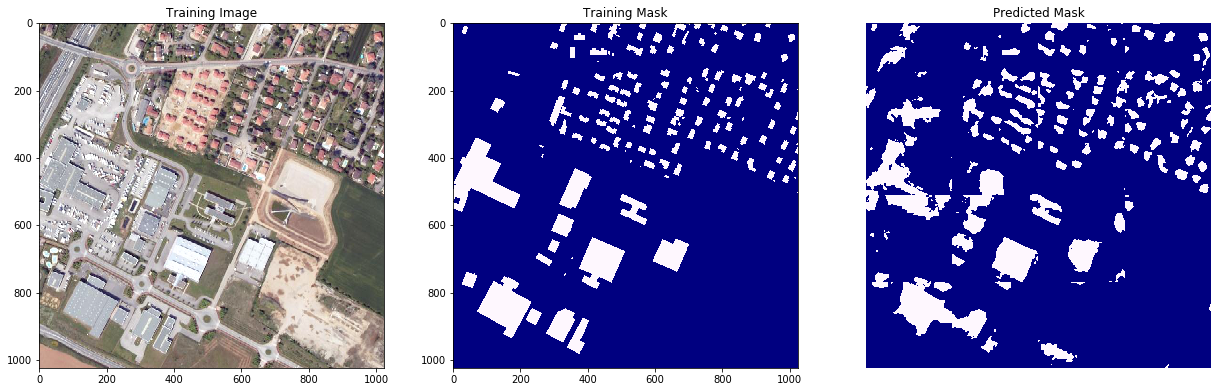

In [25]:
model = get_unet_5()
model.load_weights('unet5_c1_100.hdf5')
check_predict(model, 0.5, img_id=Image_ID[8], Class_Type=1)


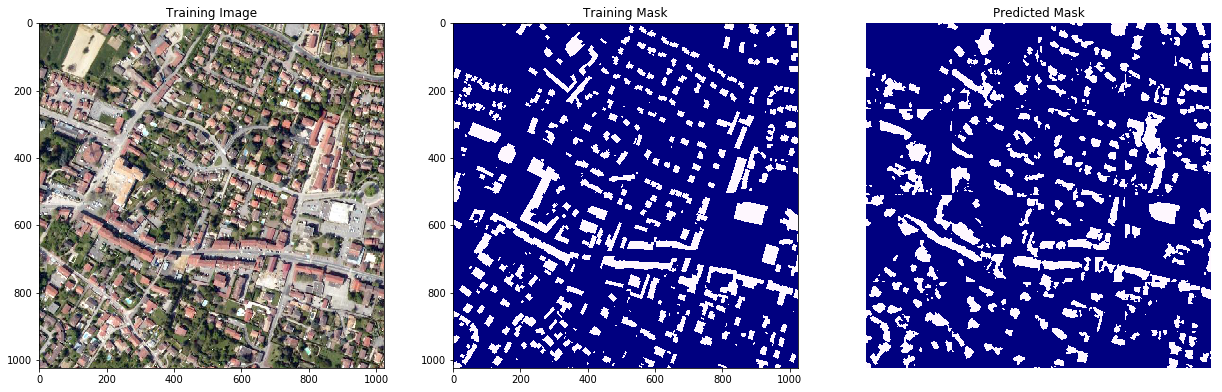

In [18]:
check_predict(model, 0.5, img_id=Image_ID[10], Class_Type=1)

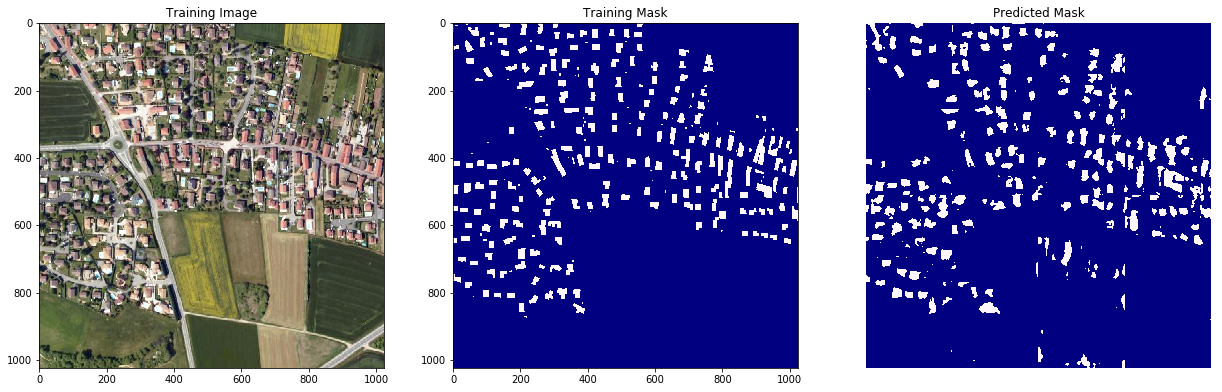

Lyon_2_6


In [27]:
img_id = Image_ID[20]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)

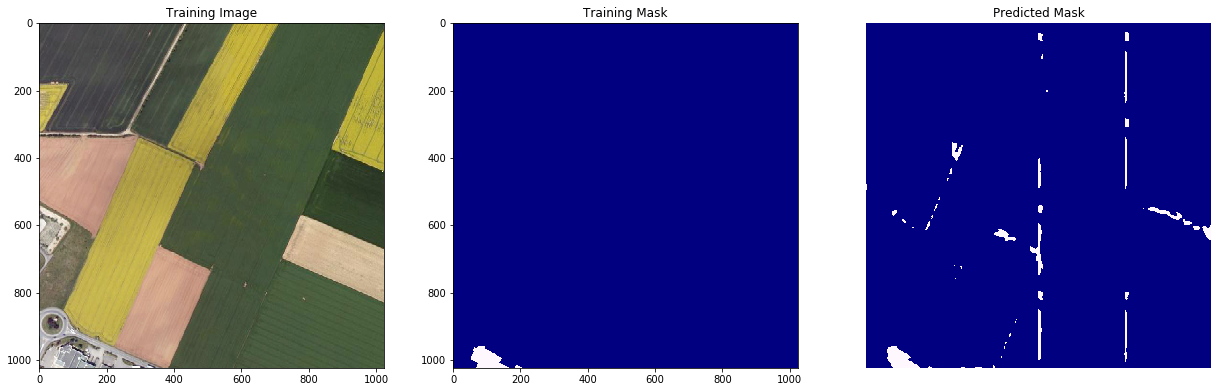

Lyon_3_2


In [30]:
img_id = Image_ID[23]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


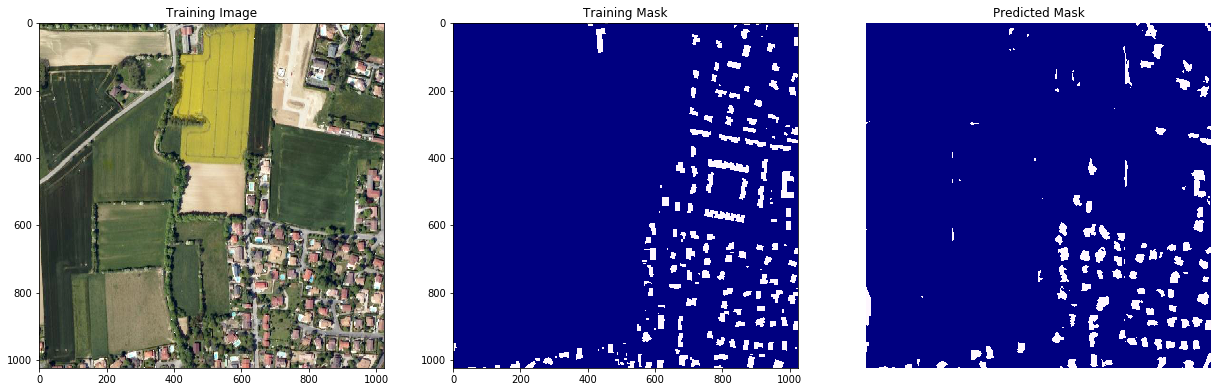

Lyon_0_4


In [57]:
img_id = Image_ID[4]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


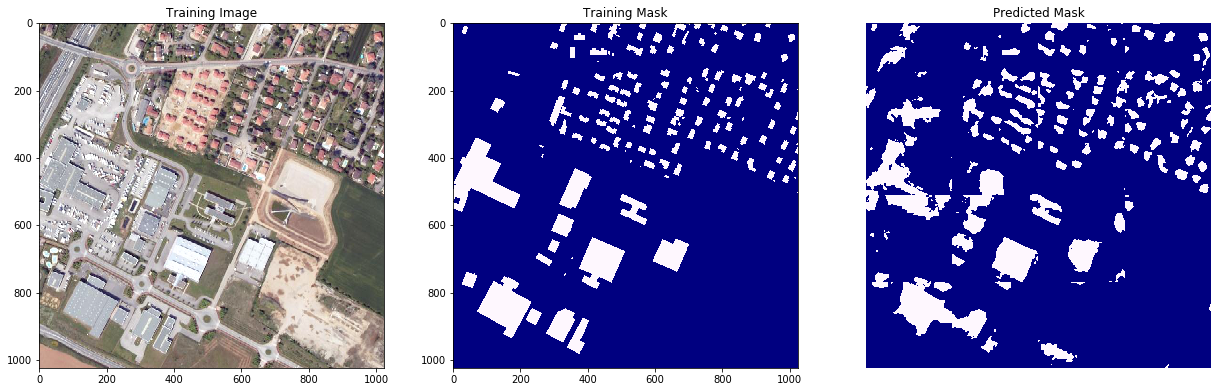

Lyon_1_1


In [49]:
img_id = Image_ID[8]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


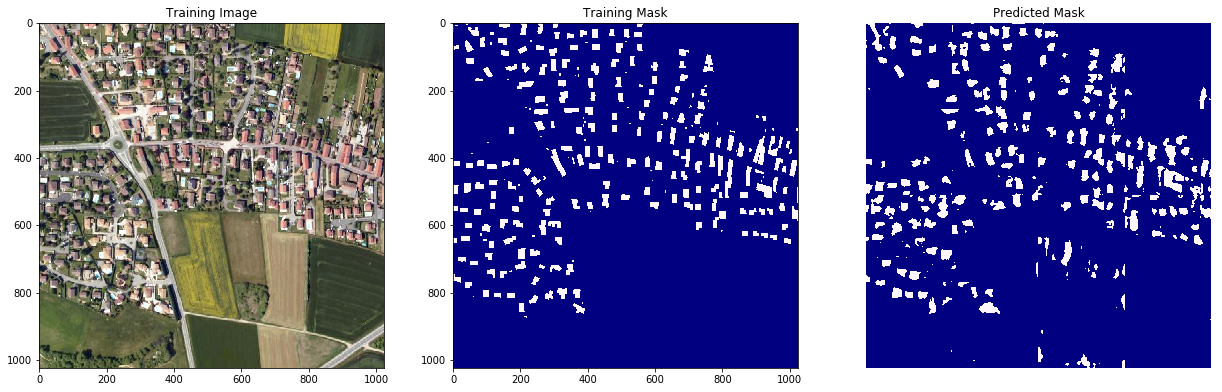

Lyon_2_6


In [42]:
img_id = Image_ID[20]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)

In [51]:
img = get_image(img_id)

In [52]:
img.shape

(1024, 1024, 3)

In [56]:
i =1
j =1
x = img[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1), :]

In [59]:
x.shape

(256, 256, 3)